<a href="https://colab.research.google.com/github/lauragabrysiak/mitx_applied_data_science/blob/main/CAPSTONE_music_recsys_gabrysiak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Recommendation System**

## **Problem Definition**

### **The Context:**

With the advent of technology, societies have become more efficient with their lives. At the same time, however, individual human lives have also become more fast-paced and distracted, leaving little time to explore artistic pursuits. Also, technology has made significant advancements in the ability to coexist with art and general entertainment. It has in fact made it easier for humans with a shortage of time to find and consume good content.

Almost every internet-based company's revenue relies on the time consumers spend on its platform. These companies need to be able to figure out what kind of content is needed in order to increase customer time spent and make their experience better. Therefore, one of the key challenges for these companies is figuring out what kind of content their customers are most likely to consume.
Spotify is one such audio content provider with a huge market base across the world. With the ever-increasing volume of songs becoming available on the Internet, searching for songs of interest has become a tedious task in itself.

However, Spotify has grown significantly in the market because of its ability to recommend the 'best' next song to each and every customer based on a huge
preference database gathered over time - millions of customers and billions of songs. This is done by using smart recommendation systems that can recommend songs based on users' likes/dislikes.

Source: https://olympus.mygreatlearning.com/courses/87799/files/7049375?module_item_id=3469914

#### **Why is this problem important to solve?**

Competitive advange by user experience and insights + data as a product.

### **The objective:**

#### **What is the intended goal?**
 Build a recommendation system to propose the top 10 songs for a user based on the likelihood of listening to those songs.

####**The key questions:**

What are the key questions that need to be answered?

*   What is the goal of the recommendation system?
*   Who are the users?
*   What data is available?
*   How will the system handle new users and items?
*   What algorithms and models will be used?
*   How will the system handle diversity and serendipity?
*   What is the system's scalability and performance?
*   Are there any technical or data limitations

### **The problem formulation**:

**What is it that we are trying to solve using data science?**

Recommendation systems in data science help solve challenges related to information overload, user engagement, personalization, and more. These systems filter and prioritize items based on user preferences and tailor suggestions based on individual behavior, providing a personalized experience that encourages exploration and enhances user engagement. They also increase sales and revenue by analyzing user behavior and preferences to suggest products more likely to result in purchases. Additionally, they optimize content delivery and maximize click-through rates by suggesting items that align with user interests and preferences. Overall, recommendation systems use data science techniques to enhance user experiences and drive business outcomes.

## **Data Dictionary**

The core data is the Taste Profile Subset released by the Echo Nest as part of the Million Song Dataset. There are two files in this dataset. The first file contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

## S1: song_data
*   song_id - A unique id given to every song
*   title - Title of the song
*   Release - Name of the released album
*   Artist_name - Name of the artist
*   year - Year of release

## S2: count_data
*   user _id - A unique id given to the user
*   song_id - A unique id given to the song
*   play_count - Number of times the song was played

## **Data Source**
http://millionsongdataset.com/

## Data Understanding


### **Importing Libraries and the Dataset**

#### Mount Drive

In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#### Install Libraries

In [ ]:
# Installing surprise library
!pip install surprise

In [ ]:
# Installing Pandas Profile
!pip install -U ydata-profiling[notebook]==4.0.0 matplotlib==3.5.1

In [ ]:
# Installing Pandas Profile
!pip install spotipy

#### Import Libraries

In [1]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')
from collections import defaultdict             # A dictionary output that does not raise a key error

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # data visualization
import seaborn as sns                           # data visualization advanced

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

from ydata_profiling import ProfileReport       # Adding pandas report
from scipy.stats import pearsonr                # pearson correlation

In [41]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import SpotifyException

### **Datasets**

#### Import datasets

In [2]:
# Importing the datasets
song_df = pd.read_csv('/content/sample_data/song_data.csv'
                  , on_bad_lines='skip')
count_df = pd.read_csv('/content/sample_data/count_data.csv'
                  , on_bad_lines='skip')

In [74]:
print("song ds", song_df.shape)
print("count ds", count_df.shape)

song ds (1000000, 5)
count ds (2000000, 4)


In [75]:
print(song_df.info())   # there is some missing information (title (-15) /release (-5) )
print("\n")
print(count_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   user_id     object
 2   song_id     object
 3   play_count  int64 
dtypes: int64(2), object(2)
memory usage: 61.0+ MB
None


#### Data Preparation

#### S1) **Count dataset**

Dataset of 2000000 x 3 variables. Includes the number of times that songs were played and by who (user). Includes the song_id as primary key for reference

In [3]:
count_df.columns = ['index','user_id', 'song_id', 'play_count'] # Adding column names
count_df_copy = count_df .copy(deep = True) # backup copy
count_df = count_df.drop('index', axis = 1) # Dropping index # Drop the column 'Unnamed: 0' // already done

In [77]:
# See top 10 records of count_df data
count_df.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [78]:
# See the info of the count_df data
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   song_id     object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


In [93]:
#### Pandas Report original dataset
# Use df_copy
count_profile = ProfileReport(count_df
                        , title="Count Info Report"
                        #, subtitle="Original Dataset"
                        )

In [94]:
count_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### S2) **Song dataset**
Dataset defined by 1000000 x 5 variables. Includes the song information (song_title, song_release, song_artist, song_year) along with song_id which can be used for merging as as a reference

In [80]:
print(song_df.shape, "\n", song_df.head(3))

(1000000, 5) 
               song_id              title                release  \
0  SOQMMHC12AB0180CB8       Silent Night  Monster Ballads X-Mas   
1  SOVFVAK12A8C1350D9        Tanssi vaan            Karkuteillä   
2  SOGTUKN12AB017F4F1  No One Could Ever                 Butter   

        artist_name  year  
0  Faster Pussy cat  2003  
1  Karkkiautomaatti  1995  
2    Hudson Mohawke  2006  


In [4]:
temp = song_df
temp = temp.dropna(axis=0)
print(temp.shape, "\n", temp.head(3))
#song_df = temp

(999980, 5) 
               song_id              title                release  \
0  SOQMMHC12AB0180CB8       Silent Night  Monster Ballads X-Mas   
1  SOVFVAK12A8C1350D9        Tanssi vaan            Karkuteillä   
2  SOGTUKN12AB017F4F1  No One Could Ever                 Butter   

        artist_name  year  
0  Faster Pussy cat  2003  
1  Karkkiautomaatti  1995  
2    Hudson Mohawke  2006  


In [5]:
# See top 10 records of song_df data
temp.columns = ['song_id','song_title', 'song_release', 'song_artist', 'song_year'] # Adding column names
temp.sample(5)

,song_id,song_title,song_release,song_artist,song_year
393546,SOXPMIV12A6701EF9E,Jerk It Out (Original Mix),Love For The Streets,Caesars,0
80699,SOQFKVM12AB018416A,It Won't Work This Time,Every Time You Say Goodbye,Alison Krauss / Union Station,0
681655,SOQAGPH12A8C14002B,Blackbossa,Latin Bitman,DJ Bitman,0
735743,SOGJYPH12A8C13A771,If I Ruled The World,Shining My Flashlight On The Moon,Christine Lavin,0
296403,SOHJOAF12A8C1428D2,Tout le Monde dans la Ronde,Nord Vs Sud,Sages Poètes de la Rue,0


In [84]:
# See the info of the song_df data
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999980 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   song_id       999980 non-null  object
 1   song_title    999980 non-null  object
 2   song_release  999980 non-null  object
 3   song_artist   999980 non-null  object
 4   song_year     999980 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 45.8+ MB


##### Using the Spotify Web API for data augmentation

In [38]:
song_df['song_id'][1]

'SOVFVAK12A8C1350D9'

[Spotify Web Developer instructions](https://developer.spotify.com/documentation/web-api/concepts/spotify-uris-ids)

[Spotify Web API instructions](https://developer.spotify.com/documentation/web-api/reference/get-an-artist)

[Using Spotify Web App](https://garrecht-metzger.medium.com/getting-started-with-the-spotify-api-using-spotipy-bfb2340293c9)




In [42]:
# Replace 'YOUR_CLIENT_ID', 'YOUR_CLIENT_SECRET', and 'YOUR_REDIRECT_URI' with your actual credentials
client_id = '930c85172af549c7bed7661f025edf11'
client_secret = 'b33c88126c014981b3fc1d7c426d3a1c'
redirect_uri = 'http://localhost:8888/callback'

# Set up Spotify API credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

# Example: Augmenting a dataset using song IDs
song_ids = song_df['song_id']

# Initialize a list to store augmented data
augmented_data = []

# Retrieve information for each song ID
for song_id in song_ids:
    try:
        track_info = sp.track(song_id)
        artist_info = sp.artist(track_info['artists'][0]['id'])

        # Extract relevant information
        track_name = track_info['name']
        artist_name = artist_info['name']
        release_date = track_info['album']['release_date']
        popularity = track_info['popularity']
        artist_genres = artist_info['genres']

        # Add the augmented data to the list
        augmented_data.append({
            'song_id': song_id,
            'track_name': track_name,
            'artist_name': artist_name,
            'release_date': release_date,
            'popularity': popularity,
            'genres': artist_genres
        })
    except SpotifyException as e:
        print(f"Error for song ID {song_id}: {e}")

# Convert the augmented data to a DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Display the augmented DataFrame
print("Augmented DataFrame:")
print(augmented_df)

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQMMHC12AB0180CB8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVFVAK12A8C1350D9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGTUKN12AB017F4F1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBNYVR12A8C13558C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHSBXH12A8C13B0DF with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQMMHC12AB0180CB8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQMMHC12AB0180CB8:
 invalid id, reason: None
Error for song ID SOVFVAK12A8C1350D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVFVAK12A8C1350D9:
 invalid id, reason: None
Error for song ID SOGTUKN12AB017F4F1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGTUKN12AB017F4F1:
 invalid id, reason: None
Error for song ID SOBNYVR12A8C13558C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBNYVR12A8C13558C:
 invalid id, reason: None
Error for song ID SOHSBXH12A8C13B0DF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHSBXH12A8C13B0DF:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZVAPQ12A8C13B63C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQVRHI12A6D4FB2D7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEYRFT12AB018936C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPMIYT12A6D4F851E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJCFMH12A8C13B0C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYGNWH12AB018191E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOZVAPQ12A8C13B63C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZVAPQ12A8C13B63C:
 invalid id, reason: None
Error for song ID SOQVRHI12A6D4FB2D7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQVRHI12A6D4FB2D7:
 invalid id, reason: None
Error for song ID SOEYRFT12AB018936C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEYRFT12AB018936C:
 invalid id, reason: None
Error for song ID SOPMIYT12A6D4F851E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPMIYT12A6D4F851E:
 invalid id, reason: None
Error for song ID SOJCFMH12A8C13B0C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJCFMH12A8C13B0C2:
 invalid id, reason: None
Error for song ID SOYGNWH12AB018191E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYGNWH12AB018191E:
 invalid id, reason: None
Error for song ID SOLJTLX12AB01890ED: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLJTLX12AB01890ED:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQQESG12A58A7AA28 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMPVQB12A8C1379BB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGPCJI12A8C13CCA0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSDCFG12AB0184647 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBARPM12A8C133DFF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKOVRQ12A8C142811 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQQESG12A58A7AA28: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQQESG12A58A7AA28:
 invalid id, reason: None
Error for song ID SOMPVQB12A8C1379BB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMPVQB12A8C1379BB:
 invalid id, reason: None
Error for song ID SOGPCJI12A8C13CCA0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGPCJI12A8C13CCA0:
 invalid id, reason: None
Error for song ID SOSDCFG12AB0184647: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSDCFG12AB0184647:
 invalid id, reason: None
Error for song ID SOBARPM12A8C133DFF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBARPM12A8C133DFF:
 invalid id, reason: None
Error for song ID SOKOVRQ12A8C142811: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKOVRQ12A8C142811:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIMMJJ12AF72AD643 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVMBTP12A8C13A8F6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOUESZ12AB0189AFD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAGMGG12A6D4F9099 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGFWVT12A8C137C64 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKLPMH12AB01861FA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIMMJJ12AF72AD643: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIMMJJ12AF72AD643:
 invalid id, reason: None
Error for song ID SOVMBTP12A8C13A8F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVMBTP12A8C13A8F6:
 invalid id, reason: None
Error for song ID SOOUESZ12AB0189AFD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOUESZ12AB0189AFD:
 invalid id, reason: None
Error for song ID SOAGMGG12A6D4F9099: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAGMGG12A6D4F9099:
 invalid id, reason: None
Error for song ID SOGFWVT12A8C137C64: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGFWVT12A8C137C64:
 invalid id, reason: None
Error for song ID SOKLPMH12AB01861FA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKLPMH12AB01861FA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEPAIN12A8C1396A7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQMZZI12AB01850D4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEEHEY12CF5F88FB4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWUMAZ12A67ADE769 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJJAZT12AC4687219 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMLHJQ12AC4685B45 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOEPAIN12A8C1396A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEPAIN12A8C1396A7:
 invalid id, reason: None
Error for song ID SOQMZZI12AB01850D4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQMZZI12AB01850D4:
 invalid id, reason: None
Error for song ID SOEEHEY12CF5F88FB4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEEHEY12CF5F88FB4:
 invalid id, reason: None
Error for song ID SOWUMAZ12A67ADE769: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWUMAZ12A67ADE769:
 invalid id, reason: None
Error for song ID SOJJAZT12AC4687219: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJJAZT12AC4687219:
 invalid id, reason: None
Error for song ID SOMLHJQ12AC4685B45: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMLHJQ12AC4685B45:
 invalid id, reason: None
Error for song ID SOYNOIK12A6D4F7F3F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYNOIK12A6D4F7F3F:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPUJOM12AB017FEEB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGNNYL12A6D4F910B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOLRHW12A8C142643 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMKNZS12A8C13DEBC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYKVON12A8C14097E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEXAWC12AB01817E6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOPUJOM12AB017FEEB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPUJOM12AB017FEEB:
 invalid id, reason: None
Error for song ID SOGNNYL12A6D4F910B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGNNYL12A6D4F910B:
 invalid id, reason: None
Error for song ID SOOLRHW12A8C142643: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOLRHW12A8C142643:
 invalid id, reason: None
Error for song ID SOMKNZS12A8C13DEBC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMKNZS12A8C13DEBC:
 invalid id, reason: None
Error for song ID SOYKVON12A8C14097E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYKVON12A8C14097E:
 invalid id, reason: None
Error for song ID SOEXAWC12AB01817E6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEXAWC12AB01817E6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKQCDA12A6D4FA556 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFWVLR12A8C1328DC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLRKBF12A8C13C88A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBDLRM12A8C13A0AC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMXBRA12AB017C656 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODJAOH12A58A77B23 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKQCDA12A6D4FA556: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKQCDA12A6D4FA556:
 invalid id, reason: None
Error for song ID SOFWVLR12A8C1328DC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFWVLR12A8C1328DC:
 invalid id, reason: None
Error for song ID SOLRKBF12A8C13C88A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLRKBF12A8C13C88A:
 invalid id, reason: None
Error for song ID SOBDLRM12A8C13A0AC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBDLRM12A8C13A0AC:
 invalid id, reason: None
Error for song ID SOMXBRA12AB017C656: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMXBRA12AB017C656:
 invalid id, reason: None
Error for song ID SODJAOH12A58A77B23: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODJAOH12A58A77B23:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCPTIN12A8C14265F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODVOFJ12AB0181EE6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODDEQU12AAF3B2FC8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYUEW12AB018B373 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWWQXA12A81C1F9CA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONNHYN12AB018538B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOCPTIN12A8C14265F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCPTIN12A8C14265F:
 invalid id, reason: None
Error for song ID SODVOFJ12AB0181EE6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODVOFJ12AB0181EE6:
 invalid id, reason: None
Error for song ID SODDEQU12AAF3B2FC8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODDEQU12AAF3B2FC8:
 invalid id, reason: None
Error for song ID SONYUEW12AB018B373: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYUEW12AB018B373:
 invalid id, reason: None
Error for song ID SOWWQXA12A81C1F9CA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWWQXA12A81C1F9CA:
 invalid id, reason: None
Error for song ID SONNHYN12AB018538B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONNHYN12AB018538B:
 invalid id, reason: None
Error for song ID SOCWWYB12A6D4F9AF4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCWWYB12A6D4F9AF4:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIRTNX12AB018B41D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLGCKQ12A8AE47CFA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZOAEF12AB017F0A9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHMYGC12A6D4FAC4B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHSSPG12A8C144BE0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCBSOR12A8C1314DD with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIRTNX12AB018B41D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIRTNX12AB018B41D:
 invalid id, reason: None
Error for song ID SOLGCKQ12A8AE47CFA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLGCKQ12A8AE47CFA:
 invalid id, reason: None
Error for song ID SOZOAEF12AB017F0A9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZOAEF12AB017F0A9:
 invalid id, reason: None
Error for song ID SOHMYGC12A6D4FAC4B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHMYGC12A6D4FAC4B:
 invalid id, reason: None
Error for song ID SOHSSPG12A8C144BE0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHSSPG12A8C144BE0:
 invalid id, reason: None
Error for song ID SOCBSOR12A8C1314DD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCBSOR12A8C1314DD:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOKLXI12A8C142FB0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYMTVV12A58A7C2D6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODQHXQ12AB0189AE0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFSJXP12AB017E676 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHGZWM12AAA8C86EA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOKLXI12A8C142FB0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOKLXI12A8C142FB0:
 invalid id, reason: None
Error for song ID SOYMTVV12A58A7C2D6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYMTVV12A58A7C2D6:
 invalid id, reason: None
Error for song ID SODQHXQ12AB0189AE0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODQHXQ12AB0189AE0:
 invalid id, reason: None
Error for song ID SOFSJXP12AB017E676: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFSJXP12AB017E676:
 invalid id, reason: None
Error for song ID SOHGZWM12AAA8C86EA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHGZWM12AAA8C86EA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLBDWO12AB0188CC2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUHTYT12AB0189D1C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVUFFC12AC9E16242 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEBDKM12AC4686D3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPJNRJ12A8C1461C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUVPJZ12AB018218C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLBDWO12AB0188CC2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLBDWO12AB0188CC2:
 invalid id, reason: None
Error for song ID SOUHTYT12AB0189D1C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUHTYT12AB0189D1C:
 invalid id, reason: None
Error for song ID SOVUFFC12AC9E16242: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVUFFC12AC9E16242:
 invalid id, reason: None
Error for song ID SOEBDKM12AC4686D3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEBDKM12AC4686D3A:
 invalid id, reason: None
Error for song ID SOPJNRJ12A8C1461C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPJNRJ12A8C1461C4:
 invalid id, reason: None
Error for song ID SOUVPJZ12AB018218C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUVPJZ12AB018218C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONUZSW12AAA15EA65 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGBBEE12AB017ED6A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPBCNI12AF729FE49 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYKRSW12AB018078B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORASFZ12AB01828C7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONUZSW12AAA15EA65: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONUZSW12AAA15EA65:
 invalid id, reason: None
Error for song ID SOGBBEE12AB017ED6A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGBBEE12AB017ED6A:
 invalid id, reason: None
Error for song ID SOPBCNI12AF729FE49: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPBCNI12AF729FE49:
 invalid id, reason: None
Error for song ID SOYKRSW12AB018078B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYKRSW12AB018078B:
 invalid id, reason: None
Error for song ID SORASFZ12AB01828C7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORASFZ12AB01828C7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVOIOQ12AC4688FAC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXAGQZ12AB018A089 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLFMLX12AB0186EB5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSNKHA12AB0185BD6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLOUIH12AB018146C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKWWCO12AB0187D70 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOVOIOQ12AC4688FAC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVOIOQ12AC4688FAC:
 invalid id, reason: None
Error for song ID SOXAGQZ12AB018A089: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXAGQZ12AB018A089:
 invalid id, reason: None
Error for song ID SOLFMLX12AB0186EB5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLFMLX12AB0186EB5:
 invalid id, reason: None
Error for song ID SOSNKHA12AB0185BD6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSNKHA12AB0185BD6:
 invalid id, reason: None
Error for song ID SOLOUIH12AB018146C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLOUIH12AB018146C:
 invalid id, reason: None
Error for song ID SOKWWCO12AB0187D70: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKWWCO12AB0187D70:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODXEOD12AB018EC03 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONHPZT12AC90970C3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHQYYJ12AB0183B6D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIOKZN12AB01857C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMPUGR12A8C146F57 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODMDUM12A6D4FCEE4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODXEOD12AB018EC03: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODXEOD12AB018EC03:
 invalid id, reason: None
Error for song ID SONHPZT12AC90970C3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONHPZT12AC90970C3:
 invalid id, reason: None
Error for song ID SOHQYYJ12AB0183B6D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHQYYJ12AB0183B6D:
 invalid id, reason: None
Error for song ID SOIOKZN12AB01857C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIOKZN12AB01857C2:
 invalid id, reason: None
Error for song ID SOMPUGR12A8C146F57: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMPUGR12A8C146F57:
 invalid id, reason: None
Error for song ID SODMDUM12A6D4FCEE4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODMDUM12A6D4FCEE4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONVYNC12AB0184ECC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPHQEL12A8C1357CC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLQULR12AB018D726 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKXBTF12A6BD4F3AD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPFHPD12A8C1407F6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOORUNH12AB0182395 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SONVYNC12AB0184ECC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONVYNC12AB0184ECC:
 invalid id, reason: None
Error for song ID SOPHQEL12A8C1357CC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPHQEL12A8C1357CC:
 invalid id, reason: None
Error for song ID SOLQULR12AB018D726: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLQULR12AB018D726:
 invalid id, reason: None
Error for song ID SOKXBTF12A6BD4F3AD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKXBTF12A6BD4F3AD:
 invalid id, reason: None
Error for song ID SOPFHPD12A8C1407F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPFHPD12A8C1407F6:
 invalid id, reason: None
Error for song ID SOORUNH12AB0182395: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOORUNH12AB0182395:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYTTYG12AB017F85E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUIUYF12AC3DF998F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJGKAD12A58A7D1FF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCKLYJ12A8C14017E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMOSWT12AB017CD5A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUKOKB12AB018A808 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAOSWS12AB0189131: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAOSWS12AB0189131:
 invalid id, reason: None
Error for song ID SOYTTYG12AB017F85E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYTTYG12AB017F85E:
 invalid id, reason: None
Error for song ID SOUIUYF12AC3DF998F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUIUYF12AC3DF998F:
 invalid id, reason: None
Error for song ID SOJGKAD12A58A7D1FF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJGKAD12A58A7D1FF:
 invalid id, reason: None
Error for song ID SOCKLYJ12A8C14017E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCKLYJ12A8C14017E:
 invalid id, reason: None
Error for song ID SOMOSWT12AB017CD5A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMOSWT12AB017CD5A:
 invalid id, reason: None
Error for song ID SOUKOKB12AB018A808: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUKOKB12AB018A808:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJLGRD12AB018724F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZTLAR12A8C1368A9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIOAQZ12A8AE472A2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLTAUK12A8AE4611F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPRQGM12A58A784F1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOADQCE12A6D4F64B3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJLGRD12AB018724F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJLGRD12AB018724F:
 invalid id, reason: None
Error for song ID SOZTLAR12A8C1368A9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZTLAR12A8C1368A9:
 invalid id, reason: None
Error for song ID SOIOAQZ12A8AE472A2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIOAQZ12A8AE472A2:
 invalid id, reason: None
Error for song ID SOLTAUK12A8AE4611F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLTAUK12A8AE4611F:
 invalid id, reason: None
Error for song ID SOPRQGM12A58A784F1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPRQGM12A58A784F1:
 invalid id, reason: None
Error for song ID SOADQCE12A6D4F64B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOADQCE12A6D4F64B3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOWUDY12A6D4FA0B0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODSOYL12A6D4F5B39 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMLQLS12A8C13D138 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKQPKX12A6D4FAC5B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFKEUC12A6D4F4C3F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPXLUV12AB018128F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOWUDY12A6D4FA0B0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOWUDY12A6D4FA0B0:
 invalid id, reason: None
Error for song ID SODSOYL12A6D4F5B39: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODSOYL12A6D4F5B39:
 invalid id, reason: None
Error for song ID SOMLQLS12A8C13D138: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMLQLS12A8C13D138:
 invalid id, reason: None
Error for song ID SOKQPKX12A6D4FAC5B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKQPKX12A6D4FAC5B:
 invalid id, reason: None
Error for song ID SOFKEUC12A6D4F4C3F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFKEUC12A6D4F4C3F:
 invalid id, reason: None
Error for song ID SOPXLUV12AB018128F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPXLUV12AB018128F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOIKJH12A6D4F6454 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXXJGW12AAF3B58CF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBGKMC12A8C137FE0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKAWDI12A6D4FA72F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWGQLY12AAF3B47D9 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOIKJH12A6D4F6454: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOIKJH12A6D4F6454:
 invalid id, reason: None
Error for song ID SOXXJGW12AAF3B58CF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXXJGW12AAF3B58CF:
 invalid id, reason: None
Error for song ID SOBGKMC12A8C137FE0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBGKMC12A8C137FE0:
 invalid id, reason: None
Error for song ID SOKAWDI12A6D4FA72F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKAWDI12A6D4FA72F:
 invalid id, reason: None
Error for song ID SOWGQLY12AAF3B47D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWGQLY12AAF3B47D9:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGXPYA12A58A769A7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHNWIM12A67ADF7D9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHCDDC12AB018B206 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAQWU12A8C13F908 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTOTTC12A8C142727 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOELTOP12AAFF415CF with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGXPYA12A58A769A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGXPYA12A58A769A7:
 invalid id, reason: None
Error for song ID SOHNWIM12A67ADF7D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHNWIM12A67ADF7D9:
 invalid id, reason: None
Error for song ID SOHCDDC12AB018B206: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHCDDC12AB018B206:
 invalid id, reason: None
Error for song ID SOAAQWU12A8C13F908: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAQWU12A8C13F908:
 invalid id, reason: None
Error for song ID SOTOTTC12A8C142727: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTOTTC12A8C142727:
 invalid id, reason: None
Error for song ID SOELTOP12AAFF415CF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOELTOP12AAFF415CF:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSNZGD12A582A2624 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFCGTP12A8C140A93 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQAWRX12A8C140FB3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOECFIW12A8C144546 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGHBFO12AB017C407 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCFEYX12AB0185304 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOSNZGD12A582A2624: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSNZGD12A582A2624:
 invalid id, reason: None
Error for song ID SOFCGTP12A8C140A93: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFCGTP12A8C140A93:
 invalid id, reason: None
Error for song ID SOQAWRX12A8C140FB3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQAWRX12A8C140FB3:
 invalid id, reason: None
Error for song ID SOECFIW12A8C144546: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOECFIW12A8C144546:
 invalid id, reason: None
Error for song ID SOGHBFO12AB017C407: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGHBFO12AB017C407:
 invalid id, reason: None
Error for song ID SOCFEYX12AB0185304: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCFEYX12AB0185304:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIJRWP12A8C13E78D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYFPHJ12A8C13C2B2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUMNSI12AB0182807 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMLVLH12AC3DF9CCD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEXXWL12AB0189326 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAHCHL12A8C13C8C5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIJRWP12A8C13E78D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIJRWP12A8C13E78D:
 invalid id, reason: None
Error for song ID SOYFPHJ12A8C13C2B2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYFPHJ12A8C13C2B2:
 invalid id, reason: None
Error for song ID SOUMNSI12AB0182807: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUMNSI12AB0182807:
 invalid id, reason: None
Error for song ID SOMLVLH12AC3DF9CCD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMLVLH12AC3DF9CCD:
 invalid id, reason: None
Error for song ID SOEXXWL12AB0189326: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEXXWL12AB0189326:
 invalid id, reason: None
Error for song ID SOAHCHL12A8C13C8C5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAHCHL12A8C13C8C5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHMXUE12AB018676C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLLEAB12AB017DC60 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLTFTE12A8C13718B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIOVEM12A8C13D837 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXIARP12AB018492E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSTYVO12AC907117C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOHMXUE12AB018676C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHMXUE12AB018676C:
 invalid id, reason: None
Error for song ID SOLLEAB12AB017DC60: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLLEAB12AB017DC60:
 invalid id, reason: None
Error for song ID SOLTFTE12A8C13718B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLTFTE12A8C13718B:
 invalid id, reason: None
Error for song ID SOIOVEM12A8C13D837: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIOVEM12A8C13D837:
 invalid id, reason: None
Error for song ID SOXIARP12AB018492E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXIARP12AB018492E:
 invalid id, reason: None
Error for song ID SOSTYVO12AC907117C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSTYVO12AC907117C:
 invalid id, reason: None
Error for song ID SOHVRGJ12AB01826FE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHVRGJ12AB01826FE:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODRTHY12AB018FB3B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOARKPN12AB018A3F1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVGOBZ12AB0185AB0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBBODD12A8C13FFA0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJKQRQ12AB01804A5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKFTXQ12AB018C33A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODRTHY12AB018FB3B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODRTHY12AB018FB3B:
 invalid id, reason: None
Error for song ID SOARKPN12AB018A3F1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOARKPN12AB018A3F1:
 invalid id, reason: None
Error for song ID SOVGOBZ12AB0185AB0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVGOBZ12AB0185AB0:
 invalid id, reason: None
Error for song ID SOBBODD12A8C13FFA0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBBODD12A8C13FFA0:
 invalid id, reason: None
Error for song ID SOJKQRQ12AB01804A5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJKQRQ12AB01804A5:
 invalid id, reason: None
Error for song ID SOKFTXQ12AB018C33A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKFTXQ12AB018C33A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGWEOB12AB018A4D0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIHJKI12A8C13D474 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFMVOA12AB018240A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCELXR12AB017EB1B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBAHCX12AB0183F7A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOINLLV12A6D4FBB05 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGWEOB12AB018A4D0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGWEOB12AB018A4D0:
 invalid id, reason: None
Error for song ID SOIHJKI12A8C13D474: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIHJKI12A8C13D474:
 invalid id, reason: None
Error for song ID SOFMVOA12AB018240A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFMVOA12AB018240A:
 invalid id, reason: None
Error for song ID SOCELXR12AB017EB1B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCELXR12AB017EB1B:
 invalid id, reason: None
Error for song ID SOBAHCX12AB0183F7A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBAHCX12AB0183F7A:
 invalid id, reason: None
Error for song ID SOINLLV12A6D4FBB05: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOINLLV12A6D4FBB05:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBHUSK12AB0187786 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPNAOX12A6D4F85AF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIGUQJ12A6D4FAB11 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJUTQH12A8C13D5F3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXDQGB12AB018AC90 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSUDKY12AC3DFA679 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBHUSK12AB0187786: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBHUSK12AB0187786:
 invalid id, reason: None
Error for song ID SOPNAOX12A6D4F85AF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPNAOX12A6D4F85AF:
 invalid id, reason: None
Error for song ID SOIGUQJ12A6D4FAB11: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIGUQJ12A6D4FAB11:
 invalid id, reason: None
Error for song ID SOJUTQH12A8C13D5F3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJUTQH12A8C13D5F3:
 invalid id, reason: None
Error for song ID SOXDQGB12AB018AC90: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXDQGB12AB018AC90:
 invalid id, reason: None
Error for song ID SOSUDKY12AC3DFA679: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSUDKY12AC3DFA679:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUGJMK12AB018852E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPZPJR12AB0180ED3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMPTDS12A8C13AC1D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOENBNC12A8C1326F6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCEXXJ12AB0185239 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIYPRW12AB018669D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUGJMK12AB018852E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUGJMK12AB018852E:
 invalid id, reason: None
Error for song ID SOPZPJR12AB0180ED3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPZPJR12AB0180ED3:
 invalid id, reason: None
Error for song ID SOMPTDS12A8C13AC1D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMPTDS12A8C13AC1D:
 invalid id, reason: None
Error for song ID SOENBNC12A8C1326F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOENBNC12A8C1326F6:
 invalid id, reason: None
Error for song ID SOCEXXJ12AB0185239: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCEXXJ12AB0185239:
 invalid id, reason: None
Error for song ID SOIYPRW12AB018669D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIYPRW12AB018669D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHLMBQ12AC961881F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPDAZL12A58A7CAE5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUMLGC12A6D4F9C32 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVECZJ12AB01828DB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVVXOO12A8C13AED8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWKZGU12AF72A2B4A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHLMBQ12AC961881F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHLMBQ12AC961881F:
 invalid id, reason: None
Error for song ID SOPDAZL12A58A7CAE5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPDAZL12A58A7CAE5:
 invalid id, reason: None
Error for song ID SOUMLGC12A6D4F9C32: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUMLGC12A6D4F9C32:
 invalid id, reason: None
Error for song ID SOVECZJ12AB01828DB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVECZJ12AB01828DB:
 invalid id, reason: None
Error for song ID SOVVXOO12A8C13AED8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVVXOO12A8C13AED8:
 invalid id, reason: None
Error for song ID SOWKZGU12AF72A2B4A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWKZGU12AF72A2B4A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAGUGD12A8C13FB69 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOEDWI12A58A7B1C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJEBYC12A6310E031 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJGCRL12A8C144187 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQPSNZ12A8AE44A95 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGUUQT12A8C13599E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAGUGD12A8C13FB69: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAGUGD12A8C13FB69:
 invalid id, reason: None
Error for song ID SOOEDWI12A58A7B1C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOEDWI12A58A7B1C4:
 invalid id, reason: None
Error for song ID SOJEBYC12A6310E031: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJEBYC12A6310E031:
 invalid id, reason: None
Error for song ID SOJGCRL12A8C144187: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJGCRL12A8C144187:
 invalid id, reason: None
Error for song ID SOQPSNZ12A8AE44A95: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQPSNZ12A8AE44A95:
 invalid id, reason: None
Error for song ID SOGUUQT12A8C13599E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGUUQT12A8C13599E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJJMAE12A8C135E68 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONQPBR12AB0187DD8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODLNNU12A8AE475B5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONTDUZ12D021989FD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQCROT12AB017ECA2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHBAMW12AF72A0AA9 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJJMAE12A8C135E68: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJJMAE12A8C135E68:
 invalid id, reason: None
Error for song ID SONQPBR12AB0187DD8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONQPBR12AB0187DD8:
 invalid id, reason: None
Error for song ID SODLNNU12A8AE475B5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODLNNU12A8AE475B5:
 invalid id, reason: None
Error for song ID SONTDUZ12D021989FD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONTDUZ12D021989FD:
 invalid id, reason: None
Error for song ID SOQCROT12AB017ECA2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQCROT12AB017ECA2:
 invalid id, reason: None
Error for song ID SOHBAMW12AF72A0AA9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHBAMW12AF72A0AA9:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHTYTP12AB0185CA1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGTNHX12AB0180BF0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODHRTM12A8C13B611 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODOHGX12A8C13ECBA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPWMAB12A58A7E8E9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMVWIV12A8C133D30 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHTYTP12AB0185CA1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHTYTP12AB0185CA1:
 invalid id, reason: None
Error for song ID SOGTNHX12AB0180BF0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGTNHX12AB0180BF0:
 invalid id, reason: None
Error for song ID SODHRTM12A8C13B611: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODHRTM12A8C13B611:
 invalid id, reason: None
Error for song ID SODOHGX12A8C13ECBA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODOHGX12A8C13ECBA:
 invalid id, reason: None
Error for song ID SOPWMAB12A58A7E8E9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPWMAB12A58A7E8E9:
 invalid id, reason: None
Error for song ID SOMVWIV12A8C133D30: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMVWIV12A8C133D30:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGKDCA12A8C141C21 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCPXYM12A8C143BEF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJDCGI12A8C137434 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBLOFA12A8C140408 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHNFBA12AB018CD1D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYBKBM12AB018577C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGKDCA12A8C141C21: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGKDCA12A8C141C21:
 invalid id, reason: None
Error for song ID SOCPXYM12A8C143BEF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCPXYM12A8C143BEF:
 invalid id, reason: None
Error for song ID SOJDCGI12A8C137434: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJDCGI12A8C137434:
 invalid id, reason: None
Error for song ID SOBLOFA12A8C140408: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBLOFA12A8C140408:
 invalid id, reason: None
Error for song ID SOHNFBA12AB018CD1D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHNFBA12AB018CD1D:
 invalid id, reason: None
Error for song ID SOYBKBM12AB018577C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYBKBM12AB018577C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLOWYB12A6D4FBD7F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAUZXN12AB0184076 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQXRDM12AAF3B4503 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZUWRR12A8AE48107 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEFBBG12AB0183691 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCXZRM12A8C141BDE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLOWYB12A6D4FBD7F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLOWYB12A6D4FBD7F:
 invalid id, reason: None
Error for song ID SOAUZXN12AB0184076: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAUZXN12AB0184076:
 invalid id, reason: None
Error for song ID SOQXRDM12AAF3B4503: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQXRDM12AAF3B4503:
 invalid id, reason: None
Error for song ID SOZUWRR12A8AE48107: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZUWRR12A8AE48107:
 invalid id, reason: None
Error for song ID SOEFBBG12AB0183691: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEFBBG12AB0183691:
 invalid id, reason: None
Error for song ID SOCXZRM12A8C141BDE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCXZRM12A8C141BDE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBGXZN12AB0188FBD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTGSQM12A8C13835E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWTTWF12AB017E12A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCVEA12A6D4F9DBF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORGHYR12AB017F847 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSTUZH12AB0181789 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBGXZN12AB0188FBD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBGXZN12AB0188FBD:
 invalid id, reason: None
Error for song ID SOTGSQM12A8C13835E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTGSQM12A8C13835E:
 invalid id, reason: None
Error for song ID SOWTTWF12AB017E12A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWTTWF12AB017E12A:
 invalid id, reason: None
Error for song ID SOTCVEA12A6D4F9DBF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCVEA12A6D4F9DBF:
 invalid id, reason: None
Error for song ID SORGHYR12AB017F847: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORGHYR12AB017F847:
 invalid id, reason: None
Error for song ID SOSTUZH12AB0181789: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSTUZH12AB0181789:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQAQDK12A8C138F81 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKGEOT12AB01815B2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKFJOP12AB018B475 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXXSGK12AB0182E1B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEMJOV12A8C14238E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCMMIU12AC4689787 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQAQDK12A8C138F81: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQAQDK12A8C138F81:
 invalid id, reason: None
Error for song ID SOKGEOT12AB01815B2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKGEOT12AB01815B2:
 invalid id, reason: None
Error for song ID SOKFJOP12AB018B475: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKFJOP12AB018B475:
 invalid id, reason: None
Error for song ID SOXXSGK12AB0182E1B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXXSGK12AB0182E1B:
 invalid id, reason: None
Error for song ID SOEMJOV12A8C14238E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEMJOV12A8C14238E:
 invalid id, reason: None
Error for song ID SOCMMIU12AC4689787: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCMMIU12AC4689787:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJEZBM12A6D4FEA96 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFKPCM12AC468BF72 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCYOVS12A8C13E8E6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEPILV12AC4688560 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCQZNO12AAF3B39B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQKUKI12A8C13EF23 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOJEZBM12A6D4FEA96: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJEZBM12A6D4FEA96:
 invalid id, reason: None
Error for song ID SOFKPCM12AC468BF72: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFKPCM12AC468BF72:
 invalid id, reason: None
Error for song ID SOCYOVS12A8C13E8E6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCYOVS12A8C13E8E6:
 invalid id, reason: None
Error for song ID SOEPILV12AC4688560: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEPILV12AC4688560:
 invalid id, reason: None
Error for song ID SOCQZNO12AAF3B39B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCQZNO12AAF3B39B3:
 invalid id, reason: None
Error for song ID SOQKUKI12A8C13EF23: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQKUKI12A8C13EF23:
 invalid id, reason: None
Error for song ID SOCPWEP12A8C142FD2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCPWEP12A8C142FD2:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODFUXQ12AB017E9B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAFVYC12A8C1345AD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEZDDV12AAF3B542B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODLGWH12A8C138C4E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYKXMF12A58A79AE4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYKGFJ12AB017F70D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODFUXQ12AB017E9B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODFUXQ12AB017E9B1:
 invalid id, reason: None
Error for song ID SOAFVYC12A8C1345AD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAFVYC12A8C1345AD:
 invalid id, reason: None
Error for song ID SOEZDDV12AAF3B542B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEZDDV12AAF3B542B:
 invalid id, reason: None
Error for song ID SODLGWH12A8C138C4E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODLGWH12A8C138C4E:
 invalid id, reason: None
Error for song ID SOYKXMF12A58A79AE4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYKXMF12A58A79AE4:
 invalid id, reason: None
Error for song ID SOYKGFJ12AB017F70D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYKGFJ12AB017F70D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKUUYU12A58A78722 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFQQBH12A81C233BF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJDHCI12A6D4FB41A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCFDRD12AB0186D29 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGNPSG12A58A7BB21 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWSOVJ12A8C13A8C1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKUUYU12A58A78722: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKUUYU12A58A78722:
 invalid id, reason: None
Error for song ID SOFQQBH12A81C233BF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFQQBH12A81C233BF:
 invalid id, reason: None
Error for song ID SOJDHCI12A6D4FB41A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJDHCI12A6D4FB41A:
 invalid id, reason: None
Error for song ID SOCFDRD12AB0186D29: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCFDRD12AB0186D29:
 invalid id, reason: None
Error for song ID SOGNPSG12A58A7BB21: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGNPSG12A58A7BB21:
 invalid id, reason: None
Error for song ID SOWSOVJ12A8C13A8C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWSOVJ12A8C13A8C1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYONIC12A58A7CA3B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVAEIR12A58291141 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKVLUT12A6D4F79FC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORQMDL12A8C137A9B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMEUWT12A6D4F95F3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOALSHB12A6D4FA1A7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYONIC12A58A7CA3B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYONIC12A58A7CA3B:
 invalid id, reason: None
Error for song ID SOVAEIR12A58291141: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVAEIR12A58291141:
 invalid id, reason: None
Error for song ID SOKVLUT12A6D4F79FC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKVLUT12A6D4F79FC:
 invalid id, reason: None
Error for song ID SORQMDL12A8C137A9B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORQMDL12A8C137A9B:
 invalid id, reason: None
Error for song ID SOMEUWT12A6D4F95F3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMEUWT12A6D4F95F3:
 invalid id, reason: None
Error for song ID SOALSHB12A6D4FA1A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOALSHB12A6D4FA1A7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKJXHM12A81C20461 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQSVGM12A8C137AFD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOWLIH12AB0186B40 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJWNMK12A6D4FB0D2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSEDAW12A6701C8BB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPAHUX12A8C13B449 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKJXHM12A81C20461: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKJXHM12A81C20461:
 invalid id, reason: None
Error for song ID SOQSVGM12A8C137AFD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQSVGM12A8C137AFD:
 invalid id, reason: None
Error for song ID SOOWLIH12AB0186B40: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOWLIH12AB0186B40:
 invalid id, reason: None
Error for song ID SOJWNMK12A6D4FB0D2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJWNMK12A6D4FB0D2:
 invalid id, reason: None
Error for song ID SOSEDAW12A6701C8BB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSEDAW12A6701C8BB:
 invalid id, reason: None
Error for song ID SOPAHUX12A8C13B449: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPAHUX12A8C13B449:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZAYJX12A8AE49C6D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAMIZM12A8C13E708 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPABSR12A8C13C8A7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSZNRJ12A8AE46E38 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFQWCL12A6BD55659 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVNWTC12AB018C62F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZAYJX12A8AE49C6D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZAYJX12A8AE49C6D:
 invalid id, reason: None
Error for song ID SOAMIZM12A8C13E708: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAMIZM12A8C13E708:
 invalid id, reason: None
Error for song ID SOPABSR12A8C13C8A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPABSR12A8C13C8A7:
 invalid id, reason: None
Error for song ID SOSZNRJ12A8AE46E38: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSZNRJ12A8AE46E38:
 invalid id, reason: None
Error for song ID SOFQWCL12A6BD55659: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFQWCL12A6BD55659:
 invalid id, reason: None
Error for song ID SOVNWTC12AB018C62F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVNWTC12AB018C62F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXZZZU12A8C133278 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPALIG12A8C132282 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUMDFS12A8C144D19 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVOTNO12A8AE46E42 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEWZVL12A8C138EFA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUDJLU12AAF3B40A1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXZZZU12A8C133278: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXZZZU12A8C133278:
 invalid id, reason: None
Error for song ID SOPALIG12A8C132282: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPALIG12A8C132282:
 invalid id, reason: None
Error for song ID SOUMDFS12A8C144D19: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUMDFS12A8C144D19:
 invalid id, reason: None
Error for song ID SOVOTNO12A8AE46E42: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVOTNO12A8AE46E42:
 invalid id, reason: None
Error for song ID SOEWZVL12A8C138EFA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEWZVL12A8C138EFA:
 invalid id, reason: None
Error for song ID SOUDJLU12AAF3B40A1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUDJLU12AAF3B40A1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODFROX12AB01860B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLAEZP12A8C13C777 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXGHFU12A8C14412F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGZDOC12A8C13CD92 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCQXCS12A67ADA4EA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHEYSW12A67AD9084 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODFROX12AB01860B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODFROX12AB01860B1:
 invalid id, reason: None
Error for song ID SOLAEZP12A8C13C777: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLAEZP12A8C13C777:
 invalid id, reason: None
Error for song ID SOXGHFU12A8C14412F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXGHFU12A8C14412F:
 invalid id, reason: None
Error for song ID SOGZDOC12A8C13CD92: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGZDOC12A8C13CD92:
 invalid id, reason: None
Error for song ID SOCQXCS12A67ADA4EA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCQXCS12A67ADA4EA:
 invalid id, reason: None
Error for song ID SOHEYSW12A67AD9084: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHEYSW12A67AD9084:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOEJNF12AB0188BF3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOVZCN12A58A7902F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBYOOS12AC46872DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOODZSU12A58A776BB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTBWWE12A6D4FA3AA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIRHYR12A6D4FB8B5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOOEJNF12AB0188BF3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOEJNF12AB0188BF3:
 invalid id, reason: None
Error for song ID SOOVZCN12A58A7902F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOVZCN12A58A7902F:
 invalid id, reason: None
Error for song ID SOBYOOS12AC46872DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBYOOS12AC46872DA:
 invalid id, reason: None
Error for song ID SOODZSU12A58A776BB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOODZSU12A58A776BB:
 invalid id, reason: None
Error for song ID SOTBWWE12A6D4FA3AA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTBWWE12A6D4FA3AA:
 invalid id, reason: None
Error for song ID SOIRHYR12A6D4FB8B5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIRHYR12A6D4FB8B5:
 invalid id, reason: None
Error for song ID SOXNKBO12A58A78BD8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXNKBO12A58A78BD8:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODPAMX12A58A7DE00 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIPAKB12A8C13B132 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIQGUI12A8C142E46 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVVEEM12A81C20140 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODCNFA12AC907589D with Params: {'market': None} returned 400 due to invalid id



Error for song ID SODPAMX12A58A7DE00: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODPAMX12A58A7DE00:
 invalid id, reason: None
Error for song ID SOIPAKB12A8C13B132: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIPAKB12A8C13B132:
 invalid id, reason: None
Error for song ID SOIQGUI12A8C142E46: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIQGUI12A8C142E46:
 invalid id, reason: None
Error for song ID SOVVEEM12A81C20140: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVVEEM12A81C20140:
 invalid id, reason: None
Error for song ID SODCNFA12AC907589D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODCNFA12AC907589D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXDDXC12AB0188CB6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSPCLU12A8C136D27 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTOPUO12AB0185CA5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUYAAO12A58A77683 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODAJTJ12AB0185735 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEEWIZ12AB0182B09 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOXDDXC12AB0188CB6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXDDXC12AB0188CB6:
 invalid id, reason: None
Error for song ID SOSPCLU12A8C136D27: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSPCLU12A8C136D27:
 invalid id, reason: None
Error for song ID SOTOPUO12AB0185CA5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTOPUO12AB0185CA5:
 invalid id, reason: None
Error for song ID SOUYAAO12A58A77683: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUYAAO12A58A77683:
 invalid id, reason: None
Error for song ID SODAJTJ12AB0185735: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODAJTJ12AB0185735:
 invalid id, reason: None
Error for song ID SOEEWIZ12AB0182B09: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEEWIZ12AB0182B09:
 invalid id, reason: None
Error for song ID SOARHKB12AB0189EEA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOARHKB12AB0189EEA:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBUMNM12AB01882B0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOALJJL12AB0188822 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSCWAI12AB018D4A9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMKACM12A8C13FE16 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPTTTV12AB0182842 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVGHLF12A58A7DE10 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBUMNM12AB01882B0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBUMNM12AB01882B0:
 invalid id, reason: None
Error for song ID SOALJJL12AB0188822: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOALJJL12AB0188822:
 invalid id, reason: None
Error for song ID SOSCWAI12AB018D4A9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSCWAI12AB018D4A9:
 invalid id, reason: None
Error for song ID SOMKACM12A8C13FE16: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMKACM12A8C13FE16:
 invalid id, reason: None
Error for song ID SOPTTTV12AB0182842: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPTTTV12AB0182842:
 invalid id, reason: None
Error for song ID SOVGHLF12A58A7DE10: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVGHLF12A58A7DE10:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVIBLK12A6D4F9E02 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUOXYC12A8C144E99 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUOLRQ12A6BD5074E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSFZVM12A8C13D2FB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMYVFW12A8C13993D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOVIBLK12A6D4F9E02: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVIBLK12A6D4F9E02:
 invalid id, reason: None
Error for song ID SOUOXYC12A8C144E99: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUOXYC12A8C144E99:
 invalid id, reason: None
Error for song ID SOUOLRQ12A6BD5074E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUOLRQ12A6BD5074E:
 invalid id, reason: None
Error for song ID SOSFZVM12A8C13D2FB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSFZVM12A8C13D2FB:
 invalid id, reason: None
Error for song ID SOMYVFW12A8C13993D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMYVFW12A8C13993D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKJZDH12AB0181FEE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHVOBH12A6D4FA6A9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODYGJM12A8C13B9D1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGBANX12A8C132DC5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIWTJG12AB017E6BD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEDNSE12A8C13785B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKJZDH12AB0181FEE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKJZDH12AB0181FEE:
 invalid id, reason: None
Error for song ID SOHVOBH12A6D4FA6A9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHVOBH12A6D4FA6A9:
 invalid id, reason: None
Error for song ID SODYGJM12A8C13B9D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODYGJM12A8C13B9D1:
 invalid id, reason: None
Error for song ID SOGBANX12A8C132DC5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGBANX12A8C132DC5:
 invalid id, reason: None
Error for song ID SOIWTJG12AB017E6BD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIWTJG12AB017E6BD:
 invalid id, reason: None
Error for song ID SOEDNSE12A8C13785B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEDNSE12A8C13785B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOAIPI12AB017C018 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORPFKY12A8C1437E3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVZDZX12AB0187AC0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOESHPQ12A8C13B930 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCJFYP12AB0183FDA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONBYLL12AB0189B23 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOAIPI12AB017C018: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOAIPI12AB017C018:
 invalid id, reason: None
Error for song ID SORPFKY12A8C1437E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORPFKY12A8C1437E3:
 invalid id, reason: None
Error for song ID SOVZDZX12AB0187AC0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVZDZX12AB0187AC0:
 invalid id, reason: None
Error for song ID SOESHPQ12A8C13B930: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOESHPQ12A8C13B930:
 invalid id, reason: None
Error for song ID SOCJFYP12AB0183FDA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCJFYP12AB0183FDA:
 invalid id, reason: None
Error for song ID SONBYLL12AB0189B23: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONBYLL12AB0189B23:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHJQXV12A8C13790F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGMGNR12A81C234B5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQSSVN12A6D4FB3E7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXCZTJ12A6D4FC318 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLFFHS12A8C13D7AF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZYXLS12AB01860E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOHJQXV12A8C13790F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHJQXV12A8C13790F:
 invalid id, reason: None
Error for song ID SOGMGNR12A81C234B5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGMGNR12A81C234B5:
 invalid id, reason: None
Error for song ID SOQSSVN12A6D4FB3E7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQSSVN12A6D4FB3E7:
 invalid id, reason: None
Error for song ID SOXCZTJ12A6D4FC318: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXCZTJ12A6D4FC318:
 invalid id, reason: None
Error for song ID SOLFFHS12A8C13D7AF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLFFHS12A8C13D7AF:
 invalid id, reason: None
Error for song ID SOZYXLS12AB01860E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZYXLS12AB01860E0:
 invalid id, reason: None
Error for song ID SOJAOKJ12AC468EE96: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJAOKJ12AC468EE96:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOIVDB12AB017B9F6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFJDRB12AB018198D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLXVFF12A8C13A52E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORJXOO12A67ADF38C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHMYCB12A58A79026 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTVGNT12A58A81210 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOIVDB12AB017B9F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOIVDB12AB017B9F6:
 invalid id, reason: None
Error for song ID SOFJDRB12AB018198D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFJDRB12AB018198D:
 invalid id, reason: None
Error for song ID SOLXVFF12A8C13A52E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLXVFF12A8C13A52E:
 invalid id, reason: None
Error for song ID SORJXOO12A67ADF38C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORJXOO12A67ADF38C:
 invalid id, reason: None
Error for song ID SOHMYCB12A58A79026: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHMYCB12A58A79026:
 invalid id, reason: None
Error for song ID SOTVGNT12A58A81210: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTVGNT12A58A81210:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJPGZI12AB017CC2E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQYAHB12AAA8C942D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVQNJA12AF72A420E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOPYYI12AB01844D3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVTATY12A58A79C72 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXWXIC12AB018A53A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJPGZI12AB017CC2E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJPGZI12AB017CC2E:
 invalid id, reason: None
Error for song ID SOQYAHB12AAA8C942D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQYAHB12AAA8C942D:
 invalid id, reason: None
Error for song ID SOVQNJA12AF72A420E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVQNJA12AF72A420E:
 invalid id, reason: None
Error for song ID SOOPYYI12AB01844D3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOPYYI12AB01844D3:
 invalid id, reason: None
Error for song ID SOVTATY12A58A79C72: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVTATY12A58A79C72:
 invalid id, reason: None
Error for song ID SOXWXIC12AB018A53A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXWXIC12AB018A53A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONKDYS12A6D4FB10C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCXHJX12A8C1332D4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQKBLD12AB01819EE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJTANI12A58A786DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXNRCP12AB018330D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQIJGG12AF72A3EC4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONKDYS12A6D4FB10C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONKDYS12A6D4FB10C:
 invalid id, reason: None
Error for song ID SOCXHJX12A8C1332D4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCXHJX12A8C1332D4:
 invalid id, reason: None
Error for song ID SOQKBLD12AB01819EE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQKBLD12AB01819EE:
 invalid id, reason: None
Error for song ID SOJTANI12A58A786DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJTANI12A58A786DA:
 invalid id, reason: None
Error for song ID SOXNRCP12AB018330D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXNRCP12AB018330D:
 invalid id, reason: None
Error for song ID SOQIJGG12AF72A3EC4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQIJGG12AF72A3EC4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOYDWF12A8C14030A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXCOUN12A6701C32E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFNZWZ12AAF3B4AA2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPADUK12A8C14154B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFKSVW12AB017CBA0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORCALJ12A8C138C65 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOYDWF12A8C14030A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOYDWF12A8C14030A:
 invalid id, reason: None
Error for song ID SOXCOUN12A6701C32E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXCOUN12A6701C32E:
 invalid id, reason: None
Error for song ID SOFNZWZ12AAF3B4AA2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFNZWZ12AAF3B4AA2:
 invalid id, reason: None
Error for song ID SOPADUK12A8C14154B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPADUK12A8C14154B:
 invalid id, reason: None
Error for song ID SOFKSVW12AB017CBA0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFKSVW12AB017CBA0:
 invalid id, reason: None
Error for song ID SORCALJ12A8C138C65: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORCALJ12A8C138C65:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJHGUV12AB018AD09 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXQJDK12A8C1381E5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGHTVG12A67ADAE1F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIINCW12AB0189604 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGDEWJ12AB0184C06 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTTUCU12AB01893AA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJHGUV12AB018AD09: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJHGUV12AB018AD09:
 invalid id, reason: None
Error for song ID SOXQJDK12A8C1381E5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXQJDK12A8C1381E5:
 invalid id, reason: None
Error for song ID SOGHTVG12A67ADAE1F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGHTVG12A67ADAE1F:
 invalid id, reason: None
Error for song ID SOIINCW12AB0189604: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIINCW12AB0189604:
 invalid id, reason: None
Error for song ID SOGDEWJ12AB0184C06: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGDEWJ12AB0184C06:
 invalid id, reason: None
Error for song ID SOTTUCU12AB01893AA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTTUCU12AB01893AA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOADBBU12A8AE46DD1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOXEWU12A81C21671 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZWXBI12A8C13D56E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFTVQX12A8C1426D4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCMRBE12AB018C546 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWXTVV12A8C143381 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOADBBU12A8AE46DD1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOADBBU12A8AE46DD1:
 invalid id, reason: None
Error for song ID SOOXEWU12A81C21671: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOXEWU12A81C21671:
 invalid id, reason: None
Error for song ID SOZWXBI12A8C13D56E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZWXBI12A8C13D56E:
 invalid id, reason: None
Error for song ID SOFTVQX12A8C1426D4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFTVQX12A8C1426D4:
 invalid id, reason: None
Error for song ID SOCMRBE12AB018C546: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCMRBE12AB018C546:
 invalid id, reason: None
Error for song ID SOWXTVV12A8C143381: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWXTVV12A8C143381:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFAVWP12AB0182B32 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQZDEG12A8C143DDC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORLUIT12A8C130024 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHZOCR12A8C14025A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONHDAW12AB01892EC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMSMCB12A8AE488A4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFAVWP12AB0182B32: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFAVWP12AB0182B32:
 invalid id, reason: None
Error for song ID SOQZDEG12A8C143DDC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQZDEG12A8C143DDC:
 invalid id, reason: None
Error for song ID SORLUIT12A8C130024: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORLUIT12A8C130024:
 invalid id, reason: None
Error for song ID SOHZOCR12A8C14025A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHZOCR12A8C14025A:
 invalid id, reason: None
Error for song ID SONHDAW12AB01892EC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONHDAW12AB01892EC:
 invalid id, reason: None
Error for song ID SOMSMCB12A8AE488A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMSMCB12A8AE488A4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODFQHX12AB017F04E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYOMOM12A8C139A17 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFWNQG12AF72A0FC2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWZVKI12AB0183066 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKXJMJ12A8C139F95 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKLMOM12A67AE0CC2 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODFQHX12AB017F04E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODFQHX12AB017F04E:
 invalid id, reason: None
Error for song ID SOYOMOM12A8C139A17: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYOMOM12A8C139A17:
 invalid id, reason: None
Error for song ID SOFWNQG12AF72A0FC2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFWNQG12AF72A0FC2:
 invalid id, reason: None
Error for song ID SOWZVKI12AB0183066: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWZVKI12AB0183066:
 invalid id, reason: None
Error for song ID SOKXJMJ12A8C139F95: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKXJMJ12A8C139F95:
 invalid id, reason: None
Error for song ID SOKLMOM12A67AE0CC2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKLMOM12A67AE0CC2:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLKMXO12AB0185394 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONPEXR12AB0186E79 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORSBYN12AB018A938 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQVGOQ12A6D2281ED with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGPNHR12AB01893E2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZKXJS12A8C139797 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLKMXO12AB0185394: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLKMXO12AB0185394:
 invalid id, reason: None
Error for song ID SONPEXR12AB0186E79: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONPEXR12AB0186E79:
 invalid id, reason: None
Error for song ID SORSBYN12AB018A938: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORSBYN12AB018A938:
 invalid id, reason: None
Error for song ID SOQVGOQ12A6D2281ED: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQVGOQ12A6D2281ED:
 invalid id, reason: None
Error for song ID SOGPNHR12AB01893E2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGPNHR12AB01893E2:
 invalid id, reason: None
Error for song ID SOZKXJS12A8C139797: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZKXJS12A8C139797:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODNLGA12A8C136B9A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYXAEH12AB018518D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLUWOY12A8C1347A2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEKQZZ12AB017E346 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORWZBI12A81C1F734 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONCJEM12A58A76C37 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SODNLGA12A8C136B9A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODNLGA12A8C136B9A:
 invalid id, reason: None
Error for song ID SOYXAEH12AB018518D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYXAEH12AB018518D:
 invalid id, reason: None
Error for song ID SOLUWOY12A8C1347A2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLUWOY12A8C1347A2:
 invalid id, reason: None
Error for song ID SOEKQZZ12AB017E346: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEKQZZ12AB017E346:
 invalid id, reason: None
Error for song ID SORWZBI12A81C1F734: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORWZBI12A81C1F734:
 invalid id, reason: None
Error for song ID SONCJEM12A58A76C37: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONCJEM12A58A76C37:
 invalid id, reason: None
Error for song ID SOZCWTY12A8C1396E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZCWTY12A8C1396E0:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGAQRX12AB0180E23 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUGPVV12AB0185408 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHGWZL12A6D4FA43C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOETYFW12A8C143660 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGOWNX12A81C22003 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONGNZZ12A8C13CD8B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGAQRX12AB0180E23: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGAQRX12AB0180E23:
 invalid id, reason: None
Error for song ID SOUGPVV12AB0185408: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUGPVV12AB0185408:
 invalid id, reason: None
Error for song ID SOHGWZL12A6D4FA43C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHGWZL12A6D4FA43C:
 invalid id, reason: None
Error for song ID SOETYFW12A8C143660: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOETYFW12A8C143660:
 invalid id, reason: None
Error for song ID SOGOWNX12A81C22003: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGOWNX12A81C22003:
 invalid id, reason: None
Error for song ID SONGNZZ12A8C13CD8B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONGNZZ12A8C13CD8B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGOGXJ12A8C1324C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQIKCT12A6D4F676B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORRAHC12AB018465F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJJZPQ12AB0185B3C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSOSYE12A6D4FB8B5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWTPAI12A8C137E1E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGOGXJ12A8C1324C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGOGXJ12A8C1324C4:
 invalid id, reason: None
Error for song ID SOQIKCT12A6D4F676B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQIKCT12A6D4F676B:
 invalid id, reason: None
Error for song ID SORRAHC12AB018465F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORRAHC12AB018465F:
 invalid id, reason: None
Error for song ID SOJJZPQ12AB0185B3C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJJZPQ12AB0185B3C:
 invalid id, reason: None
Error for song ID SOSOSYE12A6D4FB8B5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSOSYE12A6D4FB8B5:
 invalid id, reason: None
Error for song ID SOWTPAI12A8C137E1E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWTPAI12A8C137E1E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFQQXC12AB0188237 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPWPNO12A67ADC7B8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQPJEI12A8AE48C32 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBWOII12AB0187C0E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONWUAN12AF72AC6D5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONKXGL12A8C13A062 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFQQXC12AB0188237: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFQQXC12AB0188237:
 invalid id, reason: None
Error for song ID SOPWPNO12A67ADC7B8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPWPNO12A67ADC7B8:
 invalid id, reason: None
Error for song ID SOQPJEI12A8AE48C32: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQPJEI12A8AE48C32:
 invalid id, reason: None
Error for song ID SOBWOII12AB0187C0E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBWOII12AB0187C0E:
 invalid id, reason: None
Error for song ID SONWUAN12AF72AC6D5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONWUAN12AF72AC6D5:
 invalid id, reason: None
Error for song ID SONKXGL12A8C13A062: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONKXGL12A8C13A062:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOGILS12A6D4F75E3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLYLVV12A58A7E2B9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPFLRW12A8C141B34 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMSTSB12A6D4FAABC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJJSVY12AB017C014 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKSQVY12A8C142295 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOGILS12A6D4F75E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOGILS12A6D4F75E3:
 invalid id, reason: None
Error for song ID SOLYLVV12A58A7E2B9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLYLVV12A58A7E2B9:
 invalid id, reason: None
Error for song ID SOPFLRW12A8C141B34: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPFLRW12A8C141B34:
 invalid id, reason: None
Error for song ID SOMSTSB12A6D4FAABC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMSTSB12A6D4FAABC:
 invalid id, reason: None
Error for song ID SOJJSVY12AB017C014: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJJSVY12AB017C014:
 invalid id, reason: None
Error for song ID SOKSQVY12A8C142295: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKSQVY12A8C142295:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCKYMG12AC9071312 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCDJZZ12AB0189B23 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKCWTW12A58A7F41F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLPHZY12AC468ABA8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFERCD12AB0186E7F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVJFQD12A8C13952F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCKYMG12AC9071312: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCKYMG12AC9071312:
 invalid id, reason: None
Error for song ID SOCDJZZ12AB0189B23: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCDJZZ12AB0189B23:
 invalid id, reason: None
Error for song ID SOKCWTW12A58A7F41F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKCWTW12A58A7F41F:
 invalid id, reason: None
Error for song ID SOLPHZY12AC468ABA8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLPHZY12AC468ABA8:
 invalid id, reason: None
Error for song ID SOFERCD12AB0186E7F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFERCD12AB0186E7F:
 invalid id, reason: None
Error for song ID SOVJFQD12A8C13952F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVJFQD12A8C13952F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQFGDV12A58A7CDD5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCFJXQ12AB0187636 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONZGVN12AC95F0507 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOWXKA12AB0184747 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEVAOB12A67ADE6E3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQFGDV12A58A7CDD5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQFGDV12A58A7CDD5:
 invalid id, reason: None
Error for song ID SOCFJXQ12AB0187636: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCFJXQ12AB0187636:
 invalid id, reason: None
Error for song ID SONZGVN12AC95F0507: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONZGVN12AC95F0507:
 invalid id, reason: None
Error for song ID SOOWXKA12AB0184747: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOWXKA12AB0184747:
 invalid id, reason: None
Error for song ID SOEVAOB12A67ADE6E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEVAOB12A67ADE6E3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVGKMD12AB0186136 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKHZED12AF72A8E54 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBEJNU12A8C140DF3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGBTEI12AB018A31D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMHSWE12A58A7CE8A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYXCTT12A6D4F69CB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOVGKMD12AB0186136: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVGKMD12AB0186136:
 invalid id, reason: None
Error for song ID SOKHZED12AF72A8E54: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKHZED12AF72A8E54:
 invalid id, reason: None
Error for song ID SOBEJNU12A8C140DF3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBEJNU12A8C140DF3:
 invalid id, reason: None
Error for song ID SOGBTEI12AB018A31D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGBTEI12AB018A31D:
 invalid id, reason: None
Error for song ID SOMHSWE12A58A7CE8A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMHSWE12A58A7CE8A:
 invalid id, reason: None
Error for song ID SOYXCTT12A6D4F69CB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYXCTT12A6D4F69CB:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGKGLB12A81C22AFA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQIUKK12A6D4FCB2B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYLZN12A8C13664B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBYYQJ12AB018072F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWTKMT12AAF3B41D0 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAXWSC12AB0182CAF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAXWSC12AB0182CAF:
 invalid id, reason: None
Error for song ID SOGKGLB12A81C22AFA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGKGLB12A81C22AFA:
 invalid id, reason: None
Error for song ID SOQIUKK12A6D4FCB2B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQIUKK12A6D4FCB2B:
 invalid id, reason: None
Error for song ID SONYLZN12A8C13664B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYLZN12A8C13664B:
 invalid id, reason: None
Error for song ID SOBYYQJ12AB018072F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBYYQJ12AB018072F:
 invalid id, reason: None
Error for song ID SOWTKMT12AAF3B41D0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWTKMT12AAF3B41D0:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQPBYF12A6701F31E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPEMYX12A8C14516E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPDSPX12A6D4FB4C7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXQBTU12A8C13F5E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUCYZP12A8C130D5D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHFWFR12AB0184B32 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQPBYF12A6701F31E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQPBYF12A6701F31E:
 invalid id, reason: None
Error for song ID SOPEMYX12A8C14516E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPEMYX12A8C14516E:
 invalid id, reason: None
Error for song ID SOPDSPX12A6D4FB4C7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPDSPX12A6D4FB4C7:
 invalid id, reason: None
Error for song ID SOXQBTU12A8C13F5E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXQBTU12A8C13F5E0:
 invalid id, reason: None
Error for song ID SOUCYZP12A8C130D5D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUCYZP12A8C130D5D:
 invalid id, reason: None
Error for song ID SOHFWFR12AB0184B32: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHFWFR12AB0184B32:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJWHPR12A8C136091 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCZNEL12AF72A62F4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMGIJE12A8C138000 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCCPFZ12AB0183A47 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYURIX12A6701E960 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZIPFD12A8C1427BA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJWHPR12A8C136091: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJWHPR12A8C136091:
 invalid id, reason: None
Error for song ID SOCZNEL12AF72A62F4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCZNEL12AF72A62F4:
 invalid id, reason: None
Error for song ID SOMGIJE12A8C138000: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMGIJE12A8C138000:
 invalid id, reason: None
Error for song ID SOCCPFZ12AB0183A47: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCCPFZ12AB0183A47:
 invalid id, reason: None
Error for song ID SOYURIX12A6701E960: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYURIX12A6701E960:
 invalid id, reason: None
Error for song ID SOZIPFD12A8C1427BA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZIPFD12A8C1427BA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTWGEZ12A81356D40 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODRMHP12A58A7F5E4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBPWUX12AB018B156 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGKFQV12AB0184A8B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJHMSP12AB0187CB0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOJTQQ12AB0183D54 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTWGEZ12A81356D40: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTWGEZ12A81356D40:
 invalid id, reason: None
Error for song ID SODRMHP12A58A7F5E4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODRMHP12A58A7F5E4:
 invalid id, reason: None
Error for song ID SOBPWUX12AB018B156: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBPWUX12AB018B156:
 invalid id, reason: None
Error for song ID SOGKFQV12AB0184A8B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGKFQV12AB0184A8B:
 invalid id, reason: None
Error for song ID SOJHMSP12AB0187CB0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJHMSP12AB0187CB0:
 invalid id, reason: None
Error for song ID SOOJTQQ12AB0183D54: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOJTQQ12AB0183D54:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBWWBM12AB0181D5B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZGWET12D02194E8D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGOCTP12AB017F5EC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKTGIX12AB018B354 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMHRYP12A8C13363C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEHBCY12A8C132CC6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBWWBM12AB0181D5B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBWWBM12AB0181D5B:
 invalid id, reason: None
Error for song ID SOZGWET12D02194E8D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZGWET12D02194E8D:
 invalid id, reason: None
Error for song ID SOGOCTP12AB017F5EC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGOCTP12AB017F5EC:
 invalid id, reason: None
Error for song ID SOKTGIX12AB018B354: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKTGIX12AB018B354:
 invalid id, reason: None
Error for song ID SOMHRYP12A8C13363C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMHRYP12A8C13363C:
 invalid id, reason: None
Error for song ID SOEHBCY12A8C132CC6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEHBCY12A8C132CC6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQDSNK12A81C2008A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSBIPE12A8C13A3DE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFQMXH12A8C135CC9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFQPSQ12A6D4F61CE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLIGTK12A8C13529D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLFTHI12A8C13D827 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQDSNK12A81C2008A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQDSNK12A81C2008A:
 invalid id, reason: None
Error for song ID SOSBIPE12A8C13A3DE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSBIPE12A8C13A3DE:
 invalid id, reason: None
Error for song ID SOFQMXH12A8C135CC9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFQMXH12A8C135CC9:
 invalid id, reason: None
Error for song ID SOFQPSQ12A6D4F61CE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFQPSQ12A6D4F61CE:
 invalid id, reason: None
Error for song ID SOLIGTK12A8C13529D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLIGTK12A8C13529D:
 invalid id, reason: None
Error for song ID SOLFTHI12A8C13D827: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLFTHI12A8C13D827:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLCKOY12A8AE47B9F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIIEKW12A8C13BFB2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKAJXZ12A8C134803 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIVVKG12A6D4FAAD4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBIQAH12A6D4F664E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYCJUJ12A6D4FD5C7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLCKOY12A8AE47B9F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLCKOY12A8AE47B9F:
 invalid id, reason: None
Error for song ID SOIIEKW12A8C13BFB2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIIEKW12A8C13BFB2:
 invalid id, reason: None
Error for song ID SOKAJXZ12A8C134803: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKAJXZ12A8C134803:
 invalid id, reason: None
Error for song ID SOIVVKG12A6D4FAAD4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIVVKG12A6D4FAAD4:
 invalid id, reason: None
Error for song ID SOBIQAH12A6D4F664E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBIQAH12A6D4F664E:
 invalid id, reason: None
Error for song ID SOYCJUJ12A6D4FD5C7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYCJUJ12A6D4FD5C7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHSMGR12A8C13712C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSDEWY12A8C132AE3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYMEQU12AB017F195 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEWYVQ12AB0185814 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVMDBS12A58A786EC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFGUET12A8C13C1B0 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHSMGR12A8C13712C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHSMGR12A8C13712C:
 invalid id, reason: None
Error for song ID SOSDEWY12A8C132AE3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSDEWY12A8C132AE3:
 invalid id, reason: None
Error for song ID SOYMEQU12AB017F195: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYMEQU12AB017F195:
 invalid id, reason: None
Error for song ID SOEWYVQ12AB0185814: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEWYVQ12AB0185814:
 invalid id, reason: None
Error for song ID SOVMDBS12A58A786EC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVMDBS12A58A786EC:
 invalid id, reason: None
Error for song ID SOFGUET12A8C13C1B0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFGUET12A8C13C1B0:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFPXSJ12AB0186905 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZVCOB12AAA15CFB4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYAJW12AB0188843 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIVXAJ12AB018904E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCKRQ12A8AE46A98 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWZDNH12A6D4F7237 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFPXSJ12AB0186905: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFPXSJ12AB0186905:
 invalid id, reason: None
Error for song ID SOZVCOB12AAA15CFB4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZVCOB12AAA15CFB4:
 invalid id, reason: None
Error for song ID SONYAJW12AB0188843: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYAJW12AB0188843:
 invalid id, reason: None
Error for song ID SOIVXAJ12AB018904E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIVXAJ12AB018904E:
 invalid id, reason: None
Error for song ID SOTCKRQ12A8AE46A98: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCKRQ12A8AE46A98:
 invalid id, reason: None
Error for song ID SOWZDNH12A6D4F7237: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWZDNH12A6D4F7237:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGIWEF12A58A7C495 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXIEQT12D021B11B4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOURKPS12AB01894F2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONVOTM12AC468AA71 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOLBER12A8C137839 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODEACR12AB0180DD2 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGIWEF12A58A7C495: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGIWEF12A58A7C495:
 invalid id, reason: None
Error for song ID SOXIEQT12D021B11B4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXIEQT12D021B11B4:
 invalid id, reason: None
Error for song ID SOURKPS12AB01894F2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOURKPS12AB01894F2:
 invalid id, reason: None
Error for song ID SONVOTM12AC468AA71: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONVOTM12AC468AA71:
 invalid id, reason: None
Error for song ID SOOLBER12A8C137839: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOLBER12A8C137839:
 invalid id, reason: None
Error for song ID SODEACR12AB0180DD2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODEACR12AB0180DD2:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONFGYH12AF72A0C0B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONFDGJ12AB01877C8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXRXHX12AB01845BF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCAFQS12AB018ADA3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHHGPA12A6D4F649C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIMEWD12AB01892E8 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONFGYH12AF72A0C0B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONFGYH12AF72A0C0B:
 invalid id, reason: None
Error for song ID SONFDGJ12AB01877C8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONFDGJ12AB01877C8:
 invalid id, reason: None
Error for song ID SOXRXHX12AB01845BF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXRXHX12AB01845BF:
 invalid id, reason: None
Error for song ID SOCAFQS12AB018ADA3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCAFQS12AB018ADA3:
 invalid id, reason: None
Error for song ID SOHHGPA12A6D4F649C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHHGPA12A6D4F649C:
 invalid id, reason: None
Error for song ID SOIMEWD12AB01892E8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIMEWD12AB01892E8:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLOHVV12AB0188B37 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOITQCG12AB017B5A4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJLHLJ12AB017C620 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFGPFG12A58A78043 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONPYQW12A8C138AB7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLOHVV12AB0188B37: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLOHVV12AB0188B37:
 invalid id, reason: None
Error for song ID SOITQCG12AB017B5A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOITQCG12AB017B5A4:
 invalid id, reason: None
Error for song ID SOJLHLJ12AB017C620: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJLHLJ12AB017C620:
 invalid id, reason: None
Error for song ID SOFGPFG12A58A78043: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFGPFG12A58A78043:
 invalid id, reason: None
Error for song ID SONPYQW12A8C138AB7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONPYQW12A8C138AB7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLVHNE12A58A79134 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORUYSO12A8C13A4F7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQBGZD12AB0184341 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKHRVS12A6D4F939E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBXEVA12AAF3B162C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCAXWE12A8C13CEC0 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLVHNE12A58A79134: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLVHNE12A58A79134:
 invalid id, reason: None
Error for song ID SORUYSO12A8C13A4F7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORUYSO12A8C13A4F7:
 invalid id, reason: None
Error for song ID SOQBGZD12AB0184341: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQBGZD12AB0184341:
 invalid id, reason: None
Error for song ID SOKHRVS12A6D4F939E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKHRVS12A6D4F939E:
 invalid id, reason: None
Error for song ID SOBXEVA12AAF3B162C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBXEVA12AAF3B162C:
 invalid id, reason: None
Error for song ID SOCAXWE12A8C13CEC0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCAXWE12A8C13CEC0:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCNFE12A8C143140 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTOMVY12A81C228F5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODLZIA12AB018349F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODGYUZ12A6D4F4BB9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIADIW12A8C1344E1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBFAYW12AB017F5E6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTCNFE12A8C143140: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCNFE12A8C143140:
 invalid id, reason: None
Error for song ID SOTOMVY12A81C228F5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTOMVY12A81C228F5:
 invalid id, reason: None
Error for song ID SODLZIA12AB018349F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODLZIA12AB018349F:
 invalid id, reason: None
Error for song ID SODGYUZ12A6D4F4BB9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODGYUZ12A6D4F4BB9:
 invalid id, reason: None
Error for song ID SOIADIW12A8C1344E1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIADIW12A8C1344E1:
 invalid id, reason: None
Error for song ID SOBFAYW12AB017F5E6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBFAYW12AB017F5E6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWZYRU12A81C2009A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCBYZN12AB0189CFC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEDQXW12A8AE458B8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQVOIM12A8C140DF9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHLRUF12A8C13F0FF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTFIKQ12A6D4FB45F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWZYRU12A81C2009A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWZYRU12A81C2009A:
 invalid id, reason: None
Error for song ID SOCBYZN12AB0189CFC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCBYZN12AB0189CFC:
 invalid id, reason: None
Error for song ID SOEDQXW12A8AE458B8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEDQXW12A8AE458B8:
 invalid id, reason: None
Error for song ID SOQVOIM12A8C140DF9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQVOIM12A8C140DF9:
 invalid id, reason: None
Error for song ID SOHLRUF12A8C13F0FF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHLRUF12A8C13F0FF:
 invalid id, reason: None
Error for song ID SOTFIKQ12A6D4FB45F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTFIKQ12A6D4FB45F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBXHIT12A8C130F59 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORFEVJ12AB018808F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOENKQZ12A8C13F190 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWKTBD12AB018287F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJHMVN12AB01804FA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQWCEI12A8C13C4B0 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBXHIT12A8C130F59: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBXHIT12A8C130F59:
 invalid id, reason: None
Error for song ID SORFEVJ12AB018808F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORFEVJ12AB018808F:
 invalid id, reason: None
Error for song ID SOENKQZ12A8C13F190: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOENKQZ12A8C13F190:
 invalid id, reason: None
Error for song ID SOWKTBD12AB018287F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWKTBD12AB018287F:
 invalid id, reason: None
Error for song ID SOJHMVN12AB01804FA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJHMVN12AB01804FA:
 invalid id, reason: None
Error for song ID SOQWCEI12A8C13C4B0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQWCEI12A8C13C4B0:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMDXDQ12A6D4FB86E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYVYY12AAF3B20A6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWYLTT12AB0181AFB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORQBUV12A6D4F784E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCOHWT12A6D4FC60D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVEAZE12A8AE48779 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMDXDQ12A6D4FB86E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMDXDQ12A6D4FB86E:
 invalid id, reason: None
Error for song ID SONYVYY12AAF3B20A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYVYY12AAF3B20A6:
 invalid id, reason: None
Error for song ID SOWYLTT12AB0181AFB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWYLTT12AB0181AFB:
 invalid id, reason: None
Error for song ID SORQBUV12A6D4F784E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORQBUV12A6D4F784E:
 invalid id, reason: None
Error for song ID SOCOHWT12A6D4FC60D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCOHWT12A6D4FC60D:
 invalid id, reason: None
Error for song ID SOVEAZE12A8AE48779: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVEAZE12A8AE48779:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODPODN12A8C13A728 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLWVBE12A58A79EDF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLLHVI12AB018E889 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHYPMX12A8C13D86D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJYJHM12AB018372C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWKNBL12A8C13D663 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODPODN12A8C13A728: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODPODN12A8C13A728:
 invalid id, reason: None
Error for song ID SOLWVBE12A58A79EDF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLWVBE12A58A79EDF:
 invalid id, reason: None
Error for song ID SOLLHVI12AB018E889: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLLHVI12AB018E889:
 invalid id, reason: None
Error for song ID SOHYPMX12A8C13D86D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHYPMX12A8C13D86D:
 invalid id, reason: None
Error for song ID SOJYJHM12AB018372C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJYJHM12AB018372C:
 invalid id, reason: None
Error for song ID SOWKNBL12A8C13D663: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWKNBL12A8C13D663:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJWFZL12AC4686146 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFOTQM12A58A7CECF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMQRTU12AB0189022 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQOVYO12B34F1C123 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXBLQX12A6D4F92CE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJSJIV12A8C144088 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJWFZL12AC4686146: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJWFZL12AC4686146:
 invalid id, reason: None
Error for song ID SOFOTQM12A58A7CECF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFOTQM12A58A7CECF:
 invalid id, reason: None
Error for song ID SOMQRTU12AB0189022: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMQRTU12AB0189022:
 invalid id, reason: None
Error for song ID SOQOVYO12B34F1C123: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQOVYO12B34F1C123:
 invalid id, reason: None
Error for song ID SOXBLQX12A6D4F92CE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXBLQX12A6D4F92CE:
 invalid id, reason: None
Error for song ID SOJSJIV12A8C144088: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJSJIV12A8C144088:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLKNGQ12A6D4FB1B0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODBJLG12A81C218A1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVFZBK12A8C13977A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOESLPP12AB018429A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZEONA12A8C13F996 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXNUEI12A8C133339 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLKNGQ12A6D4FB1B0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLKNGQ12A6D4FB1B0:
 invalid id, reason: None
Error for song ID SODBJLG12A81C218A1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODBJLG12A81C218A1:
 invalid id, reason: None
Error for song ID SOVFZBK12A8C13977A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVFZBK12A8C13977A:
 invalid id, reason: None
Error for song ID SOESLPP12AB018429A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOESLPP12AB018429A:
 invalid id, reason: None
Error for song ID SOZEONA12A8C13F996: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZEONA12A8C13F996:
 invalid id, reason: None
Error for song ID SOXNUEI12A8C133339: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXNUEI12A8C133339:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYMCPD12A8C142263 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIXMRR12A8C134F92 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCLFMR12AB0181A3E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUNTYG12A8C137DE8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPYOTX12AAF3B299B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONSZFB12A6D4F78C4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYMCPD12A8C142263: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYMCPD12A8C142263:
 invalid id, reason: None
Error for song ID SOIXMRR12A8C134F92: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIXMRR12A8C134F92:
 invalid id, reason: None
Error for song ID SOCLFMR12AB0181A3E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCLFMR12AB0181A3E:
 invalid id, reason: None
Error for song ID SOUNTYG12A8C137DE8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUNTYG12A8C137DE8:
 invalid id, reason: None
Error for song ID SOPYOTX12AAF3B299B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPYOTX12AAF3B299B:
 invalid id, reason: None
Error for song ID SONSZFB12A6D4F78C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONSZFB12A6D4F78C4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZXWZX12A8C133386 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLWEWE12A6D4FCE3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONNZRF12A81C2233D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSNZUG12AB018C32B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAKTIS12AB018536B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUBJXS12A6D4FBC96 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZXWZX12A8C133386: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZXWZX12A8C133386:
 invalid id, reason: None
Error for song ID SOLWEWE12A6D4FCE3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLWEWE12A6D4FCE3A:
 invalid id, reason: None
Error for song ID SONNZRF12A81C2233D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONNZRF12A81C2233D:
 invalid id, reason: None
Error for song ID SOSNZUG12AB018C32B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSNZUG12AB018C32B:
 invalid id, reason: None
Error for song ID SOAKTIS12AB018536B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAKTIS12AB018536B:
 invalid id, reason: None
Error for song ID SOUBJXS12A6D4FBC96: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUBJXS12A6D4FBC96:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKCZCY12AC468BCE4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOENIVI12AB01818CF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTXYUR12A8C1321AD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAHEJP12A6D4FD434 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOADMRU12AB018AD40 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXBEHR12AB018B87C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKCZCY12AC468BCE4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKCZCY12AC468BCE4:
 invalid id, reason: None
Error for song ID SOENIVI12AB01818CF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOENIVI12AB01818CF:
 invalid id, reason: None
Error for song ID SOTXYUR12A8C1321AD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTXYUR12A8C1321AD:
 invalid id, reason: None
Error for song ID SOAHEJP12A6D4FD434: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAHEJP12A6D4FD434:
 invalid id, reason: None
Error for song ID SOADMRU12AB018AD40: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOADMRU12AB018AD40:
 invalid id, reason: None
Error for song ID SOXBEHR12AB018B87C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXBEHR12AB018B87C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTPWHK12A8AE46DC8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYVJIN12A6D4FA041 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCRCTI12AC468E2EE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKOKHE12A6D4FA5A4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONKBKD12A81C21EFA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODYRAW12AB0182770 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTPWHK12A8AE46DC8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTPWHK12A8AE46DC8:
 invalid id, reason: None
Error for song ID SOYVJIN12A6D4FA041: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYVJIN12A6D4FA041:
 invalid id, reason: None
Error for song ID SOCRCTI12AC468E2EE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCRCTI12AC468E2EE:
 invalid id, reason: None
Error for song ID SOKOKHE12A6D4FA5A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKOKHE12A6D4FA5A4:
 invalid id, reason: None
Error for song ID SONKBKD12A81C21EFA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONKBKD12A81C21EFA:
 invalid id, reason: None
Error for song ID SODYRAW12AB0182770: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODYRAW12AB0182770:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKIAOC12A8C136D9E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXWEQX12A58A7CEB6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGWJSL12AC4686243 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCTHWT12A67AD74DE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWYCLT12AB017DF81 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYZFC12AB0186A5E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKIAOC12A8C136D9E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKIAOC12A8C136D9E:
 invalid id, reason: None
Error for song ID SOXWEQX12A58A7CEB6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXWEQX12A58A7CEB6:
 invalid id, reason: None
Error for song ID SOGWJSL12AC4686243: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGWJSL12AC4686243:
 invalid id, reason: None
Error for song ID SOCTHWT12A67AD74DE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCTHWT12A67AD74DE:
 invalid id, reason: None
Error for song ID SOWYCLT12AB017DF81: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWYCLT12AB017DF81:
 invalid id, reason: None
Error for song ID SONYZFC12AB0186A5E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYZFC12AB0186A5E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONGHTM12A8C1374EF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMYZWF12AB0187396 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOVQPL12AB018E6A1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAXBEJ12AB018265A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBADGE12A6D4F9C0E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOAQKL12AB0182A79 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONGHTM12A8C1374EF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONGHTM12A8C1374EF:
 invalid id, reason: None
Error for song ID SOMYZWF12AB0187396: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMYZWF12AB0187396:
 invalid id, reason: None
Error for song ID SOOVQPL12AB018E6A1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOVQPL12AB018E6A1:
 invalid id, reason: None
Error for song ID SOAXBEJ12AB018265A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAXBEJ12AB018265A:
 invalid id, reason: None
Error for song ID SOBADGE12A6D4F9C0E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBADGE12A6D4F9C0E:
 invalid id, reason: None
Error for song ID SOOAQKL12AB0182A79: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOAQKL12AB0182A79:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAZKIB12AB0183BE7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODXJER12A6D4F706D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWXMWX12A58A79815 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJHKCY12A58A7DF1D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODCZXC12AB017EABF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIMROE12A8C13BEF5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAZKIB12AB0183BE7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAZKIB12AB0183BE7:
 invalid id, reason: None
Error for song ID SODXJER12A6D4F706D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODXJER12A6D4F706D:
 invalid id, reason: None
Error for song ID SOWXMWX12A58A79815: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWXMWX12A58A79815:
 invalid id, reason: None
Error for song ID SOJHKCY12A58A7DF1D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJHKCY12A58A7DF1D:
 invalid id, reason: None
Error for song ID SODCZXC12AB017EABF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODCZXC12AB017EABF:
 invalid id, reason: None
Error for song ID SOIMROE12A8C13BEF5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIMROE12A8C13BEF5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGYNVM12AC9074FE9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWILJK12A8C1336A9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWILYC12A6D4FC186 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTGSET12AB0184C31 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGJNKE12AC468E255 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSIWDC12AC468E484 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGYNVM12AC9074FE9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGYNVM12AC9074FE9:
 invalid id, reason: None
Error for song ID SOWILJK12A8C1336A9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWILJK12A8C1336A9:
 invalid id, reason: None
Error for song ID SOWILYC12A6D4FC186: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWILYC12A6D4FC186:
 invalid id, reason: None
Error for song ID SOTGSET12AB0184C31: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTGSET12AB0184C31:
 invalid id, reason: None
Error for song ID SOGJNKE12AC468E255: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGJNKE12AC468E255:
 invalid id, reason: None
Error for song ID SOSIWDC12AC468E484: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSIWDC12AC468E484:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYGRJY12AB01870A1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCCSUR12A8AE47BF3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWKSUA12AB018555A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORCNQK12A8C1389A8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWXSSY12A8C136A63 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHYSJK12A6D4F84C9 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYGRJY12AB01870A1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYGRJY12AB01870A1:
 invalid id, reason: None
Error for song ID SOCCSUR12A8AE47BF3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCCSUR12A8AE47BF3:
 invalid id, reason: None
Error for song ID SOWKSUA12AB018555A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWKSUA12AB018555A:
 invalid id, reason: None
Error for song ID SORCNQK12A8C1389A8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORCNQK12A8C1389A8:
 invalid id, reason: None
Error for song ID SOWXSSY12A8C136A63: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWXSSY12A8C136A63:
 invalid id, reason: None
Error for song ID SOHYSJK12A6D4F84C9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHYSJK12A6D4F84C9:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCQZVP12AAF3B2D0F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZFEDQ12A8AE46727 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVMYRQ12AB0182272 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODTIEG12A8C137473 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLQPAF12AF72A9F72 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZKWPU12A58A7B8AF with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCQZVP12AAF3B2D0F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCQZVP12AAF3B2D0F:
 invalid id, reason: None
Error for song ID SOZFEDQ12A8AE46727: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZFEDQ12A8AE46727:
 invalid id, reason: None
Error for song ID SOVMYRQ12AB0182272: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVMYRQ12AB0182272:
 invalid id, reason: None
Error for song ID SODTIEG12A8C137473: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODTIEG12A8C137473:
 invalid id, reason: None
Error for song ID SOLQPAF12AF72A9F72: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLQPAF12AF72A9F72:
 invalid id, reason: None
Error for song ID SOZKWPU12A58A7B8AF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZKWPU12A58A7B8AF:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKHXME12AB01847A9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFBBKR12AB0186664 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHPKUM12A8C13B730 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOETLZL12AB0183528 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJRMHT12AB0181886 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXCNWQ12A8C1464BE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKHXME12AB01847A9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKHXME12AB01847A9:
 invalid id, reason: None
Error for song ID SOFBBKR12AB0186664: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFBBKR12AB0186664:
 invalid id, reason: None
Error for song ID SOHPKUM12A8C13B730: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHPKUM12A8C13B730:
 invalid id, reason: None
Error for song ID SOETLZL12AB0183528: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOETLZL12AB0183528:
 invalid id, reason: None
Error for song ID SOJRMHT12AB0181886: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJRMHT12AB0181886:
 invalid id, reason: None
Error for song ID SOXCNWQ12A8C1464BE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXCNWQ12A8C1464BE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUTVSR12AAFF443CD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUMLSQ12A6D4F64AE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGLTZW12A6D4F6E95 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWLEXJ12A6D4FB1BC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEYBQL12A8C1438F2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOODAJQ12AB018406F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUTVSR12AAFF443CD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUTVSR12AAFF443CD:
 invalid id, reason: None
Error for song ID SOUMLSQ12A6D4F64AE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUMLSQ12A6D4F64AE:
 invalid id, reason: None
Error for song ID SOGLTZW12A6D4F6E95: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGLTZW12A6D4F6E95:
 invalid id, reason: None
Error for song ID SOWLEXJ12A6D4FB1BC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWLEXJ12A6D4FB1BC:
 invalid id, reason: None
Error for song ID SOEYBQL12A8C1438F2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEYBQL12A8C1438F2:
 invalid id, reason: None
Error for song ID SOODAJQ12AB018406F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOODAJQ12AB018406F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOECJBI12AB0180892 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTYADO12AB0185F90 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWOBXI12A8C142308 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVJBUZ12A58A7D198 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIZJPO12A6D4F7930 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOBKOB12A8159E90D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOECJBI12AB0180892: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOECJBI12AB0180892:
 invalid id, reason: None
Error for song ID SOTYADO12AB0185F90: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTYADO12AB0185F90:
 invalid id, reason: None
Error for song ID SOWOBXI12A8C142308: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWOBXI12A8C142308:
 invalid id, reason: None
Error for song ID SOVJBUZ12A58A7D198: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVJBUZ12A58A7D198:
 invalid id, reason: None
Error for song ID SOIZJPO12A6D4F7930: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIZJPO12A6D4F7930:
 invalid id, reason: None
Error for song ID SOOBKOB12A8159E90D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOBKOB12A8159E90D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEBDJX12AB017FFFC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBWZVQ12A8C134933 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOROWA12A8C138421 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZUNRG12AB01845A7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYVVSZ12AB01847EC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMJYWX12A8C137FD4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMJYWX12A8C137FD4:
 invalid id, reason: None
Error for song ID SOEBDJX12AB017FFFC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEBDJX12AB017FFFC:
 invalid id, reason: None
Error for song ID SOBWZVQ12A8C134933: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBWZVQ12A8C134933:
 invalid id, reason: None
Error for song ID SOOROWA12A8C138421: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOROWA12A8C138421:
 invalid id, reason: None
Error for song ID SOZUNRG12AB01845A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZUNRG12AB01845A7:
 invalid id, reason: None
Error for song ID SOYVVSZ12AB01847EC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYVVSZ12AB01847EC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLBVAB12AB018CB51 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODJIWI12AB01872AB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFSLEC12AB017D471 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYWXLR12A8C1375FB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUYBIQ12AB0187749 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOONPMW12AB018656B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLBVAB12AB018CB51: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLBVAB12AB018CB51:
 invalid id, reason: None
Error for song ID SODJIWI12AB01872AB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODJIWI12AB01872AB:
 invalid id, reason: None
Error for song ID SOFSLEC12AB017D471: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFSLEC12AB017D471:
 invalid id, reason: None
Error for song ID SOYWXLR12A8C1375FB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYWXLR12A8C1375FB:
 invalid id, reason: None
Error for song ID SOUYBIQ12AB0187749: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUYBIQ12AB0187749:
 invalid id, reason: None
Error for song ID SOONPMW12AB018656B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOONPMW12AB018656B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHSMUP12A8C145627 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLCIEV12A6D4F7861 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBXXHS12A8C13EF9C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSFBKH12AB018123C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXUNVW12A8C13F88E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBCSQM12A6D4F9ABC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHSMUP12A8C145627: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHSMUP12A8C145627:
 invalid id, reason: None
Error for song ID SOLCIEV12A6D4F7861: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLCIEV12A6D4F7861:
 invalid id, reason: None
Error for song ID SOBXXHS12A8C13EF9C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBXXHS12A8C13EF9C:
 invalid id, reason: None
Error for song ID SOSFBKH12AB018123C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSFBKH12AB018123C:
 invalid id, reason: None
Error for song ID SOXUNVW12A8C13F88E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXUNVW12A8C13F88E:
 invalid id, reason: None
Error for song ID SOBCSQM12A6D4F9ABC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBCSQM12A6D4F9ABC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKWTZZ12A8C13F6DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXOUGK12AB018522D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIOPCJ12A8AE47A38 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXZIWC12A58A7C7D1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKOARK12AB0185BB5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONWVZM12A8C13D2CA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKWTZZ12A8C13F6DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKWTZZ12A8C13F6DA:
 invalid id, reason: None
Error for song ID SOXOUGK12AB018522D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXOUGK12AB018522D:
 invalid id, reason: None
Error for song ID SOIOPCJ12A8AE47A38: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIOPCJ12A8AE47A38:
 invalid id, reason: None
Error for song ID SOXZIWC12A58A7C7D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXZIWC12A58A7C7D1:
 invalid id, reason: None
Error for song ID SOKOARK12AB0185BB5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKOARK12AB0185BB5:
 invalid id, reason: None
Error for song ID SONWVZM12A8C13D2CA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONWVZM12A8C13D2CA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQKOBP12AC468978B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLEEJT12AB01830A3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBQZKH12A8AE48A02 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCOXLM12AB0184661 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJDFMC12A58A77523 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQKOBP12AC468978B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQKOBP12AC468978B:
 invalid id, reason: None
Error for song ID SOLEEJT12AB01830A3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLEEJT12AB01830A3:
 invalid id, reason: None
Error for song ID SOBQZKH12A8AE48A02: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBQZKH12A8AE48A02:
 invalid id, reason: None
Error for song ID SOCOXLM12AB0184661: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCOXLM12AB0184661:
 invalid id, reason: None
Error for song ID SOJDFMC12A58A77523: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJDFMC12A58A77523:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIJVKL12AB017F16E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXLXJS12AB0183CE4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKOYSW12A8C139E9A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTGSOV12A8AE46667 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTAPTD12A8AE47B2F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORHTCN12A58A7E8A5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIJVKL12AB017F16E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIJVKL12AB017F16E:
 invalid id, reason: None
Error for song ID SOXLXJS12AB0183CE4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXLXJS12AB0183CE4:
 invalid id, reason: None
Error for song ID SOKOYSW12A8C139E9A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKOYSW12A8C139E9A:
 invalid id, reason: None
Error for song ID SOTGSOV12A8AE46667: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTGSOV12A8AE46667:
 invalid id, reason: None
Error for song ID SOTAPTD12A8AE47B2F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTAPTD12A8AE47B2F:
 invalid id, reason: None
Error for song ID SORHTCN12A58A7E8A5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORHTCN12A58A7E8A5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOANGNI12AB0182586 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJMKIG12AB01824F6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVUCRS12A58A7D207 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCSIJZ12AC9070DAA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFTBNV12AAF3B5548 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZSNFO12A6D4FB782 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOANGNI12AB0182586: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOANGNI12AB0182586:
 invalid id, reason: None
Error for song ID SOJMKIG12AB01824F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJMKIG12AB01824F6:
 invalid id, reason: None
Error for song ID SOVUCRS12A58A7D207: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVUCRS12A58A7D207:
 invalid id, reason: None
Error for song ID SOCSIJZ12AC9070DAA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCSIJZ12AC9070DAA:
 invalid id, reason: None
Error for song ID SOFTBNV12AAF3B5548: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFTBNV12AAF3B5548:
 invalid id, reason: None
Error for song ID SOZSNFO12A6D4FB782: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZSNFO12A6D4FB782:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBBPMK12AB01837C1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMLQYN12A8159E914 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTEKHJ12A6D4F9489 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHQRHJ12A8C1366CD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVAYXV12AB0182E81 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONPADF12A58A77E71 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBBPMK12AB01837C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBBPMK12AB01837C1:
 invalid id, reason: None
Error for song ID SOMLQYN12A8159E914: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMLQYN12A8159E914:
 invalid id, reason: None
Error for song ID SOTEKHJ12A6D4F9489: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTEKHJ12A6D4F9489:
 invalid id, reason: None
Error for song ID SOHQRHJ12A8C1366CD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHQRHJ12A8C1366CD:
 invalid id, reason: None
Error for song ID SOVAYXV12AB0182E81: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVAYXV12AB0182E81:
 invalid id, reason: None
Error for song ID SONPADF12A58A77E71: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONPADF12A58A77E71:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVZUHE12AB0182C9B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAEICN12A6D4FABAF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPILLI12A6D4FB80D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTIBFK12A58A7A888 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWTNUY12A8C13FC73 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAYRHV12A6D4F71E1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOVZUHE12AB0182C9B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVZUHE12AB0182C9B:
 invalid id, reason: None
Error for song ID SOAEICN12A6D4FABAF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAEICN12A6D4FABAF:
 invalid id, reason: None
Error for song ID SOPILLI12A6D4FB80D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPILLI12A6D4FB80D:
 invalid id, reason: None
Error for song ID SOTIBFK12A58A7A888: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTIBFK12A58A7A888:
 invalid id, reason: None
Error for song ID SOWTNUY12A8C13FC73: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWTNUY12A8C13FC73:
 invalid id, reason: None
Error for song ID SOAYRHV12A6D4F71E1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAYRHV12A6D4F71E1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBQONR12A58A7C0EE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWJTWO12A8C13A742 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGTOZJ12A8C13F714 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBCMYU12A6D4F90E3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLFCBI12AB01826DF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONNQJM12A8AE463F4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBQONR12A58A7C0EE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBQONR12A58A7C0EE:
 invalid id, reason: None
Error for song ID SOWJTWO12A8C13A742: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWJTWO12A8C13A742:
 invalid id, reason: None
Error for song ID SOGTOZJ12A8C13F714: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGTOZJ12A8C13F714:
 invalid id, reason: None
Error for song ID SOBCMYU12A6D4F90E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBCMYU12A6D4F90E3:
 invalid id, reason: None
Error for song ID SOLFCBI12AB01826DF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLFCBI12AB01826DF:
 invalid id, reason: None
Error for song ID SONNQJM12A8AE463F4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONNQJM12A8AE463F4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYWYLU12A8C1437C1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEMMLV12A6D4F7DBA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJOLDE12A679C807D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONEIRT12A8C13A4E5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUCAFM12AB0187A12 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEYBGL12AB018E86A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYWYLU12A8C1437C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYWYLU12A8C1437C1:
 invalid id, reason: None
Error for song ID SOEMMLV12A6D4F7DBA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEMMLV12A6D4F7DBA:
 invalid id, reason: None
Error for song ID SOJOLDE12A679C807D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJOLDE12A679C807D:
 invalid id, reason: None
Error for song ID SONEIRT12A8C13A4E5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONEIRT12A8C13A4E5:
 invalid id, reason: None
Error for song ID SOUCAFM12AB0187A12: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUCAFM12AB0187A12:
 invalid id, reason: None
Error for song ID SOEYBGL12AB018E86A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEYBGL12AB018E86A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMGYZK12A6D4F885E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXJAVC12A8C133762 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODJILD12A8C14166C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVPKVY12AB0187F0E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFDQLD12AB0187BFA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBZKXI12A6D4F8AD9 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMGYZK12A6D4F885E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMGYZK12A6D4F885E:
 invalid id, reason: None
Error for song ID SOXJAVC12A8C133762: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXJAVC12A8C133762:
 invalid id, reason: None
Error for song ID SODJILD12A8C14166C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODJILD12A8C14166C:
 invalid id, reason: None
Error for song ID SOVPKVY12AB0187F0E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVPKVY12AB0187F0E:
 invalid id, reason: None
Error for song ID SOFDQLD12AB0187BFA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFDQLD12AB0187BFA:
 invalid id, reason: None
Error for song ID SOBZKXI12A6D4F8AD9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBZKXI12A6D4F8AD9:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJCLQF12AB0182BFA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOATYUA12A6D4F72F5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONGXCA12A8C13E82E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOICFJP12AB0187CAD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQEVFJ12A8C136B71 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAVLXW12AF72A509E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJCLQF12AB0182BFA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJCLQF12AB0182BFA:
 invalid id, reason: None
Error for song ID SOATYUA12A6D4F72F5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOATYUA12A6D4F72F5:
 invalid id, reason: None
Error for song ID SONGXCA12A8C13E82E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONGXCA12A8C13E82E:
 invalid id, reason: None
Error for song ID SOICFJP12AB0187CAD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOICFJP12AB0187CAD:
 invalid id, reason: None
Error for song ID SOQEVFJ12A8C136B71: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQEVFJ12A8C136B71:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONOEYM12AB0182599 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPSEHS12A8C141379 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMBCRC12A67ADA435 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQHMHF12A58A7E197 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVGDZU12A8C13D701 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAVLXW12AF72A509E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAVLXW12AF72A509E:
 invalid id, reason: None
Error for song ID SONOEYM12AB0182599: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONOEYM12AB0182599:
 invalid id, reason: None
Error for song ID SOPSEHS12A8C141379: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPSEHS12A8C141379:
 invalid id, reason: None
Error for song ID SOMBCRC12A67ADA435: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMBCRC12A67ADA435:
 invalid id, reason: None
Error for song ID SOQHMHF12A58A7E197: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQHMHF12A58A7E197:
 invalid id, reason: None
Error for song ID SOVGDZU12A8C13D701: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVGDZU12A8C13D701:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODPIEV12AB01872A4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZDRAT12A8C13FB18 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFOCST12A6D4F7D70 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWJBWF12AC468BB8D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWYWLK12A58A7AD18 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODPIEV12AB01872A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODPIEV12AB01872A4:
 invalid id, reason: None
Error for song ID SOZDRAT12A8C13FB18: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZDRAT12A8C13FB18:
 invalid id, reason: None
Error for song ID SOFOCST12A6D4F7D70: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFOCST12A6D4F7D70:
 invalid id, reason: None
Error for song ID SOWJBWF12AC468BB8D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWJBWF12AC468BB8D:
 invalid id, reason: None
Error for song ID SOWYWLK12A58A7AD18: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWYWLK12A58A7AD18:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUDDOW12A8C145E82 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOORHDL12A8C138B81 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMUTLP12A8C13586F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVOSIH12AB01821E2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUSYZT12AB017FCD6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYPVQN12A8AE47DF4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUDDOW12A8C145E82: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUDDOW12A8C145E82:
 invalid id, reason: None
Error for song ID SOORHDL12A8C138B81: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOORHDL12A8C138B81:
 invalid id, reason: None
Error for song ID SOMUTLP12A8C13586F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMUTLP12A8C13586F:
 invalid id, reason: None
Error for song ID SOVOSIH12AB01821E2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVOSIH12AB01821E2:
 invalid id, reason: None
Error for song ID SOUSYZT12AB017FCD6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUSYZT12AB017FCD6:
 invalid id, reason: None
Error for song ID SOYPVQN12A8AE47DF4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYPVQN12A8AE47DF4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAEGQX12AB0187774 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUNMQA12A8C143867 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSBCUK12A8C13ADFF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODFLJM12AB0184559 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCOULR12AB018BBAC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJNHXP12A58A783FE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAEGQX12AB0187774: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAEGQX12AB0187774:
 invalid id, reason: None
Error for song ID SOUNMQA12A8C143867: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUNMQA12A8C143867:
 invalid id, reason: None
Error for song ID SOSBCUK12A8C13ADFF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSBCUK12A8C13ADFF:
 invalid id, reason: None
Error for song ID SODFLJM12AB0184559: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODFLJM12AB0184559:
 invalid id, reason: None
Error for song ID SOCOULR12AB018BBAC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCOULR12AB018BBAC:
 invalid id, reason: None
Error for song ID SOJNHXP12A58A783FE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJNHXP12A58A783FE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOKGLB12A8C140F1A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBSGRS12AC468C570 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORVOQS12AF72AAE49 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJRTIT12AC9097CC6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODBEBU12A6D4FACEE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUBFAS12AB018E24D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOKGLB12A8C140F1A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOKGLB12A8C140F1A:
 invalid id, reason: None
Error for song ID SOBSGRS12AC468C570: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBSGRS12AC468C570:
 invalid id, reason: None
Error for song ID SORVOQS12AF72AAE49: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORVOQS12AF72AAE49:
 invalid id, reason: None
Error for song ID SOJRTIT12AC9097CC6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJRTIT12AC9097CC6:
 invalid id, reason: None
Error for song ID SODBEBU12A6D4FACEE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODBEBU12A6D4FACEE:
 invalid id, reason: None
Error for song ID SOUBFAS12AB018E24D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUBFAS12AB018E24D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOYCPU12AB017D477 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJLPCD12AB01836A2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTDWDK12A8C13617B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOBEHW12AB0180C33 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKLISZ12AB0188CEC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOYCPU12AB017D477: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOYCPU12AB017D477:
 invalid id, reason: None
Error for song ID SOJLPCD12AB01836A2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJLPCD12AB01836A2:
 invalid id, reason: None
Error for song ID SOTDWDK12A8C13617B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTDWDK12A8C13617B:
 invalid id, reason: None
Error for song ID SOOBEHW12AB0180C33: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOBEHW12AB0180C33:
 invalid id, reason: None
Error for song ID SOKLISZ12AB0188CEC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKLISZ12AB0188CEC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTECRE12A58A7A5E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYNIIA12A6D4F80DF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYFQPR12A6D4F72B6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORXAFL12A8C134097 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPEXXO12A6D4FBAD4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFKQUW12AB0182ECB with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTECRE12A58A7A5E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTECRE12A58A7A5E0:
 invalid id, reason: None
Error for song ID SOYNIIA12A6D4F80DF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYNIIA12A6D4F80DF:
 invalid id, reason: None
Error for song ID SOYFQPR12A6D4F72B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYFQPR12A6D4F72B6:
 invalid id, reason: None
Error for song ID SORXAFL12A8C134097: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORXAFL12A8C134097:
 invalid id, reason: None
Error for song ID SOPEXXO12A6D4FBAD4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPEXXO12A6D4FBAD4:
 invalid id, reason: None
Error for song ID SOFKQUW12AB0182ECB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFKQUW12AB0182ECB:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPQYOT12AB018C3BD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSHHWV12A8C13B31B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFWWYL12A81C2308A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJLWIV12A8C13AD66 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORGJCT12A58A7C536 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODRBYB12A8AE47DA5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOPQYOT12AB018C3BD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPQYOT12AB018C3BD:
 invalid id, reason: None
Error for song ID SOSHHWV12A8C13B31B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSHHWV12A8C13B31B:
 invalid id, reason: None
Error for song ID SOFWWYL12A81C2308A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFWWYL12A81C2308A:
 invalid id, reason: None
Error for song ID SOJLWIV12A8C13AD66: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJLWIV12A8C13AD66:
 invalid id, reason: None
Error for song ID SORGJCT12A58A7C536: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORGJCT12A58A7C536:
 invalid id, reason: None
Error for song ID SODRBYB12A8AE47DA5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODRBYB12A8AE47DA5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSYMFN12A81C20607 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWOTSI12A58A79066 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVFLBO12A8C135F1D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYRBZA12A8C140C12 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYGETW12A8C139661 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPEFYL12AB01897D1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOSYMFN12A81C20607: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSYMFN12A81C20607:
 invalid id, reason: None
Error for song ID SOWOTSI12A58A79066: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWOTSI12A58A79066:
 invalid id, reason: None
Error for song ID SOVFLBO12A8C135F1D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVFLBO12A8C135F1D:
 invalid id, reason: None
Error for song ID SOYRBZA12A8C140C12: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYRBZA12A8C140C12:
 invalid id, reason: None
Error for song ID SOYGETW12A8C139661: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYGETW12A8C139661:
 invalid id, reason: None
Error for song ID SOPEFYL12AB01897D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPEFYL12AB01897D1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJPFBM12AB0187400 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLREQD12A81C21FCB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSBTBI12A8C1409BE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONAWVE12A6D4F3069 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFCQDX12AB017EDDD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXCAWC12A8C144428 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJPFBM12AB0187400: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJPFBM12AB0187400:
 invalid id, reason: None
Error for song ID SOLREQD12A81C21FCB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLREQD12A81C21FCB:
 invalid id, reason: None
Error for song ID SOSBTBI12A8C1409BE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSBTBI12A8C1409BE:
 invalid id, reason: None
Error for song ID SONAWVE12A6D4F3069: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONAWVE12A6D4F3069:
 invalid id, reason: None
Error for song ID SOFCQDX12AB017EDDD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFCQDX12AB017EDDD:
 invalid id, reason: None
Error for song ID SOXCAWC12A8C144428: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXCAWC12A8C144428:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXLNIU12A58A7CDA7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEITUN12AB017CA3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEWRUN12A58A78D81 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBRQFP12A67ADA838 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEBURP12AB018C2FB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCHJAH12A8C14050F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXLNIU12A58A7CDA7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXLNIU12A58A7CDA7:
 invalid id, reason: None
Error for song ID SOEITUN12AB017CA3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEITUN12AB017CA3A:
 invalid id, reason: None
Error for song ID SOEWRUN12A58A78D81: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEWRUN12A58A78D81:
 invalid id, reason: None
Error for song ID SOBRQFP12A67ADA838: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBRQFP12A67ADA838:
 invalid id, reason: None
Error for song ID SOEBURP12AB018C2FB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEBURP12AB018C2FB:
 invalid id, reason: None
Error for song ID SOCHJAH12A8C14050F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCHJAH12A8C14050F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOROJHK12A67FFB3C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCCGSY12AB0189AE1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJWEBW12A8C13AEEC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWRBEL12AC468D1AF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKODQP12A8C1430E4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOROJHK12A67FFB3C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOROJHK12A67FFB3C4:
 invalid id, reason: None
Error for song ID SOCCGSY12AB0189AE1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCCGSY12AB0189AE1:
 invalid id, reason: None
Error for song ID SOJWEBW12A8C13AEEC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJWEBW12A8C13AEEC:
 invalid id, reason: None
Error for song ID SOWRBEL12AC468D1AF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWRBEL12AC468D1AF:
 invalid id, reason: None
Error for song ID SOKODQP12A8C1430E4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKODQP12A8C1430E4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIKJNN12A6D4FC9D0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFKMUJ12A8C1395CE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHHJHV12A8C135941 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBXDKZ12A8C13F12D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCVTQC12A8C145E01 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWFENT12A8C13FB6B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIKJNN12A6D4FC9D0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIKJNN12A6D4FC9D0:
 invalid id, reason: None
Error for song ID SOFKMUJ12A8C1395CE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFKMUJ12A8C1395CE:
 invalid id, reason: None
Error for song ID SOHHJHV12A8C135941: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHHJHV12A8C135941:
 invalid id, reason: None
Error for song ID SOBXDKZ12A8C13F12D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBXDKZ12A8C13F12D:
 invalid id, reason: None
Error for song ID SOCVTQC12A8C145E01: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCVTQC12A8C145E01:
 invalid id, reason: None
Error for song ID SOWFENT12A8C13FB6B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWFENT12A8C13FB6B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXTHUN12A8C13D0B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYQCYH12A8C13896F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODEJDM12AB01859B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPEJDM12A8C140091 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLQTLZ12AC3DFB5A5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUDPHK12AB0187E60 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXTHUN12A8C13D0B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXTHUN12A8C13D0B3:
 invalid id, reason: None
Error for song ID SOYQCYH12A8C13896F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYQCYH12A8C13896F:
 invalid id, reason: None
Error for song ID SODEJDM12AB01859B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODEJDM12AB01859B1:
 invalid id, reason: None
Error for song ID SOPEJDM12A8C140091: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPEJDM12A8C140091:
 invalid id, reason: None
Error for song ID SOLQTLZ12AC3DFB5A5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLQTLZ12AC3DFB5A5:
 invalid id, reason: None
Error for song ID SOUDPHK12AB0187E60: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUDPHK12AB0187E60:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMGEOQ12A8C135B98 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYZHV12AAF3B4368 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVTXLK12AB0182507 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQYUCL12A8C139279 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODJCZC12A6D4F8DCA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBWFYH12A58A79F4C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMGEOQ12A8C135B98: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMGEOQ12A8C135B98:
 invalid id, reason: None
Error for song ID SONYZHV12AAF3B4368: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYZHV12AAF3B4368:
 invalid id, reason: None
Error for song ID SOVTXLK12AB0182507: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVTXLK12AB0182507:
 invalid id, reason: None
Error for song ID SOQYUCL12A8C139279: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQYUCL12A8C139279:
 invalid id, reason: None
Error for song ID SODJCZC12A6D4F8DCA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODJCZC12A6D4F8DCA:
 invalid id, reason: None
Error for song ID SOBWFYH12A58A79F4C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBWFYH12A58A79F4C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBKTGB12A8C13952C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYZFJB12AB01878DC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONFVXH12AB018A580 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHJDOR12AB0189D2C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWVYGN12AB0187449 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBHZXI12AB017ED0B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBKTGB12A8C13952C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBKTGB12A8C13952C:
 invalid id, reason: None
Error for song ID SOYZFJB12AB01878DC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYZFJB12AB01878DC:
 invalid id, reason: None
Error for song ID SONFVXH12AB018A580: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONFVXH12AB018A580:
 invalid id, reason: None
Error for song ID SOHJDOR12AB0189D2C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHJDOR12AB0189D2C:
 invalid id, reason: None
Error for song ID SOWVYGN12AB0187449: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWVYGN12AB0187449:
 invalid id, reason: None
Error for song ID SOBHZXI12AB017ED0B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBHZXI12AB017ED0B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFJZVC12A8C13C64E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPKGVI12AAF3B2D96 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLUYHW12AB0186D2B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYCNCZ12AC468B374 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIDSEY12A8C13D7DE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCHZSX12A8C143722 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFJZVC12A8C13C64E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFJZVC12A8C13C64E:
 invalid id, reason: None
Error for song ID SOPKGVI12AAF3B2D96: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPKGVI12AAF3B2D96:
 invalid id, reason: None
Error for song ID SOLUYHW12AB0186D2B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLUYHW12AB0186D2B:
 invalid id, reason: None
Error for song ID SOYCNCZ12AC468B374: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYCNCZ12AC468B374:
 invalid id, reason: None
Error for song ID SOIDSEY12A8C13D7DE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIDSEY12A8C13D7DE:
 invalid id, reason: None
Error for song ID SOCHZSX12A8C143722: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCHZSX12A8C143722:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZBUOS12A8C134927 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONJZOU12AB018351A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTGQOP12AB0183962 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGEATG12AB0183797 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTEHNF12A8C141C0D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVUYNF12AF72AAAD3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZBUOS12A8C134927: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZBUOS12A8C134927:
 invalid id, reason: None
Error for song ID SONJZOU12AB018351A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONJZOU12AB018351A:
 invalid id, reason: None
Error for song ID SOTGQOP12AB0183962: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTGQOP12AB0183962:
 invalid id, reason: None
Error for song ID SOGEATG12AB0183797: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGEATG12AB0183797:
 invalid id, reason: None
Error for song ID SOTEHNF12A8C141C0D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTEHNF12A8C141C0D:
 invalid id, reason: None
Error for song ID SOVUYNF12AF72AAAD3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVUYNF12AF72AAAD3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUEVLT12A8C14401B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUNXMU12AB017E49D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOABLIR12A58A7A87F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHKSYR12A8C136BB9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONFBTG12AB0180913 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXDEE12A8C139DCA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUEVLT12A8C14401B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUEVLT12A8C14401B:
 invalid id, reason: None
Error for song ID SOUNXMU12AB017E49D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUNXMU12AB017E49D:
 invalid id, reason: None
Error for song ID SOABLIR12A58A7A87F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOABLIR12A58A7A87F:
 invalid id, reason: None
Error for song ID SOHKSYR12A8C136BB9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHKSYR12A8C136BB9:
 invalid id, reason: None
Error for song ID SONFBTG12AB0180913: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONFBTG12AB0180913:
 invalid id, reason: None
Error for song ID SOFXDEE12A8C139DCA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXDEE12A8C139DCA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORPUBH12AF72AA3FE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGAKNO12AB018A1B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVQXSZ12AAF3B3DDA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHROYE12AB018336D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONQRNB12AB017F686 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZMMFZ12A8AE49243 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORPUBH12AF72AA3FE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORPUBH12AF72AA3FE:
 invalid id, reason: None
Error for song ID SOGAKNO12AB018A1B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGAKNO12AB018A1B3:
 invalid id, reason: None
Error for song ID SOVQXSZ12AAF3B3DDA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVQXSZ12AAF3B3DDA:
 invalid id, reason: None
Error for song ID SOHROYE12AB018336D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHROYE12AB018336D:
 invalid id, reason: None
Error for song ID SONQRNB12AB017F686: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONQRNB12AB017F686:
 invalid id, reason: None
Error for song ID SOZMMFZ12A8AE49243: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZMMFZ12A8AE49243:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBVLAG12A6BD511D7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORCYKW12A81C21894 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWQXCJ12A8C13380D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPRAJZ12A8C13A2D0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEPWCX12A6D4FA1F2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGLLLR12A8AE470DE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBVLAG12A6BD511D7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBVLAG12A6BD511D7:
 invalid id, reason: None
Error for song ID SORCYKW12A81C21894: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORCYKW12A81C21894:
 invalid id, reason: None
Error for song ID SOWQXCJ12A8C13380D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWQXCJ12A8C13380D:
 invalid id, reason: None
Error for song ID SOPRAJZ12A8C13A2D0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPRAJZ12A8C13A2D0:
 invalid id, reason: None
Error for song ID SOEPWCX12A6D4FA1F2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEPWCX12A6D4FA1F2:
 invalid id, reason: None
Error for song ID SOGLLLR12A8AE470DE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGLLLR12A8AE470DE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLOTKV12A6D4FB137 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHAHLC12AAFF42B9E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOLSML12A8C1414DC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOOZKY12A8C14552E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWNYJK12AF72A381E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUKXKJ12AB0185D8B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLOTKV12A6D4FB137: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLOTKV12A6D4FB137:
 invalid id, reason: None
Error for song ID SOHAHLC12AAFF42B9E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHAHLC12AAFF42B9E:
 invalid id, reason: None
Error for song ID SOOLSML12A8C1414DC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOLSML12A8C1414DC:
 invalid id, reason: None
Error for song ID SOOOZKY12A8C14552E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOOZKY12A8C14552E:
 invalid id, reason: None
Error for song ID SOWNYJK12AF72A381E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWNYJK12AF72A381E:
 invalid id, reason: None
Error for song ID SOUKXKJ12AB0185D8B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUKXKJ12AB0185D8B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQABJN12C41E16A86 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAOOXO12AF72A787F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFKOTC12A81C218CF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPBHGZ12AC468BA0E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOTREQ12A58A7D637 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMKXAA12AB0182083 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQABJN12C41E16A86: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQABJN12C41E16A86:
 invalid id, reason: None
Error for song ID SOAOOXO12AF72A787F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAOOXO12AF72A787F:
 invalid id, reason: None
Error for song ID SOFKOTC12A81C218CF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFKOTC12A81C218CF:
 invalid id, reason: None
Error for song ID SOPBHGZ12AC468BA0E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPBHGZ12AC468BA0E:
 invalid id, reason: None
Error for song ID SOOTREQ12A58A7D637: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOTREQ12A58A7D637:
 invalid id, reason: None
Error for song ID SOMKXAA12AB0182083: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMKXAA12AB0182083:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWJIOF12AB017B57D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONKFHN12AB018E6A5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORAZBD12AB0184A86 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODMGTL12A8C134EF2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZFFMY12A58A7DDBB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEPLCT12AB018AF1D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOWJIOF12AB017B57D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWJIOF12AB017B57D:
 invalid id, reason: None
Error for song ID SONKFHN12AB018E6A5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONKFHN12AB018E6A5:
 invalid id, reason: None
Error for song ID SORAZBD12AB0184A86: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORAZBD12AB0184A86:
 invalid id, reason: None
Error for song ID SODMGTL12A8C134EF2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODMGTL12A8C134EF2:
 invalid id, reason: None
Error for song ID SOZFFMY12A58A7DDBB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZFFMY12A58A7DDBB:
 invalid id, reason: None
Error for song ID SOEPLCT12AB018AF1D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEPLCT12AB018AF1D:
 invalid id, reason: None
Error for song ID SOHLXBS12AB018B57C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHLXBS12AB018B57C:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVMUHS12AB0180802 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCYMD12AB0181B4D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHDSBB12AB018A322 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOESDQQ12AB0180506 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTRPML12AF72A11DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSCMSY12A8C13C1E9 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOVMUHS12AB0180802: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVMUHS12AB0180802:
 invalid id, reason: None
Error for song ID SOTCYMD12AB0181B4D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCYMD12AB0181B4D:
 invalid id, reason: None
Error for song ID SOHDSBB12AB018A322: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHDSBB12AB018A322:
 invalid id, reason: None
Error for song ID SOESDQQ12AB0180506: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOESDQQ12AB0180506:
 invalid id, reason: None
Error for song ID SOTRPML12AF72A11DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTRPML12AF72A11DA:
 invalid id, reason: None
Error for song ID SOSCMSY12A8C13C1E9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSCMSY12A8C13C1E9:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBOYNY12A58A7F361 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODTWKY12AF729FE39 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAHKUQ12A8C1401B9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXEEQL12AB0189376 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODTLFX12AB018A4D9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPCCHW12AB01834B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOBOYNY12A58A7F361: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBOYNY12A58A7F361:
 invalid id, reason: None
Error for song ID SODTWKY12AF729FE39: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODTWKY12AF729FE39:
 invalid id, reason: None
Error for song ID SOAHKUQ12A8C1401B9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAHKUQ12A8C1401B9:
 invalid id, reason: None
Error for song ID SOXEEQL12AB0189376: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXEEQL12AB0189376:
 invalid id, reason: None
Error for song ID SODTLFX12AB018A4D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODTLFX12AB018A4D9:
 invalid id, reason: None
Error for song ID SOPCCHW12AB01834B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPCCHW12AB01834B3:
 invalid id, reason: None
Error for song ID SORBDLB12A58A7D4EC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORBDLB12A58A7D4EC:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOARSUN12AB018AE2C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLMYYA12AB0181C8A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKEJSK12A6D4FC1EB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOILKLR12AB0181571 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONRQUU12AB017CB94 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZKUUL12A8C13B504 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOARSUN12AB018AE2C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOARSUN12AB018AE2C:
 invalid id, reason: None
Error for song ID SOLMYYA12AB0181C8A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLMYYA12AB0181C8A:
 invalid id, reason: None
Error for song ID SOKEJSK12A6D4FC1EB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKEJSK12A6D4FC1EB:
 invalid id, reason: None
Error for song ID SOILKLR12AB0181571: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOILKLR12AB0181571:
 invalid id, reason: None
Error for song ID SONRQUU12AB017CB94: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONRQUU12AB017CB94:
 invalid id, reason: None
Error for song ID SOZKUUL12A8C13B504: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZKUUL12A8C13B504:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWLGPH12A8C13D450 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONEZVZ12A58A7C7EE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZBPTP12AB018D62D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLQDBR12A6D4FA925 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOENUTD12AB017EFC7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTZZSJ12AB017D79C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWLGPH12A8C13D450: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWLGPH12A8C13D450:
 invalid id, reason: None
Error for song ID SONEZVZ12A58A7C7EE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONEZVZ12A58A7C7EE:
 invalid id, reason: None
Error for song ID SOZBPTP12AB018D62D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZBPTP12AB018D62D:
 invalid id, reason: None
Error for song ID SOLQDBR12A6D4FA925: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLQDBR12A6D4FA925:
 invalid id, reason: None
Error for song ID SOENUTD12AB017EFC7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOENUTD12AB017EFC7:
 invalid id, reason: None
Error for song ID SOTZZSJ12AB017D79C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTZZSJ12AB017D79C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAYSTH12AB0187D12 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODHEVH12AB0183B63 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIFVAZ12A6D4F939B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXPGBN12A8C145D9C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBNRBJ12A8C13C78F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGYYSQ12AB0189772 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOAYSTH12AB0187D12: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAYSTH12AB0187D12:
 invalid id, reason: None
Error for song ID SODHEVH12AB0183B63: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODHEVH12AB0183B63:
 invalid id, reason: None
Error for song ID SOIFVAZ12A6D4F939B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIFVAZ12A6D4F939B:
 invalid id, reason: None
Error for song ID SOXPGBN12A8C145D9C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXPGBN12A8C145D9C:
 invalid id, reason: None
Error for song ID SOBNRBJ12A8C13C78F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBNRBJ12A8C13C78F:
 invalid id, reason: None
Error for song ID SOGYYSQ12AB0189772: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGYYSQ12AB0189772:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKNJLS12AB017F6C3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLRIAF12AB0181BFE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGFJAF12A81C20CCB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFOCLB12CF5CFC435 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCBRJD12A6D4FB2D4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCXEQP12AB01840EA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCXEQP12AB01840EA:
 invalid id, reason: None
Error for song ID SOKNJLS12AB017F6C3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKNJLS12AB017F6C3:
 invalid id, reason: None
Error for song ID SOLRIAF12AB0181BFE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLRIAF12AB0181BFE:
 invalid id, reason: None
Error for song ID SOGFJAF12A81C20CCB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGFJAF12A81C20CCB:
 invalid id, reason: None
Error for song ID SOFOCLB12CF5CFC435: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFOCLB12CF5CFC435:
 invalid id, reason: None
Error for song ID SOCBRJD12A6D4FB2D4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCBRJD12A6D4FB2D4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONAWMH12AB0187759 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZCVXQ12A6D4F68FE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSPRBP12A8C14295E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOASGZD12A6D4F9E2B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSPXDS12AB01838C7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOACML12A8C141BA4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONAWMH12AB0187759: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONAWMH12AB0187759:
 invalid id, reason: None
Error for song ID SOZCVXQ12A6D4F68FE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZCVXQ12A6D4F68FE:
 invalid id, reason: None
Error for song ID SOSPRBP12A8C14295E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSPRBP12A8C14295E:
 invalid id, reason: None
Error for song ID SOASGZD12A6D4F9E2B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOASGZD12A6D4F9E2B:
 invalid id, reason: None
Error for song ID SOSPXDS12AB01838C7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSPXDS12AB01838C7:
 invalid id, reason: None
Error for song ID SOOACML12A8C141BA4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOACML12A8C141BA4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKPTQP12A6D4FB53D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJFSEK12A8C13BBA7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFRFEB12A8C136D39 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJVODC12AB017D1BE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAJXLY12AB0185A09 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEKQMT12AB018D9F6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKPTQP12A6D4FB53D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKPTQP12A6D4FB53D:
 invalid id, reason: None
Error for song ID SOJFSEK12A8C13BBA7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJFSEK12A8C13BBA7:
 invalid id, reason: None
Error for song ID SOFRFEB12A8C136D39: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFRFEB12A8C136D39:
 invalid id, reason: None
Error for song ID SOJVODC12AB017D1BE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJVODC12AB017D1BE:
 invalid id, reason: None
Error for song ID SOAJXLY12AB0185A09: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAJXLY12AB0185A09:
 invalid id, reason: None
Error for song ID SOEKQMT12AB018D9F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEKQMT12AB018D9F6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGXRBR12A81C22119 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWKTFX12AB01834B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGBBCF12A8C134006 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQROHJ12A6D4FBC66 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSPVUJ12AC46870C1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORYTLF12AB017F544 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOGXRBR12A81C22119: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGXRBR12A81C22119:
 invalid id, reason: None
Error for song ID SOWKTFX12AB01834B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWKTFX12AB01834B3:
 invalid id, reason: None
Error for song ID SOGBBCF12A8C134006: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGBBCF12A8C134006:
 invalid id, reason: None
Error for song ID SOQROHJ12A6D4FBC66: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQROHJ12A6D4FBC66:
 invalid id, reason: None
Error for song ID SOSPVUJ12AC46870C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSPVUJ12AC46870C1:
 invalid id, reason: None
Error for song ID SORYTLF12AB017F544: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORYTLF12AB017F544:
 invalid id, reason: None
Error for song ID SOEUMEF12A8C13C2C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEUMEF12A8C13C2C0:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLPQGQ12AB018B9FA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJAVXG12A8C135F2F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSRKLH12CF5F88723 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSMIJE12AB018D83E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFMNWL12A8C13BFFD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORBLZA12AC3DF670F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOLPQGQ12AB018B9FA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLPQGQ12AB018B9FA:
 invalid id, reason: None
Error for song ID SOJAVXG12A8C135F2F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJAVXG12A8C135F2F:
 invalid id, reason: None
Error for song ID SOSRKLH12CF5F88723: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSRKLH12CF5F88723:
 invalid id, reason: None
Error for song ID SOSMIJE12AB018D83E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSMIJE12AB018D83E:
 invalid id, reason: None
Error for song ID SOFMNWL12A8C13BFFD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFMNWL12A8C13BFFD:
 invalid id, reason: None
Error for song ID SORBLZA12AC3DF670F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORBLZA12AC3DF670F:
 invalid id, reason: None
Error for song ID SOSOUDK12AAF3B353B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSOUDK12AAF3B353B:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPXGQV12A58A7C985 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIJVRE12AB018AAD4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFYHUS12AB018A1AC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUSNYQ12AB018E607 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZFFZC12AB0187F5C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHIVGS12A8AE480D7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOPXGQV12A58A7C985: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPXGQV12A58A7C985:
 invalid id, reason: None
Error for song ID SOIJVRE12AB018AAD4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIJVRE12AB018AAD4:
 invalid id, reason: None
Error for song ID SOFYHUS12AB018A1AC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFYHUS12AB018A1AC:
 invalid id, reason: None
Error for song ID SOUSNYQ12AB018E607: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUSNYQ12AB018E607:
 invalid id, reason: None
Error for song ID SOZFFZC12AB0187F5C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZFFZC12AB0187F5C:
 invalid id, reason: None
Error for song ID SOHIVGS12A8AE480D7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHIVGS12A8AE480D7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEBQYN12A67ADD40F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMTAUZ12A8C1340DD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGFJKA12AB018717E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFFZZU12AB017F932 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTXCEL12A8BEEEB45 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJIKBB12AB0186CBF with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEBQYN12A67ADD40F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEBQYN12A67ADD40F:
 invalid id, reason: None
Error for song ID SOMTAUZ12A8C1340DD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMTAUZ12A8C1340DD:
 invalid id, reason: None
Error for song ID SOGFJKA12AB018717E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGFJKA12AB018717E:
 invalid id, reason: None
Error for song ID SOFFZZU12AB017F932: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFFZZU12AB017F932:
 invalid id, reason: None
Error for song ID SOTXCEL12A8BEEEB45: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTXCEL12A8BEEEB45:
 invalid id, reason: None
Error for song ID SOJIKBB12AB0186CBF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJIKBB12AB0186CBF:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVLWXI12AB0187575 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQMFQX12AB0189E9A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLNESQ12A8C13D257 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQENPQ12D02198DB3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIDZEV12AB018561B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHMKOQ12A8C136575 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOVLWXI12AB0187575: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVLWXI12AB0187575:
 invalid id, reason: None
Error for song ID SOQMFQX12AB0189E9A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQMFQX12AB0189E9A:
 invalid id, reason: None
Error for song ID SOLNESQ12A8C13D257: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLNESQ12A8C13D257:
 invalid id, reason: None
Error for song ID SOQENPQ12D02198DB3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQENPQ12D02198DB3:
 invalid id, reason: None
Error for song ID SOIDZEV12AB018561B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIDZEV12AB018561B:
 invalid id, reason: None
Error for song ID SOHMKOQ12A8C136575: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHMKOQ12A8C136575:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYOOFW12A6D4F859A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBOGQK12A8C13B8E3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGUPBU12A8C1361BC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGXEUC12A58A756DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOGRBK12AB0184702 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHTCSU12AB0188928 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOYOOFW12A6D4F859A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYOOFW12A6D4F859A:
 invalid id, reason: None
Error for song ID SOBOGQK12A8C13B8E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBOGQK12A8C13B8E3:
 invalid id, reason: None
Error for song ID SOGUPBU12A8C1361BC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGUPBU12A8C1361BC:
 invalid id, reason: None
Error for song ID SOGXEUC12A58A756DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGXEUC12A58A756DA:
 invalid id, reason: None
Error for song ID SOOGRBK12AB0184702: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOGRBK12AB0184702:
 invalid id, reason: None
Error for song ID SOHTCSU12AB0188928: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHTCSU12AB0188928:
 invalid id, reason: None
Error for song ID SOZBQRK12A8C13FCD7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZBQRK12A8C13FCD7:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMULBF12A8C134329 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOSIKO12A8C135CCF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXFTFO12AF72A82E5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBUMSU12AB018956D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMIMKU12AB0180EDA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTWLDL12A6D4F818D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMULBF12A8C134329: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMULBF12A8C134329:
 invalid id, reason: None
Error for song ID SOOSIKO12A8C135CCF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOSIKO12A8C135CCF:
 invalid id, reason: None
Error for song ID SOXFTFO12AF72A82E5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXFTFO12AF72A82E5:
 invalid id, reason: None
Error for song ID SOBUMSU12AB018956D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBUMSU12AB018956D:
 invalid id, reason: None
Error for song ID SOMIMKU12AB0180EDA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMIMKU12AB0180EDA:
 invalid id, reason: None
Error for song ID SOTWLDL12A6D4F818D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTWLDL12A6D4F818D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONIQKR12A8C132C09 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSBKEY12AB01824B5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONNOWY12A6D4FE6F3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEWNMC12A8C13CF4B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFZXTK12A67ADEAA3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEWQLS12A8C14509B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONIQKR12A8C132C09: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONIQKR12A8C132C09:
 invalid id, reason: None
Error for song ID SOSBKEY12AB01824B5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSBKEY12AB01824B5:
 invalid id, reason: None
Error for song ID SONNOWY12A6D4FE6F3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONNOWY12A6D4FE6F3:
 invalid id, reason: None
Error for song ID SOEWNMC12A8C13CF4B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEWNMC12A8C13CF4B:
 invalid id, reason: None
Error for song ID SOFZXTK12A67ADEAA3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFZXTK12A67ADEAA3:
 invalid id, reason: None
Error for song ID SOEWQLS12A8C14509B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEWQLS12A8C14509B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAWIGX12A58A7C5A5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONIAUB12AB01801BD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYCWKH12AB0181C9B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLFGED12A81C22A28 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORNXAG12A6701ED54 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAKJPH12AB0183124 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOAWIGX12A58A7C5A5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAWIGX12A58A7C5A5:
 invalid id, reason: None
Error for song ID SONIAUB12AB01801BD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONIAUB12AB01801BD:
 invalid id, reason: None
Error for song ID SOYCWKH12AB0181C9B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYCWKH12AB0181C9B:
 invalid id, reason: None
Error for song ID SOLFGED12A81C22A28: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLFGED12A81C22A28:
 invalid id, reason: None
Error for song ID SORNXAG12A6701ED54: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORNXAG12A6701ED54:
 invalid id, reason: None
Error for song ID SOAKJPH12AB0183124: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAKJPH12AB0183124:
 invalid id, reason: None
Error for song ID SOTUYMM12AAF3B336B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTUYMM12AAF3B336B:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIQOVZ12A6D4F73E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUKAVR12A81C2054E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPDZBL12A8159E8F5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHNMYL12AB018159A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZOBHY12A8C1325E7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVFSSK12AB01880C6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIQOVZ12A6D4F73E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIQOVZ12A6D4F73E0:
 invalid id, reason: None
Error for song ID SOUKAVR12A81C2054E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUKAVR12A81C2054E:
 invalid id, reason: None
Error for song ID SOPDZBL12A8159E8F5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPDZBL12A8159E8F5:
 invalid id, reason: None
Error for song ID SOHNMYL12AB018159A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHNMYL12AB018159A:
 invalid id, reason: None
Error for song ID SOZOBHY12A8C1325E7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZOBHY12A8C1325E7:
 invalid id, reason: None
Error for song ID SOVFSSK12AB01880C6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVFSSK12AB01880C6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKORTB12AB017EEA9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOENLQS12A8C136D83 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKEHZK12A6D4FD5D9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTHXPD12AB017B4D3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYSQAS12AB01858BC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFELBR12AB0188FE8 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKORTB12AB017EEA9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKORTB12AB017EEA9:
 invalid id, reason: None
Error for song ID SOENLQS12A8C136D83: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOENLQS12A8C136D83:
 invalid id, reason: None
Error for song ID SOKEHZK12A6D4FD5D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKEHZK12A6D4FD5D9:
 invalid id, reason: None
Error for song ID SOTHXPD12AB017B4D3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTHXPD12AB017B4D3:
 invalid id, reason: None
Error for song ID SOYSQAS12AB01858BC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYSQAS12AB01858BC:
 invalid id, reason: None
Error for song ID SOFELBR12AB0188FE8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFELBR12AB0188FE8:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZSZIF12A8C13D7A3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPCDZB12A58A78265 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFFZUH12AB0182CAE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMYQUW12A58A7B604 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIOEXD12AC3DFB789 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXYFHA12AB017E7E3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOZSZIF12A8C13D7A3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZSZIF12A8C13D7A3:
 invalid id, reason: None
Error for song ID SOPCDZB12A58A78265: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPCDZB12A58A78265:
 invalid id, reason: None
Error for song ID SOFFZUH12AB0182CAE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFFZUH12AB0182CAE:
 invalid id, reason: None
Error for song ID SOMYQUW12A58A7B604: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMYQUW12A58A7B604:
 invalid id, reason: None
Error for song ID SOIOEXD12AC3DFB789: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIOEXD12AC3DFB789:
 invalid id, reason: None
Error for song ID SOXYFHA12AB017E7E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXYFHA12AB017E7E3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOARTYN12A8C137559 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEJABD12AB017F882 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWWADQ12A8C136105 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLLAVA12AB018D31D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONXLQV12AB0183EFF with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJLIQT12A6702136D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJLIQT12A6702136D:
 invalid id, reason: None
Error for song ID SOARTYN12A8C137559: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOARTYN12A8C137559:
 invalid id, reason: None
Error for song ID SOEJABD12AB017F882: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEJABD12AB017F882:
 invalid id, reason: None
Error for song ID SOWWADQ12A8C136105: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWWADQ12A8C136105:
 invalid id, reason: None
Error for song ID SOLLAVA12AB018D31D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLLAVA12AB018D31D:
 invalid id, reason: None
Error for song ID SONXLQV12AB0183EFF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONXLQV12AB0183EFF:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOILSEN12A8C13F79A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEYTZE12A58A7BB81 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHRACK12A8C139F4A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORASOB12AB018B607 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGZKUM12AB01835C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWGQVR12AB0187009 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOILSEN12A8C13F79A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOILSEN12A8C13F79A:
 invalid id, reason: None
Error for song ID SOEYTZE12A58A7BB81: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEYTZE12A58A7BB81:
 invalid id, reason: None
Error for song ID SOHRACK12A8C139F4A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHRACK12A8C139F4A:
 invalid id, reason: None
Error for song ID SORASOB12AB018B607: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORASOB12AB018B607:
 invalid id, reason: None
Error for song ID SOGZKUM12AB01835C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGZKUM12AB01835C2:
 invalid id, reason: None
Error for song ID SOWGQVR12AB0187009: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWGQVR12AB0187009:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZHJLF12AB01826E4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEFPKN12A8C13DC68 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFHNNM12A6D4FA589 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZAQXC12A6D4F67AA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLDRRU12A58A78075 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODEKQB12A6D4F8E1C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZHJLF12AB01826E4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZHJLF12AB01826E4:
 invalid id, reason: None
Error for song ID SOEFPKN12A8C13DC68: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEFPKN12A8C13DC68:
 invalid id, reason: None
Error for song ID SOFHNNM12A6D4FA589: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFHNNM12A6D4FA589:
 invalid id, reason: None
Error for song ID SOZAQXC12A6D4F67AA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZAQXC12A6D4F67AA:
 invalid id, reason: None
Error for song ID SOLDRRU12A58A78075: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLDRRU12A58A78075:
 invalid id, reason: None
Error for song ID SODEKQB12A6D4F8E1C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODEKQB12A6D4F8E1C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWJISP12A8C13BEDD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIARSM12A6D4F9C17 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMVCPP12AB0185D90 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGXRJL12A8C140881 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYLZQT12A6D4F625B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZKFGJ12AC468759F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWJISP12A8C13BEDD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWJISP12A8C13BEDD:
 invalid id, reason: None
Error for song ID SOIARSM12A6D4F9C17: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIARSM12A6D4F9C17:
 invalid id, reason: None
Error for song ID SOMVCPP12AB0185D90: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMVCPP12AB0185D90:
 invalid id, reason: None
Error for song ID SOGXRJL12A8C140881: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGXRJL12A8C140881:
 invalid id, reason: None
Error for song ID SOYLZQT12A6D4F625B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYLZQT12A6D4F625B:
 invalid id, reason: None
Error for song ID SOZKFGJ12AC468759F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZKFGJ12AC468759F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOECACY12A6D4F58B4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCFKHP12A8C13B931 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPPCWX12A8C13A83B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTPHMV12AB018540A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXCWR12A6D4F71CD with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOECACY12A6D4F58B4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOECACY12A6D4F58B4:
 invalid id, reason: None
Error for song ID SOCFKHP12A8C13B931: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCFKHP12A8C13B931:
 invalid id, reason: None
Error for song ID SOPPCWX12A8C13A83B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPPCWX12A8C13A83B:
 invalid id, reason: None
Error for song ID SOTPHMV12AB018540A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTPHMV12AB018540A:
 invalid id, reason: None
Error for song ID SOFXCWR12A6D4F71CD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXCWR12A6D4F71CD:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYGIWY12AB017B440 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGJDOL12AB0180319 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIUHMA12AAA8C6685 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAFWCB12AB0183D7A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOASHOH12A58A7BB2B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTJRML12A6D4F9B8A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYGIWY12AB017B440: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYGIWY12AB017B440:
 invalid id, reason: None
Error for song ID SOGJDOL12AB0180319: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGJDOL12AB0180319:
 invalid id, reason: None
Error for song ID SOIUHMA12AAA8C6685: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIUHMA12AAA8C6685:
 invalid id, reason: None
Error for song ID SOAFWCB12AB0183D7A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAFWCB12AB0183D7A:
 invalid id, reason: None
Error for song ID SOASHOH12A58A7BB2B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOASHOH12A58A7BB2B:
 invalid id, reason: None
Error for song ID SOTJRML12A6D4F9B8A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTJRML12A6D4F9B8A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLPVML12A8C1345C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZLDDY12A8C13C783 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVNPTG12A8C13EDA1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODHQOM12A58A7B7F4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORDKIV12AF729F015 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSWEKA12A6D4F771A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOLPVML12A8C1345C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLPVML12A8C1345C0:
 invalid id, reason: None
Error for song ID SOZLDDY12A8C13C783: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZLDDY12A8C13C783:
 invalid id, reason: None
Error for song ID SOVNPTG12A8C13EDA1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVNPTG12A8C13EDA1:
 invalid id, reason: None
Error for song ID SODHQOM12A58A7B7F4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODHQOM12A58A7B7F4:
 invalid id, reason: None
Error for song ID SORDKIV12AF729F015: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORDKIV12AF729F015:
 invalid id, reason: None
Error for song ID SOSWEKA12A6D4F771A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSWEKA12A6D4F771A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONXLBK12A8C141C12 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHKLKT12A81C2221F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLJZWG12A67AE2555 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOELTHK12A8C13E0D1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGMELB12AB018F6A6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONSJUL12A8C13C76D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONSJUL12A8C13C76D:
 invalid id, reason: None
Error for song ID SONXLBK12A8C141C12: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONXLBK12A8C141C12:
 invalid id, reason: None
Error for song ID SOHKLKT12A81C2221F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHKLKT12A81C2221F:
 invalid id, reason: None
Error for song ID SOLJZWG12A67AE2555: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLJZWG12A67AE2555:
 invalid id, reason: None
Error for song ID SOELTHK12A8C13E0D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOELTHK12A8C13E0D1:
 invalid id, reason: None
Error for song ID SOGMELB12AB018F6A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGMELB12AB018F6A6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORVSPU12A8C133397 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPQWHM12AB018ACF1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZBTTA12A8C1447CC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEMGIB12A8159E8FF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAIVBV12AB017E804 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYPDUZ12A8C13EB56 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORVSPU12A8C133397: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORVSPU12A8C133397:
 invalid id, reason: None
Error for song ID SOPQWHM12AB018ACF1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPQWHM12AB018ACF1:
 invalid id, reason: None
Error for song ID SOZBTTA12A8C1447CC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZBTTA12A8C1447CC:
 invalid id, reason: None
Error for song ID SOEMGIB12A8159E8FF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEMGIB12A8159E8FF:
 invalid id, reason: None
Error for song ID SOAIVBV12AB017E804: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAIVBV12AB017E804:
 invalid id, reason: None
Error for song ID SOYPDUZ12A8C13EB56: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYPDUZ12A8C13EB56:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYNEXJ12A8C13210F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGDCFW12AB017EE9E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHAZZT12A8C13F7F7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFMSVP12AB017C0EC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIXCPK12A813568B6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBSFJO12AC468A8EB with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYNEXJ12A8C13210F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYNEXJ12A8C13210F:
 invalid id, reason: None
Error for song ID SOGDCFW12AB017EE9E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGDCFW12AB017EE9E:
 invalid id, reason: None
Error for song ID SOHAZZT12A8C13F7F7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHAZZT12A8C13F7F7:
 invalid id, reason: None
Error for song ID SOFMSVP12AB017C0EC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFMSVP12AB017C0EC:
 invalid id, reason: None
Error for song ID SOIXCPK12A813568B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIXCPK12A813568B6:
 invalid id, reason: None
Error for song ID SOBSFJO12AC468A8EB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBSFJO12AC468A8EB:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEDGUW12A67ADA5AD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPLYUI12AB018AAE1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFRAEK12AC468E071 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQCDAP12A8C1397DF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCPUNG12AB018D5FB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQBKDG12AB01850A2 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEDGUW12A67ADA5AD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEDGUW12A67ADA5AD:
 invalid id, reason: None
Error for song ID SOPLYUI12AB018AAE1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPLYUI12AB018AAE1:
 invalid id, reason: None
Error for song ID SOFRAEK12AC468E071: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFRAEK12AC468E071:
 invalid id, reason: None
Error for song ID SOQCDAP12A8C1397DF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQCDAP12A8C1397DF:
 invalid id, reason: None
Error for song ID SOCPUNG12AB018D5FB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCPUNG12AB018D5FB:
 invalid id, reason: None
Error for song ID SOQBKDG12AB01850A2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQBKDG12AB01850A2:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONULBI12A6D4FBE5E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQWOBC12AB018C737 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIDRIX12AB0188C7B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOODVD12A58A7A868 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHZLQI12AAF3B2E8E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSRHHW12AB017B28C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONULBI12A6D4FBE5E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONULBI12A6D4FBE5E:
 invalid id, reason: None
Error for song ID SOQWOBC12AB018C737: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQWOBC12AB018C737:
 invalid id, reason: None
Error for song ID SOIDRIX12AB0188C7B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIDRIX12AB0188C7B:
 invalid id, reason: None
Error for song ID SOOODVD12A58A7A868: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOODVD12A58A7A868:
 invalid id, reason: None
Error for song ID SOHZLQI12AAF3B2E8E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHZLQI12AAF3B2E8E:
 invalid id, reason: None
Error for song ID SOSRHHW12AB017B28C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSRHHW12AB017B28C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJRAMZ12A8C136994 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFBOML12A8C143BF9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGDXWH12A8C13F8B4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPPKQX12A8C140D94 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAQKOF12AB0182738 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTVHCI12AB018701E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJRAMZ12A8C136994: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJRAMZ12A8C136994:
 invalid id, reason: None
Error for song ID SOFBOML12A8C143BF9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFBOML12A8C143BF9:
 invalid id, reason: None
Error for song ID SOGDXWH12A8C13F8B4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGDXWH12A8C13F8B4:
 invalid id, reason: None
Error for song ID SOPPKQX12A8C140D94: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPPKQX12A8C140D94:
 invalid id, reason: None
Error for song ID SOAQKOF12AB0182738: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAQKOF12AB0182738:
 invalid id, reason: None
Error for song ID SOTVHCI12AB018701E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTVHCI12AB018701E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUXNJM12A58A78D9D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORLSBT12A8C137619 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKSZAQ12AC9070DC0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHWRJC12AB0188C30 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZRDXT12A81C22D26 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOSIVS12A8C13D969 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUXNJM12A58A78D9D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUXNJM12A58A78D9D:
 invalid id, reason: None
Error for song ID SORLSBT12A8C137619: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORLSBT12A8C137619:
 invalid id, reason: None
Error for song ID SOKSZAQ12AC9070DC0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKSZAQ12AC9070DC0:
 invalid id, reason: None
Error for song ID SOHWRJC12AB0188C30: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHWRJC12AB0188C30:
 invalid id, reason: None
Error for song ID SOZRDXT12A81C22D26: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZRDXT12A81C22D26:
 invalid id, reason: None
Error for song ID SOOSIVS12A8C13D969: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOSIVS12A8C13D969:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYRTGM12AC4688CE2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXMVAY12A6D4FC626 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFHONY12AB01873F8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPPIGK12A8C13EE43 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXGEZQ12AB0183806 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONEEDB12AB0179FAF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOYRTGM12AC4688CE2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYRTGM12AC4688CE2:
 invalid id, reason: None
Error for song ID SOXMVAY12A6D4FC626: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXMVAY12A6D4FC626:
 invalid id, reason: None
Error for song ID SOFHONY12AB01873F8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFHONY12AB01873F8:
 invalid id, reason: None
Error for song ID SOPPIGK12A8C13EE43: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPPIGK12A8C13EE43:
 invalid id, reason: None
Error for song ID SOXGEZQ12AB0183806: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXGEZQ12AB0183806:
 invalid id, reason: None
Error for song ID SONEEDB12AB0179FAF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONEEDB12AB0179FAF:
 invalid id, reason: None
Error for song ID SOJOYRP12A6D4FA28B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJOYRP12A6D4FA28B:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODBRHD12A58A7A9F8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBSIVW12A6D4FA5C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFAOQG12AB0183D3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYBRAI12AB01878DF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJTBXR12A8C142951 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMJTLL12A8C1384AA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SODBRHD12A58A7A9F8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODBRHD12A58A7A9F8:
 invalid id, reason: None
Error for song ID SOBSIVW12A6D4FA5C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBSIVW12A6D4FA5C0:
 invalid id, reason: None
Error for song ID SOFAOQG12AB0183D3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFAOQG12AB0183D3A:
 invalid id, reason: None
Error for song ID SOYBRAI12AB01878DF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYBRAI12AB01878DF:
 invalid id, reason: None
Error for song ID SOJTBXR12A8C142951: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJTBXR12A8C142951:
 invalid id, reason: None
Error for song ID SOMJTLL12A8C1384AA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMJTLL12A8C1384AA:
 invalid id, reason: None
Error for song ID SOZLCVC12A6D4FA32E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZLCVC12A6D4FA32E:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPUEEB12A58A7DFBD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLLHUN12AB0182A16 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZNCJC12AB018A02F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONLLHB12A58A79485 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCPWCI12A8C135A19 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOPUEEB12A58A7DFBD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPUEEB12A58A7DFBD:
 invalid id, reason: None
Error for song ID SOLLHUN12AB0182A16: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLLHUN12AB0182A16:
 invalid id, reason: None
Error for song ID SOZNCJC12AB018A02F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZNCJC12AB018A02F:
 invalid id, reason: None
Error for song ID SONLLHB12A58A79485: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONLLHB12A58A79485:
 invalid id, reason: None
Error for song ID SOCPWCI12A8C135A19: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCPWCI12A8C135A19:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTXYER12AB0184925 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFLOXU12A6D4F9E47 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYLFQO12A8C132152 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXJTUQ12A8C135BF1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGTCGJ12AB0181235 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYGKFV12AB0187F58 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTXYER12AB0184925: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTXYER12AB0184925:
 invalid id, reason: None
Error for song ID SOFLOXU12A6D4F9E47: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFLOXU12A6D4F9E47:
 invalid id, reason: None
Error for song ID SOYLFQO12A8C132152: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYLFQO12A8C132152:
 invalid id, reason: None
Error for song ID SOXJTUQ12A8C135BF1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXJTUQ12A8C135BF1:
 invalid id, reason: None
Error for song ID SOGTCGJ12AB0181235: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGTCGJ12AB0181235:
 invalid id, reason: None
Error for song ID SOYGKFV12AB0187F58: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYGKFV12AB0187F58:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONCWZX12A8AE4763C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJZGGI12A6D4F49B2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXVGMZ12B0B808BFF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBDANU12A8C1345C8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGELNH12AB017F92C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOTKCL12AB0187137 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONCWZX12A8AE4763C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONCWZX12A8AE4763C:
 invalid id, reason: None
Error for song ID SOJZGGI12A6D4F49B2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJZGGI12A6D4F49B2:
 invalid id, reason: None
Error for song ID SOXVGMZ12B0B808BFF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXVGMZ12B0B808BFF:
 invalid id, reason: None
Error for song ID SOBDANU12A8C1345C8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBDANU12A8C1345C8:
 invalid id, reason: None
Error for song ID SOGELNH12AB017F92C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGELNH12AB017F92C:
 invalid id, reason: None
Error for song ID SOOTKCL12AB0187137: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOTKCL12AB0187137:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGNVWQ12AF72AC864 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHIQOB12A81C2077D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODRUZI12A81C235D7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEFPGO12AB018A854 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZIMRD12AB01876CD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODUTVV12A58A7ECF1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGNVWQ12AF72AC864: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGNVWQ12AF72AC864:
 invalid id, reason: None
Error for song ID SOHIQOB12A81C2077D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHIQOB12A81C2077D:
 invalid id, reason: None
Error for song ID SODRUZI12A81C235D7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODRUZI12A81C235D7:
 invalid id, reason: None
Error for song ID SOEFPGO12AB018A854: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEFPGO12AB018A854:
 invalid id, reason: None
Error for song ID SOZIMRD12AB01876CD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZIMRD12AB01876CD:
 invalid id, reason: None
Error for song ID SODUTVV12A58A7ECF1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODUTVV12A58A7ECF1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBIUFY12AAF3B32A6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWSFGI12A8C135DA5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLUYOV12AF72A655B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODHXNT12AC3DF4D08 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXHPAA12AB01816E8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTHNDO12A58A7978A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBIUFY12AAF3B32A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBIUFY12AAF3B32A6:
 invalid id, reason: None
Error for song ID SOWSFGI12A8C135DA5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWSFGI12A8C135DA5:
 invalid id, reason: None
Error for song ID SOLUYOV12AF72A655B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLUYOV12AF72A655B:
 invalid id, reason: None
Error for song ID SODHXNT12AC3DF4D08: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODHXNT12AC3DF4D08:
 invalid id, reason: None
Error for song ID SOXHPAA12AB01816E8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXHPAA12AB01816E8:
 invalid id, reason: None
Error for song ID SOTHNDO12A58A7978A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTHNDO12A58A7978A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCZWRO12AC3DF8131 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYYZND12A6D4F88D1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONINZG12A8C13A003 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONXRDM12AB017BEDE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXJZIZ12AB017F1AF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOODHEO12A8C13E5C5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCZWRO12AC3DF8131: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCZWRO12AC3DF8131:
 invalid id, reason: None
Error for song ID SOYYZND12A6D4F88D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYYZND12A6D4F88D1:
 invalid id, reason: None
Error for song ID SONINZG12A8C13A003: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONINZG12A8C13A003:
 invalid id, reason: None
Error for song ID SONXRDM12AB017BEDE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONXRDM12AB017BEDE:
 invalid id, reason: None
Error for song ID SOXJZIZ12AB017F1AF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXJZIZ12AB017F1AF:
 invalid id, reason: None
Error for song ID SOODHEO12A8C13E5C5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOODHEO12A8C13E5C5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPRSQE12A8C13C3FC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSPHIF12A8C143EF4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJHEPM12AB018AE6A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQJWKU12AB0184F94 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZSASH12A8AE4709F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBZJUF12AB018D0FD with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOPRSQE12A8C13C3FC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPRSQE12A8C13C3FC:
 invalid id, reason: None
Error for song ID SOSPHIF12A8C143EF4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSPHIF12A8C143EF4:
 invalid id, reason: None
Error for song ID SOJHEPM12AB018AE6A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJHEPM12AB018AE6A:
 invalid id, reason: None
Error for song ID SOQJWKU12AB0184F94: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQJWKU12AB0184F94:
 invalid id, reason: None
Error for song ID SOZSASH12A8AE4709F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZSASH12A8AE4709F:
 invalid id, reason: None
Error for song ID SOBZJUF12AB018D0FD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBZJUF12AB018D0FD:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODQBJT12A8C1339E9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOPIYR12A8C137DD5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHDYSD12AB01859B7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPKFJB12A8AE48407 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOASKVQ12A6D4F954D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTFOEC12AC4688BA9 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODQBJT12A8C1339E9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODQBJT12A8C1339E9:
 invalid id, reason: None
Error for song ID SOOPIYR12A8C137DD5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOPIYR12A8C137DD5:
 invalid id, reason: None
Error for song ID SOHDYSD12AB01859B7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHDYSD12AB01859B7:
 invalid id, reason: None
Error for song ID SOPKFJB12A8AE48407: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPKFJB12A8AE48407:
 invalid id, reason: None
Error for song ID SOASKVQ12A6D4F954D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOASKVQ12A6D4F954D:
 invalid id, reason: None
Error for song ID SOTFOEC12AC4688BA9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTFOEC12AC4688BA9:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORRTQL12AB018A1C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZFACG12A58A79617 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZNOPF12AF72A8ADF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSWNJJ12AB0183A9D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLQFVT12AC4685D24 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSHSKR12AC4689228 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORRTQL12AB018A1C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORRTQL12AB018A1C0:
 invalid id, reason: None
Error for song ID SOZFACG12A58A79617: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZFACG12A58A79617:
 invalid id, reason: None
Error for song ID SOZNOPF12AF72A8ADF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZNOPF12AF72A8ADF:
 invalid id, reason: None
Error for song ID SOSWNJJ12AB0183A9D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSWNJJ12AB0183A9D:
 invalid id, reason: None
Error for song ID SOLQFVT12AC4685D24: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLQFVT12AC4685D24:
 invalid id, reason: None
Error for song ID SOSHSKR12AC4689228: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSHSKR12AC4689228:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGOWWL12AB0185C00 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFQOBG12A81C23FF8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFEAJI12AB018417B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOJDZB12A6D4FB2CE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBOFQL12A8AE474CC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWWXNS12AAFF42AB6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGOWWL12AB0185C00: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGOWWL12AB0185C00:
 invalid id, reason: None
Error for song ID SOFQOBG12A81C23FF8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFQOBG12A81C23FF8:
 invalid id, reason: None
Error for song ID SOFEAJI12AB018417B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFEAJI12AB018417B:
 invalid id, reason: None
Error for song ID SOOJDZB12A6D4FB2CE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOJDZB12A6D4FB2CE:
 invalid id, reason: None
Error for song ID SOBOFQL12A8AE474CC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBOFQL12A8AE474CC:
 invalid id, reason: None
Error for song ID SOWWXNS12AAFF42AB6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWWXNS12AAFF42AB6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGPPAJ12A8C13820C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODIFGS12A8C143ED7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYVUVU12A8C136E4B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKFFGN12A8BEE9590 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUCLFT12A8AE46336 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBRDVY12A8C13AD0F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGPPAJ12A8C13820C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGPPAJ12A8C13820C:
 invalid id, reason: None
Error for song ID SODIFGS12A8C143ED7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODIFGS12A8C143ED7:
 invalid id, reason: None
Error for song ID SOYVUVU12A8C136E4B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYVUVU12A8C136E4B:
 invalid id, reason: None
Error for song ID SOKFFGN12A8BEE9590: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKFFGN12A8BEE9590:
 invalid id, reason: None
Error for song ID SOUCLFT12A8AE46336: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUCLFT12A8AE46336:
 invalid id, reason: None
Error for song ID SOBRDVY12A8C13AD0F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBRDVY12A8C13AD0F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZHLQC12AB0184D4C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLTHPX12AB01805A6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAKPYL12AB018741D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBKOKJ12A6D4F78B2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZGIRQ12AB018573D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMKHJG12AAF3B3743 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZHLQC12AB0184D4C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZHLQC12AB0184D4C:
 invalid id, reason: None
Error for song ID SOLTHPX12AB01805A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLTHPX12AB01805A6:
 invalid id, reason: None
Error for song ID SOAKPYL12AB018741D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAKPYL12AB018741D:
 invalid id, reason: None
Error for song ID SOBKOKJ12A6D4F78B2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBKOKJ12A6D4F78B2:
 invalid id, reason: None
Error for song ID SOZGIRQ12AB018573D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZGIRQ12AB018573D:
 invalid id, reason: None
Error for song ID SOMKHJG12AAF3B3743: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMKHJG12AAF3B3743:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBKPST12A8C138A4C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEJWYN12A8AE48E22 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZCFAV12A8AE48D97 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAHCVN12A6D4F76C7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYJEE12AAF3B39D1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIJRQM12A8C13E2D6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBKPST12A8C138A4C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBKPST12A8C138A4C:
 invalid id, reason: None
Error for song ID SOEJWYN12A8AE48E22: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEJWYN12A8AE48E22:
 invalid id, reason: None
Error for song ID SOZCFAV12A8AE48D97: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZCFAV12A8AE48D97:
 invalid id, reason: None
Error for song ID SOAHCVN12A6D4F76C7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAHCVN12A6D4F76C7:
 invalid id, reason: None
Error for song ID SONYJEE12AAF3B39D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYJEE12AAF3B39D1:
 invalid id, reason: None
Error for song ID SOIJRQM12A8C13E2D6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIJRQM12A8C13E2D6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBUKWD12A8C1429F0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJEPWX12A8C13ADAB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJUOJF12AB0182CD1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIKAVT12AB0186F9D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYROYF12A8C13673D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXQDYO12A58A79C85 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBUKWD12A8C1429F0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBUKWD12A8C1429F0:
 invalid id, reason: None
Error for song ID SOJEPWX12A8C13ADAB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJEPWX12A8C13ADAB:
 invalid id, reason: None
Error for song ID SOJUOJF12AB0182CD1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJUOJF12AB0182CD1:
 invalid id, reason: None
Error for song ID SOIKAVT12AB0186F9D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIKAVT12AB0186F9D:
 invalid id, reason: None
Error for song ID SOYROYF12A8C13673D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYROYF12A8C13673D:
 invalid id, reason: None
Error for song ID SOXQDYO12A58A79C85: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXQDYO12A58A79C85:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTBVLS12A8C13A29D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEXTMR12A8C1322DE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONWOGW12AB0184F41 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPCYKE12AB0182046 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFNBPV12A8C13BBC4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTKCJD12AF729F372 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTBVLS12A8C13A29D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTBVLS12A8C13A29D:
 invalid id, reason: None
Error for song ID SOEXTMR12A8C1322DE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEXTMR12A8C1322DE:
 invalid id, reason: None
Error for song ID SONWOGW12AB0184F41: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONWOGW12AB0184F41:
 invalid id, reason: None
Error for song ID SOPCYKE12AB0182046: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPCYKE12AB0182046:
 invalid id, reason: None
Error for song ID SOFNBPV12A8C13BBC4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFNBPV12A8C13BBC4:
 invalid id, reason: None
Error for song ID SOTKCJD12AF729F372: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTKCJD12AF729F372:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTALMW12A8C1336FD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHCPUT12A8C13E18B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGDMQT12A58A75D40 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWHHHG12AC4688327 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFCNVH12AAF3B3A27 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFMYAE12A6D4F8F02 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTALMW12A8C1336FD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTALMW12A8C1336FD:
 invalid id, reason: None
Error for song ID SOHCPUT12A8C13E18B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHCPUT12A8C13E18B:
 invalid id, reason: None
Error for song ID SOGDMQT12A58A75D40: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGDMQT12A58A75D40:
 invalid id, reason: None
Error for song ID SOWHHHG12AC4688327: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWHHHG12AC4688327:
 invalid id, reason: None
Error for song ID SOFCNVH12AAF3B3A27: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFCNVH12AAF3B3A27:
 invalid id, reason: None
Error for song ID SOFMYAE12A6D4F8F02: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFMYAE12A6D4F8F02:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKGBZU12A8C132483 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCBIUY12A58A7C8BA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOFOXZ12AB018A13E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEUTDT12A8C13720A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBOGUR12A8C138C33 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKMGOC12A679C8061 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKGBZU12A8C132483: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKGBZU12A8C132483:
 invalid id, reason: None
Error for song ID SOCBIUY12A58A7C8BA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCBIUY12A58A7C8BA:
 invalid id, reason: None
Error for song ID SOOFOXZ12AB018A13E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOFOXZ12AB018A13E:
 invalid id, reason: None
Error for song ID SOEUTDT12A8C13720A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEUTDT12A8C13720A:
 invalid id, reason: None
Error for song ID SOBOGUR12A8C138C33: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBOGUR12A8C138C33:
 invalid id, reason: None
Error for song ID SOKMGOC12A679C8061: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKMGOC12A679C8061:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMXJBD12AB0182750 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXYNEY12A81C209DE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTTMRS12A6D4F791C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOASDGC12AC4689D07 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZOENI12A8C13F272 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCHSZN12AB017F349 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOMXJBD12AB0182750: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMXJBD12AB0182750:
 invalid id, reason: None
Error for song ID SOXYNEY12A81C209DE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXYNEY12A81C209DE:
 invalid id, reason: None
Error for song ID SOTTMRS12A6D4F791C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTTMRS12A6D4F791C:
 invalid id, reason: None
Error for song ID SOASDGC12AC4689D07: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOASDGC12AC4689D07:
 invalid id, reason: None
Error for song ID SOZOENI12A8C13F272: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZOENI12A8C13F272:
 invalid id, reason: None
Error for song ID SOCHSZN12AB017F349: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCHSZN12AB017F349:
 invalid id, reason: None
Error for song ID SOCXEHG12A8C143598: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCXEHG12A8C143598:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOACGEU12A8C133DA3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMIHXS12AB018B9FD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQMFDC12A8C134FE4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOIGZO12A6D4F87DE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXYYKD12A8C133C6E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOACGEU12A8C133DA3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOACGEU12A8C133DA3:
 invalid id, reason: None
Error for song ID SOMIHXS12AB018B9FD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMIHXS12AB018B9FD:
 invalid id, reason: None
Error for song ID SOQMFDC12A8C134FE4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQMFDC12A8C134FE4:
 invalid id, reason: None
Error for song ID SOOIGZO12A6D4F87DE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOIGZO12A6D4F87DE:
 invalid id, reason: None
Error for song ID SOXYYKD12A8C133C6E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXYYKD12A8C133C6E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEDGBE12A670211D3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOXCUL12A8C13901D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONRFWZ12A8C13F9E1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOICKAT12A8C13FF24 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTHZGR12AB01836E4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIUKDD12A8C134B55 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEDGBE12A670211D3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEDGBE12A670211D3:
 invalid id, reason: None
Error for song ID SOOXCUL12A8C13901D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOXCUL12A8C13901D:
 invalid id, reason: None
Error for song ID SONRFWZ12A8C13F9E1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONRFWZ12A8C13F9E1:
 invalid id, reason: None
Error for song ID SOICKAT12A8C13FF24: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOICKAT12A8C13FF24:
 invalid id, reason: None
Error for song ID SOTHZGR12AB01836E4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTHZGR12AB01836E4:
 invalid id, reason: None
Error for song ID SOIUKDD12A8C134B55: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIUKDD12A8C134B55:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZRRNO12AB017F09F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONCPGG12AB01886BB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOXRWJ12A8AE47666 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBTRUH12AB017F99B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMIGIW12A81C2233E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWRHWB12A58A7DA08 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZRRNO12AB017F09F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZRRNO12AB017F09F:
 invalid id, reason: None
Error for song ID SONCPGG12AB01886BB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONCPGG12AB01886BB:
 invalid id, reason: None
Error for song ID SOOXRWJ12A8AE47666: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOXRWJ12A8AE47666:
 invalid id, reason: None
Error for song ID SOBTRUH12AB017F99B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBTRUH12AB017F99B:
 invalid id, reason: None
Error for song ID SOMIGIW12A81C2233E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMIGIW12A81C2233E:
 invalid id, reason: None
Error for song ID SOWRHWB12A58A7DA08: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWRHWB12A58A7DA08:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWIVYN12A6D4F7842 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOQSVG12A8C144581 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYYSFL12A8C13E4D8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYGEQT12A8C13DB73 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGPESU12A8C142C64 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKMVYO12AB0188722 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWIVYN12A6D4F7842: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWIVYN12A6D4F7842:
 invalid id, reason: None
Error for song ID SOOQSVG12A8C144581: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOQSVG12A8C144581:
 invalid id, reason: None
Error for song ID SOYYSFL12A8C13E4D8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYYSFL12A8C13E4D8:
 invalid id, reason: None
Error for song ID SOYGEQT12A8C13DB73: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYGEQT12A8C13DB73:
 invalid id, reason: None
Error for song ID SOGPESU12A8C142C64: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGPESU12A8C142C64:
 invalid id, reason: None
Error for song ID SOKMVYO12AB0188722: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKMVYO12AB0188722:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONSGJI12A6D4F830F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTADIJ12AB0183DA2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUFSIY12A8C13B076 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVVDWJ12A8C13B158 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHCPLK12A8C131C97 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTIZDM12A8C13AC61 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONSGJI12A6D4F830F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONSGJI12A6D4F830F:
 invalid id, reason: None
Error for song ID SOTADIJ12AB0183DA2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTADIJ12AB0183DA2:
 invalid id, reason: None
Error for song ID SOUFSIY12A8C13B076: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUFSIY12A8C13B076:
 invalid id, reason: None
Error for song ID SOVVDWJ12A8C13B158: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVVDWJ12A8C13B158:
 invalid id, reason: None
Error for song ID SOHCPLK12A8C131C97: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHCPLK12A8C131C97:
 invalid id, reason: None
Error for song ID SOTIZDM12A8C13AC61: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTIZDM12A8C13AC61:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUMSRB12CF5F888BC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMHGRT12AB0182641 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEYQPW12A8C130F3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWXNVD12A8C1405E6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJPQSQ12AB01835F6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUMSRB12CF5F888BC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUMSRB12CF5F888BC:
 invalid id, reason: None
Error for song ID SOMHGRT12AB0182641: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMHGRT12AB0182641:
 invalid id, reason: None
Error for song ID SOEYQPW12A8C130F3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEYQPW12A8C130F3A:
 invalid id, reason: None
Error for song ID SOWXNVD12A8C1405E6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWXNVD12A8C1405E6:
 invalid id, reason: None
Error for song ID SOJPQSQ12AB01835F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJPQSQ12AB01835F6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMGHSN12A8C13E4D0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSAIWE12AC468D1CD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYLFGR12AB0189718 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMQUPF12AAF3B3B56 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOHCXJ12A8AE48294 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMGHSN12A8C13E4D0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMGHSN12A8C13E4D0:
 invalid id, reason: None
Error for song ID SOSAIWE12AC468D1CD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSAIWE12AC468D1CD:
 invalid id, reason: None
Error for song ID SOYLFGR12AB0189718: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYLFGR12AB0189718:
 invalid id, reason: None
Error for song ID SOMQUPF12AAF3B3B56: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMQUPF12AAF3B3B56:
 invalid id, reason: None
Error for song ID SOOHCXJ12A8AE48294: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOHCXJ12A8AE48294:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAXDMW12A6D4FC543 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZVXGQ12A8C14479D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSSDGZ12AB0181A70 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORHLVR12A8C1416C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPDIUQ12A6D4F7E53 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBPETM12A58A7CD0F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAXDMW12A6D4FC543: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAXDMW12A6D4FC543:
 invalid id, reason: None
Error for song ID SOZVXGQ12A8C14479D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZVXGQ12A8C14479D:
 invalid id, reason: None
Error for song ID SOSSDGZ12AB0181A70: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSSDGZ12AB0181A70:
 invalid id, reason: None
Error for song ID SORHLVR12A8C1416C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORHLVR12A8C1416C2:
 invalid id, reason: None
Error for song ID SOPDIUQ12A6D4F7E53: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPDIUQ12A6D4F7E53:
 invalid id, reason: None
Error for song ID SOBPETM12A58A7CD0F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBPETM12A58A7CD0F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOASWQE12A8C137196 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCQBBH12A6310ED26 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJORSB12A8AE495F8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZGTNB12A8C13AB79 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMTAMX12A81C21596 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPKVHJ12A58A7561F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOASWQE12A8C137196: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOASWQE12A8C137196:
 invalid id, reason: None
Error for song ID SOCQBBH12A6310ED26: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCQBBH12A6310ED26:
 invalid id, reason: None
Error for song ID SOJORSB12A8AE495F8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJORSB12A8AE495F8:
 invalid id, reason: None
Error for song ID SOZGTNB12A8C13AB79: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZGTNB12A8C13AB79:
 invalid id, reason: None
Error for song ID SOMTAMX12A81C21596: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMTAMX12A81C21596:
 invalid id, reason: None
Error for song ID SOPKVHJ12A58A7561F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPKVHJ12A58A7561F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKFQKE12A58A7BB19 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYDXG12AB017EF87 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXEHEW12A8C13D338 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBNXWX12A8C13C41A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONPNOB12A8C1397FB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPQPIB12A8C1300C0 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKFQKE12A58A7BB19: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKFQKE12A58A7BB19:
 invalid id, reason: None
Error for song ID SONYDXG12AB017EF87: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYDXG12AB017EF87:
 invalid id, reason: None
Error for song ID SOXEHEW12A8C13D338: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXEHEW12A8C13D338:
 invalid id, reason: None
Error for song ID SOBNXWX12A8C13C41A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBNXWX12A8C13C41A:
 invalid id, reason: None
Error for song ID SONPNOB12A8C1397FB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONPNOB12A8C1397FB:
 invalid id, reason: None
Error for song ID SOPQPIB12A8C1300C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPQPIB12A8C1300C0:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOENMGQ12A6D4F69CB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEJAGX12AB0181CF9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWJEDZ12AB01822D9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYOEFA12A6D4F8391 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCBQQN12A8C135F58 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWOHFL12AB017C951 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOENMGQ12A6D4F69CB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOENMGQ12A6D4F69CB:
 invalid id, reason: None
Error for song ID SOEJAGX12AB0181CF9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEJAGX12AB0181CF9:
 invalid id, reason: None
Error for song ID SOWJEDZ12AB01822D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWJEDZ12AB01822D9:
 invalid id, reason: None
Error for song ID SOYOEFA12A6D4F8391: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYOEFA12A6D4F8391:
 invalid id, reason: None
Error for song ID SOCBQQN12A8C135F58: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCBQQN12A8C135F58:
 invalid id, reason: None
Error for song ID SOWOHFL12AB017C951: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWOHFL12AB017C951:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAHAZZ12A8C1345E1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXFHY12A67020336 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODIEPV12AB01875C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVDNMT12A6D4FA036 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWLPAD12A8C1334B5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVHTPX12A8C140778 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAHAZZ12A8C1345E1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAHAZZ12A8C1345E1:
 invalid id, reason: None
Error for song ID SOFXFHY12A67020336: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXFHY12A67020336:
 invalid id, reason: None
Error for song ID SODIEPV12AB01875C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODIEPV12AB01875C4:
 invalid id, reason: None
Error for song ID SOVDNMT12A6D4FA036: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVDNMT12A6D4FA036:
 invalid id, reason: None
Error for song ID SOWLPAD12A8C1334B5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWLPAD12A8C1334B5:
 invalid id, reason: None
Error for song ID SOVHTPX12A8C140778: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVHTPX12A8C140778:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOETNVI12A8C135ACE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGHDIA12A6D4F7C96 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGKFLP12AB018AC2C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLHJWL12A6D4F7E14 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGYPTT12A8C13FE3D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOICOVZ12A58A7BE0B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOETNVI12A8C135ACE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOETNVI12A8C135ACE:
 invalid id, reason: None
Error for song ID SOGHDIA12A6D4F7C96: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGHDIA12A6D4F7C96:
 invalid id, reason: None
Error for song ID SOGKFLP12AB018AC2C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGKFLP12AB018AC2C:
 invalid id, reason: None
Error for song ID SOLHJWL12A6D4F7E14: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLHJWL12A6D4F7E14:
 invalid id, reason: None
Error for song ID SOGYPTT12A8C13FE3D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGYPTT12A8C13FE3D:
 invalid id, reason: None
Error for song ID SOICOVZ12A58A7BE0B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOICOVZ12A58A7BE0B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJZPED12A8C133E2A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBTTUC12A58A7C834 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXFPU12A8C13FF8F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAIPIK12A58A78DBB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKITLZ12A81C20ABB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORYEGD12AB0185394 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJZPED12A8C133E2A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJZPED12A8C133E2A:
 invalid id, reason: None
Error for song ID SOBTTUC12A58A7C834: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBTTUC12A58A7C834:
 invalid id, reason: None
Error for song ID SOFXFPU12A8C13FF8F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXFPU12A8C13FF8F:
 invalid id, reason: None
Error for song ID SOAIPIK12A58A78DBB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAIPIK12A58A78DBB:
 invalid id, reason: None
Error for song ID SOKITLZ12A81C20ABB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKITLZ12A81C20ABB:
 invalid id, reason: None
Error for song ID SORYEGD12AB0185394: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORYEGD12AB0185394:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONRZUO12AB018B616 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORZGGC12AB017B845 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUSPUF12A67ADF69E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONVWVU12A8C13450C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPNLYR12AC4688065 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVHIAK12A8C144F9C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONRZUO12AB018B616: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONRZUO12AB018B616:
 invalid id, reason: None
Error for song ID SORZGGC12AB017B845: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORZGGC12AB017B845:
 invalid id, reason: None
Error for song ID SOUSPUF12A67ADF69E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUSPUF12A67ADF69E:
 invalid id, reason: None
Error for song ID SONVWVU12A8C13450C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONVWVU12A8C13450C:
 invalid id, reason: None
Error for song ID SOPNLYR12AC4688065: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPNLYR12AC4688065:
 invalid id, reason: None
Error for song ID SOVHIAK12A8C144F9C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVHIAK12A8C144F9C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXGZKW12A8C13DF68 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVOUMG12AC3DF6926 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOCTQX12AB018360B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGKBHX12AB018BC23 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOURIIP12AC468D37A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYFXML12A670211DF with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXGZKW12A8C13DF68: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXGZKW12A8C13DF68:
 invalid id, reason: None
Error for song ID SOVOUMG12AC3DF6926: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVOUMG12AC3DF6926:
 invalid id, reason: None
Error for song ID SOOCTQX12AB018360B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOCTQX12AB018360B:
 invalid id, reason: None
Error for song ID SOGKBHX12AB018BC23: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGKBHX12AB018BC23:
 invalid id, reason: None
Error for song ID SOURIIP12AC468D37A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOURIIP12AC468D37A:
 invalid id, reason: None
Error for song ID SOYFXML12A670211DF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYFXML12A670211DF:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCLTUH12A58A7D406 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJJPLI12AB017C95A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZDKOK12A58A803A8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAIGMT12A8C1452B9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUYHVH12AB0185638 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWUBIN12A8C139C94 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCLTUH12A58A7D406: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCLTUH12A58A7D406:
 invalid id, reason: None
Error for song ID SOJJPLI12AB017C95A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJJPLI12AB017C95A:
 invalid id, reason: None
Error for song ID SOZDKOK12A58A803A8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZDKOK12A58A803A8:
 invalid id, reason: None
Error for song ID SOAIGMT12A8C1452B9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAIGMT12A8C1452B9:
 invalid id, reason: None
Error for song ID SOUYHVH12AB0185638: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUYHVH12AB0185638:
 invalid id, reason: None
Error for song ID SOWUBIN12A8C139C94: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWUBIN12A8C139C94:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUTIWI12AB018462B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOONPOK12A6D4FC2F1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLEPTW12A58A793C5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORXFJS12AB0180C00 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIXJAZ12AB018C4F7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSDVLT12A8C13300E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUTIWI12AB018462B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUTIWI12AB018462B:
 invalid id, reason: None
Error for song ID SOONPOK12A6D4FC2F1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOONPOK12A6D4FC2F1:
 invalid id, reason: None
Error for song ID SOLEPTW12A58A793C5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLEPTW12A58A793C5:
 invalid id, reason: None
Error for song ID SORXFJS12AB0180C00: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORXFJS12AB0180C00:
 invalid id, reason: None
Error for song ID SOIXJAZ12AB018C4F7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIXJAZ12AB018C4F7:
 invalid id, reason: None
Error for song ID SOSDVLT12A8C13300E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSDVLT12A8C13300E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHNRKQ12AB0184618 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQNTWY12A8C1427DF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHPWWO12AB017D84D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWVBAD12AC3DF6008 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMKOHS12A8C13107D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFACFN12AB018CD87 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHNRKQ12AB0184618: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHNRKQ12AB0184618:
 invalid id, reason: None
Error for song ID SOQNTWY12A8C1427DF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQNTWY12A8C1427DF:
 invalid id, reason: None
Error for song ID SOHPWWO12AB017D84D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHPWWO12AB017D84D:
 invalid id, reason: None
Error for song ID SOWVBAD12AC3DF6008: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWVBAD12AC3DF6008:
 invalid id, reason: None
Error for song ID SOMKOHS12A8C13107D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMKOHS12A8C13107D:
 invalid id, reason: None
Error for song ID SOFACFN12AB018CD87: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFACFN12AB018CD87:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKUYEC12AAF3B573D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWUELW12AAF3B5E70 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONRZLD12AB018BBA4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXEYAK12A8C13FE1B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLJGNJ12AB01884D6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHLGMG12A8C1384D0 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKUYEC12AAF3B573D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKUYEC12AAF3B573D:
 invalid id, reason: None
Error for song ID SOWUELW12AAF3B5E70: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWUELW12AAF3B5E70:
 invalid id, reason: None
Error for song ID SONRZLD12AB018BBA4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONRZLD12AB018BBA4:
 invalid id, reason: None
Error for song ID SOXEYAK12A8C13FE1B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXEYAK12A8C13FE1B:
 invalid id, reason: None
Error for song ID SOLJGNJ12AB01884D6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLJGNJ12AB01884D6:
 invalid id, reason: None
Error for song ID SOHLGMG12A8C1384D0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHLGMG12A8C1384D0:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLXDYL12A58A7AA95 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOECVIM12A6D4F8345 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOROEMA12AB01832A0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXKLP12AB0181B2D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIWLHR12AB0181682 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHOBFM12A8AE474B0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOLXDYL12A58A7AA95: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLXDYL12A58A7AA95:
 invalid id, reason: None
Error for song ID SOECVIM12A6D4F8345: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOECVIM12A6D4F8345:
 invalid id, reason: None
Error for song ID SOROEMA12AB01832A0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOROEMA12AB01832A0:
 invalid id, reason: None
Error for song ID SOFXKLP12AB0181B2D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXKLP12AB0181B2D:
 invalid id, reason: None
Error for song ID SOIWLHR12AB0181682: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIWLHR12AB0181682:
 invalid id, reason: None
Error for song ID SOHOBFM12A8AE474B0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHOBFM12A8AE474B0:
 invalid id, reason: None
Error for song ID SOJEIKH12A8C1436F7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJEIKH12A8C1436F7:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPWABV12AC9097C3E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCUCJQ12AB0180B79 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTVFYZ12AB018109E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODLBTE12AB0188972 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLKQVN12AB018D305 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODKWFV12AB017C13B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOPWABV12AC9097C3E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPWABV12AC9097C3E:
 invalid id, reason: None
Error for song ID SOCUCJQ12AB0180B79: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCUCJQ12AB0180B79:
 invalid id, reason: None
Error for song ID SOTVFYZ12AB018109E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTVFYZ12AB018109E:
 invalid id, reason: None
Error for song ID SODLBTE12AB0188972: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODLBTE12AB0188972:
 invalid id, reason: None
Error for song ID SOLKQVN12AB018D305: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLKQVN12AB018D305:
 invalid id, reason: None
Error for song ID SODKWFV12AB017C13B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODKWFV12AB017C13B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONUJBW12A58A79DDB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVHUZR12A8C1320F0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCZTF12AB018B8F1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPZMKW12A8C136D14 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAFEI12AB01852FB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZESXD12A58A7674F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONUJBW12A58A79DDB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONUJBW12A58A79DDB:
 invalid id, reason: None
Error for song ID SOVHUZR12A8C1320F0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVHUZR12A8C1320F0:
 invalid id, reason: None
Error for song ID SOTCZTF12AB018B8F1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCZTF12AB018B8F1:
 invalid id, reason: None
Error for song ID SOPZMKW12A8C136D14: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPZMKW12A8C136D14:
 invalid id, reason: None
Error for song ID SOAAFEI12AB01852FB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAFEI12AB01852FB:
 invalid id, reason: None
Error for song ID SOZESXD12A58A7674F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZESXD12A58A7674F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXUXKS12A8C139365 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGUJHI12A8C13AB30 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSELXL12A6D4FE2C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTTJCT12A6D4F53E6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIAYVW12A58A793CF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVHKAF12A8C142EAE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXUXKS12A8C139365: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXUXKS12A8C139365:
 invalid id, reason: None
Error for song ID SOGUJHI12A8C13AB30: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGUJHI12A8C13AB30:
 invalid id, reason: None
Error for song ID SOSELXL12A6D4FE2C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSELXL12A6D4FE2C0:
 invalid id, reason: None
Error for song ID SOTTJCT12A6D4F53E6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTTJCT12A6D4F53E6:
 invalid id, reason: None
Error for song ID SOIAYVW12A58A793CF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIAYVW12A58A793CF:
 invalid id, reason: None
Error for song ID SOVHKAF12A8C142EAE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVHKAF12A8C142EAE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONQZGJ12AB01841D4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBKTIY12AB0185607 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSEZIX12A6D4F7408 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKMLLG12A813572E9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYIMJN12A6D4FB78D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAVNM12A8C13F496 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONQZGJ12AB01841D4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONQZGJ12AB01841D4:
 invalid id, reason: None
Error for song ID SOBKTIY12AB0185607: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBKTIY12AB0185607:
 invalid id, reason: None
Error for song ID SOSEZIX12A6D4F7408: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSEZIX12A6D4F7408:
 invalid id, reason: None
Error for song ID SOKMLLG12A813572E9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKMLLG12A813572E9:
 invalid id, reason: None
Error for song ID SOYIMJN12A6D4FB78D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYIMJN12A6D4FB78D:
 invalid id, reason: None
Error for song ID SOAAVNM12A8C13F496: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAVNM12A8C13F496:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODUIEU12A8C13E0A2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVAWPE12A8151E7F1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIKBTB12AB0189E40 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGELZG12A6D4F865F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAPMX12AB0181F54 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUGNPB12A8C134503 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODUIEU12A8C13E0A2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODUIEU12A8C13E0A2:
 invalid id, reason: None
Error for song ID SOVAWPE12A8151E7F1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVAWPE12A8151E7F1:
 invalid id, reason: None
Error for song ID SOIKBTB12AB0189E40: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIKBTB12AB0189E40:
 invalid id, reason: None
Error for song ID SOGELZG12A6D4F865F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGELZG12A6D4F865F:
 invalid id, reason: None
Error for song ID SOAAPMX12AB0181F54: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAPMX12AB0181F54:
 invalid id, reason: None
Error for song ID SOUGNPB12A8C134503: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUGNPB12A8C134503:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLOQEV12A8C134BE9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQODZM12A8C139C28 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGMDSI12AB018B11C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYICAY12A8C144613 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUKALF12A8C135F3F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVQZCZ12A6D4F8628 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLOQEV12A8C134BE9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLOQEV12A8C134BE9:
 invalid id, reason: None
Error for song ID SOQODZM12A8C139C28: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQODZM12A8C139C28:
 invalid id, reason: None
Error for song ID SOGMDSI12AB018B11C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGMDSI12AB018B11C:
 invalid id, reason: None
Error for song ID SOYICAY12A8C144613: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYICAY12A8C144613:
 invalid id, reason: None
Error for song ID SOUKALF12A8C135F3F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUKALF12A8C135F3F:
 invalid id, reason: None
Error for song ID SOVQZCZ12A6D4F8628: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVQZCZ12A6D4F8628:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVNPBQ12AB0186746 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJDVPK12AB0183AB4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODDSFJ12A58A7E367 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGLCBJ12AB0187723 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONFLNI12A8C132918 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAUGCI12A58A79EF7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOVNPBQ12AB0186746: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVNPBQ12AB0186746:
 invalid id, reason: None
Error for song ID SOJDVPK12AB0183AB4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJDVPK12AB0183AB4:
 invalid id, reason: None
Error for song ID SODDSFJ12A58A7E367: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODDSFJ12A58A7E367:
 invalid id, reason: None
Error for song ID SOGLCBJ12AB0187723: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGLCBJ12AB0187723:
 invalid id, reason: None
Error for song ID SONFLNI12A8C132918: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONFLNI12A8C132918:
 invalid id, reason: None
Error for song ID SOAUGCI12A58A79EF7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAUGCI12A58A79EF7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOINUWX12A6D4FB54F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCDBVF12AB017D98E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODGGKU12A6701F2A0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHFFVD12AB017DFB3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQBDRD12A8C1427E5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOINUWX12A6D4FB54F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOINUWX12A6D4FB54F:
 invalid id, reason: None
Error for song ID SOCDBVF12AB017D98E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCDBVF12AB017D98E:
 invalid id, reason: None
Error for song ID SODGGKU12A6701F2A0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODGGKU12A6701F2A0:
 invalid id, reason: None
Error for song ID SOHFFVD12AB017DFB3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHFFVD12AB017DFB3:
 invalid id, reason: None
Error for song ID SOQBDRD12A8C1427E5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQBDRD12A8C1427E5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZYQKL12A8C141DEC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBTXCN12AB017E576 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHRMWY12AC3DFA3DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVBVMU12A8C141537 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHVBDE12A6D4FC31C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZVWJU12AB0183F7F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZYQKL12A8C141DEC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZYQKL12A8C141DEC:
 invalid id, reason: None
Error for song ID SOBTXCN12AB017E576: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBTXCN12AB017E576:
 invalid id, reason: None
Error for song ID SOHRMWY12AC3DFA3DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHRMWY12AC3DFA3DA:
 invalid id, reason: None
Error for song ID SOVBVMU12A8C141537: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVBVMU12A8C141537:
 invalid id, reason: None
Error for song ID SOHVBDE12A6D4FC31C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHVBDE12A6D4FC31C:
 invalid id, reason: None
Error for song ID SOZVWJU12AB0183F7F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZVWJU12AB0183F7F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORNNKE12AB017F5D6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKJWQW12AB018AB1A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXMKHV12A6D4F84F2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLRNER12A8C13389F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSQXGQ12A8C1385B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODDMAD12A6D4F8F06 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORNNKE12AB017F5D6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORNNKE12AB017F5D6:
 invalid id, reason: None
Error for song ID SOKJWQW12AB018AB1A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKJWQW12AB018AB1A:
 invalid id, reason: None
Error for song ID SOXMKHV12A6D4F84F2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXMKHV12A6D4F84F2:
 invalid id, reason: None
Error for song ID SOLRNER12A8C13389F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLRNER12A8C13389F:
 invalid id, reason: None
Error for song ID SOSQXGQ12A8C1385B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSQXGQ12A8C1385B3:
 invalid id, reason: None
Error for song ID SODDMAD12A6D4F8F06: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODDMAD12A6D4F8F06:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUFMXZ12A6D4F70A4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUBQQF12A8C136F06 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPCDYJ12AB0187795 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODGTDQ12A6D4FD86F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTSWAS12A8C134458 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAUYJI12AB0182E8F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUFMXZ12A6D4F70A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUFMXZ12A6D4F70A4:
 invalid id, reason: None
Error for song ID SOUBQQF12A8C136F06: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUBQQF12A8C136F06:
 invalid id, reason: None
Error for song ID SOPCDYJ12AB0187795: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPCDYJ12AB0187795:
 invalid id, reason: None
Error for song ID SODGTDQ12A6D4FD86F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODGTDQ12A6D4FD86F:
 invalid id, reason: None
Error for song ID SOTSWAS12A8C134458: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTSWAS12A8C134458:
 invalid id, reason: None
Error for song ID SOAUYJI12AB0182E8F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAUYJI12AB0182E8F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIMFOP12AB018675C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKZACT12AB01888F8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXOUYX12A8C138F8E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAFDLZ12A8C13B693 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQIOAO12A6D222841 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTDTRA12AAF3B5E01 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIMFOP12AB018675C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIMFOP12AB018675C:
 invalid id, reason: None
Error for song ID SOKZACT12AB01888F8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKZACT12AB01888F8:
 invalid id, reason: None
Error for song ID SOXOUYX12A8C138F8E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXOUYX12A8C138F8E:
 invalid id, reason: None
Error for song ID SOAFDLZ12A8C13B693: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAFDLZ12A8C13B693:
 invalid id, reason: None
Error for song ID SOQIOAO12A6D222841: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQIOAO12A6D222841:
 invalid id, reason: None
Error for song ID SOTDTRA12AAF3B5E01: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTDTRA12AAF3B5E01:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQGHYI12A8C13A648 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKKGVM12AB017FBBC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZCAQT12A58A79446 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSELVB12AB018190F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMGDUC12A58A7AE3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKXJCU12A8C13ADB9 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQGHYI12A8C13A648: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQGHYI12A8C13A648:
 invalid id, reason: None
Error for song ID SOKKGVM12AB017FBBC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKKGVM12AB017FBBC:
 invalid id, reason: None
Error for song ID SOZCAQT12A58A79446: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZCAQT12A58A79446:
 invalid id, reason: None
Error for song ID SOSELVB12AB018190F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSELVB12AB018190F:
 invalid id, reason: None
Error for song ID SOMGDUC12A58A7AE3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMGDUC12A58A7AE3A:
 invalid id, reason: None
Error for song ID SOKXJCU12A8C13ADB9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKXJCU12A8C13ADB9:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCSHUR12A8C142AF9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXHASR12A6D4F5560 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIFWUM12A6D4F808F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXAKNN12A58A79415 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODMCIB12AB0186DFC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIIZBX12A6D4FB7FC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCSHUR12A8C142AF9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCSHUR12A8C142AF9:
 invalid id, reason: None
Error for song ID SOXHASR12A6D4F5560: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXHASR12A6D4F5560:
 invalid id, reason: None
Error for song ID SOIFWUM12A6D4F808F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIFWUM12A6D4F808F:
 invalid id, reason: None
Error for song ID SOXAKNN12A58A79415: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXAKNN12A58A79415:
 invalid id, reason: None
Error for song ID SODMCIB12AB0186DFC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODMCIB12AB0186DFC:
 invalid id, reason: None
Error for song ID SOIIZBX12A6D4FB7FC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIIZBX12A6D4FB7FC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKNOPZ12A81C23540 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPEMIG12A6701D82B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBXYKI12A8C13AB45 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONHRRG12A81C21FEC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAXMSI12A6D4FC675 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFJRMD12AB0183CC8 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKNOPZ12A81C23540: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKNOPZ12A81C23540:
 invalid id, reason: None
Error for song ID SOPEMIG12A6701D82B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPEMIG12A6701D82B:
 invalid id, reason: None
Error for song ID SOBXYKI12A8C13AB45: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBXYKI12A8C13AB45:
 invalid id, reason: None
Error for song ID SONHRRG12A81C21FEC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONHRRG12A81C21FEC:
 invalid id, reason: None
Error for song ID SOAXMSI12A6D4FC675: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAXMSI12A6D4FC675:
 invalid id, reason: None
Error for song ID SOFJRMD12AB0183CC8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFJRMD12AB0183CC8:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXWVGR12A8C133D72 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLAVAG12AB017CC98 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYKSAR12A81C22110 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOALWKG12AB017D6E7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONOQGH12A8C138B17 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHHJET12A8C13BCDD with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXWVGR12A8C133D72: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXWVGR12A8C133D72:
 invalid id, reason: None
Error for song ID SOLAVAG12AB017CC98: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLAVAG12AB017CC98:
 invalid id, reason: None
Error for song ID SOYKSAR12A81C22110: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYKSAR12A81C22110:
 invalid id, reason: None
Error for song ID SOALWKG12AB017D6E7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOALWKG12AB017D6E7:
 invalid id, reason: None
Error for song ID SONOQGH12A8C138B17: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONOQGH12A8C138B17:
 invalid id, reason: None
Error for song ID SOHHJET12A8C13BCDD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHHJET12A8C13BCDD:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYCSZG12A8C138A60 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGEVFM12AC468A43D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKONRU12AB0183024 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVCXWR12A8C13B92C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPLPLP12AB017D098 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIDNRB12AB018905A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYCSZG12A8C138A60: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYCSZG12A8C138A60:
 invalid id, reason: None
Error for song ID SOGEVFM12AC468A43D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGEVFM12AC468A43D:
 invalid id, reason: None
Error for song ID SOKONRU12AB0183024: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKONRU12AB0183024:
 invalid id, reason: None
Error for song ID SOVCXWR12A8C13B92C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVCXWR12A8C13B92C:
 invalid id, reason: None
Error for song ID SOPLPLP12AB017D098: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPLPLP12AB017D098:
 invalid id, reason: None
Error for song ID SOIDNRB12AB018905A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIDNRB12AB018905A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXJFDQ12AB018783F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQMUZZ12A8C13E1EC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYZGEP12A6701E4C8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPSJIT12AC4688FC3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORMXIV12AB018BBE0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAITYV12A6D4F7748 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXJFDQ12AB018783F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXJFDQ12AB018783F:
 invalid id, reason: None
Error for song ID SOQMUZZ12A8C13E1EC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQMUZZ12A8C13E1EC:
 invalid id, reason: None
Error for song ID SOYZGEP12A6701E4C8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYZGEP12A6701E4C8:
 invalid id, reason: None
Error for song ID SOPSJIT12AC4688FC3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPSJIT12AC4688FC3:
 invalid id, reason: None
Error for song ID SORMXIV12AB018BBE0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORMXIV12AB018BBE0:
 invalid id, reason: None
Error for song ID SOAITYV12A6D4F7748: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAITYV12A6D4F7748:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOERLVY12AB01842AA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSJZGW12AB0181B47 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJCNKP12A6D4F8EEC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXAMYP12A8AE4623C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKTUCB12AAF3B5FA6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQBDUK12AB01851D7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOERLVY12AB01842AA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOERLVY12AB01842AA:
 invalid id, reason: None
Error for song ID SOSJZGW12AB0181B47: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSJZGW12AB0181B47:
 invalid id, reason: None
Error for song ID SOJCNKP12A6D4F8EEC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJCNKP12A6D4F8EEC:
 invalid id, reason: None
Error for song ID SOXAMYP12A8AE4623C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXAMYP12A8AE4623C:
 invalid id, reason: None
Error for song ID SOKTUCB12AAF3B5FA6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKTUCB12AAF3B5FA6:
 invalid id, reason: None
Error for song ID SOQBDUK12AB01851D7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQBDUK12AB01851D7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLQILZ12A8C1440EF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOUWGY12A8C13DEAF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTXEIH12A58A7CF6E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMWEEW12A58A7B693 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLJYNQ12A8C1351FE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVIXPX12AB0187E1D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLQILZ12A8C1440EF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLQILZ12A8C1440EF:
 invalid id, reason: None
Error for song ID SOOUWGY12A8C13DEAF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOUWGY12A8C13DEAF:
 invalid id, reason: None
Error for song ID SOTXEIH12A58A7CF6E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTXEIH12A58A7CF6E:
 invalid id, reason: None
Error for song ID SOMWEEW12A58A7B693: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMWEEW12A58A7B693:
 invalid id, reason: None
Error for song ID SOLJYNQ12A8C1351FE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLJYNQ12A8C1351FE:
 invalid id, reason: None
Error for song ID SOVIXPX12AB0187E1D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVIXPX12AB0187E1D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORDCVF12A6701F380 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPXWJD12A8C14302D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORVZTB12A6D4F7B4C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEGIKN12A8C13FEE2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONEFCO12A6D4F91E6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGIZJS12A8C13B4F5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORDCVF12A6701F380: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORDCVF12A6701F380:
 invalid id, reason: None
Error for song ID SOPXWJD12A8C14302D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPXWJD12A8C14302D:
 invalid id, reason: None
Error for song ID SORVZTB12A6D4F7B4C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORVZTB12A6D4F7B4C:
 invalid id, reason: None
Error for song ID SOEGIKN12A8C13FEE2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEGIKN12A8C13FEE2:
 invalid id, reason: None
Error for song ID SONEFCO12A6D4F91E6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONEFCO12A6D4F91E6:
 invalid id, reason: None
Error for song ID SOGIZJS12A8C13B4F5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGIZJS12A8C13B4F5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWRSPD12A8C139D7B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGDZCA12A8C13E54A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORUTNL12A67021381 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJOZED12A8C13463F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORUZYZ12AB01826D5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYZNAB12AC468D9DA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWRSPD12A8C139D7B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWRSPD12A8C139D7B:
 invalid id, reason: None
Error for song ID SOGDZCA12A8C13E54A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGDZCA12A8C13E54A:
 invalid id, reason: None
Error for song ID SORUTNL12A67021381: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORUTNL12A67021381:
 invalid id, reason: None
Error for song ID SOJOZED12A8C13463F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJOZED12A8C13463F:
 invalid id, reason: None
Error for song ID SORUZYZ12AB01826D5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORUZYZ12AB01826D5:
 invalid id, reason: None
Error for song ID SOYZNAB12AC468D9DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYZNAB12AC468D9DA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODDWGT12AB0182FE6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCTQWC12AB018AA52 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHXZYJ12AB01839CA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKCUHN12AB017B155 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLXMOF12AB0182A15 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYQJEC12A58A78100 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODDWGT12AB0182FE6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODDWGT12AB0182FE6:
 invalid id, reason: None
Error for song ID SOCTQWC12AB018AA52: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCTQWC12AB018AA52:
 invalid id, reason: None
Error for song ID SOHXZYJ12AB01839CA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHXZYJ12AB01839CA:
 invalid id, reason: None
Error for song ID SOKCUHN12AB017B155: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKCUHN12AB017B155:
 invalid id, reason: None
Error for song ID SOLXMOF12AB0182A15: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLXMOF12AB0182A15:
 invalid id, reason: None
Error for song ID SOYQJEC12A58A78100: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYQJEC12A58A78100:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOZHPT12A6D4FCD4D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORGZBA12A58A7B5FE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAKDHD12A6310F1AE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONNMBI12AB0184488 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEOBTH12A6D4F9319 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOITFUY12AB018776E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOZHPT12A6D4FCD4D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOZHPT12A6D4FCD4D:
 invalid id, reason: None
Error for song ID SORGZBA12A58A7B5FE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORGZBA12A58A7B5FE:
 invalid id, reason: None
Error for song ID SOAKDHD12A6310F1AE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAKDHD12A6310F1AE:
 invalid id, reason: None
Error for song ID SONNMBI12AB0184488: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONNMBI12AB0184488:
 invalid id, reason: None
Error for song ID SOEOBTH12A6D4F9319: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEOBTH12A6D4F9319:
 invalid id, reason: None
Error for song ID SOITFUY12AB018776E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOITFUY12AB018776E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONEZMK12A58A7A98C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFJWJO12AC468A562 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMGPJQ12A6D4F7592 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORBLFK12AB017C27E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORGHRY12AB0184E0F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLOJKD12A67AE0E1D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONEZMK12A58A7A98C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONEZMK12A58A7A98C:
 invalid id, reason: None
Error for song ID SOFJWJO12AC468A562: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFJWJO12AC468A562:
 invalid id, reason: None
Error for song ID SOMGPJQ12A6D4F7592: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMGPJQ12A6D4F7592:
 invalid id, reason: None
Error for song ID SORBLFK12AB017C27E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORBLFK12AB017C27E:
 invalid id, reason: None
Error for song ID SORGHRY12AB0184E0F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORGHRY12AB0184E0F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWAWKK12A8C134594 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKPBCE12A8C144408 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKEJTM12AB0187A2F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYAUZJ12A8AE45DE8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAONJJ12A8C13DD5D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLOJKD12A67AE0E1D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLOJKD12A67AE0E1D:
 invalid id, reason: None
Error for song ID SOWAWKK12A8C134594: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWAWKK12A8C134594:
 invalid id, reason: None
Error for song ID SOKPBCE12A8C144408: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKPBCE12A8C144408:
 invalid id, reason: None
Error for song ID SOKEJTM12AB0187A2F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKEJTM12AB0187A2F:
 invalid id, reason: None
Error for song ID SOYAUZJ12A8AE45DE8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYAUZJ12A8AE45DE8:
 invalid id, reason: None
Error for song ID SOAONJJ12A8C13DD5D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAONJJ12A8C13DD5D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAPFRU12AB017BCF6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTLVDV12A6D4F9135 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKAQQO12A6D4F6A1D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOAWBH12AB017FF09 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYXIEZ12AB0185194 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAWGOF12AB0189F17 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAPFRU12AB017BCF6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAPFRU12AB017BCF6:
 invalid id, reason: None
Error for song ID SOTLVDV12A6D4F9135: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTLVDV12A6D4F9135:
 invalid id, reason: None
Error for song ID SOKAQQO12A6D4F6A1D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKAQQO12A6D4F6A1D:
 invalid id, reason: None
Error for song ID SOOAWBH12AB017FF09: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOAWBH12AB017FF09:
 invalid id, reason: None
Error for song ID SOYXIEZ12AB0185194: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYXIEZ12AB0185194:
 invalid id, reason: None
Error for song ID SOAWGOF12AB0189F17: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAWGOF12AB0189F17:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFWWLR12A58A7D263 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQLZAQ12AB017E5B6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSQVIG12A6701F6C7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGIEXD12A6D4F8970 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFBDVQ12A6D4F742F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPKEJM12AB0183B4B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFWWLR12A58A7D263: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFWWLR12A58A7D263:
 invalid id, reason: None
Error for song ID SOQLZAQ12AB017E5B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQLZAQ12AB017E5B6:
 invalid id, reason: None
Error for song ID SOSQVIG12A6701F6C7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSQVIG12A6701F6C7:
 invalid id, reason: None
Error for song ID SOGIEXD12A6D4F8970: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGIEXD12A6D4F8970:
 invalid id, reason: None
Error for song ID SOFBDVQ12A6D4F742F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFBDVQ12A6D4F742F:
 invalid id, reason: None
Error for song ID SOPKEJM12AB0183B4B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPKEJM12AB0183B4B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXDGFC12AC3DF50FD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFOJVM12AB017B05A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLVYUH12AB0185223 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQTMNK12AB018746D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBARJL12AB018C0EE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAKVOM12A8C13E80F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXDGFC12AC3DF50FD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXDGFC12AC3DF50FD:
 invalid id, reason: None
Error for song ID SOFOJVM12AB017B05A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFOJVM12AB017B05A:
 invalid id, reason: None
Error for song ID SOLVYUH12AB0185223: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLVYUH12AB0185223:
 invalid id, reason: None
Error for song ID SOQTMNK12AB018746D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQTMNK12AB018746D:
 invalid id, reason: None
Error for song ID SOBARJL12AB018C0EE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBARJL12AB018C0EE:
 invalid id, reason: None
Error for song ID SOAKVOM12A8C13E80F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAKVOM12A8C13E80F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCBEHG12A6D4FBB72 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOITCTH12AB0185B96 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOAVQY12AC468AA34 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMYHBD12AB017FDF8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHUYLU12A8AE472A6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWEPZR12AB018A0C6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCBEHG12A6D4FBB72: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCBEHG12A6D4FBB72:
 invalid id, reason: None
Error for song ID SOITCTH12AB0185B96: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOITCTH12AB0185B96:
 invalid id, reason: None
Error for song ID SOOAVQY12AC468AA34: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOAVQY12AC468AA34:
 invalid id, reason: None
Error for song ID SOMYHBD12AB017FDF8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMYHBD12AB017FDF8:
 invalid id, reason: None
Error for song ID SOHUYLU12A8AE472A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHUYLU12A8AE472A6:
 invalid id, reason: None
Error for song ID SOWEPZR12AB018A0C6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWEPZR12AB018A0C6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOELUOU12A8C139510 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCWCSZ12A8C142536 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTEFCP12A8AE47CCF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHMBLK12A6D4F678A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCDFYA12AB018343F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVTEBK12A6D4F64CF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOELUOU12A8C139510: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOELUOU12A8C139510:
 invalid id, reason: None
Error for song ID SOCWCSZ12A8C142536: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCWCSZ12A8C142536:
 invalid id, reason: None
Error for song ID SOTEFCP12A8AE47CCF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTEFCP12A8AE47CCF:
 invalid id, reason: None
Error for song ID SOHMBLK12A6D4F678A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHMBLK12A6D4F678A:
 invalid id, reason: None
Error for song ID SOCDFYA12AB018343F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCDFYA12AB018343F:
 invalid id, reason: None
Error for song ID SOVTEBK12A6D4F64CF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVTEBK12A6D4F64CF:
 invalid id, reason: None
Error for song ID SOKJBVA12AB017B926: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKJBVA12AB017B926:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIFLEY12A8C13DE31 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGMZJL12A8C13D54B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOGVQM12A8C146A87 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMOCVI12A8C134A88 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGNJWK12AB0184668 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAVWJB12A6D4F6F7A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIFLEY12A8C13DE31: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIFLEY12A8C13DE31:
 invalid id, reason: None
Error for song ID SOGMZJL12A8C13D54B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGMZJL12A8C13D54B:
 invalid id, reason: None
Error for song ID SOOGVQM12A8C146A87: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOGVQM12A8C146A87:
 invalid id, reason: None
Error for song ID SOMOCVI12A8C134A88: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMOCVI12A8C134A88:
 invalid id, reason: None
Error for song ID SOGNJWK12AB0184668: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGNJWK12AB0184668:
 invalid id, reason: None
Error for song ID SOAVWJB12A6D4F6F7A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAVWJB12A6D4F6F7A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFQVVB12AB0183C51 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKBCDI12A8C13DEEB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOARPOW12AB017D89E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIPHQL12AB017C343 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVOWCT12AB0184F16 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUETBC12AAF3B282E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFQVVB12AB0183C51: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFQVVB12AB0183C51:
 invalid id, reason: None
Error for song ID SOKBCDI12A8C13DEEB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKBCDI12A8C13DEEB:
 invalid id, reason: None
Error for song ID SOARPOW12AB017D89E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOARPOW12AB017D89E:
 invalid id, reason: None
Error for song ID SOIPHQL12AB017C343: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIPHQL12AB017C343:
 invalid id, reason: None
Error for song ID SOVOWCT12AB0184F16: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVOWCT12AB0184F16:
 invalid id, reason: None
Error for song ID SOUETBC12AAF3B282E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUETBC12AAF3B282E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEYFHT12A8C140FA5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBCPFT12AB01820DE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCBLLS12AB018533A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPMBBW12A58A7B306 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJMOHN12AB017B022 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQISMO12A8C13D2B7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEYFHT12A8C140FA5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEYFHT12A8C140FA5:
 invalid id, reason: None
Error for song ID SOBCPFT12AB01820DE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBCPFT12AB01820DE:
 invalid id, reason: None
Error for song ID SOCBLLS12AB018533A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCBLLS12AB018533A:
 invalid id, reason: None
Error for song ID SOPMBBW12A58A7B306: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPMBBW12A58A7B306:
 invalid id, reason: None
Error for song ID SOJMOHN12AB017B022: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJMOHN12AB017B022:
 invalid id, reason: None
Error for song ID SOQISMO12A8C13D2B7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQISMO12A8C13D2B7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOJKWC12A6D4F7D3C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBQVUQ12AAA15E80C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOURYEQ12A6D4F9848 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCDHMD12AB018D64B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMKUKC12A8C132CB9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEETPP12AB017CD8C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOJKWC12A6D4F7D3C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOJKWC12A6D4F7D3C:
 invalid id, reason: None
Error for song ID SOBQVUQ12AAA15E80C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBQVUQ12AAA15E80C:
 invalid id, reason: None
Error for song ID SOURYEQ12A6D4F9848: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOURYEQ12A6D4F9848:
 invalid id, reason: None
Error for song ID SOCDHMD12AB018D64B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCDHMD12AB018D64B:
 invalid id, reason: None
Error for song ID SOMKUKC12A8C132CB9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMKUKC12A8C132CB9:
 invalid id, reason: None
Error for song ID SOEETPP12AB017CD8C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEETPP12AB017CD8C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBCZDE12A6D4F87E4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBOJSZ12A5891D75A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQASGH12A58A7B626 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCSJXD12A58A7907E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKVWAN12AB018CC84 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUNYMD12A8AE47D9C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBCZDE12A6D4F87E4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBCZDE12A6D4F87E4:
 invalid id, reason: None
Error for song ID SOBOJSZ12A5891D75A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBOJSZ12A5891D75A:
 invalid id, reason: None
Error for song ID SOQASGH12A58A7B626: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQASGH12A58A7B626:
 invalid id, reason: None
Error for song ID SOCSJXD12A58A7907E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCSJXD12A58A7907E:
 invalid id, reason: None
Error for song ID SOKVWAN12AB018CC84: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKVWAN12AB018CC84:
 invalid id, reason: None
Error for song ID SOUNYMD12A8AE47D9C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUNYMD12A8AE47D9C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTBBCO12A67020A08 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOINIUX12A6D4F7DA2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSCVPS12A6D4F75B6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLUMAQ12A6701F383 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZGGHN12A8AE47922 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVCMXU12AB017FE84 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTBBCO12A67020A08: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTBBCO12A67020A08:
 invalid id, reason: None
Error for song ID SOINIUX12A6D4F7DA2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOINIUX12A6D4F7DA2:
 invalid id, reason: None
Error for song ID SOSCVPS12A6D4F75B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSCVPS12A6D4F75B6:
 invalid id, reason: None
Error for song ID SOLUMAQ12A6701F383: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLUMAQ12A6701F383:
 invalid id, reason: None
Error for song ID SOZGGHN12A8AE47922: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZGGHN12A8AE47922:
 invalid id, reason: None
Error for song ID SOVCMXU12AB017FE84: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVCMXU12AB017FE84:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQUACQ12A8C13405F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSLSGR12AB01869AB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIGTOC12AB01854D3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXHVCS12AB0184293 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXGMLQ12AB018B202 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWGUTO12A8C132EB7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQUACQ12A8C13405F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQUACQ12A8C13405F:
 invalid id, reason: None
Error for song ID SOSLSGR12AB01869AB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSLSGR12AB01869AB:
 invalid id, reason: None
Error for song ID SOIGTOC12AB01854D3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIGTOC12AB01854D3:
 invalid id, reason: None
Error for song ID SOXHVCS12AB0184293: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXHVCS12AB0184293:
 invalid id, reason: None
Error for song ID SOXGMLQ12AB018B202: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXGMLQ12AB018B202:
 invalid id, reason: None
Error for song ID SOWGUTO12A8C132EB7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWGUTO12A8C132EB7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOONPMG12AC468D62E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTBHZU12AF72A66F7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAZAN12A8C14083F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSOTTY12A81C236EB with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOONPMG12AC468D62E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOONPMG12AC468D62E:
 invalid id, reason: None
Error for song ID SOTBHZU12AF72A66F7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTBHZU12AF72A66F7:
 invalid id, reason: None
Error for song ID SOAAZAN12A8C14083F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAZAN12A8C14083F:
 invalid id, reason: None
Error for song ID SOSOTTY12A81C236EB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSOTTY12A81C236EB:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOANVBL12AB01886AE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODWVPX12A8C1370BB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKRFEJ12AAF3B15AD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTQJCD12A6701D129 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIFLHI12A8C138E3D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONRYWL12A8C13D1EE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOANVBL12AB01886AE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOANVBL12AB01886AE:
 invalid id, reason: None
Error for song ID SODWVPX12A8C1370BB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODWVPX12A8C1370BB:
 invalid id, reason: None
Error for song ID SOKRFEJ12AAF3B15AD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKRFEJ12AAF3B15AD:
 invalid id, reason: None
Error for song ID SOTQJCD12A6701D129: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTQJCD12A6701D129:
 invalid id, reason: None
Error for song ID SOIFLHI12A8C138E3D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIFLHI12A8C138E3D:
 invalid id, reason: None
Error for song ID SONRYWL12A8C13D1EE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONRYWL12A8C13D1EE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQOULG12AC95F02A7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLIROY12AB0184284 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPMMRL12A8AE4810B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTPOZE12AB01878E3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHRXMJ12A8AE453BD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGJMEP12A8C14461B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQOULG12AC95F02A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQOULG12AC95F02A7:
 invalid id, reason: None
Error for song ID SOLIROY12AB0184284: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLIROY12AB0184284:
 invalid id, reason: None
Error for song ID SOPMMRL12A8AE4810B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPMMRL12A8AE4810B:
 invalid id, reason: None
Error for song ID SOTPOZE12AB01878E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTPOZE12AB01878E3:
 invalid id, reason: None
Error for song ID SOHRXMJ12A8AE453BD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHRXMJ12A8AE453BD:
 invalid id, reason: None
Error for song ID SOGJMEP12A8C14461B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGJMEP12A8C14461B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFYPIA12AB018C167 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEUHCR12A8C144995 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKVIFM12AB017DC5F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLIHYB12AC3DF5672 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWBMMX12AB0189FA9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZTPYX12A8C1409D2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOFYPIA12AB018C167: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFYPIA12AB018C167:
 invalid id, reason: None
Error for song ID SOEUHCR12A8C144995: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEUHCR12A8C144995:
 invalid id, reason: None
Error for song ID SOKVIFM12AB017DC5F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKVIFM12AB017DC5F:
 invalid id, reason: None
Error for song ID SOLIHYB12AC3DF5672: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLIHYB12AC3DF5672:
 invalid id, reason: None
Error for song ID SOWBMMX12AB0189FA9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWBMMX12AB0189FA9:
 invalid id, reason: None
Error for song ID SOZTPYX12A8C1409D2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZTPYX12A8C1409D2:
 invalid id, reason: None
Error for song ID SODDQOW12A58A7FE08: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODDQOW12A58A7FE08:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBYULI12D021B323F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORGJXQ12AB018E394 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFYDBB12A6D4FA859 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTGFKS12A6D4FDBA6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSEMIH12AB0180A61 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWKWIK12AAF3B32D6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBYULI12D021B323F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBYULI12D021B323F:
 invalid id, reason: None
Error for song ID SORGJXQ12AB018E394: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORGJXQ12AB018E394:
 invalid id, reason: None
Error for song ID SOFYDBB12A6D4FA859: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFYDBB12A6D4FA859:
 invalid id, reason: None
Error for song ID SOTGFKS12A6D4FDBA6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTGFKS12A6D4FDBA6:
 invalid id, reason: None
Error for song ID SOSEMIH12AB0180A61: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSEMIH12AB0180A61:
 invalid id, reason: None
Error for song ID SOWKWIK12AAF3B32D6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWKWIK12AAF3B32D6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTQDED12AAF3B2D34 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIWBBO12AB0187A7D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODGEHE12A58A772DB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLHOAF12A58A76987 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSKUZC12AB018AD9C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQWZHW12AF72A85D2 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTQDED12AAF3B2D34: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTQDED12AAF3B2D34:
 invalid id, reason: None
Error for song ID SOIWBBO12AB0187A7D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIWBBO12AB0187A7D:
 invalid id, reason: None
Error for song ID SODGEHE12A58A772DB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODGEHE12A58A772DB:
 invalid id, reason: None
Error for song ID SOLHOAF12A58A76987: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLHOAF12A58A76987:
 invalid id, reason: None
Error for song ID SOSKUZC12AB018AD9C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSKUZC12AB018AD9C:
 invalid id, reason: None
Error for song ID SOQWZHW12AF72A85D2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQWZHW12AF72A85D2:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIXHIN12AB01807AE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJJPCX12A6D4F6646 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFGKWB12A6D4F6682 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIHPXW12A6D4F9363 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFQHZM12A8C142342 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLUYLK12A8C137F43 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIXHIN12AB01807AE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIXHIN12AB01807AE:
 invalid id, reason: None
Error for song ID SOJJPCX12A6D4F6646: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJJPCX12A6D4F6646:
 invalid id, reason: None
Error for song ID SOFGKWB12A6D4F6682: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFGKWB12A6D4F6682:
 invalid id, reason: None
Error for song ID SOIHPXW12A6D4F9363: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIHPXW12A6D4F9363:
 invalid id, reason: None
Error for song ID SOFQHZM12A8C142342: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFQHZM12A8C142342:
 invalid id, reason: None
Error for song ID SOLUYLK12A8C137F43: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLUYLK12A8C137F43:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEVEJT12A8C13B858 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQXFJT12AB017B93C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYRODH12AB01896C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKHDTJ12A8C13B585 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBQWKJ12AC468A7EB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWVKZL12AB01882D6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEVEJT12A8C13B858: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEVEJT12A8C13B858:
 invalid id, reason: None
Error for song ID SOQXFJT12AB017B93C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQXFJT12AB017B93C:
 invalid id, reason: None
Error for song ID SOYRODH12AB01896C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYRODH12AB01896C2:
 invalid id, reason: None
Error for song ID SOKHDTJ12A8C13B585: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKHDTJ12A8C13B585:
 invalid id, reason: None
Error for song ID SOBQWKJ12AC468A7EB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBQWKJ12AC468A7EB:
 invalid id, reason: None
Error for song ID SOWVKZL12AB01882D6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWVKZL12AB01882D6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXNOXL12A8C132A87 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODLFPL12A8C13D874 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSRJHS12A6D4FDAA3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOITOYD12A6701C83C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAFGNV12AB01880B9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOISXYI12A8C13EC29 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXNOXL12A8C132A87: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXNOXL12A8C132A87:
 invalid id, reason: None
Error for song ID SODLFPL12A8C13D874: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODLFPL12A8C13D874:
 invalid id, reason: None
Error for song ID SOSRJHS12A6D4FDAA3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSRJHS12A6D4FDAA3:
 invalid id, reason: None
Error for song ID SOITOYD12A6701C83C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOITOYD12A6701C83C:
 invalid id, reason: None
Error for song ID SOAFGNV12AB01880B9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAFGNV12AB01880B9:
 invalid id, reason: None
Error for song ID SOISXYI12A8C13EC29: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOISXYI12A8C13EC29:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODPVZY12A6D4FAD54 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMCNOO12A8C13804B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPSGMO12AB017FA6B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODWQAY12A8C1451A6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZBFOH12AB0182DE9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPAOVB12A58291D08 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SODPVZY12A6D4FAD54: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODPVZY12A6D4FAD54:
 invalid id, reason: None
Error for song ID SOMCNOO12A8C13804B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMCNOO12A8C13804B:
 invalid id, reason: None
Error for song ID SOPSGMO12AB017FA6B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPSGMO12AB017FA6B:
 invalid id, reason: None
Error for song ID SODWQAY12A8C1451A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODWQAY12A8C1451A6:
 invalid id, reason: None
Error for song ID SOZBFOH12AB0182DE9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZBFOH12AB0182DE9:
 invalid id, reason: None
Error for song ID SOPAOVB12A58291D08: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPAOVB12A58291D08:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONPUAV12AB01831A6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJCQKV12A8C13FC5F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMZIIQ12A8C13006A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJCRIQ12A8C1348B4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEKUXS12AB0185000 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJUVNO12AC468AD2C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJUVNO12AC468AD2C:
 invalid id, reason: None
Error for song ID SONPUAV12AB01831A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONPUAV12AB01831A6:
 invalid id, reason: None
Error for song ID SOJCQKV12A8C13FC5F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJCQKV12A8C13FC5F:
 invalid id, reason: None
Error for song ID SOMZIIQ12A8C13006A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMZIIQ12A8C13006A:
 invalid id, reason: None
Error for song ID SOJCRIQ12A8C1348B4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJCRIQ12A8C1348B4:
 invalid id, reason: None
Error for song ID SOEKUXS12AB0185000: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEKUXS12AB0185000:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYIDZZ12A8C1431A6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCGCRA12A8C133907 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODQFXH12A8C142D18 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODJEAI12A8C1352B2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSVMXZ12A58A7BA48 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYIDZZ12A8C1431A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYIDZZ12A8C1431A6:
 invalid id, reason: None
Error for song ID SOCGCRA12A8C133907: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCGCRA12A8C133907:
 invalid id, reason: None
Error for song ID SODQFXH12A8C142D18: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODQFXH12A8C142D18:
 invalid id, reason: None
Error for song ID SODJEAI12A8C1352B2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODJEAI12A8C1352B2:
 invalid id, reason: None
Error for song ID SOSVMXZ12A58A7BA48: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSVMXZ12A58A7BA48:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSBQCG12A58A7E2DF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLZMEP12A58A77F59 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVUQMW12A8C13384C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKNTTA12A6D4F9D29 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFVFGH12AB01835B9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTMQPY12AC90712E4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOSBQCG12A58A7E2DF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSBQCG12A58A7E2DF:
 invalid id, reason: None
Error for song ID SOLZMEP12A58A77F59: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLZMEP12A58A77F59:
 invalid id, reason: None
Error for song ID SOVUQMW12A8C13384C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVUQMW12A8C13384C:
 invalid id, reason: None
Error for song ID SOKNTTA12A6D4F9D29: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKNTTA12A6D4F9D29:
 invalid id, reason: None
Error for song ID SOFVFGH12AB01835B9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFVFGH12AB01835B9:
 invalid id, reason: None
Error for song ID SOTMQPY12AC90712E4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTMQPY12AC90712E4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJTCUW12A58A7B6B6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPQEUW12A8C143496 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXZHHL12AB0185E72 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVNBYA12A8C13671E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAUFHY12A8C137F67 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVLMNE12AB0183C67 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJTCUW12A58A7B6B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJTCUW12A58A7B6B6:
 invalid id, reason: None
Error for song ID SOPQEUW12A8C143496: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPQEUW12A8C143496:
 invalid id, reason: None
Error for song ID SOXZHHL12AB0185E72: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXZHHL12AB0185E72:
 invalid id, reason: None
Error for song ID SOVNBYA12A8C13671E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVNBYA12A8C13671E:
 invalid id, reason: None
Error for song ID SOAUFHY12A8C137F67: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAUFHY12A8C137F67:
 invalid id, reason: None
Error for song ID SOVLMNE12AB0183C67: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVLMNE12AB0183C67:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUWBVN12AB0180B00 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYBUGM12A8C142A2B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEYNXL12A8C13E60E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWBLAQ12A8C13C152 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAIPHO12AB018217E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIADYR12A6D4FB592 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUWBVN12AB0180B00: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUWBVN12AB0180B00:
 invalid id, reason: None
Error for song ID SOYBUGM12A8C142A2B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYBUGM12A8C142A2B:
 invalid id, reason: None
Error for song ID SOEYNXL12A8C13E60E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEYNXL12A8C13E60E:
 invalid id, reason: None
Error for song ID SOWBLAQ12A8C13C152: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWBLAQ12A8C13C152:
 invalid id, reason: None
Error for song ID SOAIPHO12AB018217E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAIPHO12AB018217E:
 invalid id, reason: None
Error for song ID SOIADYR12A6D4FB592: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIADYR12A6D4FB592:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMJZVG12A8C13FD0A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIOKSJ12D0219981C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTRGXU12AB0183008 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGXQNW12A8C13FF9B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWXTVZ12AB0186B4A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODXMLE12A6D4F937C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMJZVG12A8C13FD0A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMJZVG12A8C13FD0A:
 invalid id, reason: None
Error for song ID SOIOKSJ12D0219981C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIOKSJ12D0219981C:
 invalid id, reason: None
Error for song ID SOTRGXU12AB0183008: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTRGXU12AB0183008:
 invalid id, reason: None
Error for song ID SOGXQNW12A8C13FF9B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGXQNW12A8C13FF9B:
 invalid id, reason: None
Error for song ID SOWXTVZ12AB0186B4A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWXTVZ12AB0186B4A:
 invalid id, reason: None
Error for song ID SODXMLE12A6D4F937C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODXMLE12A6D4F937C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMJIOB12A58A7B3EB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOATXCV12AB0188228 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODOPDN12A8C136FE7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLKUQW12A67AD9EBB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUHLSU12AB01851AD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAMSPW12AB017F147 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMJIOB12A58A7B3EB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMJIOB12A58A7B3EB:
 invalid id, reason: None
Error for song ID SOATXCV12AB0188228: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOATXCV12AB0188228:
 invalid id, reason: None
Error for song ID SODOPDN12A8C136FE7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODOPDN12A8C136FE7:
 invalid id, reason: None
Error for song ID SOLKUQW12A67AD9EBB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLKUQW12A67AD9EBB:
 invalid id, reason: None
Error for song ID SOUHLSU12AB01851AD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUHLSU12AB01851AD:
 invalid id, reason: None
Error for song ID SOAMSPW12AB017F147: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAMSPW12AB017F147:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLOYAW12A8C138063 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTOJAY12A8C139936 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWPMHW12A58A7A1D1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVVQXZ12AB017E05B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUDCDZ12AB018A5E5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFCOGT12AB018A34C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLOYAW12A8C138063: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLOYAW12A8C138063:
 invalid id, reason: None
Error for song ID SOTOJAY12A8C139936: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTOJAY12A8C139936:
 invalid id, reason: None
Error for song ID SOWPMHW12A58A7A1D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWPMHW12A58A7A1D1:
 invalid id, reason: None
Error for song ID SOVVQXZ12AB017E05B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVVQXZ12AB017E05B:
 invalid id, reason: None
Error for song ID SOUDCDZ12AB018A5E5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUDCDZ12AB018A5E5:
 invalid id, reason: None
Error for song ID SOFCOGT12AB018A34C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFCOGT12AB018A34C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVJTFA12AF72A4224 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONSFYG12AB018094E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPAFLU12A8C136C2E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFLIEG12A8C133147 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOADMPA12AB018737C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXLIVS12A58A76901 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOVJTFA12AF72A4224: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVJTFA12AF72A4224:
 invalid id, reason: None
Error for song ID SONSFYG12AB018094E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONSFYG12AB018094E:
 invalid id, reason: None
Error for song ID SOPAFLU12A8C136C2E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPAFLU12A8C136C2E:
 invalid id, reason: None
Error for song ID SOFLIEG12A8C133147: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFLIEG12A8C133147:
 invalid id, reason: None
Error for song ID SOADMPA12AB018737C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOADMPA12AB018737C:
 invalid id, reason: None
Error for song ID SOXLIVS12A58A76901: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXLIVS12A58A76901:
 invalid id, reason: None
Error for song ID SOZCHLL12AC468D5CA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZCHLL12AC468D5CA:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTQYMV12AB018251A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUONGI12AB0184926 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTGSHW12AB0186F68 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSZOKZ12A8C13D2AC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXKXXE12A8C13CC60 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTQYMV12AB018251A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTQYMV12AB018251A:
 invalid id, reason: None
Error for song ID SOUONGI12AB0184926: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUONGI12AB0184926:
 invalid id, reason: None
Error for song ID SOTGSHW12AB0186F68: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTGSHW12AB0186F68:
 invalid id, reason: None
Error for song ID SOSZOKZ12A8C13D2AC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSZOKZ12A8C13D2AC:
 invalid id, reason: None
Error for song ID SOXKXXE12A8C13CC60: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXKXXE12A8C13CC60:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUCEZY12A6D4F644A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUNUGT12A58A80DF3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBKGRX12AB0180C44 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXERMW12A8C1415B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKNXCO12A5891E884 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIZESS12A6701E593 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUCEZY12A6D4F644A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUCEZY12A6D4F644A:
 invalid id, reason: None
Error for song ID SOUNUGT12A58A80DF3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUNUGT12A58A80DF3:
 invalid id, reason: None
Error for song ID SOBKGRX12AB0180C44: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBKGRX12AB0180C44:
 invalid id, reason: None
Error for song ID SOXERMW12A8C1415B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXERMW12A8C1415B3:
 invalid id, reason: None
Error for song ID SOKNXCO12A5891E884: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKNXCO12A5891E884:
 invalid id, reason: None
Error for song ID SOIZESS12A6701E593: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIZESS12A6701E593:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXVZFJ12A8AE48B87 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYRGPQ12AB0181E7B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKXJKR12AAF3B4E6E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYKLTT12A8C137037 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORTYHO12A8C13E0B2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPKXFP12AB018C951 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXVZFJ12A8AE48B87: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXVZFJ12A8AE48B87:
 invalid id, reason: None
Error for song ID SOYRGPQ12AB0181E7B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYRGPQ12AB0181E7B:
 invalid id, reason: None
Error for song ID SOKXJKR12AAF3B4E6E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKXJKR12AAF3B4E6E:
 invalid id, reason: None
Error for song ID SOYKLTT12A8C137037: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYKLTT12A8C137037:
 invalid id, reason: None
Error for song ID SORTYHO12A8C13E0B2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORTYHO12A8C13E0B2:
 invalid id, reason: None
Error for song ID SOPKXFP12AB018C951: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPKXFP12AB018C951:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAEJVS12AB018A117 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYJAWE12AB0185C78 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCARNI12AAF3B28C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEBPVI12AB01822C5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCOGL12A8C139492 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFOWUF12A8C145E42 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAEJVS12AB018A117: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAEJVS12AB018A117:
 invalid id, reason: None
Error for song ID SOYJAWE12AB0185C78: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYJAWE12AB0185C78:
 invalid id, reason: None
Error for song ID SOCARNI12AAF3B28C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCARNI12AAF3B28C2:
 invalid id, reason: None
Error for song ID SOEBPVI12AB01822C5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEBPVI12AB01822C5:
 invalid id, reason: None
Error for song ID SOTCOGL12A8C139492: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCOGL12A8C139492:
 invalid id, reason: None
Error for song ID SOFOWUF12A8C145E42: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFOWUF12A8C145E42:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFBCNF12AC468A33B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBWLHV12A8C136F84 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHTKCF12AB01893A3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCGCBP12A6D4FAC3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLOJJN12A8C13A42E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAKEOU12A8C140C9E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFBCNF12AC468A33B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFBCNF12AC468A33B:
 invalid id, reason: None
Error for song ID SOBWLHV12A8C136F84: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBWLHV12A8C136F84:
 invalid id, reason: None
Error for song ID SOHTKCF12AB01893A3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHTKCF12AB01893A3:
 invalid id, reason: None
Error for song ID SOCGCBP12A6D4FAC3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCGCBP12A6D4FAC3A:
 invalid id, reason: None
Error for song ID SOLOJJN12A8C13A42E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLOJJN12A8C13A42E:
 invalid id, reason: None
Error for song ID SOAKEOU12A8C140C9E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAKEOU12A8C140C9E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEYODQ12AB018B4EE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODUBQI12A67AE216E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTMOPZ12A6D4F7653 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOAPSR12A8A9D58CC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORUGRD12A6D4F7A90 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBFXAQ12AB0181C32 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEYODQ12AB018B4EE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEYODQ12AB018B4EE:
 invalid id, reason: None
Error for song ID SODUBQI12A67AE216E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODUBQI12A67AE216E:
 invalid id, reason: None
Error for song ID SOTMOPZ12A6D4F7653: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTMOPZ12A6D4F7653:
 invalid id, reason: None
Error for song ID SOOAPSR12A8A9D58CC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOAPSR12A8A9D58CC:
 invalid id, reason: None
Error for song ID SORUGRD12A6D4F7A90: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORUGRD12A6D4F7A90:
 invalid id, reason: None
Error for song ID SOBFXAQ12AB0181C32: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBFXAQ12AB0181C32:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWMLLT12A8C1433B6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCLUTO12A6D4FB832 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUOGUW12A8C13326D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPOMYY12AB0181FDF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHGEAW12A58A79F46 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWMLLT12A8C1433B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWMLLT12A8C1433B6:
 invalid id, reason: None
Error for song ID SOCLUTO12A6D4FB832: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCLUTO12A6D4FB832:
 invalid id, reason: None
Error for song ID SOUOGUW12A8C13326D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUOGUW12A8C13326D:
 invalid id, reason: None
Error for song ID SOPOMYY12AB0181FDF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPOMYY12AB0181FDF:
 invalid id, reason: None
Error for song ID SOHGEAW12A58A79F46: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHGEAW12A58A79F46:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZASDM12A6D4FD595 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCLNOL12AB018645F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZZJVD12A8C13B0E4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFGOXK12A8C136DAB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBCYUN12AC3DF99D7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZASDM12A6D4FD595: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZASDM12A6D4FD595:
 invalid id, reason: None
Error for song ID SOCLNOL12AB018645F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCLNOL12AB018645F:
 invalid id, reason: None
Error for song ID SOZZJVD12A8C13B0E4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZZJVD12A8C13B0E4:
 invalid id, reason: None
Error for song ID SOFGOXK12A8C136DAB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFGOXK12A8C136DAB:
 invalid id, reason: None
Error for song ID SOBCYUN12AC3DF99D7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBCYUN12AC3DF99D7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGPWFY12A8C143F15 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONHXFM12AB0184082 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGROKL12AAF3B3BAE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOXGPW12AB0187759 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLLRTK12A8C1357E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLYIZX12A6D4FCA16 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGPWFY12A8C143F15: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGPWFY12A8C143F15:
 invalid id, reason: None
Error for song ID SONHXFM12AB0184082: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONHXFM12AB0184082:
 invalid id, reason: None
Error for song ID SOGROKL12AAF3B3BAE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGROKL12AAF3B3BAE:
 invalid id, reason: None
Error for song ID SOOXGPW12AB0187759: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOXGPW12AB0187759:
 invalid id, reason: None
Error for song ID SOLLRTK12A8C1357E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLLRTK12A8C1357E0:
 invalid id, reason: None
Error for song ID SOLYIZX12A6D4FCA16: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLYIZX12A6D4FCA16:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUQHTP12A6D4F7E73 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAVLAK12A8C13E14A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORFMXC12AB018413C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFNCOE12AB018DB64 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTLHDK12AB018A405 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBEMIO12A6701F741 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUQHTP12A6D4F7E73: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUQHTP12A6D4F7E73:
 invalid id, reason: None
Error for song ID SOAVLAK12A8C13E14A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAVLAK12A8C13E14A:
 invalid id, reason: None
Error for song ID SORFMXC12AB018413C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORFMXC12AB018413C:
 invalid id, reason: None
Error for song ID SOFNCOE12AB018DB64: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFNCOE12AB018DB64:
 invalid id, reason: None
Error for song ID SOTLHDK12AB018A405: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTLHDK12AB018A405:
 invalid id, reason: None
Error for song ID SOBEMIO12A6701F741: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBEMIO12A6701F741:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGLEZS12AB017D71C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGEKYR12A8C1310E6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSMIDW12A8C1349C5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHAPKW12A6D4FB0F6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSTWYB12AB018358A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAQPGC12A6D4FAED6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOGLEZS12AB017D71C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGLEZS12AB017D71C:
 invalid id, reason: None
Error for song ID SOGEKYR12A8C1310E6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGEKYR12A8C1310E6:
 invalid id, reason: None
Error for song ID SOSMIDW12A8C1349C5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSMIDW12A8C1349C5:
 invalid id, reason: None
Error for song ID SOHAPKW12A6D4FB0F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHAPKW12A6D4FB0F6:
 invalid id, reason: None
Error for song ID SOSTWYB12AB018358A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSTWYB12AB018358A:
 invalid id, reason: None
Error for song ID SOAQPGC12A6D4FAED6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAQPGC12A6D4FAED6:
 invalid id, reason: None
Error for song ID SOEJWHG12A6D4F6E9B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEJWHG12A6D4F6E9B:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJLXNL12A8C13AD57 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFUADV12A8C142B1F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOMTJG12AC468B294 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUWHZB12AB0187012 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXLGIZ12A8C14513B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCYZKV12AB017D90E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJLXNL12A8C13AD57: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJLXNL12A8C13AD57:
 invalid id, reason: None
Error for song ID SOFUADV12A8C142B1F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFUADV12A8C142B1F:
 invalid id, reason: None
Error for song ID SOOMTJG12AC468B294: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOMTJG12AC468B294:
 invalid id, reason: None
Error for song ID SOUWHZB12AB0187012: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUWHZB12AB0187012:
 invalid id, reason: None
Error for song ID SOXLGIZ12A8C14513B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXLGIZ12A8C14513B:
 invalid id, reason: None
Error for song ID SOCYZKV12AB017D90E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCYZKV12AB017D90E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLZSBL12A6D4F95AA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXLVJR12A8C134DA5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTNDAP12A8C13000F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKVRVA12A6D4F8E1C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOZSNV12A6D4F763E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOULWSX12A8C1344D1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLZSBL12A6D4F95AA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLZSBL12A6D4F95AA:
 invalid id, reason: None
Error for song ID SOXLVJR12A8C134DA5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXLVJR12A8C134DA5:
 invalid id, reason: None
Error for song ID SOTNDAP12A8C13000F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTNDAP12A8C13000F:
 invalid id, reason: None
Error for song ID SOKVRVA12A6D4F8E1C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKVRVA12A6D4F8E1C:
 invalid id, reason: None
Error for song ID SOOZSNV12A6D4F763E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOZSNV12A6D4F763E:
 invalid id, reason: None
Error for song ID SOULWSX12A8C1344D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOULWSX12A8C1344D1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIYAAQ12A6D4F954A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEKCEZ12AB0189B34 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGNXJW12AB018A7B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORZKOJ12A8C14215B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAHCAI12AB018A1C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTWNKH12AB017D751 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIYAAQ12A6D4F954A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIYAAQ12A6D4F954A:
 invalid id, reason: None
Error for song ID SOEKCEZ12AB0189B34: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEKCEZ12AB0189B34:
 invalid id, reason: None
Error for song ID SOGNXJW12AB018A7B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGNXJW12AB018A7B1:
 invalid id, reason: None
Error for song ID SORZKOJ12A8C14215B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORZKOJ12A8C14215B:
 invalid id, reason: None
Error for song ID SOAHCAI12AB018A1C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAHCAI12AB018A1C0:
 invalid id, reason: None
Error for song ID SOTWNKH12AB017D751: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTWNKH12AB017D751:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQCZOV12A6701F4CA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGZNEX12AC3DF989B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBRLOU12AC468D86F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLAZRK12AB01891C8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMMEKF12AB0180486 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTMUPL12A8C13FD05 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQCZOV12A6701F4CA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQCZOV12A6701F4CA:
 invalid id, reason: None
Error for song ID SOGZNEX12AC3DF989B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGZNEX12AC3DF989B:
 invalid id, reason: None
Error for song ID SOBRLOU12AC468D86F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBRLOU12AC468D86F:
 invalid id, reason: None
Error for song ID SOLAZRK12AB01891C8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLAZRK12AB01891C8:
 invalid id, reason: None
Error for song ID SOMMEKF12AB0180486: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMMEKF12AB0180486:
 invalid id, reason: None
Error for song ID SOTMUPL12A8C13FD05: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTMUPL12A8C13FD05:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIOBGN12AB017C542 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLYVRM12AB01846D7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFVWHL12AB0187682 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIFFWW12AB017DBC1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUEIPQ12A8C133542 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOADHQW12A5891E9B5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIOBGN12AB017C542: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIOBGN12AB017C542:
 invalid id, reason: None
Error for song ID SOLYVRM12AB01846D7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLYVRM12AB01846D7:
 invalid id, reason: None
Error for song ID SOFVWHL12AB0187682: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFVWHL12AB0187682:
 invalid id, reason: None
Error for song ID SOIFFWW12AB017DBC1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIFFWW12AB017DBC1:
 invalid id, reason: None
Error for song ID SOUEIPQ12A8C133542: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUEIPQ12A8C133542:
 invalid id, reason: None
Error for song ID SOADHQW12A5891E9B5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOADHQW12A5891E9B5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMRZCT12A8C12FBE6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKWYLV12AB0180B0B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSQHTX12A8C13BB53 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZIYBU12A6D4F976B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPGXNZ12AC3DF4179 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFUAQQ12AB0187CBC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMRZCT12A8C12FBE6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMRZCT12A8C12FBE6:
 invalid id, reason: None
Error for song ID SOKWYLV12AB0180B0B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKWYLV12AB0180B0B:
 invalid id, reason: None
Error for song ID SOSQHTX12A8C13BB53: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSQHTX12A8C13BB53:
 invalid id, reason: None
Error for song ID SOZIYBU12A6D4F976B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZIYBU12A6D4F976B:
 invalid id, reason: None
Error for song ID SOPGXNZ12AC3DF4179: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPGXNZ12AC3DF4179:
 invalid id, reason: None
Error for song ID SOFUAQQ12AB0187CBC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFUAQQ12AB0187CBC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOUSCJ12AB018804F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJFIGW12A8C13FCC1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSAANN12A6D4F7B8D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTEVHV12A8C137D2A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJOFYW12AF72A8002 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONSXMT12A8C14345C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOUSCJ12AB018804F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOUSCJ12AB018804F:
 invalid id, reason: None
Error for song ID SOJFIGW12A8C13FCC1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJFIGW12A8C13FCC1:
 invalid id, reason: None
Error for song ID SOSAANN12A6D4F7B8D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSAANN12A6D4F7B8D:
 invalid id, reason: None
Error for song ID SOTEVHV12A8C137D2A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTEVHV12A8C137D2A:
 invalid id, reason: None
Error for song ID SOJOFYW12AF72A8002: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJOFYW12AF72A8002:
 invalid id, reason: None
Error for song ID SONSXMT12A8C14345C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONSXMT12A8C14345C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGCPEB12AB0186723 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONKXUH12AB0183AFB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHWAUX12AB0183A97 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOKMAG12AB018A495 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODIMWE12A8C1448C3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORXPNP12AB0188FDA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGCPEB12AB0186723: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGCPEB12AB0186723:
 invalid id, reason: None
Error for song ID SONKXUH12AB0183AFB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONKXUH12AB0183AFB:
 invalid id, reason: None
Error for song ID SOHWAUX12AB0183A97: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHWAUX12AB0183A97:
 invalid id, reason: None
Error for song ID SOOKMAG12AB018A495: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOKMAG12AB018A495:
 invalid id, reason: None
Error for song ID SODIMWE12A8C1448C3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODIMWE12A8C1448C3:
 invalid id, reason: None
Error for song ID SORXPNP12AB0188FDA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORXPNP12AB0188FDA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORAWLX12AB018170E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZYBAS12A8C1348B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGJNGD12A8C1384E2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPXENQ12A6D4FBC09 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOKEIX12A8C14045C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJQYYQ12A8C13F0D8 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORAWLX12AB018170E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORAWLX12AB018170E:
 invalid id, reason: None
Error for song ID SOZYBAS12A8C1348B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZYBAS12A8C1348B3:
 invalid id, reason: None
Error for song ID SOGJNGD12A8C1384E2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGJNGD12A8C1384E2:
 invalid id, reason: None
Error for song ID SOPXENQ12A6D4FBC09: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPXENQ12A6D4FBC09:
 invalid id, reason: None
Error for song ID SOOKEIX12A8C14045C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOKEIX12A8C14045C:
 invalid id, reason: None
Error for song ID SOJQYYQ12A8C13F0D8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJQYYQ12A8C13F0D8:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGLZHA12A58A7C1BA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLTQOL12AB0180B07 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHMFKS12AB0185F0B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGOIZX12A8C131CB8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOURWK12A8C13AA6B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGLZHA12A58A7C1BA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGLZHA12A58A7C1BA:
 invalid id, reason: None
Error for song ID SOLTQOL12AB0180B07: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLTQOL12AB0180B07:
 invalid id, reason: None
Error for song ID SOHMFKS12AB0185F0B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHMFKS12AB0185F0B:
 invalid id, reason: None
Error for song ID SOGOIZX12A8C131CB8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGOIZX12A8C131CB8:
 invalid id, reason: None
Error for song ID SOOURWK12A8C13AA6B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOURWK12A8C13AA6B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFKHJK12A6D4F7E60 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMNLDI12AB017F29A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZJMCV12A8C13E53A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPEQWE12AB018114B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYJVKP12AB0180D01 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCPGNV12AAF3B3EED with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFKHJK12A6D4F7E60: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFKHJK12A6D4F7E60:
 invalid id, reason: None
Error for song ID SOMNLDI12AB017F29A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMNLDI12AB017F29A:
 invalid id, reason: None
Error for song ID SOZJMCV12A8C13E53A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZJMCV12A8C13E53A:
 invalid id, reason: None
Error for song ID SOPEQWE12AB018114B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPEQWE12AB018114B:
 invalid id, reason: None
Error for song ID SOYJVKP12AB0180D01: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYJVKP12AB0180D01:
 invalid id, reason: None
Error for song ID SOCPGNV12AAF3B3EED: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCPGNV12AAF3B3EED:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFZYAT12AB018912C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAVKL12AB018C80A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOAXCC12A6D4FB416 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBHJQZ12A6D4FA6ED with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFCRTS12A8C143A5C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMFYMC12A8C14190F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFZYAT12AB018912C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFZYAT12AB018912C:
 invalid id, reason: None
Error for song ID SOAAVKL12AB018C80A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAVKL12AB018C80A:
 invalid id, reason: None
Error for song ID SOOAXCC12A6D4FB416: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOAXCC12A6D4FB416:
 invalid id, reason: None
Error for song ID SOBHJQZ12A6D4FA6ED: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBHJQZ12A6D4FA6ED:
 invalid id, reason: None
Error for song ID SOFCRTS12A8C143A5C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFCRTS12A8C143A5C:
 invalid id, reason: None
Error for song ID SOMFYMC12A8C14190F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMFYMC12A8C14190F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBPYQX12AB018208F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGWPYJ12AF72A147A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTAYFF12A58A7688E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCJRR12A8C137AFF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODDDAX12AC468941F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWZNKB12A8C142984 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBPYQX12AB018208F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBPYQX12AB018208F:
 invalid id, reason: None
Error for song ID SOGWPYJ12AF72A147A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGWPYJ12AF72A147A:
 invalid id, reason: None
Error for song ID SOTAYFF12A58A7688E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTAYFF12A58A7688E:
 invalid id, reason: None
Error for song ID SOTCJRR12A8C137AFF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCJRR12A8C137AFF:
 invalid id, reason: None
Error for song ID SODDDAX12AC468941F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODDDAX12AC468941F:
 invalid id, reason: None
Error for song ID SOWZNKB12A8C142984: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWZNKB12A8C142984:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKKJYW12A6D4FD1CB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSCXWS12A8C13EAE8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJASLZ12AC9097853 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORNDJQ12AB0184978 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKKJYW12A6D4FD1CB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKKJYW12A6D4FD1CB:
 invalid id, reason: None
Error for song ID SOSCXWS12A8C13EAE8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSCXWS12A8C13EAE8:
 invalid id, reason: None
Error for song ID SOJASLZ12AC9097853: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJASLZ12AC9097853:
 invalid id, reason: None
Error for song ID SORNDJQ12AB0184978: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORNDJQ12AB0184978:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBNDLQ12AC468D80D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJZIMB12AC46889BB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPXEDQ12AC4686877 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBXOMQ12A8C133668 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIYLXN12AB01834C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONBDWM12AB01823EF with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBNDLQ12AC468D80D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBNDLQ12AC468D80D:
 invalid id, reason: None
Error for song ID SOJZIMB12AC46889BB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJZIMB12AC46889BB:
 invalid id, reason: None
Error for song ID SOPXEDQ12AC4686877: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPXEDQ12AC4686877:
 invalid id, reason: None
Error for song ID SOBXOMQ12A8C133668: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBXOMQ12A8C133668:
 invalid id, reason: None
Error for song ID SOIYLXN12AB01834C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIYLXN12AB01834C0:
 invalid id, reason: None
Error for song ID SONBDWM12AB01823EF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONBDWM12AB01823EF:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPKQJR12AB0187C6B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIHLNZ12AB01850C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOECTRX12A8C139534 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQZOZB12AB018F176 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYRQGX12A8C139E1A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHCESW12AB0185CAB with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOPKQJR12AB0187C6B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPKQJR12AB0187C6B:
 invalid id, reason: None
Error for song ID SOIHLNZ12AB01850C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIHLNZ12AB01850C4:
 invalid id, reason: None
Error for song ID SOECTRX12A8C139534: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOECTRX12A8C139534:
 invalid id, reason: None
Error for song ID SOQZOZB12AB018F176: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQZOZB12AB018F176:
 invalid id, reason: None
Error for song ID SOYRQGX12A8C139E1A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYRQGX12A8C139E1A:
 invalid id, reason: None
Error for song ID SOHCESW12AB0185CAB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHCESW12AB0185CAB:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOISNLK12A8C144886 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQQMXD12AB0183066 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBMINN12AB0182578 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMDMAP12A8C138A39 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWBJSV12A8C133C0D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHGKZM12A81C21706 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOISNLK12A8C144886: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOISNLK12A8C144886:
 invalid id, reason: None
Error for song ID SOQQMXD12AB0183066: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQQMXD12AB0183066:
 invalid id, reason: None
Error for song ID SOBMINN12AB0182578: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBMINN12AB0182578:
 invalid id, reason: None
Error for song ID SOMDMAP12A8C138A39: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMDMAP12A8C138A39:
 invalid id, reason: None
Error for song ID SOWBJSV12A8C133C0D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWBJSV12A8C133C0D:
 invalid id, reason: None
Error for song ID SOHGKZM12A81C21706: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHGKZM12A81C21706:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLWGOY12A8C144B09 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONRUVC12AB0185B34 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBUKZI12AC468C420 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVDQOE12A5891E9BA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYTXEH12A8C13960C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFDZAF12AB0184195 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOLWGOY12A8C144B09: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLWGOY12A8C144B09:
 invalid id, reason: None
Error for song ID SONRUVC12AB0185B34: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONRUVC12AB0185B34:
 invalid id, reason: None
Error for song ID SOBUKZI12AC468C420: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBUKZI12AC468C420:
 invalid id, reason: None
Error for song ID SOVDQOE12A5891E9BA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVDQOE12A5891E9BA:
 invalid id, reason: None
Error for song ID SOYTXEH12A8C13960C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYTXEH12A8C13960C:
 invalid id, reason: None
Error for song ID SOFDZAF12AB0184195: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFDZAF12AB0184195:
 invalid id, reason: None
Error for song ID SOUQUOG12A6D4F5965: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUQUOG12A6D4F5965:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBHARM12A6D4F9D86 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPNKJB12AB01849A6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBDAUT12AB0188F33 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYCTJG12A670206A8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOERYMH12A58A7CB41 with Params: {'market': None} returned 400 due to invalid id



Error for song ID SOBHARM12A6D4F9D86: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBHARM12A6D4F9D86:
 invalid id, reason: None
Error for song ID SOPNKJB12AB01849A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPNKJB12AB01849A6:
 invalid id, reason: None
Error for song ID SOBDAUT12AB0188F33: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBDAUT12AB0188F33:
 invalid id, reason: None
Error for song ID SOYCTJG12A670206A8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYCTJG12A670206A8:
 invalid id, reason: None
Error for song ID SOERYMH12A58A7CB41: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOERYMH12A58A7CB41:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFPLGH12A8C13A3A7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGIYPY12A6D4F8B44 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBZWES12AB01839F7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSGZMR12AB017F53D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONIUVB12A8C134C57 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORUHZK12A8C133B7D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFPLGH12A8C13A3A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFPLGH12A8C13A3A7:
 invalid id, reason: None
Error for song ID SOGIYPY12A6D4F8B44: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGIYPY12A6D4F8B44:
 invalid id, reason: None
Error for song ID SOBZWES12AB01839F7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBZWES12AB01839F7:
 invalid id, reason: None
Error for song ID SOSGZMR12AB017F53D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSGZMR12AB017F53D:
 invalid id, reason: None
Error for song ID SONIUVB12A8C134C57: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONIUVB12A8C134C57:
 invalid id, reason: None
Error for song ID SORUHZK12A8C133B7D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORUHZK12A8C133B7D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFMEUB12AC46872F1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVJJIM12AB017E62B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAURXX12AAF3B478E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJNCXI12A8C13D41D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVXBVC12AAF3B28BE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGFYAR12A8151E853 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFMEUB12AC46872F1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFMEUB12AC46872F1:
 invalid id, reason: None
Error for song ID SOVJJIM12AB017E62B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVJJIM12AB017E62B:
 invalid id, reason: None
Error for song ID SOAURXX12AAF3B478E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAURXX12AAF3B478E:
 invalid id, reason: None
Error for song ID SOJNCXI12A8C13D41D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJNCXI12A8C13D41D:
 invalid id, reason: None
Error for song ID SOVXBVC12AAF3B28BE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVXBVC12AAF3B28BE:
 invalid id, reason: None
Error for song ID SOGFYAR12A8151E853: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGFYAR12A8151E853:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVDVKU12A6D4FC0BB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSIDQN12AB018562C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSVDKN12AB017EEAE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAPVTV12AB01880B7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTEYSZ12AC4687ADC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOHKQB12A8C141EBC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOVDVKU12A6D4FC0BB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVDVKU12A6D4FC0BB:
 invalid id, reason: None
Error for song ID SOSIDQN12AB018562C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSIDQN12AB018562C:
 invalid id, reason: None
Error for song ID SOSVDKN12AB017EEAE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSVDKN12AB017EEAE:
 invalid id, reason: None
Error for song ID SOAPVTV12AB01880B7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAPVTV12AB01880B7:
 invalid id, reason: None
Error for song ID SOTEYSZ12AC4687ADC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTEYSZ12AC4687ADC:
 invalid id, reason: None
Error for song ID SOOHKQB12A8C141EBC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOHKQB12A8C141EBC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZDICH12AB018294C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUIOGW12A67AD84FB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIJUJF12AB0184565 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODIJTX12A6D4FC08E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZSGEP12A8C139568 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBJJOE12AB0186704 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZDICH12AB018294C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZDICH12AB018294C:
 invalid id, reason: None
Error for song ID SOUIOGW12A67AD84FB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUIOGW12A67AD84FB:
 invalid id, reason: None
Error for song ID SOIJUJF12AB0184565: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIJUJF12AB0184565:
 invalid id, reason: None
Error for song ID SODIJTX12A6D4FC08E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODIJTX12A6D4FC08E:
 invalid id, reason: None
Error for song ID SOZSGEP12A8C139568: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZSGEP12A8C139568:
 invalid id, reason: None
Error for song ID SOBJJOE12AB0186704: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBJJOE12AB0186704:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJJUZE12A8C13E12C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFGYXK12AC4685C29 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOYDAO12A8C13E87F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXSFTI12AF72AAF8B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEEQHH12A58A7A372 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQSNMH12A58A7EDCD with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJJUZE12A8C13E12C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJJUZE12A8C13E12C:
 invalid id, reason: None
Error for song ID SOFGYXK12AC4685C29: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFGYXK12AC4685C29:
 invalid id, reason: None
Error for song ID SOOYDAO12A8C13E87F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOYDAO12A8C13E87F:
 invalid id, reason: None
Error for song ID SOXSFTI12AF72AAF8B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXSFTI12AF72AAF8B:
 invalid id, reason: None
Error for song ID SOEEQHH12A58A7A372: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEEQHH12A58A7A372:
 invalid id, reason: None
Error for song ID SOQSNMH12A58A7EDCD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQSNMH12A58A7EDCD:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZDXBW12A6D4FAD49 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQUXGG12AB018D2A4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYNCIG12A8C1345FF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMZIHP12AB018A5BF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORKGXG12A8C131321 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTJVDM12A58A7CDB6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZDXBW12A6D4FAD49: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZDXBW12A6D4FAD49:
 invalid id, reason: None
Error for song ID SOQUXGG12AB018D2A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQUXGG12AB018D2A4:
 invalid id, reason: None
Error for song ID SOYNCIG12A8C1345FF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYNCIG12A8C1345FF:
 invalid id, reason: None
Error for song ID SOMZIHP12AB018A5BF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMZIHP12AB018A5BF:
 invalid id, reason: None
Error for song ID SORKGXG12A8C131321: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORKGXG12A8C131321:
 invalid id, reason: None
Error for song ID SOTJVDM12A58A7CDB6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTJVDM12A58A7CDB6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLVYQZ12AB018F76E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPZINK12A8C13AF6E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMOYXR12A8C13B7E2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORFAAR12AB0180C26 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEALMB12A8C144ED4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWRDKW12A8C138913 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLVYQZ12AB018F76E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLVYQZ12AB018F76E:
 invalid id, reason: None
Error for song ID SOPZINK12A8C13AF6E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPZINK12A8C13AF6E:
 invalid id, reason: None
Error for song ID SOMOYXR12A8C13B7E2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMOYXR12A8C13B7E2:
 invalid id, reason: None
Error for song ID SORFAAR12AB0180C26: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORFAAR12AB0180C26:
 invalid id, reason: None
Error for song ID SOEALMB12A8C144ED4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEALMB12A8C144ED4:
 invalid id, reason: None
Error for song ID SOWRDKW12A8C138913: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWRDKW12A8C138913:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXPEUB12AB0186DC9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCSAAC12AB01824AB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKZEGP12AB0186612 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZJTUG12A6D22725B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJVIKM12A67AE2174 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUBMDW12AB01811B7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXPEUB12AB0186DC9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXPEUB12AB0186DC9:
 invalid id, reason: None
Error for song ID SOCSAAC12AB01824AB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCSAAC12AB01824AB:
 invalid id, reason: None
Error for song ID SOKZEGP12AB0186612: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKZEGP12AB0186612:
 invalid id, reason: None
Error for song ID SOZJTUG12A6D22725B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZJTUG12A6D22725B:
 invalid id, reason: None
Error for song ID SOJVIKM12A67AE2174: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJVIKM12A67AE2174:
 invalid id, reason: None
Error for song ID SOUBMDW12AB01811B7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUBMDW12AB01811B7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONXVZT12AB018D3AA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZNBRX12AB017D6B0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOESCIS12A58A792E6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFTOCQ12AB0183CBF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJEMRC12AC46865D6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMZBSC12AB0182AFB with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONXVZT12AB018D3AA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONXVZT12AB018D3AA:
 invalid id, reason: None
Error for song ID SOZNBRX12AB017D6B0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZNBRX12AB017D6B0:
 invalid id, reason: None
Error for song ID SOESCIS12A58A792E6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOESCIS12A58A792E6:
 invalid id, reason: None
Error for song ID SOFTOCQ12AB0183CBF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFTOCQ12AB0183CBF:
 invalid id, reason: None
Error for song ID SOJEMRC12AC46865D6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJEMRC12AC46865D6:
 invalid id, reason: None
Error for song ID SOMZBSC12AB0182AFB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMZBSC12AB0182AFB:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUZTQZ12A8C133B36 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLQKQZ12A8C14153E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOFJZS12A8C13ED93 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORRXFX12A8C141030 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXGSO12A8C139165 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODUHYO12A6D4F4A75 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUZTQZ12A8C133B36: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUZTQZ12A8C133B36:
 invalid id, reason: None
Error for song ID SOLQKQZ12A8C14153E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLQKQZ12A8C14153E:
 invalid id, reason: None
Error for song ID SOOFJZS12A8C13ED93: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOFJZS12A8C13ED93:
 invalid id, reason: None
Error for song ID SORRXFX12A8C141030: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORRXFX12A8C141030:
 invalid id, reason: None
Error for song ID SOFXGSO12A8C139165: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXGSO12A8C139165:
 invalid id, reason: None
Error for song ID SODUHYO12A6D4F4A75: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODUHYO12A6D4F4A75:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIATIA12A8C13BCC1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFMKCJ12AC4686C27 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYDMPJ12A8C138837 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPLYPX12AC468DC11 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFTXRI12AB0187789 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIATIA12A8C13BCC1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIATIA12A8C13BCC1:
 invalid id, reason: None
Error for song ID SOFMKCJ12AC4686C27: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFMKCJ12AC4686C27:
 invalid id, reason: None
Error for song ID SOYDMPJ12A8C138837: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYDMPJ12A8C138837:
 invalid id, reason: None
Error for song ID SOPLYPX12AC468DC11: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPLYPX12AC468DC11:
 invalid id, reason: None
Error for song ID SOFTXRI12AB0187789: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFTXRI12AB0187789:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKSTHO12A8AE49198 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKGICR12AB0189D40 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODAYNN12A6310F2C8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVTVKZ12A8C140765 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOXJVK12A8C13C772 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOATYRZ12AF72A63F3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKSTHO12A8AE49198: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKSTHO12A8AE49198:
 invalid id, reason: None
Error for song ID SOKGICR12AB0189D40: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKGICR12AB0189D40:
 invalid id, reason: None
Error for song ID SODAYNN12A6310F2C8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODAYNN12A6310F2C8:
 invalid id, reason: None
Error for song ID SOVTVKZ12A8C140765: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVTVKZ12A8C140765:
 invalid id, reason: None
Error for song ID SOOXJVK12A8C13C772: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOXJVK12A8C13C772:
 invalid id, reason: None
Error for song ID SOATYRZ12AF72A63F3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOATYRZ12AF72A63F3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJCCUJ12A6310E148 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVFUNO12AF729EC9C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHBBQX12AB018C0D3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFKVBT12A58A79B2C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLJGBJ12A8C139E30 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCRSJG12A8C1375C1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJCCUJ12A6310E148: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJCCUJ12A6310E148:
 invalid id, reason: None
Error for song ID SOVFUNO12AF729EC9C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVFUNO12AF729EC9C:
 invalid id, reason: None
Error for song ID SOHBBQX12AB018C0D3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHBBQX12AB018C0D3:
 invalid id, reason: None
Error for song ID SOFKVBT12A58A79B2C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFKVBT12A58A79B2C:
 invalid id, reason: None
Error for song ID SOLJGBJ12A8C139E30: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLJGBJ12A8C139E30:
 invalid id, reason: None
Error for song ID SOCRSJG12A8C1375C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCRSJG12A8C1375C1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKCWIL12A6D4FC105 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLQJQS12AB018607A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPTMQP12A6D4FB69A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFVCYV12AB0188384 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTJXFX12AB017C478 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSVEKU12AB0182C32 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKCWIL12A6D4FC105: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKCWIL12A6D4FC105:
 invalid id, reason: None
Error for song ID SOLQJQS12AB018607A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLQJQS12AB018607A:
 invalid id, reason: None
Error for song ID SOPTMQP12A6D4FB69A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPTMQP12A6D4FB69A:
 invalid id, reason: None
Error for song ID SOFVCYV12AB0188384: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFVCYV12AB0188384:
 invalid id, reason: None
Error for song ID SOTJXFX12AB017C478: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTJXFX12AB017C478:
 invalid id, reason: None
Error for song ID SOSVEKU12AB0182C32: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSVEKU12AB0182C32:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHNKMA12A6D4F5F13 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOETZPY12A6310E0FC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUCBIQ12A8C14295A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKBLNC12A81C21B9D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJTJRF12A8C140B1F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHIWSC12A6D4FD58F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHNKMA12A6D4F5F13: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHNKMA12A6D4F5F13:
 invalid id, reason: None
Error for song ID SOETZPY12A6310E0FC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOETZPY12A6310E0FC:
 invalid id, reason: None
Error for song ID SOUCBIQ12A8C14295A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUCBIQ12A8C14295A:
 invalid id, reason: None
Error for song ID SOKBLNC12A81C21B9D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKBLNC12A81C21B9D:
 invalid id, reason: None
Error for song ID SOJTJRF12A8C140B1F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJTJRF12A8C140B1F:
 invalid id, reason: None
Error for song ID SOHIWSC12A6D4FD58F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHIWSC12A6D4FD58F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHGXZC12AB018682D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXFCXH12AB018ABFB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSLDBS12A6D4FB078 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODSLEJ12AB018A3BA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAZRGN12AB017C0AF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBWQMY12AB018AEAD with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHGXZC12AB018682D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHGXZC12AB018682D:
 invalid id, reason: None
Error for song ID SOXFCXH12AB018ABFB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXFCXH12AB018ABFB:
 invalid id, reason: None
Error for song ID SOSLDBS12A6D4FB078: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSLDBS12A6D4FB078:
 invalid id, reason: None
Error for song ID SODSLEJ12AB018A3BA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODSLEJ12AB018A3BA:
 invalid id, reason: None
Error for song ID SOAZRGN12AB017C0AF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAZRGN12AB017C0AF:
 invalid id, reason: None
Error for song ID SOBWQMY12AB018AEAD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBWQMY12AB018AEAD:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIMUMJ12A8C134873 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPAQVG12A6D4F8DD5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIAOZS12AB017EA45 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBYOWF12A8C143D61 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYGFV12AB018024E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYTCDK12A67ADB08A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIMUMJ12A8C134873: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIMUMJ12A8C134873:
 invalid id, reason: None
Error for song ID SOPAQVG12A6D4F8DD5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPAQVG12A6D4F8DD5:
 invalid id, reason: None
Error for song ID SOIAOZS12AB017EA45: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIAOZS12AB017EA45:
 invalid id, reason: None
Error for song ID SOBYOWF12A8C143D61: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBYOWF12A8C143D61:
 invalid id, reason: None
Error for song ID SONYGFV12AB018024E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYGFV12AB018024E:
 invalid id, reason: None
Error for song ID SOYTCDK12A67ADB08A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYTCDK12A67ADB08A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORFSVH12A8C134C08 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVXAPN12A58A771C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONAVCW12AB01886A4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXNPVY12A58A7A654 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFASTD12A8C139AB6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZQKPN12A6D4FA015 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SORFSVH12A8C134C08: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORFSVH12A8C134C08:
 invalid id, reason: None
Error for song ID SOVXAPN12A58A771C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVXAPN12A58A771C2:
 invalid id, reason: None
Error for song ID SONAVCW12AB01886A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONAVCW12AB01886A4:
 invalid id, reason: None
Error for song ID SOXNPVY12A58A7A654: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXNPVY12A58A7A654:
 invalid id, reason: None
Error for song ID SOFASTD12A8C139AB6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFASTD12A8C139AB6:
 invalid id, reason: None
Error for song ID SOZQKPN12A6D4FA015: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZQKPN12A6D4FA015:
 invalid id, reason: None
Error for song ID SOFXBXW12A8C13879E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXBXW12A8C13879E:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYVKMG12A8C13A84D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYDAMI12AC9071678 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAZEPS12A6D4FACB1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZVNYX12AB018871B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXMMHU12A6D4F9E9F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHLXBO12AB017E1C3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYVKMG12A8C13A84D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYVKMG12A8C13A84D:
 invalid id, reason: None
Error for song ID SOYDAMI12AC9071678: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYDAMI12AC9071678:
 invalid id, reason: None
Error for song ID SOAZEPS12A6D4FACB1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAZEPS12A6D4FACB1:
 invalid id, reason: None
Error for song ID SOZVNYX12AB018871B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZVNYX12AB018871B:
 invalid id, reason: None
Error for song ID SOXMMHU12A6D4F9E9F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXMMHU12A6D4F9E9F:
 invalid id, reason: None
Error for song ID SOHLXBO12AB017E1C3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHLXBO12AB017E1C3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFZDJW12A8C1371B4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOABIYU12A8C13294E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMNSXV12A8C14184B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBIVAN12AB0187CD6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLEDCP12A58A7B0E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWEQDZ12AB0182BFE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFZDJW12A8C1371B4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFZDJW12A8C1371B4:
 invalid id, reason: None
Error for song ID SOABIYU12A8C13294E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOABIYU12A8C13294E:
 invalid id, reason: None
Error for song ID SOMNSXV12A8C14184B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMNSXV12A8C14184B:
 invalid id, reason: None
Error for song ID SOBIVAN12AB0187CD6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBIVAN12AB0187CD6:
 invalid id, reason: None
Error for song ID SOLEDCP12A58A7B0E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLEDCP12A58A7B0E0:
 invalid id, reason: None
Error for song ID SOWEQDZ12AB0182BFE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWEQDZ12AB0182BFE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIKQVW12AB018B49D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEHYMT12A6D4F8F24 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUKPIP12A8C141618 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAEWF12A6D4F9EB7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUEJKX12A58A7C149 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYPXTR12A8C13FF5D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIKQVW12AB018B49D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIKQVW12AB018B49D:
 invalid id, reason: None
Error for song ID SOEHYMT12A6D4F8F24: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEHYMT12A6D4F8F24:
 invalid id, reason: None
Error for song ID SOUKPIP12A8C141618: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUKPIP12A8C141618:
 invalid id, reason: None
Error for song ID SOAAEWF12A6D4F9EB7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAEWF12A6D4F9EB7:
 invalid id, reason: None
Error for song ID SOUEJKX12A58A7C149: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUEJKX12A58A7C149:
 invalid id, reason: None
Error for song ID SOYPXTR12A8C13FF5D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYPXTR12A8C13FF5D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUAYPY12A8AE49693 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUCWPY12AC3DF486B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPXMTJ12AC468B0DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWHGRM12AB01812BD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSOVBS12AB0183A64 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIUPMM12AC3DF67CA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUAYPY12A8AE49693: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUAYPY12A8AE49693:
 invalid id, reason: None
Error for song ID SOUCWPY12AC3DF486B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUCWPY12AC3DF486B:
 invalid id, reason: None
Error for song ID SOPXMTJ12AC468B0DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPXMTJ12AC468B0DA:
 invalid id, reason: None
Error for song ID SOWHGRM12AB01812BD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWHGRM12AB01812BD:
 invalid id, reason: None
Error for song ID SOSOVBS12AB0183A64: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSOVBS12AB0183A64:
 invalid id, reason: None
Error for song ID SOIUPMM12AC3DF67CA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIUPMM12AC3DF67CA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEPKXA12A8C139F0C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYDVDA12AB01865B7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGLSLB12AB017F651 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOADETY12AB0181A90 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTPUFQ12AB0186397 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJQPPR12A6D4F869A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEPKXA12A8C139F0C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEPKXA12A8C139F0C:
 invalid id, reason: None
Error for song ID SOYDVDA12AB01865B7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYDVDA12AB01865B7:
 invalid id, reason: None
Error for song ID SOGLSLB12AB017F651: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGLSLB12AB017F651:
 invalid id, reason: None
Error for song ID SOADETY12AB0181A90: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOADETY12AB0181A90:
 invalid id, reason: None
Error for song ID SOTPUFQ12AB0186397: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTPUFQ12AB0186397:
 invalid id, reason: None
Error for song ID SOJQPPR12A6D4F869A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJQPPR12A6D4F869A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTIIFC12A6D4F9873 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORZKKV12A58A7B9E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKAWNT12A8C142FA2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHIJEB12AC96183C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUZHHG12A58A7B4F5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAYBDM12AB0189DF3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTIIFC12A6D4F9873: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTIIFC12A6D4F9873:
 invalid id, reason: None
Error for song ID SORZKKV12A58A7B9E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORZKKV12A58A7B9E0:
 invalid id, reason: None
Error for song ID SOKAWNT12A8C142FA2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKAWNT12A8C142FA2:
 invalid id, reason: None
Error for song ID SOHIJEB12AC96183C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHIJEB12AC96183C2:
 invalid id, reason: None
Error for song ID SOUZHHG12A58A7B4F5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUZHHG12A58A7B4F5:
 invalid id, reason: None
Error for song ID SOAYBDM12AB0189DF3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAYBDM12AB0189DF3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXDBGA12AB018591C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONBFAI12AC3DF7003 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOREGS12A8C13A1B6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFLBGV12A8C132730 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMQVCA12AB0182FFC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZBKFM12A6D4FB3FF with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXDBGA12AB018591C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXDBGA12AB018591C:
 invalid id, reason: None
Error for song ID SONBFAI12AC3DF7003: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONBFAI12AC3DF7003:
 invalid id, reason: None
Error for song ID SOOREGS12A8C13A1B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOREGS12A8C13A1B6:
 invalid id, reason: None
Error for song ID SOFLBGV12A8C132730: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFLBGV12A8C132730:
 invalid id, reason: None
Error for song ID SOMQVCA12AB0182FFC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMQVCA12AB0182FFC:
 invalid id, reason: None
Error for song ID SOZBKFM12A6D4FB3FF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZBKFM12A6D4FB3FF:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBJJJN12A8AE4674B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWNBAY12A8C13405D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOZCFJ12AB017BC8A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORXXIG12A81C22AC5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEDYPR12A8C1398BE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBWIPC12A58A7A706 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBJJJN12A8AE4674B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBJJJN12A8AE4674B:
 invalid id, reason: None
Error for song ID SOWNBAY12A8C13405D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWNBAY12A8C13405D:
 invalid id, reason: None
Error for song ID SOOZCFJ12AB017BC8A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOZCFJ12AB017BC8A:
 invalid id, reason: None
Error for song ID SORXXIG12A81C22AC5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORXXIG12A81C22AC5:
 invalid id, reason: None
Error for song ID SOEDYPR12A8C1398BE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEDYPR12A8C1398BE:
 invalid id, reason: None
Error for song ID SOBWIPC12A58A7A706: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBWIPC12A58A7A706:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLJHAX12A8C1443DC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKVDUX12A6D4FB62B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONBJAG12AB01823C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHPAWV12AB0183D3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUSSXA12A6D4FAE5B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONABOR12A8C13E440 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLJHAX12A8C1443DC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLJHAX12A8C1443DC:
 invalid id, reason: None
Error for song ID SOKVDUX12A6D4FB62B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKVDUX12A6D4FB62B:
 invalid id, reason: None
Error for song ID SONBJAG12AB01823C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONBJAG12AB01823C4:
 invalid id, reason: None
Error for song ID SOHPAWV12AB0183D3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHPAWV12AB0183D3A:
 invalid id, reason: None
Error for song ID SOUSSXA12A6D4FAE5B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUSSXA12A6D4FAE5B:
 invalid id, reason: None
Error for song ID SONABOR12A8C13E440: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONABOR12A8C13E440:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWGZUZ12A8C139A0D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIWVRK12AB018E5FE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHEILK12AB018B701 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJMKNG12A6D4F86B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPNCUI12AB018DF62 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEXCVB12A6D4FA665 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWGZUZ12A8C139A0D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWGZUZ12A8C139A0D:
 invalid id, reason: None
Error for song ID SOIWVRK12AB018E5FE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIWVRK12AB018E5FE:
 invalid id, reason: None
Error for song ID SOHEILK12AB018B701: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHEILK12AB018B701:
 invalid id, reason: None
Error for song ID SOJMKNG12A6D4F86B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJMKNG12A6D4F86B3:
 invalid id, reason: None
Error for song ID SOPNCUI12AB018DF62: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPNCUI12AB018DF62:
 invalid id, reason: None
Error for song ID SOEXCVB12A6D4FA665: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEXCVB12A6D4FA665:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQNOPH12AB018D037 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMSBXF12A8AE487DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFKMOO12A58A7A47B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKZIYS12A8C13DCCA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUXGCR12AB01876DE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQNOPH12AB018D037: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQNOPH12AB018D037:
 invalid id, reason: None
Error for song ID SOMSBXF12A8AE487DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMSBXF12A8AE487DA:
 invalid id, reason: None
Error for song ID SOFKMOO12A58A7A47B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFKMOO12A58A7A47B:
 invalid id, reason: None
Error for song ID SOKZIYS12A8C13DCCA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKZIYS12A8C13DCCA:
 invalid id, reason: None
Error for song ID SOUXGCR12AB01876DE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUXGCR12AB01876DE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWXAYA12AB018B6BC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHTBBB12A8C13BE7A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPWZLA12AB018505A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODTILH12AB0180E6C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXRGON12AB018BD1E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYMLFD12A6D4F91D9 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWXAYA12AB018B6BC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWXAYA12AB018B6BC:
 invalid id, reason: None
Error for song ID SOHTBBB12A8C13BE7A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHTBBB12A8C13BE7A:
 invalid id, reason: None
Error for song ID SOPWZLA12AB018505A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPWZLA12AB018505A:
 invalid id, reason: None
Error for song ID SODTILH12AB0180E6C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODTILH12AB0180E6C:
 invalid id, reason: None
Error for song ID SOXRGON12AB018BD1E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXRGON12AB018BD1E:
 invalid id, reason: None
Error for song ID SOYMLFD12A6D4F91D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYMLFD12A6D4F91D9:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMMGWK12A8C1351DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFAKPX12AB0183822 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEJUVO12AAF3B3860 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYOVIR12AB0181828 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGEIJM12AB0182250 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCRGBU12A6D4FD61B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMMGWK12A8C1351DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMMGWK12A8C1351DA:
 invalid id, reason: None
Error for song ID SOFAKPX12AB0183822: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFAKPX12AB0183822:
 invalid id, reason: None
Error for song ID SOEJUVO12AAF3B3860: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEJUVO12AAF3B3860:
 invalid id, reason: None
Error for song ID SOYOVIR12AB0181828: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYOVIR12AB0181828:
 invalid id, reason: None
Error for song ID SOGEIJM12AB0182250: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGEIJM12AB0182250:
 invalid id, reason: None
Error for song ID SOCRGBU12A6D4FD61B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCRGBU12A6D4FD61B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOESIF12A6D4FA123 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXVUSI12A6D4FBD7E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBVNFB12A8AE47215 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKQGMX12A6D4FAC88 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTSSTR12A8C132103 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYSROS12AB017E4B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOOESIF12A6D4FA123: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOESIF12A6D4FA123:
 invalid id, reason: None
Error for song ID SOXVUSI12A6D4FBD7E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXVUSI12A6D4FBD7E:
 invalid id, reason: None
Error for song ID SOBVNFB12A8AE47215: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBVNFB12A8AE47215:
 invalid id, reason: None
Error for song ID SOKQGMX12A6D4FAC88: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKQGMX12A6D4FAC88:
 invalid id, reason: None
Error for song ID SOTSSTR12A8C132103: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTSSTR12A8C132103:
 invalid id, reason: None
Error for song ID SOYSROS12AB017E4B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYSROS12AB017E4B1:
 invalid id, reason: None
Error for song ID SOOJKFU12A81C223E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOJKFU12A81C223E0:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVZLAC12A8C142C83 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODFSRN12A8AE48189 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEXIXK12AB0182EBF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWMBEB12AAF3B2FEE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYVYNW12AF729D48D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQRIAA12A8C13D1F2 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOVZLAC12A8C142C83: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVZLAC12A8C142C83:
 invalid id, reason: None
Error for song ID SODFSRN12A8AE48189: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODFSRN12A8AE48189:
 invalid id, reason: None
Error for song ID SOEXIXK12AB0182EBF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEXIXK12AB0182EBF:
 invalid id, reason: None
Error for song ID SOWMBEB12AAF3B2FEE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWMBEB12AAF3B2FEE:
 invalid id, reason: None
Error for song ID SOYVYNW12AF729D48D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYVYNW12AF729D48D:
 invalid id, reason: None
Error for song ID SOQRIAA12A8C13D1F2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQRIAA12A8C13D1F2:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYDPAH12A8C135546 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEGYLI12A58A7700B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEVOYZ12A58A79626 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQYBVF12AB0188548 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXTITH12A6D4FA6F9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHVXBK12A8C140FC4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYDPAH12A8C135546: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYDPAH12A8C135546:
 invalid id, reason: None
Error for song ID SOEGYLI12A58A7700B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEGYLI12A58A7700B:
 invalid id, reason: None
Error for song ID SOEVOYZ12A58A79626: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEVOYZ12A58A79626:
 invalid id, reason: None
Error for song ID SOQYBVF12AB0188548: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQYBVF12AB0188548:
 invalid id, reason: None
Error for song ID SOXTITH12A6D4FA6F9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXTITH12A6D4FA6F9:
 invalid id, reason: None
Error for song ID SOHVXBK12A8C140FC4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHVXBK12A8C140FC4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBQDJG12A58A7E890 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZDWYO12AB01814D2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKZQDV12A8C13500D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKOUEF12AC4686456 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBDULG12A8C133B26 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXEHTK12AB0182C3B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBQDJG12A58A7E890: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBQDJG12A58A7E890:
 invalid id, reason: None
Error for song ID SOZDWYO12AB01814D2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZDWYO12AB01814D2:
 invalid id, reason: None
Error for song ID SOKZQDV12A8C13500D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKZQDV12A8C13500D:
 invalid id, reason: None
Error for song ID SOKOUEF12AC4686456: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKOUEF12AC4686456:
 invalid id, reason: None
Error for song ID SOBDULG12A8C133B26: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBDULG12A8C133B26:
 invalid id, reason: None
Error for song ID SOXEHTK12AB0182C3B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXEHTK12AB0182C3B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGPVGZ12A58A7F604 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHVCAQ12A6D4FC87B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCYTXQ12AB018E7C9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHWNGL12A8C13E97D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOVOVE12A6D4F674A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGYHZY12A8C14111F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGPVGZ12A58A7F604: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGPVGZ12A58A7F604:
 invalid id, reason: None
Error for song ID SOHVCAQ12A6D4FC87B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHVCAQ12A6D4FC87B:
 invalid id, reason: None
Error for song ID SOCYTXQ12AB018E7C9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCYTXQ12AB018E7C9:
 invalid id, reason: None
Error for song ID SOHWNGL12A8C13E97D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHWNGL12A8C13E97D:
 invalid id, reason: None
Error for song ID SOOVOVE12A6D4F674A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOVOVE12A6D4F674A:
 invalid id, reason: None
Error for song ID SOGYHZY12A8C14111F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGYHZY12A8C14111F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMOVUQ12A8C139A86 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAWXJZ12A58A7A382 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBMWAY12AB018425C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOIIOI12A58A79096 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVCUTQ12A8C131215 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOICGLI12AB0187D7D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMOVUQ12A8C139A86: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMOVUQ12A8C139A86:
 invalid id, reason: None
Error for song ID SOAWXJZ12A58A7A382: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAWXJZ12A58A7A382:
 invalid id, reason: None
Error for song ID SOBMWAY12AB018425C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBMWAY12AB018425C:
 invalid id, reason: None
Error for song ID SOOIIOI12A58A79096: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOIIOI12A58A79096:
 invalid id, reason: None
Error for song ID SOVCUTQ12A8C131215: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVCUTQ12A8C131215:
 invalid id, reason: None
Error for song ID SOICGLI12AB0187D7D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOICGLI12AB0187D7D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGXHNJ12A8C13825F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJOIEZ12AB0184BE8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLVYOH12A81C221C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORLBXS12AB0185A0B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIEOIK12A8C1366F3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQMGHM12A58A814D6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGXHNJ12A8C13825F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGXHNJ12A8C13825F:
 invalid id, reason: None
Error for song ID SOJOIEZ12AB0184BE8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJOIEZ12AB0184BE8:
 invalid id, reason: None
Error for song ID SOLVYOH12A81C221C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLVYOH12A81C221C2:
 invalid id, reason: None
Error for song ID SORLBXS12AB0185A0B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORLBXS12AB0185A0B:
 invalid id, reason: None
Error for song ID SOIEOIK12A8C1366F3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIEOIK12A8C1366F3:
 invalid id, reason: None
Error for song ID SOQMGHM12A58A814D6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQMGHM12A58A814D6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEKXOK12AC4687500 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPANUO12AB0189410 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGREFS12A8C13A8A3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMPNKI12A58A7BB4E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOFPDW12AB018E1FE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKMSQN12A6D4FA08E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEKXOK12AC4687500: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEKXOK12AC4687500:
 invalid id, reason: None
Error for song ID SOPANUO12AB0189410: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPANUO12AB0189410:
 invalid id, reason: None
Error for song ID SOGREFS12A8C13A8A3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGREFS12A8C13A8A3:
 invalid id, reason: None
Error for song ID SOMPNKI12A58A7BB4E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMPNKI12A58A7BB4E:
 invalid id, reason: None
Error for song ID SOOFPDW12AB018E1FE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOFPDW12AB018E1FE:
 invalid id, reason: None
Error for song ID SOKMSQN12A6D4FA08E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKMSQN12A6D4FA08E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEXEGM12A8C138C50 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEFOPA12A8C13CD5B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXBKUU12A58A7B522 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEQRXI12A6D4F7E8E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFENJD12A8C13BF44 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSFLEI12AB018C494 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEXEGM12A8C138C50: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEXEGM12A8C138C50:
 invalid id, reason: None
Error for song ID SOEFOPA12A8C13CD5B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEFOPA12A8C13CD5B:
 invalid id, reason: None
Error for song ID SOXBKUU12A58A7B522: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXBKUU12A58A7B522:
 invalid id, reason: None
Error for song ID SOEQRXI12A6D4F7E8E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEQRXI12A6D4F7E8E:
 invalid id, reason: None
Error for song ID SOFENJD12A8C13BF44: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFENJD12A8C13BF44:
 invalid id, reason: None
Error for song ID SOSFLEI12AB018C494: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSFLEI12AB018C494:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLXOPD12AB0182D9E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOENOON12A8C137CED with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYIADA12A67AD8EEF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZBNAP12A8C13425B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLOVWQ12A8C141C9D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHMZFH12AC468E48D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLXOPD12AB0182D9E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLXOPD12AB0182D9E:
 invalid id, reason: None
Error for song ID SOENOON12A8C137CED: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOENOON12A8C137CED:
 invalid id, reason: None
Error for song ID SOYIADA12A67AD8EEF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYIADA12A67AD8EEF:
 invalid id, reason: None
Error for song ID SOZBNAP12A8C13425B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZBNAP12A8C13425B:
 invalid id, reason: None
Error for song ID SOLOVWQ12A8C141C9D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLOVWQ12A8C141C9D:
 invalid id, reason: None
Error for song ID SOHMZFH12AC468E48D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHMZFH12AC468E48D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOARLUZ12AC46861A1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONBHYC12A58A7D96F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOONTLL12AC468627F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFOSAP12A8C13AAD8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZWQLR12A6D4F7BC9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGLRYJ12AB0184119 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOARLUZ12AC46861A1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOARLUZ12AC46861A1:
 invalid id, reason: None
Error for song ID SONBHYC12A58A7D96F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONBHYC12A58A7D96F:
 invalid id, reason: None
Error for song ID SOONTLL12AC468627F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOONTLL12AC468627F:
 invalid id, reason: None
Error for song ID SOFOSAP12A8C13AAD8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFOSAP12A8C13AAD8:
 invalid id, reason: None
Error for song ID SOZWQLR12A6D4F7BC9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZWQLR12A6D4F7BC9:
 invalid id, reason: None
Error for song ID SOGLRYJ12AB0184119: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGLRYJ12AB0184119:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQQZQZ12AB017E818 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVWVHW12A8AE453C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHPKZK12A6D4F6FDF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKVSXI12AB0181809 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQLOYT12AB01868B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHOWSK12A8C13DA7F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQQZQZ12AB017E818: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQQZQZ12AB017E818:
 invalid id, reason: None
Error for song ID SOVWVHW12A8AE453C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVWVHW12A8AE453C4:
 invalid id, reason: None
Error for song ID SOHPKZK12A6D4F6FDF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHPKZK12A6D4F6FDF:
 invalid id, reason: None
Error for song ID SOKVSXI12AB0181809: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKVSXI12AB0181809:
 invalid id, reason: None
Error for song ID SOQLOYT12AB01868B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQLOYT12AB01868B1:
 invalid id, reason: None
Error for song ID SOHOWSK12A8C13DA7F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHOWSK12A8C13DA7F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOITMJY12A8C139FFB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHSWWD12AB017BF57 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLHTIM12A6D4F6D8D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORAHFA12AB0181FC7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODWXJA12AB0182B24 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQXKPI12A8C13FB5C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOITMJY12A8C139FFB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOITMJY12A8C139FFB:
 invalid id, reason: None
Error for song ID SOHSWWD12AB017BF57: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHSWWD12AB017BF57:
 invalid id, reason: None
Error for song ID SOLHTIM12A6D4F6D8D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLHTIM12A6D4F6D8D:
 invalid id, reason: None
Error for song ID SORAHFA12AB0181FC7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORAHFA12AB0181FC7:
 invalid id, reason: None
Error for song ID SODWXJA12AB0182B24: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODWXJA12AB0182B24:
 invalid id, reason: None
Error for song ID SOQXKPI12A8C13FB5C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQXKPI12A8C13FB5C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGKQEV12AB01886CE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHDGPE12A8C139BB8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPFKME12AC468D309 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYJZHL12A8C13E033 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODMDDP12AC468E1C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIVABT12AB0189BE1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGKQEV12AB01886CE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGKQEV12AB01886CE:
 invalid id, reason: None
Error for song ID SOHDGPE12A8C139BB8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHDGPE12A8C139BB8:
 invalid id, reason: None
Error for song ID SOPFKME12AC468D309: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPFKME12AC468D309:
 invalid id, reason: None
Error for song ID SOYJZHL12A8C13E033: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYJZHL12A8C13E033:
 invalid id, reason: None
Error for song ID SODMDDP12AC468E1C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODMDDP12AC468E1C0:
 invalid id, reason: None
Error for song ID SOIVABT12AB0189BE1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIVABT12AB0189BE1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCFRGS12AB0184EB2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORSDGU12AB0187849 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYBESL12AB018E9C1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSSDCV12AC468678B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQEMEX12A8C13FBC5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCFRGS12AB0184EB2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCFRGS12AB0184EB2:
 invalid id, reason: None
Error for song ID SORSDGU12AB0187849: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORSDGU12AB0187849:
 invalid id, reason: None
Error for song ID SOYBESL12AB018E9C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYBESL12AB018E9C1:
 invalid id, reason: None
Error for song ID SOSSDCV12AC468678B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSSDCV12AC468678B:
 invalid id, reason: None
Error for song ID SOQEMEX12A8C13FBC5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQEMEX12A8C13FBC5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWIMBU12A8C1375A8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODXMQC12A8C133444 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPITGY12A8C132864 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUMFTI12B350587E9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUNVKQ12A8151E8B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHOJUR12B34F1C7AC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWIMBU12A8C1375A8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWIMBU12A8C1375A8:
 invalid id, reason: None
Error for song ID SODXMQC12A8C133444: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODXMQC12A8C133444:
 invalid id, reason: None
Error for song ID SOPITGY12A8C132864: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPITGY12A8C132864:
 invalid id, reason: None
Error for song ID SOUMFTI12B350587E9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUMFTI12B350587E9:
 invalid id, reason: None
Error for song ID SOUNVKQ12A8151E8B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUNVKQ12A8151E8B1:
 invalid id, reason: None
Error for song ID SOHOJUR12B34F1C7AC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHOJUR12B34F1C7AC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFIPME12AB017DD2C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMKIFV12A6D4FA878 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONFTUE12D02198947 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYVSQD12AB0182DDF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIANPD12AB018889B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBHCGX12A8C144FC6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFIPME12AB017DD2C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFIPME12AB017DD2C:
 invalid id, reason: None
Error for song ID SOMKIFV12A6D4FA878: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMKIFV12A6D4FA878:
 invalid id, reason: None
Error for song ID SONFTUE12D02198947: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONFTUE12D02198947:
 invalid id, reason: None
Error for song ID SOYVSQD12AB0182DDF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYVSQD12AB0182DDF:
 invalid id, reason: None
Error for song ID SOIANPD12AB018889B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIANPD12AB018889B:
 invalid id, reason: None
Error for song ID SOBHCGX12A8C144FC6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBHCGX12A8C144FC6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZVVMR12AB017B739 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVKJMM12AF72AAF3C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCWXVT12AAF3B4DE2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIAJIL12A6D4FBF95 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVJKBQ12AB017F397 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFTTCO12A8C142DFA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZVVMR12AB017B739: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZVVMR12AB017B739:
 invalid id, reason: None
Error for song ID SOVKJMM12AF72AAF3C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVKJMM12AF72AAF3C:
 invalid id, reason: None
Error for song ID SOCWXVT12AAF3B4DE2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCWXVT12AAF3B4DE2:
 invalid id, reason: None
Error for song ID SOIAJIL12A6D4FBF95: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIAJIL12A6D4FBF95:
 invalid id, reason: None
Error for song ID SOVJKBQ12AB017F397: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVJKBQ12AB017F397:
 invalid id, reason: None
Error for song ID SOFTTCO12A8C142DFA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFTTCO12A8C142DFA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKPCWU12AB0185144 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVRBCB12A58A7EDCF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSDJVQ12A8C1353DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAFJC12A6D4F815F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZAAEA12AB018098C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLZNKI12AB0184F4E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKPCWU12AB0185144: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKPCWU12AB0185144:
 invalid id, reason: None
Error for song ID SOVRBCB12A58A7EDCF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVRBCB12A58A7EDCF:
 invalid id, reason: None
Error for song ID SOSDJVQ12A8C1353DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSDJVQ12A8C1353DA:
 invalid id, reason: None
Error for song ID SOAAFJC12A6D4F815F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAFJC12A6D4F815F:
 invalid id, reason: None
Error for song ID SOZAAEA12AB018098C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZAAEA12AB018098C:
 invalid id, reason: None
Error for song ID SOLZNKI12AB0184F4E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLZNKI12AB0184F4E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFASGK12A8C13B1D9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODKXAM12A8C13C883 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVPXAD12AAF3B1D9D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLVIUL12AB0183CE0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORPFJP12A8AE46B3D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPRWRY12A8C13EEF0 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFASGK12A8C13B1D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFASGK12A8C13B1D9:
 invalid id, reason: None
Error for song ID SODKXAM12A8C13C883: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODKXAM12A8C13C883:
 invalid id, reason: None
Error for song ID SOVPXAD12AAF3B1D9D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVPXAD12AAF3B1D9D:
 invalid id, reason: None
Error for song ID SOLVIUL12AB0183CE0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLVIUL12AB0183CE0:
 invalid id, reason: None
Error for song ID SORPFJP12A8AE46B3D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORPFJP12A8AE46B3D:
 invalid id, reason: None
Error for song ID SOPRWRY12A8C13EEF0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPRWRY12A8C13EEF0:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODWKHS12A8C13A6B5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODIVLL12AB0186A8B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCJTLU12A8AE4627D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCMNPL12A58A7D957 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOISZQR12A8C13F5F9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIOFIU12A8C143CC1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SODWKHS12A8C13A6B5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODWKHS12A8C13A6B5:
 invalid id, reason: None
Error for song ID SODIVLL12AB0186A8B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODIVLL12AB0186A8B:
 invalid id, reason: None
Error for song ID SOCJTLU12A8AE4627D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCJTLU12A8AE4627D:
 invalid id, reason: None
Error for song ID SOCMNPL12A58A7D957: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCMNPL12A58A7D957:
 invalid id, reason: None
Error for song ID SOISZQR12A8C13F5F9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOISZQR12A8C13F5F9:
 invalid id, reason: None
Error for song ID SOIOFIU12A8C143CC1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIOFIU12A8C143CC1:
 invalid id, reason: None
Error for song ID SOXEJGJ12AAF3B506F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXEJGJ12AAF3B506F:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJRKZS12AAF3B1C65 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQAMQE12A67AD9436 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWQPNB12AB018081F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCALRT12AB0183066 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHZRJH12AB0185320 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJRKZS12AAF3B1C65: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJRKZS12AAF3B1C65:
 invalid id, reason: None
Error for song ID SOQAMQE12A67AD9436: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQAMQE12A67AD9436:
 invalid id, reason: None
Error for song ID SOWQPNB12AB018081F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWQPNB12AB018081F:
 invalid id, reason: None
Error for song ID SOCALRT12AB0183066: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCALRT12AB0183066:
 invalid id, reason: None
Error for song ID SOHZRJH12AB0185320: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHZRJH12AB0185320:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSPMJF12A8C142C17 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMEEJU12AB017C973 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOXPSP12AB018BF3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWFJGC12AB0188620 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOYTFO12A8C13F979 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFVIQD12AB0189ACC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOSPMJF12A8C142C17: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSPMJF12A8C142C17:
 invalid id, reason: None
Error for song ID SOMEEJU12AB017C973: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMEEJU12AB017C973:
 invalid id, reason: None
Error for song ID SOOXPSP12AB018BF3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOXPSP12AB018BF3A:
 invalid id, reason: None
Error for song ID SOWFJGC12AB0188620: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWFJGC12AB0188620:
 invalid id, reason: None
Error for song ID SOOYTFO12A8C13F979: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOYTFO12A8C13F979:
 invalid id, reason: None
Error for song ID SOFVIQD12AB0189ACC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFVIQD12AB0189ACC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWCFTK12AB01811A0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIHVGY12A58A776E9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIWTEO12AB01839BA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYYKMT12A58A7DFCD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLTFMM12A6D4F4DA7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMXLQQ12A67AE1E44 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOWCFTK12AB01811A0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWCFTK12AB01811A0:
 invalid id, reason: None
Error for song ID SOIHVGY12A58A776E9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIHVGY12A58A776E9:
 invalid id, reason: None
Error for song ID SOIWTEO12AB01839BA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIWTEO12AB01839BA:
 invalid id, reason: None
Error for song ID SOYYKMT12A58A7DFCD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYYKMT12A58A7DFCD:
 invalid id, reason: None
Error for song ID SOLTFMM12A6D4F4DA7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLTFMM12A6D4F4DA7:
 invalid id, reason: None
Error for song ID SOMXLQQ12A67AE1E44: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMXLQQ12A67AE1E44:
 invalid id, reason: None
Error for song ID SORFENL12AAF3B2B1D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORFENL12AAF3B2B1D:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCZPDP12A8C13D9EC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXXDEB12A8AE47DCD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONARRU12AC96182B0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCPHAL12AB01814C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOADZGT12AC468D021 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXQBOD12AC468711D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCZPDP12A8C13D9EC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCZPDP12A8C13D9EC:
 invalid id, reason: None
Error for song ID SOXXDEB12A8AE47DCD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXXDEB12A8AE47DCD:
 invalid id, reason: None
Error for song ID SONARRU12AC96182B0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONARRU12AC96182B0:
 invalid id, reason: None
Error for song ID SOCPHAL12AB01814C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCPHAL12AB01814C0:
 invalid id, reason: None
Error for song ID SOADZGT12AC468D021: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOADZGT12AC468D021:
 invalid id, reason: None
Error for song ID SOXQBOD12AC468711D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXQBOD12AC468711D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZZQUR12A6D4FD3E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJFVAN12AB0184E5D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKSLFG12A8C136B4B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODJPJN12AB01840B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHFDET12A8C142C16 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZSUVE12AB0183EC0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOZZQUR12A6D4FD3E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZZQUR12A6D4FD3E0:
 invalid id, reason: None
Error for song ID SOJFVAN12AB0184E5D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJFVAN12AB0184E5D:
 invalid id, reason: None
Error for song ID SOKSLFG12A8C136B4B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKSLFG12A8C136B4B:
 invalid id, reason: None
Error for song ID SODJPJN12AB01840B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODJPJN12AB01840B3:
 invalid id, reason: None
Error for song ID SOHFDET12A8C142C16: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHFDET12A8C142C16:
 invalid id, reason: None
Error for song ID SOZSUVE12AB0183EC0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZSUVE12AB0183EC0:
 invalid id, reason: None
Error for song ID SOEKUNU12A8C140297: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEKUNU12A8C140297:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGFVTB12A8151D3AF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHCTCT12A67ADABB5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKQVYH12A8C131113 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXWBLS12A8C1430B6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHEWMU12A6D4F9071 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQUQVX12AB018730E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGFVTB12A8151D3AF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGFVTB12A8151D3AF:
 invalid id, reason: None
Error for song ID SOHCTCT12A67ADABB5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHCTCT12A67ADABB5:
 invalid id, reason: None
Error for song ID SOKQVYH12A8C131113: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKQVYH12A8C131113:
 invalid id, reason: None
Error for song ID SOXWBLS12A8C1430B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXWBLS12A8C1430B6:
 invalid id, reason: None
Error for song ID SOHEWMU12A6D4F9071: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHEWMU12A6D4F9071:
 invalid id, reason: None
Error for song ID SOQUQVX12AB018730E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQUQVX12AB018730E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFALST12A8C13936B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFGULT12A8C1365B9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMTDAK12AB0186BBE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODNIQH12AB018A660 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYOJER12A6D4FB1D0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOIIJZ12AB0187847 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFALST12A8C13936B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFALST12A8C13936B:
 invalid id, reason: None
Error for song ID SOFGULT12A8C1365B9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFGULT12A8C1365B9:
 invalid id, reason: None
Error for song ID SOMTDAK12AB0186BBE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMTDAK12AB0186BBE:
 invalid id, reason: None
Error for song ID SODNIQH12AB018A660: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODNIQH12AB018A660:
 invalid id, reason: None
Error for song ID SOYOJER12A6D4FB1D0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYOJER12A6D4FB1D0:
 invalid id, reason: None
Error for song ID SOOIIJZ12AB0187847: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOIIJZ12AB0187847:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUGDQC12AB0188FEE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZOTKJ12A8C13C59D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMAYIY12A8C1375F6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONXDGJ12AAF3B347A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOVWCC12AAF3B312C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORQVST12A8C1353E3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUGDQC12AB0188FEE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUGDQC12AB0188FEE:
 invalid id, reason: None
Error for song ID SOZOTKJ12A8C13C59D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZOTKJ12A8C13C59D:
 invalid id, reason: None
Error for song ID SOMAYIY12A8C1375F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMAYIY12A8C1375F6:
 invalid id, reason: None
Error for song ID SONXDGJ12AAF3B347A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONXDGJ12AAF3B347A:
 invalid id, reason: None
Error for song ID SOOVWCC12AAF3B312C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOVWCC12AAF3B312C:
 invalid id, reason: None
Error for song ID SORQVST12A8C1353E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORQVST12A8C1353E3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORYNOQ12A8AE46D2D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLIPXU12A58A7CCCF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLGJGV12AB018AD97 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORWWMP12A6D4F6152 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLDNRV12A8C132462 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHNVTT12AB0184EE3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORYNOQ12A8AE46D2D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORYNOQ12A8AE46D2D:
 invalid id, reason: None
Error for song ID SOLIPXU12A58A7CCCF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLIPXU12A58A7CCCF:
 invalid id, reason: None
Error for song ID SOLGJGV12AB018AD97: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLGJGV12AB018AD97:
 invalid id, reason: None
Error for song ID SORWWMP12A6D4F6152: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORWWMP12A6D4F6152:
 invalid id, reason: None
Error for song ID SOLDNRV12A8C132462: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLDNRV12A8C132462:
 invalid id, reason: None
Error for song ID SOHNVTT12AB0184EE3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHNVTT12AB0184EE3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYGUSV12AC3DF6BAC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORNMZQ12AB017FDF0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODOSMV12AB018557F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTGQAT12A58A75FF1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODIUSM12A8C1439D4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBEDGY12AB0187C7C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYGUSV12AC3DF6BAC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYGUSV12AC3DF6BAC:
 invalid id, reason: None
Error for song ID SORNMZQ12AB017FDF0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORNMZQ12AB017FDF0:
 invalid id, reason: None
Error for song ID SODOSMV12AB018557F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODOSMV12AB018557F:
 invalid id, reason: None
Error for song ID SOTGQAT12A58A75FF1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTGQAT12A58A75FF1:
 invalid id, reason: None
Error for song ID SODIUSM12A8C1439D4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODIUSM12A8C1439D4:
 invalid id, reason: None
Error for song ID SOBEDGY12AB0187C7C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBEDGY12AB0187C7C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLIHQV12AB0181900 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAVATE12A6D4F5BF2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGHLQF12AB017C79D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVPFIY12A6D4F6D28 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHEGXL12AB01874C6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFFYPW12AAF3B1E60 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLIHQV12AB0181900: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLIHQV12AB0181900:
 invalid id, reason: None
Error for song ID SOAVATE12A6D4F5BF2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAVATE12A6D4F5BF2:
 invalid id, reason: None
Error for song ID SOGHLQF12AB017C79D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGHLQF12AB017C79D:
 invalid id, reason: None
Error for song ID SOVPFIY12A6D4F6D28: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVPFIY12A6D4F6D28:
 invalid id, reason: None
Error for song ID SOHEGXL12AB01874C6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHEGXL12AB01874C6:
 invalid id, reason: None
Error for song ID SOFFYPW12AAF3B1E60: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFFYPW12AAF3B1E60:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWWPRV12A6D4F6B64 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFWTRU12AC4687300 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBLGLN12A8C143719 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOABJGZ12AB0186C2E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUPRXP12A58A7C72F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWWPRV12A6D4F6B64: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWWPRV12A6D4F6B64:
 invalid id, reason: None
Error for song ID SOFWTRU12AC4687300: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFWTRU12AC4687300:
 invalid id, reason: None
Error for song ID SOBLGLN12A8C143719: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBLGLN12A8C143719:
 invalid id, reason: None
Error for song ID SOABJGZ12AB0186C2E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOABJGZ12AB0186C2E:
 invalid id, reason: None
Error for song ID SOUPRXP12A58A7C72F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUPRXP12A58A7C72F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPQKVS12B0B806668 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKTNEW12A58A786ED with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIEKIH12A8C13C151 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZJJAL12AC9071409 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCUHXS12AB01848E7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXDWK12A58A77B03 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOPQKVS12B0B806668: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPQKVS12B0B806668:
 invalid id, reason: None
Error for song ID SOKTNEW12A58A786ED: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKTNEW12A58A786ED:
 invalid id, reason: None
Error for song ID SOIEKIH12A8C13C151: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIEKIH12A8C13C151:
 invalid id, reason: None
Error for song ID SOZJJAL12AC9071409: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZJJAL12AC9071409:
 invalid id, reason: None
Error for song ID SOCUHXS12AB01848E7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCUHXS12AB01848E7:
 invalid id, reason: None
Error for song ID SOFXDWK12A58A77B03: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXDWK12A58A77B03:
 invalid id, reason: None
Error for song ID SOSFTNB12A8C140A58: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSFTNB12A8C140A58:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODGMWL12AB0185B4A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQNTYA12A58A7BA46 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAJJZL12A6D4F9523 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOZZDE12A8C144B17 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWUVLM12A6701EADB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORQIDH12A6D4FAC40 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODGMWL12AB0185B4A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODGMWL12AB0185B4A:
 invalid id, reason: None
Error for song ID SOQNTYA12A58A7BA46: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQNTYA12A58A7BA46:
 invalid id, reason: None
Error for song ID SOAJJZL12A6D4F9523: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAJJZL12A6D4F9523:
 invalid id, reason: None
Error for song ID SOOZZDE12A8C144B17: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOZZDE12A8C144B17:
 invalid id, reason: None
Error for song ID SOWUVLM12A6701EADB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWUVLM12A6701EADB:
 invalid id, reason: None
Error for song ID SORQIDH12A6D4FAC40: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORQIDH12A6D4FAC40:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIUMBE12AC468DB26 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORWCPA12AB01812E2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZDYQP12A8C13DB42 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFBRYA12A8C13554A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOECHQW12AF729FD96 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFRNYM12AB01890FC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIUMBE12AC468DB26: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIUMBE12AC468DB26:
 invalid id, reason: None
Error for song ID SORWCPA12AB01812E2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORWCPA12AB01812E2:
 invalid id, reason: None
Error for song ID SOZDYQP12A8C13DB42: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZDYQP12A8C13DB42:
 invalid id, reason: None
Error for song ID SOFBRYA12A8C13554A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFBRYA12A8C13554A:
 invalid id, reason: None
Error for song ID SOECHQW12AF729FD96: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOECHQW12AF729FD96:
 invalid id, reason: None
Error for song ID SOFRNYM12AB01890FC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFRNYM12AB01890FC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOMXKS12A8C13EE8E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIKXOL12A6D4F80D5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCAPGY12A8AE46ECF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMGUUJ12A8C13CF80 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPWBUF12A8C134E0E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJIKUN12AF729E6E2 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOMXKS12A8C13EE8E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOMXKS12A8C13EE8E:
 invalid id, reason: None
Error for song ID SOIKXOL12A6D4F80D5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIKXOL12A6D4F80D5:
 invalid id, reason: None
Error for song ID SOCAPGY12A8AE46ECF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCAPGY12A8AE46ECF:
 invalid id, reason: None
Error for song ID SOMGUUJ12A8C13CF80: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMGUUJ12A8C13CF80:
 invalid id, reason: None
Error for song ID SOPWBUF12A8C134E0E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPWBUF12A8C134E0E:
 invalid id, reason: None
Error for song ID SOJIKUN12AF729E6E2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJIKUN12AF729E6E2:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIASSU12AB018A0C1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODALSN12AB018564F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHCLKP12A6701EF00 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIHBDA12A6D4F79EA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXJSN12A8C1453A7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOESFGU12A8AE45D91 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIASSU12AB018A0C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIASSU12AB018A0C1:
 invalid id, reason: None
Error for song ID SODALSN12AB018564F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODALSN12AB018564F:
 invalid id, reason: None
Error for song ID SOHCLKP12A6701EF00: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHCLKP12A6701EF00:
 invalid id, reason: None
Error for song ID SOIHBDA12A6D4F79EA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIHBDA12A6D4F79EA:
 invalid id, reason: None
Error for song ID SOFXJSN12A8C1453A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXJSN12A8C1453A7:
 invalid id, reason: None
Error for song ID SOESFGU12A8AE45D91: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOESFGU12A8AE45D91:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKJFQO12AB0184057 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAKEZR12A8AE45941 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQEVXD12AB0183D04 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVKSBX12AB018619F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWJOQC12AC468BD1E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBFOKZ12AAF3B3387 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKJFQO12AB0184057: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKJFQO12AB0184057:
 invalid id, reason: None
Error for song ID SOAKEZR12A8AE45941: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAKEZR12A8AE45941:
 invalid id, reason: None
Error for song ID SOQEVXD12AB0183D04: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQEVXD12AB0183D04:
 invalid id, reason: None
Error for song ID SOVKSBX12AB018619F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVKSBX12AB018619F:
 invalid id, reason: None
Error for song ID SOWJOQC12AC468BD1E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWJOQC12AC468BD1E:
 invalid id, reason: None
Error for song ID SOBFOKZ12AAF3B3387: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBFOKZ12AAF3B3387:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSNDMT12A8C135090 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSTXLX12AB018444D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGAHAD12AC3DF9727 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONHVTH12A8AE47EBD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCFNSJ12A8C137DE3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOENFAZ12A8C138C9D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOSNDMT12A8C135090: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSNDMT12A8C135090:
 invalid id, reason: None
Error for song ID SOSTXLX12AB018444D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSTXLX12AB018444D:
 invalid id, reason: None
Error for song ID SOGAHAD12AC3DF9727: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGAHAD12AC3DF9727:
 invalid id, reason: None
Error for song ID SONHVTH12A8AE47EBD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONHVTH12A8AE47EBD:
 invalid id, reason: None
Error for song ID SOCFNSJ12A8C137DE3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCFNSJ12A8C137DE3:
 invalid id, reason: None
Error for song ID SOENFAZ12A8C138C9D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOENFAZ12A8C138C9D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHMXKY12AB0189239 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOUVQO12AB018801D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORVHGJ12AB01883C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKVXGZ12A8C137F86 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOENNVV12A81C23036 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJXBBG12A6D4FA3EE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHMXKY12AB0189239: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHMXKY12AB0189239:
 invalid id, reason: None
Error for song ID SOOUVQO12AB018801D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOUVQO12AB018801D:
 invalid id, reason: None
Error for song ID SORVHGJ12AB01883C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORVHGJ12AB01883C4:
 invalid id, reason: None
Error for song ID SOKVXGZ12A8C137F86: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKVXGZ12A8C137F86:
 invalid id, reason: None
Error for song ID SOENNVV12A81C23036: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOENNVV12A81C23036:
 invalid id, reason: None
Error for song ID SOJXBBG12A6D4FA3EE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJXBBG12A6D4FA3EE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQWQOB12D021943D6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOVPKV12A8C132A24 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKAPBB12AB018A7AA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUMITJ12AB01839E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOPJBC12AB017EA83 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGXJTZ12AB018B89D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQWQOB12D021943D6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQWQOB12D021943D6:
 invalid id, reason: None
Error for song ID SOOVPKV12A8C132A24: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOVPKV12A8C132A24:
 invalid id, reason: None
Error for song ID SOKAPBB12AB018A7AA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKAPBB12AB018A7AA:
 invalid id, reason: None
Error for song ID SOUMITJ12AB01839E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUMITJ12AB01839E0:
 invalid id, reason: None
Error for song ID SOOPJBC12AB017EA83: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOPJBC12AB017EA83:
 invalid id, reason: None
Error for song ID SOGXJTZ12AB018B89D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGXJTZ12AB018B89D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODPZIT12AB017C2E2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHKJSB12A81C2149E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJRPCC12A8C13418F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVTZIK12A6D4FC881 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBHHHQ12AB018B814 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUEGBF12AB017EFD5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODPZIT12AB017C2E2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODPZIT12AB017C2E2:
 invalid id, reason: None
Error for song ID SOHKJSB12A81C2149E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHKJSB12A81C2149E:
 invalid id, reason: None
Error for song ID SOJRPCC12A8C13418F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJRPCC12A8C13418F:
 invalid id, reason: None
Error for song ID SOVTZIK12A6D4FC881: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVTZIK12A6D4FC881:
 invalid id, reason: None
Error for song ID SOBHHHQ12AB018B814: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBHHHQ12AB018B814:
 invalid id, reason: None
Error for song ID SOUEGBF12AB017EFD5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUEGBF12AB017EFD5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQCGWY12A8C134AE0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYBUYW12A8AE47481 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFHTIO12A6D4F6128 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUEBKR12AB018145E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODXRXB12A8AE49BF5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCFWNX12A58A7D820 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQCGWY12A8C134AE0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQCGWY12A8C134AE0:
 invalid id, reason: None
Error for song ID SOYBUYW12A8AE47481: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYBUYW12A8AE47481:
 invalid id, reason: None
Error for song ID SOFHTIO12A6D4F6128: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFHTIO12A6D4F6128:
 invalid id, reason: None
Error for song ID SOUEBKR12AB018145E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUEBKR12AB018145E:
 invalid id, reason: None
Error for song ID SODXRXB12A8AE49BF5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODXRXB12A8AE49BF5:
 invalid id, reason: None
Error for song ID SOCFWNX12A58A7D820: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCFWNX12A58A7D820:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBTWWA12A8C13C5C8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWJLBG12A8C13F003 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONPNJI12AF729D085 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKVIJX12A8C131E07 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPREMG12A6D4F63B3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCMTAG12AB01891A4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBTWWA12A8C13C5C8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBTWWA12A8C13C5C8:
 invalid id, reason: None
Error for song ID SOWJLBG12A8C13F003: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWJLBG12A8C13F003:
 invalid id, reason: None
Error for song ID SONPNJI12AF729D085: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONPNJI12AF729D085:
 invalid id, reason: None
Error for song ID SOKVIJX12A8C131E07: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKVIJX12A8C131E07:
 invalid id, reason: None
Error for song ID SOPREMG12A6D4F63B3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPREMG12A6D4F63B3:
 invalid id, reason: None
Error for song ID SOCMTAG12AB01891A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCMTAG12AB01891A4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAQREL12AB018C0E5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODHCEU12A8C13BF66 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMATSB12A8C142A05 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHVWII12A67ADEA26 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFAJTO12AB017FCCD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUAZIG12A6D4FA37D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAQREL12AB018C0E5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAQREL12AB018C0E5:
 invalid id, reason: None
Error for song ID SODHCEU12A8C13BF66: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODHCEU12A8C13BF66:
 invalid id, reason: None
Error for song ID SOMATSB12A8C142A05: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMATSB12A8C142A05:
 invalid id, reason: None
Error for song ID SOHVWII12A67ADEA26: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHVWII12A67ADEA26:
 invalid id, reason: None
Error for song ID SOFAJTO12AB017FCCD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFAJTO12AB017FCCD:
 invalid id, reason: None
Error for song ID SOUAZIG12A6D4FA37D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUAZIG12A6D4FA37D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONJTGS12AB0183F83 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVLBCF12AAA8C8690 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHMYJN12A6D4FC58F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBPEIN12AB018113A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONPTBR12A6BD54FEE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORNAOC12AB018CFA2 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONJTGS12AB0183F83: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONJTGS12AB0183F83:
 invalid id, reason: None
Error for song ID SOVLBCF12AAA8C8690: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVLBCF12AAA8C8690:
 invalid id, reason: None
Error for song ID SOHMYJN12A6D4FC58F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHMYJN12A6D4FC58F:
 invalid id, reason: None
Error for song ID SOBPEIN12AB018113A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBPEIN12AB018113A:
 invalid id, reason: None
Error for song ID SONPTBR12A6BD54FEE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONPTBR12A6BD54FEE:
 invalid id, reason: None
Error for song ID SORNAOC12AB018CFA2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORNAOC12AB018CFA2:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEWPUF12A8C13DC55 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGAASY12A8C13DB96 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZUTEL12AB01841AB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONKATI12AAF3B5618 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKUXLD12AB0188F93 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSSCKD12AB0183197 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEWPUF12A8C13DC55: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEWPUF12A8C13DC55:
 invalid id, reason: None
Error for song ID SOGAASY12A8C13DB96: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGAASY12A8C13DB96:
 invalid id, reason: None
Error for song ID SOZUTEL12AB01841AB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZUTEL12AB01841AB:
 invalid id, reason: None
Error for song ID SONKATI12AAF3B5618: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONKATI12AAF3B5618:
 invalid id, reason: None
Error for song ID SOKUXLD12AB0188F93: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKUXLD12AB0188F93:
 invalid id, reason: None
Error for song ID SOSSCKD12AB0183197: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSSCKD12AB0183197:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLSMQR12A6D4FA126 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOICCSV12A6D4FD286 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJKVFZ12AB0184CCC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXTKMA12AB0184E44 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFZOUS12AB0184FE0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOANJMU12A67AD8446 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLSMQR12A6D4FA126: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLSMQR12A6D4FA126:
 invalid id, reason: None
Error for song ID SOICCSV12A6D4FD286: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOICCSV12A6D4FD286:
 invalid id, reason: None
Error for song ID SOJKVFZ12AB0184CCC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJKVFZ12AB0184CCC:
 invalid id, reason: None
Error for song ID SOXTKMA12AB0184E44: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXTKMA12AB0184E44:
 invalid id, reason: None
Error for song ID SOFZOUS12AB0184FE0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFZOUS12AB0184FE0:
 invalid id, reason: None
Error for song ID SOANJMU12A67AD8446: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOANJMU12A67AD8446:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOGFEJ12AB0180545 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOATDK12A8C136E31 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZDEZZ12AC3DF931C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUPYWI12A6D4F831B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPRIUU12A8C133EF5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCZQMU12AB01848F2 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOGFEJ12AB0180545: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOGFEJ12AB0180545:
 invalid id, reason: None
Error for song ID SOOATDK12A8C136E31: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOATDK12A8C136E31:
 invalid id, reason: None
Error for song ID SOZDEZZ12AC3DF931C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZDEZZ12AC3DF931C:
 invalid id, reason: None
Error for song ID SOUPYWI12A6D4F831B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUPYWI12A6D4F831B:
 invalid id, reason: None
Error for song ID SOPRIUU12A8C133EF5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPRIUU12A8C133EF5:
 invalid id, reason: None
Error for song ID SOCZQMU12AB01848F2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCZQMU12AB01848F2:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFNAEW12A58A7C17C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODZVXT12A8C143243 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBRQBE12AB01888F9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFYITX12A8C134293 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJYSRO12A67AE01A0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKKCFC12AB0185B74 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFNAEW12A58A7C17C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFNAEW12A58A7C17C:
 invalid id, reason: None
Error for song ID SODZVXT12A8C143243: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODZVXT12A8C143243:
 invalid id, reason: None
Error for song ID SOBRQBE12AB01888F9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBRQBE12AB01888F9:
 invalid id, reason: None
Error for song ID SOFYITX12A8C134293: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFYITX12A8C134293:
 invalid id, reason: None
Error for song ID SOJYSRO12A67AE01A0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJYSRO12A67AE01A0:
 invalid id, reason: None
Error for song ID SOKKCFC12AB0185B74: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKKCFC12AB0185B74:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIQQLD12A6D4FBD2C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEKXKM12A58A7B5C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKPYKK12A6D4FBA7A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTMMSH12AAF3B2E03 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAZPUB12A8C144C47 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFUAES12A8C1384A3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIQQLD12A6D4FBD2C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIQQLD12A6D4FBD2C:
 invalid id, reason: None
Error for song ID SOEKXKM12A58A7B5C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEKXKM12A58A7B5C4:
 invalid id, reason: None
Error for song ID SOKPYKK12A6D4FBA7A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKPYKK12A6D4FBA7A:
 invalid id, reason: None
Error for song ID SOTMMSH12AAF3B2E03: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTMMSH12AAF3B2E03:
 invalid id, reason: None
Error for song ID SOAZPUB12A8C144C47: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAZPUB12A8C144C47:
 invalid id, reason: None
Error for song ID SOFUAES12A8C1384A3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFUAES12A8C1384A3:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYOLKS12AB0185C4A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYHFEX12A8AE474AF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCCEBF12A6D4F7BB8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPSJXR12A6D4F9498 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQBVFE12AB01866EB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFGYWJ12AB0188D9F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOYOLKS12AB0185C4A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYOLKS12AB0185C4A:
 invalid id, reason: None
Error for song ID SOYHFEX12A8AE474AF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYHFEX12A8AE474AF:
 invalid id, reason: None
Error for song ID SOCCEBF12A6D4F7BB8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCCEBF12A6D4F7BB8:
 invalid id, reason: None
Error for song ID SOPSJXR12A6D4F9498: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPSJXR12A6D4F9498:
 invalid id, reason: None
Error for song ID SOQBVFE12AB01866EB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQBVFE12AB01866EB:
 invalid id, reason: None
Error for song ID SOFGYWJ12AB0188D9F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFGYWJ12AB0188D9F:
 invalid id, reason: None
Error for song ID SOGBCVM12AAF3B5633: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGBCVM12AAF3B5633:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUUMSU12AB018A953 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIEYTG12AB018C22A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGZOGO12A8C13E9A9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFWVJM12A58A7D493 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYCIWQ12A8C139317 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTLCRN1288D400C0F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUUMSU12AB018A953: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUUMSU12AB018A953:
 invalid id, reason: None
Error for song ID SOIEYTG12AB018C22A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIEYTG12AB018C22A:
 invalid id, reason: None
Error for song ID SOGZOGO12A8C13E9A9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGZOGO12A8C13E9A9:
 invalid id, reason: None
Error for song ID SOFWVJM12A58A7D493: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFWVJM12A58A7D493:
 invalid id, reason: None
Error for song ID SOYCIWQ12A8C139317: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYCIWQ12A8C139317:
 invalid id, reason: None
Error for song ID SOTLCRN1288D400C0F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTLCRN1288D400C0F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHAEMD12A8C133F57 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODXUTF12AB018A3DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEYEAV12AB0187BB5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAJVOR12AC3DF98FA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQPZKL12AC3DF673C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFVJHZ12A8C13E0C0 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHAEMD12A8C133F57: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHAEMD12A8C133F57:
 invalid id, reason: None
Error for song ID SODXUTF12AB018A3DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODXUTF12AB018A3DA:
 invalid id, reason: None
Error for song ID SOEYEAV12AB0187BB5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEYEAV12AB0187BB5:
 invalid id, reason: None
Error for song ID SOAJVOR12AC3DF98FA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAJVOR12AC3DF98FA:
 invalid id, reason: None
Error for song ID SOQPZKL12AC3DF673C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQPZKL12AC3DF673C:
 invalid id, reason: None
Error for song ID SOFVJHZ12A8C13E0C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFVJHZ12A8C13E0C0:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBBZBS12A8C138F62 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODSNGX12AF72A7A9C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGRDSI12AC960A1F1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJSFZL12A6D4FD832 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAXBB12A8C1329C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVEDPP12A8C133D58 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBBZBS12A8C138F62: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBBZBS12A8C138F62:
 invalid id, reason: None
Error for song ID SODSNGX12AF72A7A9C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODSNGX12AF72A7A9C:
 invalid id, reason: None
Error for song ID SOGRDSI12AC960A1F1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGRDSI12AC960A1F1:
 invalid id, reason: None
Error for song ID SOJSFZL12A6D4FD832: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJSFZL12A6D4FD832:
 invalid id, reason: None
Error for song ID SOAAXBB12A8C1329C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAXBB12A8C1329C0:
 invalid id, reason: None
Error for song ID SOVEDPP12A8C133D58: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVEDPP12A8C133D58:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXFOSA12A58A7CD73 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUILDF12A8C13D9E0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLIFIR12A6D4FB2E4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONXPMA12A8AE48643 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMFMPY12AB018B55C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXFOSA12A58A7CD73: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXFOSA12A58A7CD73:
 invalid id, reason: None
Error for song ID SOUILDF12A8C13D9E0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUILDF12A8C13D9E0:
 invalid id, reason: None
Error for song ID SOLIFIR12A6D4FB2E4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLIFIR12A6D4FB2E4:
 invalid id, reason: None
Error for song ID SONXPMA12A8AE48643: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONXPMA12A8AE48643:
 invalid id, reason: None
Error for song ID SOMFMPY12AB018B55C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMFMPY12AB018B55C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGKIGG12AC468A1AD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLUIBY12A8C13548E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOARZFG12A58A7806C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKRDHH12AB017ED88 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBKUEJ12AB0181301 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJIYPW12A6D4F75EB with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGKIGG12AC468A1AD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGKIGG12AC468A1AD:
 invalid id, reason: None
Error for song ID SOLUIBY12A8C13548E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLUIBY12A8C13548E:
 invalid id, reason: None
Error for song ID SOARZFG12A58A7806C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOARZFG12A58A7806C:
 invalid id, reason: None
Error for song ID SOKRDHH12AB017ED88: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKRDHH12AB017ED88:
 invalid id, reason: None
Error for song ID SOBKUEJ12AB0181301: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBKUEJ12AB0181301:
 invalid id, reason: None
Error for song ID SOJIYPW12A6D4F75EB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJIYPW12A6D4F75EB:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONYXLB12A6D4F9D01 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBOGMR12A58A7AAD9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKMMHB12AC96183A7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMUBPR12A8C13E1FB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAZNNS12AB01847B4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWOMQA12A8C13A147 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SONYXLB12A6D4F9D01: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONYXLB12A6D4F9D01:
 invalid id, reason: None
Error for song ID SOBOGMR12A58A7AAD9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBOGMR12A58A7AAD9:
 invalid id, reason: None
Error for song ID SOKMMHB12AC96183A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKMMHB12AC96183A7:
 invalid id, reason: None
Error for song ID SOMUBPR12A8C13E1FB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMUBPR12A8C13E1FB:
 invalid id, reason: None
Error for song ID SOAZNNS12AB01847B4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAZNNS12AB01847B4:
 invalid id, reason: None
Error for song ID SOWOMQA12A8C13A147: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWOMQA12A8C13A147:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZFQGI12A6D4F7539 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCJVO12A8C14414E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSHSMC12AB018A95F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVHCGC12A8C133A03 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZAXAO12A8C13D8EC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAAVET12A8C132790 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZFQGI12A6D4F7539: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZFQGI12A6D4F7539:
 invalid id, reason: None
Error for song ID SOTCJVO12A8C14414E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCJVO12A8C14414E:
 invalid id, reason: None
Error for song ID SOSHSMC12AB018A95F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSHSMC12AB018A95F:
 invalid id, reason: None
Error for song ID SOVHCGC12A8C133A03: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVHCGC12A8C133A03:
 invalid id, reason: None
Error for song ID SOZAXAO12A8C13D8EC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZAXAO12A8C13D8EC:
 invalid id, reason: None
Error for song ID SOAAVET12A8C132790: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAAVET12A8C132790:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGODVY12AB018D82E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUUOVO12AB017FC3F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJXYCJ12A58A7D7E3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODKRRQ12A8C13B054 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAQXLM12A58A7AF25 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKTKLN12A6D4FB0AB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOGODVY12AB018D82E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGODVY12AB018D82E:
 invalid id, reason: None
Error for song ID SOUUOVO12AB017FC3F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUUOVO12AB017FC3F:
 invalid id, reason: None
Error for song ID SOJXYCJ12A58A7D7E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJXYCJ12A58A7D7E3:
 invalid id, reason: None
Error for song ID SODKRRQ12A8C13B054: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODKRRQ12A8C13B054:
 invalid id, reason: None
Error for song ID SOAQXLM12A58A7AF25: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAQXLM12A58A7AF25:
 invalid id, reason: None
Error for song ID SOKTKLN12A6D4FB0AB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKTKLN12A6D4FB0AB:
 invalid id, reason: None
Error for song ID SOPXUHB12A8C1440A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPXUHB12A8C1440A7:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOERUEM12AB01853B4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODCRBY12A8C134F41 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKUKOP12A67ADE6C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVCQAA12A8C1374FC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLCKPL12AB018488F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIJOHW12AB017E069 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOERUEM12AB01853B4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOERUEM12AB01853B4:
 invalid id, reason: None
Error for song ID SODCRBY12A8C134F41: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODCRBY12A8C134F41:
 invalid id, reason: None
Error for song ID SOKUKOP12A67ADE6C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKUKOP12A67ADE6C0:
 invalid id, reason: None
Error for song ID SOVCQAA12A8C1374FC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVCQAA12A8C1374FC:
 invalid id, reason: None
Error for song ID SOLCKPL12AB018488F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLCKPL12AB018488F:
 invalid id, reason: None
Error for song ID SOIJOHW12AB017E069: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIJOHW12AB017E069:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYZXLI12AB018630E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONSOXK12A6D4F7A46 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQAYBU12AB018673A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSNCKN12AB018CDA5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYRGJT12A6D4FC066 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZQLKK12AB01856A8 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYZXLI12AB018630E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYZXLI12AB018630E:
 invalid id, reason: None
Error for song ID SONSOXK12A6D4F7A46: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONSOXK12A6D4F7A46:
 invalid id, reason: None
Error for song ID SOQAYBU12AB018673A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQAYBU12AB018673A:
 invalid id, reason: None
Error for song ID SOSNCKN12AB018CDA5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSNCKN12AB018CDA5:
 invalid id, reason: None
Error for song ID SOYRGJT12A6D4FC066: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYRGJT12A6D4FC066:
 invalid id, reason: None
Error for song ID SOZQLKK12AB01856A8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZQLKK12AB01856A8:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODRQNL12A58A7D7D3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWKTGE12A5891DC51 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCOISX12AB01896CB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIRUHR12A8C1352B7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMMBRH12AB017B4E6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQVKVG12AB018A991 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODRQNL12A58A7D7D3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODRQNL12A58A7D7D3:
 invalid id, reason: None
Error for song ID SOWKTGE12A5891DC51: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWKTGE12A5891DC51:
 invalid id, reason: None
Error for song ID SOCOISX12AB01896CB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCOISX12AB01896CB:
 invalid id, reason: None
Error for song ID SOIRUHR12A8C1352B7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIRUHR12A8C1352B7:
 invalid id, reason: None
Error for song ID SOMMBRH12AB017B4E6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMMBRH12AB017B4E6:
 invalid id, reason: None
Error for song ID SOQVKVG12AB018A991: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQVKVG12AB018A991:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODKPNF12AC468B984 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCGLAK12A8AE489B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONPFXA12A8C137CFA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKKMJK12A8C133486 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSYGSG12A6D4FDA36 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMWYAS12AB017CEE6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODKPNF12AC468B984: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODKPNF12AC468B984:
 invalid id, reason: None
Error for song ID SOCGLAK12A8AE489B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCGLAK12A8AE489B1:
 invalid id, reason: None
Error for song ID SONPFXA12A8C137CFA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONPFXA12A8C137CFA:
 invalid id, reason: None
Error for song ID SOKKMJK12A8C133486: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKKMJK12A8C133486:
 invalid id, reason: None
Error for song ID SOSYGSG12A6D4FDA36: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSYGSG12A6D4FDA36:
 invalid id, reason: None
Error for song ID SOMWYAS12AB017CEE6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMWYAS12AB017CEE6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVNCJF12A6D4FBECA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIVYPB12A8AE451B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODHGDI12A58A79C39 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFCGMI12A8C13ED3B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMVNHD12AB018F687 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPLMNG12AC468F686 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOVNCJF12A6D4FBECA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVNCJF12A6D4FBECA:
 invalid id, reason: None
Error for song ID SOIVYPB12A8AE451B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIVYPB12A8AE451B1:
 invalid id, reason: None
Error for song ID SODHGDI12A58A79C39: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODHGDI12A58A79C39:
 invalid id, reason: None
Error for song ID SOFCGMI12A8C13ED3B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFCGMI12A8C13ED3B:
 invalid id, reason: None
Error for song ID SOMVNHD12AB018F687: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMVNHD12AB018F687:
 invalid id, reason: None
Error for song ID SOPLMNG12AC468F686: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPLMNG12AC468F686:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPJBDH12A58A7D04E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXNXAD12A8C13CB74 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGZYXE12A8C143F18 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKFVPD12A8C13B511 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSNIOV12AB018368A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORIKRM12A8C142CA7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOPJBDH12A58A7D04E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPJBDH12A58A7D04E:
 invalid id, reason: None
Error for song ID SOXNXAD12A8C13CB74: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXNXAD12A8C13CB74:
 invalid id, reason: None
Error for song ID SOGZYXE12A8C143F18: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGZYXE12A8C143F18:
 invalid id, reason: None
Error for song ID SOKFVPD12A8C13B511: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKFVPD12A8C13B511:
 invalid id, reason: None
Error for song ID SOSNIOV12AB018368A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSNIOV12AB018368A:
 invalid id, reason: None
Error for song ID SORIKRM12A8C142CA7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORIKRM12A8C142CA7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIQMDF12A8C143684 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHTHWH12AB0187F36 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLFSUY12A58A80914 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODKTBI12AF72A495A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORHOYV12AB0185D4F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJBESX12A6D4F93B0 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIQMDF12A8C143684: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIQMDF12A8C143684:
 invalid id, reason: None
Error for song ID SOHTHWH12AB0187F36: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHTHWH12AB0187F36:
 invalid id, reason: None
Error for song ID SOLFSUY12A58A80914: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLFSUY12A58A80914:
 invalid id, reason: None
Error for song ID SODKTBI12AF72A495A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODKTBI12AF72A495A:
 invalid id, reason: None
Error for song ID SORHOYV12AB0185D4F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORHOYV12AB0185D4F:
 invalid id, reason: None
Error for song ID SOJBESX12A6D4F93B0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJBESX12A6D4F93B0:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMJPKY12A58A79251 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSFFFA12AB017E755 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJBKFV12AB017FAA7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAJTQI12A8C13B847 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJKNJH12A8C13E600 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPXJXC12AB0182B87 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMJPKY12A58A79251: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMJPKY12A58A79251:
 invalid id, reason: None
Error for song ID SOSFFFA12AB017E755: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSFFFA12AB017E755:
 invalid id, reason: None
Error for song ID SOJBKFV12AB017FAA7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJBKFV12AB017FAA7:
 invalid id, reason: None
Error for song ID SOAJTQI12A8C13B847: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAJTQI12A8C13B847:
 invalid id, reason: None
Error for song ID SOJKNJH12A8C13E600: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJKNJH12A8C13E600:
 invalid id, reason: None
Error for song ID SOPXJXC12AB0182B87: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPXJXC12AB0182B87:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWZLUY12A81C21156 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGSMFL12A8AE47CCC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQRUYR12A8C144C2F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCULEN12A8C1445CE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKELXE12A8C133266 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHRJQC12AB017CEEA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWZLUY12A81C21156: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWZLUY12A81C21156:
 invalid id, reason: None
Error for song ID SOGSMFL12A8AE47CCC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGSMFL12A8AE47CCC:
 invalid id, reason: None
Error for song ID SOQRUYR12A8C144C2F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQRUYR12A8C144C2F:
 invalid id, reason: None
Error for song ID SOCULEN12A8C1445CE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCULEN12A8C1445CE:
 invalid id, reason: None
Error for song ID SOKELXE12A8C133266: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKELXE12A8C133266:
 invalid id, reason: None
Error for song ID SOHRJQC12AB017CEEA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHRJQC12AB017CEEA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYDZHL12AB0186BEB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIPWXS12A8C13F029 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGKHXO12AB018E4B2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFLDZY12A8C144356 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYEHJM12AC3DF6A07 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMWLKT12A8C13F995 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOYDZHL12AB0186BEB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYDZHL12AB0186BEB:
 invalid id, reason: None
Error for song ID SOIPWXS12A8C13F029: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIPWXS12A8C13F029:
 invalid id, reason: None
Error for song ID SOGKHXO12AB018E4B2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGKHXO12AB018E4B2:
 invalid id, reason: None
Error for song ID SOFLDZY12A8C144356: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFLDZY12A8C144356:
 invalid id, reason: None
Error for song ID SOYEHJM12AC3DF6A07: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYEHJM12AC3DF6A07:
 invalid id, reason: None
Error for song ID SOMWLKT12A8C13F995: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMWLKT12A8C13F995:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPKVFQ12A8C13939C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYNAUU12A8C1344B1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTMSLC12A8C141ABC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBPLUP12A67AD86DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBNIFS12A8C13DD77 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODEDHL12A58A78F7A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOPKVFQ12A8C13939C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPKVFQ12A8C13939C:
 invalid id, reason: None
Error for song ID SOYNAUU12A8C1344B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYNAUU12A8C1344B1:
 invalid id, reason: None
Error for song ID SOTMSLC12A8C141ABC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTMSLC12A8C141ABC:
 invalid id, reason: None
Error for song ID SOBPLUP12A67AD86DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBPLUP12A67AD86DA:
 invalid id, reason: None
Error for song ID SOBNIFS12A8C13DD77: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBNIFS12A8C13DD77:
 invalid id, reason: None
Error for song ID SODEDHL12A58A78F7A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODEDHL12A58A78F7A:
 invalid id, reason: None
Error for song ID SOIHUHL12AB018985B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIHUHL12AB018985B:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCGVLK12AB0181B0C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJCXZK12A81C225A4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKSRAI12A6D4F8DE4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVEJYS12A8C13BDCF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXXKAT12A8C13ECEC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQGQFC12AB01807FB with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCGVLK12AB0181B0C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCGVLK12AB0181B0C:
 invalid id, reason: None
Error for song ID SOJCXZK12A81C225A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJCXZK12A81C225A4:
 invalid id, reason: None
Error for song ID SOKSRAI12A6D4F8DE4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKSRAI12A6D4F8DE4:
 invalid id, reason: None
Error for song ID SOVEJYS12A8C13BDCF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVEJYS12A8C13BDCF:
 invalid id, reason: None
Error for song ID SOXXKAT12A8C13ECEC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXXKAT12A8C13ECEC:
 invalid id, reason: None
Error for song ID SOQGQFC12AB01807FB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQGQFC12AB01807FB:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODXZNR12AC90725BF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPNSZP12A8C144499 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPLKCN12A8C13DEBA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSFXIU12AF72A6DFF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODXXTN12AB01873A4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUDSBV12A58A7B694 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODXZNR12AC90725BF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODXZNR12AC90725BF:
 invalid id, reason: None
Error for song ID SOPNSZP12A8C144499: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPNSZP12A8C144499:
 invalid id, reason: None
Error for song ID SOPLKCN12A8C13DEBA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPLKCN12A8C13DEBA:
 invalid id, reason: None
Error for song ID SOSFXIU12AF72A6DFF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSFXIU12AF72A6DFF:
 invalid id, reason: None
Error for song ID SODXXTN12AB01873A4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODXXTN12AB01873A4:
 invalid id, reason: None
Error for song ID SOUDSBV12A58A7B694: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUDSBV12A58A7B694:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORSRCX12A8C13EA2F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSETKS12A6D4FDAC4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBAQTM12AB017DAE9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLTHHO12AB018A9F8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORJSMN12A58A7AAEB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCQQIV12A8AE46410 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SORSRCX12A8C13EA2F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORSRCX12A8C13EA2F:
 invalid id, reason: None
Error for song ID SOSETKS12A6D4FDAC4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSETKS12A6D4FDAC4:
 invalid id, reason: None
Error for song ID SOBAQTM12AB017DAE9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBAQTM12AB017DAE9:
 invalid id, reason: None
Error for song ID SOLTHHO12AB018A9F8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLTHHO12AB018A9F8:
 invalid id, reason: None
Error for song ID SORJSMN12A58A7AAEB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORJSMN12A58A7AAEB:
 invalid id, reason: None
Error for song ID SOCQQIV12A8AE46410: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCQQIV12A8AE46410:
 invalid id, reason: None
Error for song ID SOCDAQM12A8C13881C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCDAQM12A8C13881C:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBYRAC12A8C13A760 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZUVHK12A6D4F86F5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHAPUO12AB0183D63 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORYTXI12A8C14256D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUWUXO12A6D4F3FC5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOERKMR12A58A7E519 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBYRAC12A8C13A760: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBYRAC12A8C13A760:
 invalid id, reason: None
Error for song ID SOZUVHK12A6D4F86F5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZUVHK12A6D4F86F5:
 invalid id, reason: None
Error for song ID SOHAPUO12AB0183D63: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHAPUO12AB0183D63:
 invalid id, reason: None
Error for song ID SORYTXI12A8C14256D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORYTXI12A8C14256D:
 invalid id, reason: None
Error for song ID SOUWUXO12A6D4F3FC5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUWUXO12A6D4F3FC5:
 invalid id, reason: None
Error for song ID SOERKMR12A58A7E519: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOERKMR12A58A7E519:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUNAFR12A6701D82C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTGRVL12AB017B534 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIEAIW12A8C146B27 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODEKSP12A8C141AE5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWTLXC12A8C13803B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORRDIC12A6D4F8D3A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOUNAFR12A6701D82C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUNAFR12A6701D82C:
 invalid id, reason: None
Error for song ID SOTGRVL12AB017B534: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTGRVL12AB017B534:
 invalid id, reason: None
Error for song ID SOIEAIW12A8C146B27: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIEAIW12A8C146B27:
 invalid id, reason: None
Error for song ID SODEKSP12A8C141AE5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODEKSP12A8C141AE5:
 invalid id, reason: None
Error for song ID SOWTLXC12A8C13803B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWTLXC12A8C13803B:
 invalid id, reason: None
Error for song ID SORRDIC12A6D4F8D3A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORRDIC12A6D4F8D3A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPWCVW12A8C136D65 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVQGTP12A8C135083 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODDSCA12A8C144835 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLQIAU12AB0181ACB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORQRPC12AAF3B48A7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOSTWQJ12A8C13C6A2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSTWQJ12A8C13C6A2:
 invalid id, reason: None
Error for song ID SOPWCVW12A8C136D65: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPWCVW12A8C136D65:
 invalid id, reason: None
Error for song ID SOVQGTP12A8C135083: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVQGTP12A8C135083:
 invalid id, reason: None
Error for song ID SODDSCA12A8C144835: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODDSCA12A8C144835:
 invalid id, reason: None
Error for song ID SOLQIAU12AB0181ACB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLQIAU12AB0181ACB:
 invalid id, reason: None
Error for song ID SORQRPC12AAF3B48A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORQRPC12AAF3B48A7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCUJRF12A8C1392BC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXFPMU12AB017C0A9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUDMEZ12AB018217B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYCWYE12AB0183FC2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBFOFE12AB017C186 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZCCYD12A8C13A649 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCUJRF12A8C1392BC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCUJRF12A8C1392BC:
 invalid id, reason: None
Error for song ID SOXFPMU12AB017C0A9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXFPMU12AB017C0A9:
 invalid id, reason: None
Error for song ID SOUDMEZ12AB018217B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUDMEZ12AB018217B:
 invalid id, reason: None
Error for song ID SOYCWYE12AB0183FC2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYCWYE12AB0183FC2:
 invalid id, reason: None
Error for song ID SOBFOFE12AB017C186: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBFOFE12AB017C186:
 invalid id, reason: None
Error for song ID SOZCCYD12A8C13A649: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZCCYD12A8C13A649:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTLGQM12AB0180EAF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFFIOM12AB01847A1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUFKMS12AB0183146 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAADVA12A8C130133 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWNFLQ12AC3DF73D1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPTULP12AB0188B27 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTLGQM12AB0180EAF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTLGQM12AB0180EAF:
 invalid id, reason: None
Error for song ID SOFFIOM12AB01847A1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFFIOM12AB01847A1:
 invalid id, reason: None
Error for song ID SOUFKMS12AB0183146: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUFKMS12AB0183146:
 invalid id, reason: None
Error for song ID SOAADVA12A8C130133: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAADVA12A8C130133:
 invalid id, reason: None
Error for song ID SOWNFLQ12AC3DF73D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWNFLQ12AC3DF73D1:
 invalid id, reason: None
Error for song ID SOPTULP12AB0188B27: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPTULP12AB0188B27:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMOMEK12A58A7A8E1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCQYH12AB017F79D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGABXH12AB01814C5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYOIVG12AB018328A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEPWEW12A8C1356A3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWHIPV12A8C13AB61 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMOMEK12A58A7A8E1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMOMEK12A58A7A8E1:
 invalid id, reason: None
Error for song ID SOTCQYH12AB017F79D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCQYH12AB017F79D:
 invalid id, reason: None
Error for song ID SOGABXH12AB01814C5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGABXH12AB01814C5:
 invalid id, reason: None
Error for song ID SOYOIVG12AB018328A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYOIVG12AB018328A:
 invalid id, reason: None
Error for song ID SOEPWEW12A8C1356A3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEPWEW12A8C1356A3:
 invalid id, reason: None
Error for song ID SOWHIPV12A8C13AB61: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWHIPV12A8C13AB61:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODAWMM12A8C13C630 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORAJRO12AB018B6FF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVNYSW12A8C1347AD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVMJZR12AB0185E64 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODDAHB12AC9071260 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODYPNA12A8C13EF7A with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODAWMM12A8C13C630: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODAWMM12A8C13C630:
 invalid id, reason: None
Error for song ID SORAJRO12AB018B6FF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORAJRO12AB018B6FF:
 invalid id, reason: None
Error for song ID SOVNYSW12A8C1347AD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVNYSW12A8C1347AD:
 invalid id, reason: None
Error for song ID SOVMJZR12AB0185E64: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVMJZR12AB0185E64:
 invalid id, reason: None
Error for song ID SODDAHB12AC9071260: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODDAHB12AC9071260:
 invalid id, reason: None
Error for song ID SODYPNA12A8C13EF7A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODYPNA12A8C13EF7A:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUXWKJ12AB0183EB5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMVVNB12AAA8C503B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONTZYH12A8C13C795 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSQCDF12AB0187102 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWHXSR12AB0183C42 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVSSWY12A6D4FCD18 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUXWKJ12AB0183EB5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUXWKJ12AB0183EB5:
 invalid id, reason: None
Error for song ID SOMVVNB12AAA8C503B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMVVNB12AAA8C503B:
 invalid id, reason: None
Error for song ID SONTZYH12A8C13C795: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONTZYH12A8C13C795:
 invalid id, reason: None
Error for song ID SOSQCDF12AB0187102: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSQCDF12AB0187102:
 invalid id, reason: None
Error for song ID SOWHXSR12AB0183C42: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWHXSR12AB0183C42:
 invalid id, reason: None
Error for song ID SOVSSWY12A6D4FCD18: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVSSWY12A6D4FCD18:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAYEAZ12A58A7E643 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQXNTR12A8C143FF6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEZWWZ12AAF3B52EA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJSYXB12A8C13F912 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFNUTO12A6D4FA279 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVDHTY12A8C130772 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOAYEAZ12A58A7E643: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAYEAZ12A58A7E643:
 invalid id, reason: None
Error for song ID SOQXNTR12A8C143FF6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQXNTR12A8C143FF6:
 invalid id, reason: None
Error for song ID SOEZWWZ12AAF3B52EA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEZWWZ12AAF3B52EA:
 invalid id, reason: None
Error for song ID SOJSYXB12A8C13F912: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJSYXB12A8C13F912:
 invalid id, reason: None
Error for song ID SOFNUTO12A6D4FA279: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFNUTO12A6D4FA279:
 invalid id, reason: None
Error for song ID SOVDHTY12A8C130772: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVDHTY12A8C130772:
 invalid id, reason: None
Error for song ID SOIJHMG12A8C1326C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIJHMG12A8C1326C0:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCBFTX12A6D4FB047 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWWWMB12A8C13944E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMVOOU12A67ADF5D9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVTXDZ12A8C139E70 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSQMUH12A8C13BB85 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEPIST12AB017C122 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCBFTX12A6D4FB047: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCBFTX12A6D4FB047:
 invalid id, reason: None
Error for song ID SOWWWMB12A8C13944E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWWWMB12A8C13944E:
 invalid id, reason: None
Error for song ID SOMVOOU12A67ADF5D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMVOOU12A67ADF5D9:
 invalid id, reason: None
Error for song ID SOVTXDZ12A8C139E70: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVTXDZ12A8C139E70:
 invalid id, reason: None
Error for song ID SOSQMUH12A8C13BB85: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSQMUH12A8C13BB85:
 invalid id, reason: None
Error for song ID SOEPIST12AB017C122: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEPIST12AB017C122:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTRLIB12AB017E6C7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODFIVL12A8C13AE62 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZUBQC12AB0184106 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAJBLQ12A6D4F6D04 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLBXJC12A8C1406FD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBQTPC12AF72A24BC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTRLIB12AB017E6C7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTRLIB12AB017E6C7:
 invalid id, reason: None
Error for song ID SODFIVL12A8C13AE62: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODFIVL12A8C13AE62:
 invalid id, reason: None
Error for song ID SOZUBQC12AB0184106: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZUBQC12AB0184106:
 invalid id, reason: None
Error for song ID SOAJBLQ12A6D4F6D04: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAJBLQ12A6D4F6D04:
 invalid id, reason: None
Error for song ID SOLBXJC12A8C1406FD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLBXJC12A8C1406FD:
 invalid id, reason: None
Error for song ID SOBQTPC12AF72A24BC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBQTPC12AF72A24BC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHZGTD12AC90727C1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSWXHZ12A6310E943 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGGYTK12AB0185BB1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCLNWK12AB0188B2A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAGOHP12A6701FB32 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTCZDH12AB018F82E with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHZGTD12AC90727C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHZGTD12AC90727C1:
 invalid id, reason: None
Error for song ID SOSWXHZ12A6310E943: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSWXHZ12A6310E943:
 invalid id, reason: None
Error for song ID SOGGYTK12AB0185BB1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGGYTK12AB0185BB1:
 invalid id, reason: None
Error for song ID SOCLNWK12AB0188B2A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCLNWK12AB0188B2A:
 invalid id, reason: None
Error for song ID SOAGOHP12A6701FB32: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAGOHP12A6701FB32:
 invalid id, reason: None
Error for song ID SOTCZDH12AB018F82E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTCZDH12AB018F82E:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOONDEW12AB0184ACC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVLVPB12AB01843D1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONDUKG12A58A7DA36 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCELZO12A58A77347 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWZOGU12A6D4F61FE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAMXJE12AB018DB0D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOONDEW12AB0184ACC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOONDEW12AB0184ACC:
 invalid id, reason: None
Error for song ID SOVLVPB12AB01843D1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVLVPB12AB01843D1:
 invalid id, reason: None
Error for song ID SONDUKG12A58A7DA36: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONDUKG12A58A7DA36:
 invalid id, reason: None
Error for song ID SOCELZO12A58A77347: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCELZO12A58A77347:
 invalid id, reason: None
Error for song ID SOWZOGU12A6D4F61FE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWZOGU12A6D4F61FE:
 invalid id, reason: None
Error for song ID SOAMXJE12AB018DB0D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAMXJE12AB018DB0D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMFDSM12A8C137851 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJYFXN12AB017CA5C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZCUWS12A8C139396 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVAOLZ12A8C13FE67 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWSFVL12A6D4F847A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQIQUO12A67ADF6C7 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMFDSM12A8C137851: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMFDSM12A8C137851:
 invalid id, reason: None
Error for song ID SOJYFXN12AB017CA5C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJYFXN12AB017CA5C:
 invalid id, reason: None
Error for song ID SOZCUWS12A8C139396: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZCUWS12A8C139396:
 invalid id, reason: None
Error for song ID SOVAOLZ12A8C13FE67: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVAOLZ12A8C13FE67:
 invalid id, reason: None
Error for song ID SOWSFVL12A6D4F847A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWSFVL12A6D4F847A:
 invalid id, reason: None
Error for song ID SOQIQUO12A67ADF6C7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQIQUO12A67ADF6C7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOGQKG12A8C1440B7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUUQVH12A6D4F7DDE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXCSJB12A58A77B8A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMFFSZ12A58A7F022 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOADGDP12A8C13F373 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEQAZG12A58A7EBA6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOGQKG12A8C1440B7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOGQKG12A8C1440B7:
 invalid id, reason: None
Error for song ID SOUUQVH12A6D4F7DDE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUUQVH12A6D4F7DDE:
 invalid id, reason: None
Error for song ID SOXCSJB12A58A77B8A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXCSJB12A58A77B8A:
 invalid id, reason: None
Error for song ID SOMFFSZ12A58A7F022: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMFFSZ12A58A7F022:
 invalid id, reason: None
Error for song ID SOADGDP12A8C13F373: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOADGDP12A8C13F373:
 invalid id, reason: None
Error for song ID SOEQAZG12A58A7EBA6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEQAZG12A58A7EBA6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHIDUY12AAFF44C06 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZYZNV12A58A7A62F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXCACH12A8C143C81 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAXDQW12A8C13EB67 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFRUIW12A81C204A7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAUWOW12A58A7BE4F with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOHIDUY12AAFF44C06: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHIDUY12AAFF44C06:
 invalid id, reason: None
Error for song ID SOZYZNV12A58A7A62F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZYZNV12A58A7A62F:
 invalid id, reason: None
Error for song ID SOXCACH12A8C143C81: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXCACH12A8C143C81:
 invalid id, reason: None
Error for song ID SOAXDQW12A8C13EB67: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAXDQW12A8C13EB67:
 invalid id, reason: None
Error for song ID SOFRUIW12A81C204A7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFRUIW12A81C204A7:
 invalid id, reason: None
Error for song ID SOAUWOW12A58A7BE4F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAUWOW12A58A7BE4F:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKULXG12AB0187112 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPFJQM12A8C13E950 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYKSHY12A8C13A4BD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCJFJU12AB018E4EF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKHUNV12A8C145608 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKFQJL12A8C1452E2 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKULXG12AB0187112: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKULXG12AB0187112:
 invalid id, reason: None
Error for song ID SOPFJQM12A8C13E950: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPFJQM12A8C13E950:
 invalid id, reason: None
Error for song ID SOYKSHY12A8C13A4BD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYKSHY12A8C13A4BD:
 invalid id, reason: None
Error for song ID SOCJFJU12AB018E4EF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCJFJU12AB018E4EF:
 invalid id, reason: None
Error for song ID SOKHUNV12A8C145608: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKHUNV12A8C145608:
 invalid id, reason: None
Error for song ID SOKFQJL12A8C1452E2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKFQJL12A8C1452E2:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBYFCQ12AF729C48A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAOMVK12AB018A79A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSQVZL12A8C137AA8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZELQS12A8C13E0D8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOERXJL12AB017F655 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODFNWF12A8C1332B1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBYFCQ12AF729C48A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBYFCQ12AF729C48A:
 invalid id, reason: None
Error for song ID SOAOMVK12AB018A79A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAOMVK12AB018A79A:
 invalid id, reason: None
Error for song ID SOSQVZL12A8C137AA8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSQVZL12A8C137AA8:
 invalid id, reason: None
Error for song ID SOZELQS12A8C13E0D8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZELQS12A8C13E0D8:
 invalid id, reason: None
Error for song ID SOERXJL12AB017F655: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOERXJL12AB017F655:
 invalid id, reason: None
Error for song ID SODFNWF12A8C1332B1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODFNWF12A8C1332B1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMVKKJ12AB017BF18 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOISWAF12AB0183C2E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVFWUG12A8C14588B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORAXVZ12AF72AA860 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUEWAL12AAA8C9066 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSEJHR12AB018ADE4 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMVKKJ12AB017BF18: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMVKKJ12AB017BF18:
 invalid id, reason: None
Error for song ID SOISWAF12AB0183C2E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOISWAF12AB0183C2E:
 invalid id, reason: None
Error for song ID SOVFWUG12A8C14588B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVFWUG12A8C14588B:
 invalid id, reason: None
Error for song ID SORAXVZ12AF72AA860: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORAXVZ12AF72AA860:
 invalid id, reason: None
Error for song ID SOUEWAL12AAA8C9066: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUEWAL12AAA8C9066:
 invalid id, reason: None
Error for song ID SOSEJHR12AB018ADE4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSEJHR12AB018ADE4:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIFHOQ12AB018920D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHZCWA12A6310EB48 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVJPLG12D021B2D28 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTDAOI12AB01843CD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEDFHJ12A6D4F6874 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCNOGZ12AC468DAAA with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOIFHOQ12AB018920D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIFHOQ12AB018920D:
 invalid id, reason: None
Error for song ID SOHZCWA12A6310EB48: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHZCWA12A6310EB48:
 invalid id, reason: None
Error for song ID SOVJPLG12D021B2D28: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVJPLG12D021B2D28:
 invalid id, reason: None
Error for song ID SOTDAOI12AB01843CD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTDAOI12AB01843CD:
 invalid id, reason: None
Error for song ID SOEDFHJ12A6D4F6874: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEDFHJ12A6D4F6874:
 invalid id, reason: None
Error for song ID SOCNOGZ12AC468DAAA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCNOGZ12AC468DAAA:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOETUOS12AB018A3F8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXIAOL12A8C13AAB2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTPQLW12A8C13124B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUXJPD12AB018A26C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXKRAC12A6D4F8EC1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOQZWF12AB0183078 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOETUOS12AB018A3F8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOETUOS12AB018A3F8:
 invalid id, reason: None
Error for song ID SOXIAOL12A8C13AAB2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXIAOL12A8C13AAB2:
 invalid id, reason: None
Error for song ID SOTPQLW12A8C13124B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTPQLW12A8C13124B:
 invalid id, reason: None
Error for song ID SOUXJPD12AB018A26C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUXJPD12AB018A26C:
 invalid id, reason: None
Error for song ID SOXKRAC12A6D4F8EC1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXKRAC12A6D4F8EC1:
 invalid id, reason: None
Error for song ID SOOQZWF12AB0183078: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOQZWF12AB0183078:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXDECU12A6D4F7F30 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORNALT12A67020991 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXAKGT12AB0186685 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONBCHP12AC3DF6A1F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZHEGQ12A58A78922 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONTMJY12A6D4FA765 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXDECU12A6D4F7F30: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXDECU12A6D4F7F30:
 invalid id, reason: None
Error for song ID SORNALT12A67020991: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORNALT12A67020991:
 invalid id, reason: None
Error for song ID SOXAKGT12AB0186685: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXAKGT12AB0186685:
 invalid id, reason: None
Error for song ID SONBCHP12AC3DF6A1F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONBCHP12AC3DF6A1F:
 invalid id, reason: None
Error for song ID SOZHEGQ12A58A78922: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZHEGQ12A58A78922:
 invalid id, reason: None
Error for song ID SONTMJY12A6D4FA765: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONTMJY12A6D4FA765:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTRBLC12A58A7D18E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHVQBL12A58A7BF7F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCSJHT12AB018148C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCXRJF12A8C133767 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQNOFG12A58A7B0C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIGUYG12A6D4FA331 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTRBLC12A58A7D18E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTRBLC12A58A7D18E:
 invalid id, reason: None
Error for song ID SOHVQBL12A58A7BF7F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHVQBL12A58A7BF7F:
 invalid id, reason: None
Error for song ID SOCSJHT12AB018148C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCSJHT12AB018148C:
 invalid id, reason: None
Error for song ID SOCXRJF12A8C133767: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCXRJF12A8C133767:
 invalid id, reason: None
Error for song ID SOQNOFG12A58A7B0C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQNOFG12A58A7B0C2:
 invalid id, reason: None
Error for song ID SOIGUYG12A6D4FA331: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIGUYG12A6D4FA331:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORSART12AB018B68D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOGUCR12AB0180CFC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBNZKE12A8151DF80 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEMFRA12A6D4FC31E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKZAJC12A8C13CAB8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCHBLK12AB017D95B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORSART12AB018B68D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORSART12AB018B68D:
 invalid id, reason: None
Error for song ID SOOGUCR12AB0180CFC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOGUCR12AB0180CFC:
 invalid id, reason: None
Error for song ID SOBNZKE12A8151DF80: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBNZKE12A8151DF80:
 invalid id, reason: None
Error for song ID SOEMFRA12A6D4FC31E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEMFRA12A6D4FC31E:
 invalid id, reason: None
Error for song ID SOKZAJC12A8C13CAB8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKZAJC12A8C13CAB8:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGWZNE12A81C20493 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXDSZL12A6D4F6664 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIHKHB12A8C134F00 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOJMDY12AC46873A5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCHBLK12AB017D95B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCHBLK12AB017D95B:
 invalid id, reason: None
Error for song ID SOGWZNE12A81C20493: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGWZNE12A81C20493:
 invalid id, reason: None
Error for song ID SOXDSZL12A6D4F6664: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXDSZL12A6D4F6664:
 invalid id, reason: None
Error for song ID SOIHKHB12A8C134F00: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIHKHB12A8C134F00:
 invalid id, reason: None
Error for song ID SOOJMDY12AC46873A5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOJMDY12AC46873A5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORIRVD12AC4689EB4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFAMLR12AB0188F4A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORQCMI12AC907124D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOETPXA12A8C13B1BD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIYLVZ12A58A7D1A5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWYTEV12AC960DE09 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORIRVD12AC4689EB4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORIRVD12AC4689EB4:
 invalid id, reason: None
Error for song ID SOFAMLR12AB0188F4A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFAMLR12AB0188F4A:
 invalid id, reason: None
Error for song ID SORQCMI12AC907124D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORQCMI12AC907124D:
 invalid id, reason: None
Error for song ID SOETPXA12A8C13B1BD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOETPXA12A8C13B1BD:
 invalid id, reason: None
Error for song ID SOIYLVZ12A58A7D1A5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIYLVZ12A58A7D1A5:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYVDBY12AB018106C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCJQFB12A58A7C9BE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFMBSM12A8C140B25 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWBIEP12A8C13820D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWYTEV12AC960DE09: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWYTEV12AC960DE09:
 invalid id, reason: None
Error for song ID SOYVDBY12AB018106C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYVDBY12AB018106C:
 invalid id, reason: None
Error for song ID SOCJQFB12A58A7C9BE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCJQFB12A58A7C9BE:
 invalid id, reason: None
Error for song ID SOFMBSM12A8C140B25: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFMBSM12A8C140B25:
 invalid id, reason: None
Error for song ID SOWBIEP12A8C13820D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWBIEP12A8C13820D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORWULZ12A6D4F5B1E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOANTJC12A8C13131A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOKKUY12A8C144F22 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMBBNI12A8AE47B6F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBFHXY12A8AE46143 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUZDCL12A6701BF2C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SORWULZ12A6D4F5B1E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORWULZ12A6D4F5B1E:
 invalid id, reason: None
Error for song ID SOANTJC12A8C13131A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOANTJC12A8C13131A:
 invalid id, reason: None
Error for song ID SOOKKUY12A8C144F22: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOKKUY12A8C144F22:
 invalid id, reason: None
Error for song ID SOMBBNI12A8AE47B6F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMBBNI12A8AE47B6F:
 invalid id, reason: None
Error for song ID SOBFHXY12A8AE46143: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBFHXY12A8AE46143:
 invalid id, reason: None
Error for song ID SOUZDCL12A6701BF2C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUZDCL12A6701BF2C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQYHGV12A8C133E32 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORCKPW12AC96188C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVSVRA12AC9618510 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORRPSQ12AB0180179 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOARTDA12A58A77F34 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCTUBH12A8C14421C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQYHGV12A8C133E32: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQYHGV12A8C133E32:
 invalid id, reason: None
Error for song ID SORCKPW12AC96188C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORCKPW12AC96188C4:
 invalid id, reason: None
Error for song ID SOVSVRA12AC9618510: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVSVRA12AC9618510:
 invalid id, reason: None
Error for song ID SORRPSQ12AB0180179: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORRPSQ12AB0180179:
 invalid id, reason: None
Error for song ID SOARTDA12A58A77F34: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOARTDA12A58A77F34:
 invalid id, reason: None
Error for song ID SOCTUBH12A8C14421C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCTUBH12A8C14421C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPCPLH12A6D4FD255 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCHMBA12A8C13DD9B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLYIIZ12A58A7F1B6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEASGN12A8C142D5E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOANOHC12AC3DF6913 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOPCPLH12A6D4FD255: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPCPLH12A6D4FD255:
 invalid id, reason: None
Error for song ID SOCHMBA12A8C13DD9B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCHMBA12A8C13DD9B:
 invalid id, reason: None
Error for song ID SOLYIIZ12A58A7F1B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLYIIZ12A58A7F1B6:
 invalid id, reason: None
Error for song ID SOEASGN12A8C142D5E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEASGN12A8C142D5E:
 invalid id, reason: None
Error for song ID SOANOHC12AC3DF6913: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOANOHC12AC3DF6913:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOXJDU12AB018597C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTDNVV12AB0181275 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODAKUY12AB0186609 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLVYXO12AB017C2B4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFMBMR12AB0186314 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOXJDU12AB018597C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOXJDU12AB018597C:
 invalid id, reason: None
Error for song ID SOTDNVV12AB0181275: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTDNVV12AB0181275:
 invalid id, reason: None
Error for song ID SODAKUY12AB0186609: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODAKUY12AB0186609:
 invalid id, reason: None
Error for song ID SOLVYXO12AB017C2B4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLVYXO12AB017C2B4:
 invalid id, reason: None
Error for song ID SOFMBMR12AB0186314: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFMBMR12AB0186314:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLHVNT12A58A7B296 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZGYGG12AB01855DD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYALQX12A8C133229 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBFFXX12A8AE44ED8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWRNJY12AB018C1C8 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLHVNT12A58A7B296: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLHVNT12A58A7B296:
 invalid id, reason: None
Error for song ID SOZGYGG12AB01855DD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZGYGG12AB01855DD:
 invalid id, reason: None
Error for song ID SOYALQX12A8C133229: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYALQX12A8C133229:
 invalid id, reason: None
Error for song ID SOBFFXX12A8AE44ED8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBFFXX12A8AE44ED8:
 invalid id, reason: None
Error for song ID SOWRNJY12AB018C1C8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWRNJY12AB018C1C8:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSDJGD12AC468A179 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZMFVP12A6D4FE2EE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKASSX12AB0179B6E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQDCMU12A8C13496B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONZMOH12A8C132B75 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWPPZQ12A8C132319 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOSDJGD12AC468A179: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSDJGD12AC468A179:
 invalid id, reason: None
Error for song ID SOZMFVP12A6D4FE2EE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZMFVP12A6D4FE2EE:
 invalid id, reason: None
Error for song ID SOKASSX12AB0179B6E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKASSX12AB0179B6E:
 invalid id, reason: None
Error for song ID SOQDCMU12A8C13496B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQDCMU12A8C13496B:
 invalid id, reason: None
Error for song ID SONZMOH12A8C132B75: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONZMOH12A8C132B75:
 invalid id, reason: None
Error for song ID SOWPPZQ12A8C132319: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWPPZQ12A8C132319:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQYZRI12A6D4F641B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUSDAM12A6D4FB2BE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYJMIR12A6D222807 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUTDHS12A6D4FD401 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCGFDV12A6D4FC52B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMCEQZ12AC3DFB0E3 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOQYZRI12A6D4F641B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQYZRI12A6D4F641B:
 invalid id, reason: None
Error for song ID SOUSDAM12A6D4FB2BE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUSDAM12A6D4FB2BE:
 invalid id, reason: None
Error for song ID SOYJMIR12A6D222807: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYJMIR12A6D222807:
 invalid id, reason: None
Error for song ID SOUTDHS12A6D4FD401: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUTDHS12A6D4FD401:
 invalid id, reason: None
Error for song ID SOCGFDV12A6D4FC52B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCGFDV12A6D4FC52B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSWPWI12A8C1437CD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCZAZJ12AB0183D0C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBERRP12AB0183028 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSYCQO12A58A7B12C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMCEQZ12AC3DFB0E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMCEQZ12AC3DFB0E3:
 invalid id, reason: None
Error for song ID SOSWPWI12A8C1437CD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSWPWI12A8C1437CD:
 invalid id, reason: None
Error for song ID SOCZAZJ12AB0183D0C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCZAZJ12AB0183D0C:
 invalid id, reason: None
Error for song ID SOBERRP12AB0183028: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBERRP12AB0183028:
 invalid id, reason: None
Error for song ID SOSYCQO12A58A7B12C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSYCQO12A58A7B12C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGOWYB12A58A77475 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEXHSK12AB017E6E3 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONOUXH12A8C134D18 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXYNAG12A8C143956 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZGGSL12A8C136A34 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUVHGO12A6D4F71B6 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOGOWYB12A58A77475: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGOWYB12A58A77475:
 invalid id, reason: None
Error for song ID SOEXHSK12AB017E6E3: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEXHSK12AB017E6E3:
 invalid id, reason: None
Error for song ID SONOUXH12A8C134D18: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONOUXH12A8C134D18:
 invalid id, reason: None
Error for song ID SOXYNAG12A8C143956: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXYNAG12A8C143956:
 invalid id, reason: None
Error for song ID SOZGGSL12A8C136A34: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZGGSL12A8C136A34:
 invalid id, reason: None
Error for song ID SOUVHGO12A6D4F71B6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUVHGO12A6D4F71B6:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUELOC12AB0182DD1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVUNBZ12A81C20B87 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEJRGA12A8C13D1D5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIMLHZ12AC4688B5F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZZXPS12A8C132AB7 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMBHJT12A8C135413 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUELOC12AB0182DD1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUELOC12AB0182DD1:
 invalid id, reason: None
Error for song ID SOVUNBZ12A81C20B87: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVUNBZ12A81C20B87:
 invalid id, reason: None
Error for song ID SOEJRGA12A8C13D1D5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEJRGA12A8C13D1D5:
 invalid id, reason: None
Error for song ID SOIMLHZ12AC4688B5F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIMLHZ12AC4688B5F:
 invalid id, reason: None
Error for song ID SOZZXPS12A8C132AB7: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZZXPS12A8C132AB7:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAHLMT12AF72A4906 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBLTIR12AB0189657 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIKCXM12A8C130F1B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFTUGV12A8C13585F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVYUSV12A8C134301 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOMBHJT12A8C135413: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMBHJT12A8C135413:
 invalid id, reason: None
Error for song ID SOAHLMT12AF72A4906: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAHLMT12AF72A4906:
 invalid id, reason: None
Error for song ID SOBLTIR12AB0189657: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBLTIR12AB0189657:
 invalid id, reason: None
Error for song ID SOIKCXM12A8C130F1B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIKCXM12A8C130F1B:
 invalid id, reason: None
Error for song ID SOFTUGV12A8C13585F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFTUGV12A8C13585F:
 invalid id, reason: None
Error for song ID SOVYUSV12A8C134301: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVYUSV12A8C134301:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXMXZN12A8C13D4A1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKRLWK12A6D4FC82F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHZDAE12AB0187F75 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONSZAP12A8C1396AF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOIRXU12A8C13131F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEXIXT12AB0187CCE with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXMXZN12A8C13D4A1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXMXZN12A8C13D4A1:
 invalid id, reason: None
Error for song ID SOKRLWK12A6D4FC82F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKRLWK12A6D4FC82F:
 invalid id, reason: None
Error for song ID SOHZDAE12AB0187F75: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHZDAE12AB0187F75:
 invalid id, reason: None
Error for song ID SONSZAP12A8C1396AF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONSZAP12A8C1396AF:
 invalid id, reason: None
Error for song ID SOOIRXU12A8C13131F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOIRXU12A8C13131F:
 invalid id, reason: None
Error for song ID SOEXIXT12AB0187CCE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEXIXT12AB0187CCE:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXKQA12A58A7E283 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQUIQC12AB0188264 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBKJIR12A8C13EDD6 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOREOTY12A8AE48B4D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPFCQH12AB017FEAF with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJIOCJ12A8C146469 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOFXKQA12A58A7E283: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXKQA12A58A7E283:
 invalid id, reason: None
Error for song ID SOQUIQC12AB0188264: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQUIQC12AB0188264:
 invalid id, reason: None
Error for song ID SOBKJIR12A8C13EDD6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBKJIR12A8C13EDD6:
 invalid id, reason: None
Error for song ID SOREOTY12A8AE48B4D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOREOTY12A8AE48B4D:
 invalid id, reason: None
Error for song ID SOPFCQH12AB017FEAF: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPFCQH12AB017FEAF:
 invalid id, reason: None
Error for song ID SOJIOCJ12A8C146469: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJIOCJ12A8C146469:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWNIIM12A8C13C58A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAGCGI12A58A77E4F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFPMZX12A81C20648 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONQCWP12A8C1424BC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFWFHA12A6D4F8B9C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONRCQI12AB017D779 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOWNIIM12A8C13C58A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWNIIM12A8C13C58A:
 invalid id, reason: None
Error for song ID SOAGCGI12A58A77E4F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAGCGI12A58A77E4F:
 invalid id, reason: None
Error for song ID SOFPMZX12A81C20648: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFPMZX12A81C20648:
 invalid id, reason: None
Error for song ID SONQCWP12A8C1424BC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONQCWP12A8C1424BC:
 invalid id, reason: None
Error for song ID SOFWFHA12A6D4F8B9C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFWFHA12A6D4F8B9C:
 invalid id, reason: None
Error for song ID SONRCQI12AB017D779: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONRCQI12AB017D779:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQLWZU12AC95F042B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQZYIO12AB018254A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOFZJP12AB0186484 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSNIVD12AB01846C9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUDNXX12A6D4F948D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFRENI12A6D4FA602 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOQLWZU12AC95F042B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQLWZU12AC95F042B:
 invalid id, reason: None
Error for song ID SOQZYIO12AB018254A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQZYIO12AB018254A:
 invalid id, reason: None
Error for song ID SOOFZJP12AB0186484: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOFZJP12AB0186484:
 invalid id, reason: None
Error for song ID SOSNIVD12AB01846C9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSNIVD12AB01846C9:
 invalid id, reason: None
Error for song ID SOUDNXX12A6D4F948D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUDNXX12A6D4F948D:
 invalid id, reason: None
Error for song ID SOFRENI12A6D4FA602: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFRENI12A6D4FA602:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLDTXS12AB01859C1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGFSIN12AB018B412 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWISZN12A8C13CD4B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORRSBW12A8C140591 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOULRTS12AC3DF8018 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOTYNAS12A8C1429F6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTYNAS12A8C1429F6:
 invalid id, reason: None
Error for song ID SOLDTXS12AB01859C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLDTXS12AB01859C1:
 invalid id, reason: None
Error for song ID SOGFSIN12AB018B412: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGFSIN12AB018B412:
 invalid id, reason: None
Error for song ID SOWISZN12A8C13CD4B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWISZN12A8C13CD4B:
 invalid id, reason: None
Error for song ID SORRSBW12A8C140591: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORRSBW12A8C140591:
 invalid id, reason: None
Error for song ID SOULRTS12AC3DF8018: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOULRTS12AC3DF8018:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODRVMR12A8C130DB0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOESALH12AAF3B2BE8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONKROQ12AAFF406D5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOALNVR12A8C13A1A1 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOGNCY12AB017E5D9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOILGMK12A8C1343AB with Params: {'market': None} returned 400 due to invalid id


Error for song ID SODRVMR12A8C130DB0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODRVMR12A8C130DB0:
 invalid id, reason: None
Error for song ID SOESALH12AAF3B2BE8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOESALH12AAF3B2BE8:
 invalid id, reason: None
Error for song ID SONKROQ12AAFF406D5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONKROQ12AAFF406D5:
 invalid id, reason: None
Error for song ID SOALNVR12A8C13A1A1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOALNVR12A8C13A1A1:
 invalid id, reason: None
Error for song ID SOOGNCY12AB017E5D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOGNCY12AB017E5D9:
 invalid id, reason: None
Error for song ID SOILGMK12A8C1343AB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOILGMK12A8C1343AB:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOZHZGJ12AB0185FA8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFBNLI12A6701E4C0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGIGYS12A58A7976D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJOXNH12AB018A57A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXEKAE12AB018288A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSXXAU12AB018B22D with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOZHZGJ12AB0185FA8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOZHZGJ12AB0185FA8:
 invalid id, reason: None
Error for song ID SOFBNLI12A6701E4C0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFBNLI12A6701E4C0:
 invalid id, reason: None
Error for song ID SOGIGYS12A58A7976D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGIGYS12A58A7976D:
 invalid id, reason: None
Error for song ID SOJOXNH12AB018A57A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJOXNH12AB018A57A:
 invalid id, reason: None
Error for song ID SOXEKAE12AB018288A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXEKAE12AB018288A:
 invalid id, reason: None
Error for song ID SOSXXAU12AB018B22D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSXXAU12AB018B22D:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAXTIX12AC468745B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXGDQO12AB017F53C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCVAUG12A8C13CE99 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGDOSP12A58A78B6D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLEYDX12A8C13E0DB with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQBWHL12AB018F5A8 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOAXTIX12AC468745B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAXTIX12AC468745B:
 invalid id, reason: None
Error for song ID SOXGDQO12AB017F53C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXGDQO12AB017F53C:
 invalid id, reason: None
Error for song ID SOCVAUG12A8C13CE99: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCVAUG12A8C13CE99:
 invalid id, reason: None
Error for song ID SOGDOSP12A58A78B6D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGDOSP12A58A78B6D:
 invalid id, reason: None
Error for song ID SOLEYDX12A8C13E0DB: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLEYDX12A8C13E0DB:
 invalid id, reason: None
Error for song ID SOQBWHL12AB018F5A8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQBWHL12AB018F5A8:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKYOPL12A8AE48EFE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJORGO12AC9071397 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWSYFO12AB0186FEE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORKXGL12A6D4F8F44 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORQIZA12A58A7CC12 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUFTKB12A6310EE41 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOKYOPL12A8AE48EFE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKYOPL12A8AE48EFE:
 invalid id, reason: None
Error for song ID SOJORGO12AC9071397: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJORGO12AC9071397:
 invalid id, reason: None
Error for song ID SOWSYFO12AB0186FEE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWSYFO12AB0186FEE:
 invalid id, reason: None
Error for song ID SORKXGL12A6D4F8F44: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORKXGL12A6D4F8F44:
 invalid id, reason: None
Error for song ID SORQIZA12A58A7CC12: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORQIZA12A58A7CC12:
 invalid id, reason: None
Error for song ID SOUFTKB12A6310EE41: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUFTKB12A6310EE41:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOAISQW12A8C13EED5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGNWKY12A8C1387DA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORNRXI12AB0184630 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYDAZA12A6D4FDE04 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTJHZJ12AB0182F54 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOXVPVT12AB01836A6: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXVPVT12AB01836A6:
 invalid id, reason: None
Error for song ID SOAISQW12A8C13EED5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOAISQW12A8C13EED5:
 invalid id, reason: None
Error for song ID SOGNWKY12A8C1387DA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGNWKY12A8C1387DA:
 invalid id, reason: None
Error for song ID SORNRXI12AB0184630: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORNRXI12AB0184630:
 invalid id, reason: None
Error for song ID SOYDAZA12A6D4FDE04: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYDAZA12A6D4FDE04:
 invalid id, reason: None
Error for song ID SOTJHZJ12AB0182F54: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTJHZJ12AB0182F54:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJQTUV12AB01856D0 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSNSYI12A8C13A780 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOTKYBM12A6D4FE95C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQVNFH12A6D4F7DFC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKVRXU12A6D4F7745 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHKFJY12AB018556B with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOJQTUV12AB01856D0: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJQTUV12AB01856D0:
 invalid id, reason: None
Error for song ID SOSNSYI12A8C13A780: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSNSYI12A8C13A780:
 invalid id, reason: None
Error for song ID SOTKYBM12A6D4FE95C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOTKYBM12A6D4FE95C:
 invalid id, reason: None
Error for song ID SOQVNFH12A6D4F7DFC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQVNFH12A6D4F7DFC:
 invalid id, reason: None
Error for song ID SOKVRXU12A6D4F7745: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKVRXU12A6D4F7745:
 invalid id, reason: None
Error for song ID SOHKFJY12AB018556B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHKFJY12AB018556B:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEFSSJ12A8C13EB6B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGGXNU12A8C13E437 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOINIUI12AB0183522 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYIYQJ12AB0185ACD with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLRTFQ12AB01878CC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHSWEN12A8C13F289 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOEFSSJ12A8C13EB6B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEFSSJ12A8C13EB6B:
 invalid id, reason: None
Error for song ID SOGGXNU12A8C13E437: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGGXNU12A8C13E437:
 invalid id, reason: None
Error for song ID SOINIUI12AB0183522: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOINIUI12AB0183522:
 invalid id, reason: None
Error for song ID SOYIYQJ12AB0185ACD: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYIYQJ12AB0185ACD:
 invalid id, reason: None
Error for song ID SOLRTFQ12AB01878CC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLRTFQ12AB01878CC:
 invalid id, reason: None
Error for song ID SOHSWEN12A8C13F289: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHSWEN12A8C13F289:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUQDTT12AF72A20F4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOVPVAY12A6701EB6D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCNDGE12A8AE4790E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEXJKO12AC468BE2D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOILZSQ12A8C13DC39 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIWGHK12AB017E371 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOUQDTT12AF72A20F4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUQDTT12AF72A20F4:
 invalid id, reason: None
Error for song ID SOVPVAY12A6701EB6D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOVPVAY12A6701EB6D:
 invalid id, reason: None
Error for song ID SOCNDGE12A8AE4790E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCNDGE12A8AE4790E:
 invalid id, reason: None
Error for song ID SOEXJKO12AC468BE2D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEXJKO12AC468BE2D:
 invalid id, reason: None
Error for song ID SOILZSQ12A8C13DC39: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOILZSQ12A8C13DC39:
 invalid id, reason: None
Error for song ID SOIWGHK12AB017E371: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIWGHK12AB017E371:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOBYXTJ12A8C14071C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQNFAF12A8AE45E57 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQSMFT12AB01811FA with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOPUHFD12A8C1324D8 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKXHLL12A8AE47612 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOJYQKA12A8C13B995 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOBYXTJ12A8C14071C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOBYXTJ12A8C14071C:
 invalid id, reason: None
Error for song ID SOQNFAF12A8AE45E57: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQNFAF12A8AE45E57:
 invalid id, reason: None
Error for song ID SOQSMFT12AB01811FA: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQSMFT12AB01811FA:
 invalid id, reason: None
Error for song ID SOPUHFD12A8C1324D8: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOPUHFD12A8C1324D8:
 invalid id, reason: None
Error for song ID SOKXHLL12A8AE47612: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKXHLL12A8AE47612:
 invalid id, reason: None
Error for song ID SOJYQKA12A8C13B995: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOJYQKA12A8C13B995:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOSIRZC12A8AE47035 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOWONQY12AB0182F2C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SORZLCY12A6BD55C55 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOFXGGG12A8C1439C4 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGCNFO12A58A7D8C2 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQFZSC12A8C13C1D9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spo

Error for song ID SOSIRZC12A8AE47035: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOSIRZC12A8AE47035:
 invalid id, reason: None
Error for song ID SOWONQY12AB0182F2C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOWONQY12AB0182F2C:
 invalid id, reason: None
Error for song ID SORZLCY12A6BD55C55: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SORZLCY12A6BD55C55:
 invalid id, reason: None
Error for song ID SOFXGGG12A8C1439C4: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOFXGGG12A8C1439C4:
 invalid id, reason: None
Error for song ID SOGCNFO12A58A7D8C2: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGCNFO12A58A7D8C2:
 invalid id, reason: None
Error for song ID SOQFZSC12A8C13C1D9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQFZSC12A8C13C1D9:
 invalid id, reason: None
Error for song ID SOXSTPI12A58A7F22D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXSTPI12A58A7F22D:
 inv

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKQYAI12A58A7C07C with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOEBMBD12AC3DFB38E with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOUNKVB12A6D4F79C5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOXCJBF12A8C135E56 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOKRZMK12AB0185D21 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYEHLX12A8C13237C with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOKQYAI12A58A7C07C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKQYAI12A58A7C07C:
 invalid id, reason: None
Error for song ID SOEBMBD12AC3DFB38E: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOEBMBD12AC3DFB38E:
 invalid id, reason: None
Error for song ID SOUNKVB12A6D4F79C5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOUNKVB12A6D4F79C5:
 invalid id, reason: None
Error for song ID SOXCJBF12A8C135E56: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOXCJBF12A8C135E56:
 invalid id, reason: None
Error for song ID SOKRZMK12AB0185D21: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOKRZMK12AB0185D21:
 invalid id, reason: None
Error for song ID SOYEHLX12A8C13237C: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYEHLX12A8C13237C:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOCORRE12AF72A238B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQMPAY12A58A77F04 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOANRSQ12A81C2147D with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONWKKU12A8C1339AC with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOYWTTE12A6D4F7FC5 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODZPPW12A58A7B9C1 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOCORRE12AF72A238B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOCORRE12AF72A238B:
 invalid id, reason: None
Error for song ID SOQMPAY12A58A77F04: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQMPAY12A58A77F04:
 invalid id, reason: None
Error for song ID SOANRSQ12A81C2147D: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOANRSQ12A81C2147D:
 invalid id, reason: None
Error for song ID SONWKKU12A8C1339AC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONWKKU12A8C1339AC:
 invalid id, reason: None
Error for song ID SOYWTTE12A6D4F7FC5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOYWTTE12A6D4F7FC5:
 invalid id, reason: None
Error for song ID SODZPPW12A58A7B9C1: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODZPPW12A58A7B9C1:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOLVZAM12A8C14683F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMZMKH12A58A7E30B with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOORNBA12AB018A295 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SONXAJC12A58A7B270 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOGQFRZ12A8C140627 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOIGMTU12AB0179CEC with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOLVZAM12A8C14683F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOLVZAM12A8C14683F:
 invalid id, reason: None
Error for song ID SOMZMKH12A58A7E30B: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMZMKH12A58A7E30B:
 invalid id, reason: None
Error for song ID SOORNBA12AB018A295: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOORNBA12AB018A295:
 invalid id, reason: None
Error for song ID SONXAJC12A58A7B270: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SONXAJC12A58A7B270:
 invalid id, reason: None
Error for song ID SOGQFRZ12A8C140627: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOGQFRZ12A8C140627:
 invalid id, reason: None
Error for song ID SOIGMTU12AB0179CEC: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOIGMTU12AB0179CEC:
 invalid id, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOOYWFM12A8C1333BE with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOMWBHL12AB0185BE9 with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOQFMLO12AB018459F with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SOHVBAN12AB0187D1A with Params: {'market': None} returned 400 due to invalid id
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/SODNKLX12A8C13F7C5 with Params: {'market': None} returned 400 due to invalid id


Error for song ID SOOYWFM12A8C1333BE: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOOYWFM12A8C1333BE:
 invalid id, reason: None
Error for song ID SOMWBHL12AB0185BE9: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOMWBHL12AB0185BE9:
 invalid id, reason: None
Error for song ID SOQFMLO12AB018459F: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOQFMLO12AB018459F:
 invalid id, reason: None
Error for song ID SOHVBAN12AB0187D1A: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SOHVBAN12AB0187D1A:
 invalid id, reason: None
Error for song ID SODNKLX12A8C13F7C5: http status: 400, code:-1 - https://api.spotify.com/v1/tracks/SODNKLX12A8C13F7C5:
 invalid id, reason: None


KeyboardInterrupt: ignored

##### Text normalization

In [6]:
## Normalize Text variables

import re
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer

# Function to perform text normalization
def normalize_text(text):

    text = text.lower()                                                           # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)                                           # Remove punctuation
    # stop_words = set(stopwords.words('english'))                                # Remove stop words (using NLTK library)
    # text = ' '.join([word for word in text.split() if word not in stop_words])
    # stemmer = PorterStemmer()                                                   # Stemming (using Porter Stemmer from NLTK)
    # text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [7]:
# Apply the normalization function to the 'TextColumn'
temp['song_title'] = temp['song_title'].apply(normalize_text)
temp['song_release'] = temp['song_release'].apply(normalize_text)
temp['song_artist'] = temp['song_artist'].apply(normalize_text)

In [ ]:
# drop 5050 duplicate rows of song_df
print(song_df.duplicated().sum(),"\n")
temp = song_df.drop_duplicates()

# check for duplicates
print(temp.duplicated().sum(), "\n")

In [8]:
temp.head()
song_df = temp
#temp = []

In [91]:
#### Pandas Report original dataset
# Use df_copy
profile_song = ProfileReport(song_df
                        , title="Song Info Report"
                        #, subtitle="Original Dataset"
                        )

In [92]:
profile_song.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### **Observations and Insights:**

*   Song data:
    *  data structure: Prunned data frame has 5 variables (4 cat and 1 num) x 999980 observations. All other observations (20) were dropped as they had na's.
    *  There are 505 rows (0.1%)  that are duplicated that will  be dropped
    *  48.4% of year var has values = 0 values. The ranges of year goes from 1922 - 2011


*   Count data:
    *  Dataset has no missing data or dupliate rows
    *  Mean value of song_count is 3.0454845 whit t=values ranging from 1 - 2000
    *  56.9% of songs are played 1 x. Clear presence of outliers


In [30]:
# Create sample subsets to go through project quickly

count_df = count_df .sample(frac=0.01, random_state=42)
song_df = song_df.sample(frac=0.01, random_state=42)

### **Final Dataset**

In [10]:
# Left merge the count_df and song_df data on "song_id". Drop duplicates from song_df data simultaneously
## Name the obtained dataframe as "df"

temp = pd.merge( count_df # 2000000
                , song_df # 999459
                , on='song_id'
                , how='left'
                )

# df= temp.drop_duplicates(subset='song_id')

In [11]:
temp.shape

(2054119, 7)

In [110]:
temp.head()

,user_id,song_id,play_count,song_title,song_release,song_artist,song_year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,the cove,thicker than water,jack johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,entre dos aguas,flamenco para niños,paco de lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,stronger,graduation,kanye west,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,constellations,in between dreams,jack johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,learn to fly,there is nothing left to lose,foo fighters,1999


In [13]:
df_final = temp

**Think About It:** As the user_id and song_id are encrypted. Can they be encoded to numeric features?

## Dataset prunning

In [ ]:
# Apply label encoding for "user_id" and "song_id"


**Think About It:** As the data also contains users who have listened to very few songs and vice versa, is it required to filter the data so that it contains users who have listened to a good count of songs and vice versa?

A dataset of size 2000000 rows x 7 columns can be quite large and may require a lot of computing resources to process. This can lead to long processing times and can make it difficult to train and evaluate your model efficiently.
In order to address this issue, it may be necessary to trim down your dataset to a more manageable size.

In [14]:
print(df_final.info())
print("\n")
# check play_count
print(df_final.describe(exclude='object').transpose())
# deal with year = 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054119 entries, 0 to 2054118
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   play_count    int64 
 3   song_title    object
 4   song_release  object
 5   song_artist   object
 6   song_year     int64 
dtypes: int64(2), object(5)
memory usage: 125.4+ MB
None


                count         mean         std  min     25%     50%     75%  \
play_count  2054119.0     3.039088    6.577437  1.0     1.0     1.0     3.0   
song_year   2054119.0  1633.523426  774.818666  0.0  1984.0  2002.0  2007.0   

               max  
play_count  2213.0  
song_year   2010.0  


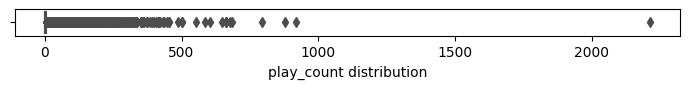

In [15]:
fig = plt.figure(figsize= (7,1))
sns.boxplot(x = df_final["play_count"]
            , color = 'grey').set_xlabel("play_count distribution")
fig.tight_layout()

In [16]:
# Prunning outliers by Calculating the IQR (Interquartile Range)
temp = df_final
f1p = temp['play_count'].quantile(0.01)
l1p = temp['play_count'].quantile(0.99)
IQR = l1p - f1p

# Define a threshold for identifying outliers
outlier_threshold = 1.5

# Remove outliers
df_no_outliers = temp[(temp['play_count'] >= f1p - outlier_threshold * IQR) & (temp['play_count'] <= l1p + outlier_threshold * IQR)]

In [17]:
print(df_no_outliers.describe(exclude='object').transpose())   # any songs with more than 63% plays should be dropped

                count         mean         std  min     25%     50%     75%  \
play_count  2051337.0     2.900968    4.612724  1.0     1.0     1.0     3.0   
song_year   2051337.0  1633.640233  774.725284  0.0  1984.0  2002.0  2007.0   

               max  
play_count    63.0  
song_year   2010.0  


In [18]:
# Get the column containing the users
users = df_final.user_id
# Create a dictionary from users to their number of songs
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [19]:
# We want our users to have listened at least 90 songs
RATINGS_CUTOFF = 90
remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df_final.loc[~df_final.user_id.isin(remove_users)]

In [128]:
df.shape

(466933, 7)

In [22]:
# Get the column containing the songs
songs = df.song_id
# Create a dictionary from songs to their number of users
ratings_count = dict()
for song in songs:
    # If we already have the song, just add 1 to their rating count
    if song in ratings_count:
        ratings_count[song] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[song] = 1

In [23]:
# We want our song to be listened by atleast 120 users to be considered (why?)
RATINGS_CUTOFF = 120
remove_songs = []
for song, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_songs.append(song)
df_final= df.loc[~df.song_id.isin(remove_songs)]

In [24]:
df_final.shape

(152816, 7)

In [25]:
# Drop records with play_count more than(>) 5
df_final=df_final[df_final.play_count<5]

In [26]:
# Check the shape of the data
df_final.shape

(132634, 7)

A total of 138285 x 7 remains after applying pruning selection criteria.

In [135]:
#### Pandas Report original dataset
# Use df_copy
profile_final = ProfileReport(df_final
                        , title="Final dataset Report"
                        #, subtitle="Original Dataset"
                        )

3336 unique users (2.4%)


In [136]:
profile_final.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Final Dataset (df_final)

| Dataset statistics            |         |
| ----------------------------- | ------- |
| Number of variables           | 7       |
| Number of observations        | 138285  |
| Missing cells                 | 0       |
| Missing cells (%)             | 0.00%   |
| Duplicate rows                | 0       |
| Duplicate rows (%)            | 0.00%   |
| Total size in memory          | 8.4 MiB |
| Average record size in memory | 64.0 B  |

Alerts:

      *  song_year has 23399 (16.9%) zeros


## **Exploratory Data Analysis**

### **Numerical Variables EDA**

In [27]:
# numerical variables
print(df_final.describe(exclude='object').transpose())

               count         mean         std  min     25%     50%     75%  \
play_count  132634.0     1.558009    0.866362  1.0     1.0     1.0     2.0   
song_year   132634.0  1669.633555  746.983828  0.0  1996.0  2005.0  2008.0   

               max  
play_count     4.0  
song_year   2010.0  


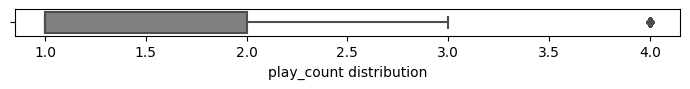

In [28]:
fig = plt.figure(figsize= (7,1))
sns.boxplot(x = df_final["play_count"]
            , color = 'grey').set_xlabel("play_count distribution")
fig.tight_layout()

<AxesSubplot:xlabel='play_count', ylabel='Count'>

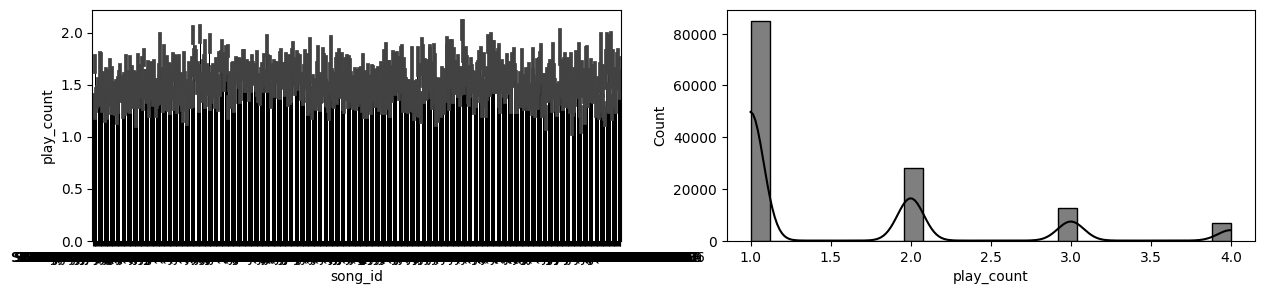

In [33]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
# p1: top users by ratings
sns.barplot(x='song_id', y='play_count', data=df_final, color='black', ax=axes[0])
# p2: ratings distribution (min = 5 given selection criteria)
sns.histplot(df_final['play_count'], bins=25, kde=True, color='black', ax=axes[1])

### **Categorical Variables EDA**

In [29]:
# categorical variables
print(df_final.describe(include='object').transpose())

               count unique                                       top  freq
user_id       132634   3335  ce5c912bb8044f23fc0fc31bd986b8d0a7303db5   278
song_id       132634    620                        SOWCKVR12A8C142411  1538
song_title    132634    627                              use somebody  1538
song_release  132634    453                                 my worlds  1913
song_artist   132634    247                                  coldplay  6313


In [ ]:
# Multivariate categorical analysis


Songs played in a year

In [ ]:
# Find out the number of songs played in a year
  # Hint: Use groupby function on the 'year' column

In [ ]:
# Create a barplot plot with y label as "number of titles played" and x -axis year

# Set the figure size

# Set the x label of the plot

# Set the y label of the plot

# Show the plot

#### **Observations and Insights:**

Unique ocurrences:

                  *   There are 3335 unique users
                  *   There are 620 unique songs_ids
                  *   There are 627 unique song_titles
                  *   There are 453 unique song_releases
                  *   There are 247 unique song_artists

Top ocurrences:

*    Top songs

          *   Top songs_id is SOWCKVR12A8C142411 with 1538 freq
          *   Top song_title is use somebody with 1538 - most probably with SOWCKVR12A8C142411 song_id

| rank | song_title          | freq | freq_% |
| ---- | ------------------- | ---- | ------ |
| 1    | use somebody        | 1602 | 1.20%  |
| 2    | yellow              | 1264 | 0.90%  |
| 3    | dont stop the music | 960  | 0.70%  |
| 4    | somebody to love    | 920  | 0.70%  |
| 5    | love story          | 910  | 0.70%  |

*    Top releases

          *   Top song_release is my worlds with 1913 freq

| rank | song_release                     | freq | freq_% |
| ---- | -------------------------------- | ---- | ------ |
| 1    | my worlds                        | 1967 | 1.40%  |
| 2    | ray guns are not just the future | 1855 | 1.30%  |
| 3    | vampire weekend                  | 1754 | 1.30%  |
| 4    | hell train                       | 1708 | 1.20%  |
| 5    | give up                          | 1632 | 1.20%  |

*    Top song_artists
          *   Top song_artists is coldplay with 6313 freq

| rank | song_artist          | freq | freq_% |
| ---- | -------------------- | ---- | ------ |
| 1    | coldplay             | 6527 | 4.70%  |
| 2    | kings of leon        | 4441 | 3.20%  |
| 3    | the killers          | 4254 | 3.10%  |
| 4    | florence the machine | 3046 | 2.20%  |
| 5    | justin bieber        | 2858 | 2.10%  |

*   Top users

        *   Top user is ce5c912bb8044f23fc0fc31bd986b8d0a7303db5 with 278 freq




Now that we have explored the data, let's apply different algorithms to build recommendation systems.

**Note:** Use the shorter version of the data, i.e., the data after the cutoffs as used in Milestone 1.

## Building various models

### **Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems based on the sum of play counts.

In [ ]:
# Calculating average play_count
       # Hint: Use groupby function on the song_id column

# Calculating the frequency a song is played
      # Hint: Use groupby function on the song_id column

In [ ]:
# Making a dataframe with the average_count and play_freq

# Let us see the first five records of the final_play dataset


Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [ ]:
# Build the function to find top n songs

In [ ]:
# Recommend top 10 songs using the function defined above

### **User User Similarity-Based Collaborative Filtering**

To build the user-user-similarity-based and subsequent models we will use the "surprise" library.

In [ ]:
# Install the surprise package using pip. Uncomment and run the below code to do the same

# !pip install surprise

In [ ]:
# Import necessary libraries

# To compute the accuracy of models


# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count


# Class for loading datasets


# For tuning model hyperparameters


# For splitting the data in train and test dataset


# For implementing similarity-based recommendation system


# For implementing matrix factorization based recommendation system


# For implementing KFold cross-validation

# For implementing clustering-based recommendation system


### Some useful functions

Below is the function to calculate precision@k and recall@k, RMSE, and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?

In [ ]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(model, k = 30, threshold = 1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by changing the threshold? What is the intuition behind using the threshold value of 1.5?

In [ ]:
# Instantiating Reader scale with expected rating scale
 #use rating scale (0, 5)

# Loading the dataset
 # Take only "user_id","song_id", and "play_count"

# Splitting the data into train and test dataset
 # Take test_size = 0.4, random_state = 42

**Think About It:** How changing the test size would change the results and outputs?

In [ ]:
# Build the default user-user-similarity model


# KNN algorithm is used to find desired similar items
 # Use random_state = 1

# Train the algorithm on the trainset, and predict play_count for the testset


# Let us compute precision@k, recall@k, and f_1 score with k = 30
 # Use sim_user_user model

**Observations and Insights:_________**

In [ ]:
# Predicting play_count for a sample user with a listened song
# Use any user id  and song_id

In [ ]:
# Predicting play_count for a sample user with a song not-listened by the user
 #predict play_count for any sample user

**Observations and Insights:_________**

Now, let's try to tune the model and see if we can improve the model performance.

In [ ]:
# Setting up parameter grid to tune the hyperparameters


# Performing 3-fold cross-validation to tune the hyperparameters

# Fitting the data
 # Use entire data for GridSearch

# Best RMSE score

# Combination of parameters that gave the best RMSE score


In [ ]:
# Train the best model found in above gridsearch


**Observations and Insights:_________**

In [ ]:
# Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui = 2


In [ ]:
# Predict the play count for a song that is not listened to by the user (with user_id 6958)


**Observations and Insights:______________**

**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain song?

In [ ]:
# Use inner id 0


Below we will be implementing a function where the input parameters are:

- data: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- top_n: The **number of songs we want to recommend**
- algo: The algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids


    # Creating an user item interactions matrix


    # Extracting those business ids which the user_id has not visited yet

    # Looping through each of the business ids which user_id has not interacted yet


        # Predicting the ratings for those non visited restaurant ids by this user


        # Appending the predicted ratings

    # Sorting the predicted ratings in descending order


    return # Returing top n highest predicted rating products for this user

In [ ]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine


In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"


**Observations and Insights:______________**

### Correcting the play_counts and Ranking the above songs

In [ ]:
def ranking_songs(recommendations, final_rating):
  # Sort the songs based on play counts

  # Merge with the recommended songs to get predicted play_count

  # Rank the songs based on corrected play_counts

  # Sort the songs based on corrected play_counts

  return

**Think About It:** In the above function to correct the predicted play_count a quantity 1/np.sqrt(n) is subtracted. What is the intuition behind it? Is it also possible to add this quantity instead of subtracting?

In [ ]:
# Applying the ranking_songs function on the final_play data


**Observations and Insights:______________**

### Item Item Similarity-based collaborative filtering recommendation systems

In [ ]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance


**Observations and Insights:______________**

In [ ]:
# Predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user


In [ ]:
# Predict the play count for a user that has not listened to the song (with song_id 1671)

**Observations and Insights:______________**

In [ ]:
# Apply grid search for enhancing model performance

# Setting up parameter grid to tune the hyperparameters


# Performing 3-fold cross-validation to tune the hyperparameters

# Fitting the data


# Find the best RMSE score

# Extract the combination of parameters that gave the best RMSE score


**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

In [ ]:
# Apply the best modle found in the grid search


**Observations and Insights:______________**

In [ ]:
# Predict the play_count by a user(user_id 6958) for the song (song_id 1671)


In [ ]:
# Predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user


**Observations and Insights:______________**

In [ ]:
# Find five most similar items to the item with inner id 0


In [ ]:
# Making top 5 recommendations for any user_id  with item_item_similarity-based recommendation engine


In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"


In [ ]:
# Applying the ranking_songs function


**Observations and Insights:_________**

### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

In [ ]:
# Build baseline model using svd


In [ ]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2


In [ ]:
# Making a prediction for the user who has not listened to the song (song_id 3232)


#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [ ]:
# Set the parameter space to tune


# Performe 3-fold grid-search cross-validation


# Fitting data

# Best RMSE score

# Combination of parameters that gave the best RMSE score


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).

In [ ]:
# Building the optimized SVD model using optimal hyperparameters


**Observations and Insights:_________**

In [ ]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671


In [ ]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating


**Observations and Insights:_________**

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm


In [ ]:
# Ranking songs based on above recommendations

**Observations and Insights:_________**

### Cluster Based Recommendation System

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [ ]:
# Make baseline clustering model


In [ ]:
# Making prediction for user_id 6958 and song_id 1671


In [ ]:
# Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user


#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [ ]:
# Set the parameter space to tune


# Performing 3-fold grid search cross-validation

# Fitting data

# Best RMSE score

# Combination of parameters that gave the best RMSE score


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [ ]:
# Train the tuned Coclustering algorithm


**Observations and Insights:_________**

In [ ]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671


In [ ]:
# Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating


**Observations and Insights:_________**

#### Implementing the recommendation algorithm based on optimized CoClustering model

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm


### Correcting the play_count and Ranking the above songs

In [ ]:
# Ranking songs based on the above recommendations


**Observations and Insights:_________**

### Content Based Recommendation Systems

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [ ]:
# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"

In [ ]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data

# Drop the duplicates from the title column

# Set the title column as the index

# See the first 5 records of the df_small dataset


In [ ]:
# Create the series of indices from the data


In [ ]:
# Importing necessary packages to work with text data
import nltk

# Download punkt library


# Download stopwords library


# Download wordnet


# Import regular expression


# Import word_tokenizer


# Import WordNetLemmatizer

# Import stopwords


# Import CountVectorizer and TfidfVectorizer


We will create a **function to pre-process the text data:**

In [ ]:
# Create a function to tokenize the text

In [ ]:
# Create tfidf vectorizer

# Fit_transfrom the above vectorizer on the text column and then convert the output into an array


In [ ]:
# Compute the cosine similarity for the tfidf above output


 Finally, let's create a function to find most similar songs to recommend for a given song.

In [ ]:
# Function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):



    # Getting the index of the song that matches the title


    # Creating a Series with the similarity scores in descending order


    # Getting the indexes of the 10 most similar songs


    # Populating the list with the titles of the best 10 matching songs


    return

Recommending 10 songs similar to Learn to Fly

In [ ]:
# Make the recommendation for the song with title 'Learn To Fly'


**Observations and Insights:_________**

## **Conclusion and Recommendations**

**1. Comparison of various techniques and their relative performance based on chosen Metric (Measure of success)**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

**2. Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

**3. Proposal for the final solution design:**
- What model do you propose to be adopted? Why is this the best solution to adopt?